# pre-process xenium data

In [13]:
def preprocess_spatial_data(adata_path, parquet_path, output_dir, output_prefix, n_pcs, n_neighbors, leiden_res):
    # (이전 답변의 preprocess_spatial_data 함수 내용과 동일)
    print(f"--- Starting Spatial Data Preprocessing: {adata_path} ---")
    try:
        adata = sc.read_10x_h5(adata_path)
        print(f"Loaded spatial data: {adata}")
        
        # QC, Filtering, Normalization, Log, HVG, Scale, PCA, Neighbors, Leiden, UMAP
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        min_genes = 20; min_counts = 50; min_cells = 5
        print(f"Cells before filtering: {adata.n_obs}")
        sc.pp.filter_cells(adata, min_genes=min_genes)
        sc.pp.filter_cells(adata, min_counts=min_counts)
        print(f"Genes before filtering: {adata.n_vars}")
        sc.pp.filter_genes(adata, min_cells=min_cells)
        print(f"Data shape after filtering: {adata.shape}")
        if adata.n_obs == 0 or adata.n_vars == 0:
             raise ValueError("Data is empty after filtering.")
        
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='seurat_v3')
        n_hvg = adata.var['highly_variable'].sum()
        print(f"Found {n_hvg} highly variable genes.")
        if n_hvg == 0:
            print("No highly variable genes found. Using all genes for PCA.")
            adata.var['highly_variable'] = True # Use all if none found

        sc.pp.scale(adata, max_value=10)
        sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
        # Ensure enough PCs were computed
        actual_n_pcs = min(n_pcs, adata.obsm['X_pca'].shape[1])
        if actual_n_pcs < n_pcs:
             print(f"Requested {n_pcs} PCs, but only {actual_n_pcs} could be computed.")
        if actual_n_pcs == 0:
             raise ValueError("PCA could not be computed.")

        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=actual_n_pcs)
        sc.tl.leiden(adata, resolution=leiden_res, key_added=f'leiden_res{leiden_res}')
        sc.tl.umap(adata)

        print("Spatial data preprocessing complete.")
        print(f"Final spatial AnnData object after preprocessing: {adata}")
        # Optional: Save UMAP plot
        # sc.pl.umap(adata, color=[f'leiden_res{leiden_res}'], save=f"_{output_prefix}_st_umap_leiden_{datetime.now.strftime("%y-%m-%d-%H-%M")}.png", show=False, title=f'Leiden Clusters (res={leiden_res})')
        return adata

    except Exception as e:
        print(f"Error during spatial data preprocessing: {e}")
        raise

# 약간 변경: dir를 받는 게 아니라 객체를 그대로 받도록

In [1]:
def preprocess_ann_data(adata, output_dir, output_prefix, n_pcs, n_neighbors, leiden_res):
    
    print(f"--- Starting Ann Data(read from sc.read_h5ad) Preprocessing ---")
    try:
        print(f"Loaded spatial data: {adata}")

        # QC, Filtering, Normalization, Log, HVG, Scale, PCA, Neighbors, Leiden, UMAP
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        min_genes = 20; min_counts = 50; min_cells = 5
        print(f"Cells before filtering: {adata.n_obs}")
        sc.pp.filter_cells(adata, min_genes=min_genes)
        sc.pp.filter_cells(adata, min_counts=min_counts)
        print(f"Genes before filtering: {adata.n_vars}")
        sc.pp.filter_genes(adata, min_cells=min_cells)
        print(f"Data shape after filtering: {adata.shape}")
        if adata.n_obs == 0 or adata.n_vars == 0:
             raise ValueError("Data is empty after filtering.")

        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='seurat_v5')
        n_hvg = adata.var['highly_variable'].sum()
        print(f"Found {n_hvg} highly variable genes.")
        if n_hvg == 0:
            print("No highly variable genes found. Using all genes for PCA.")
            adata.var['highly_variable'] = True # Use all if none found

        sc.pp.scale(adata, max_value=10)
        sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
        # Ensure enough PCs were computed
        actual_n_pcs = min(n_pcs, adata.obsm['X_pca'].shape[1])
        if actual_n_pcs < n_pcs:
             print(f"Requested {n_pcs} PCs, but only {actual_n_pcs} could be computed.")
        if actual_n_pcs == 0:
             raise ValueError("PCA could not be computed.")

        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=actual_n_pcs)
        sc.tl.leiden(adata, resolution=leiden_res, key_added=f'leiden_res{leiden_res}')
        sc.tl.umap(adata)

        print("Spatial data preprocessing complete.")
        print(f"Final spatial AnnData object after preprocessing: {adata}")
        # Optional: Save UMAP plot
        # sc.pl.umap(adata, color=[f'leiden_res{leiden_res}'], save=f"_{output_prefix}_st_umap_leiden.png", show=False, title=f'Leiden Clusters (res={leiden_res})')
        return adata

    except Exception as e:
        print(f"Error during spatial data preprocessing: {e}", exc_info=True)
        raise

# 여러 파라미터도 받을 수 있도록

In [12]:
import scanpy as sc
import anndata as ad
from typing import Optional, Literal

def preprocess_ann_data_flexible(
    adata: ad.AnnData,
    output_dir: str, # 필요시 사용 (예: plot 저장)
    output_prefix: str, # 필요시 사용 (예: plot 저장)
    # QC Parameters
    min_genes: int = 20,
    min_counts: int = 50,
    min_cells: int = 5,
    # Normalization Parameters
    normalization_method: Optional[Literal['log_normalize']] = 'log_normalize', # 'log_normalize' 또는 None
    target_sum: Optional[float] = 1e4, # log_normalize 시 사용
    # HVG Parameters (기존 로직 유지, 필요시 추가 파라미터화 가능)
    hvg_min_mean: float = 0.0125,
    hvg_max_mean: float = 3,
    hvg_min_disp: float = 0.5,
    hvg_flavor: str = 'seurat_v5',
    # Dimensionality Reduction Parameters
    n_pcs: int = 50,
    # Neighbor Graph Parameters
    n_neighbors: int = 15,
    # Clustering Parameters
    clustering_method: Literal['leiden', 'louvain'] = 'leiden',
    cluster_resolution: float = 1.0,
    cluster_key_added: Optional[str] = None # None이면 자동으로 생성
) -> ad.AnnData:
    """
    AnnData 객체를 전처리하는 함수. QC, 필터링, 정규화, HVG선별, 스케일링,
    PCA, Neighbors 계산, 클러스터링(Leiden 또는 Louvain), UMAP 계산을 수행합니다.

    Args:
        adata: 입력 AnnData 객체.
        output_dir: 출력 디렉토리 경로 (현재 함수 내에서는 직접 사용되지 않음).
        output_prefix: 출력 파일 접두사 (현재 함수 내에서는 직접 사용되지 않음).
        min_genes: 세포 필터링 시 최소 유전자 수.
        min_counts: 세포 필터링 시 최소 count 수.
        min_cells: 유전자 필터링 시 최소 세포 수.
        normalization_method: 정규화 방법. 'log_normalize' 또는 None.
        target_sum: 'log_normalize' 시 사용할 target sum.
        hvg_min_mean, hvg_max_mean, hvg_min_disp, hvg_flavor: highly_variable_genes 파라미터.
        n_pcs: PCA 계산 시 사용할 주성분 개수.
        n_neighbors: Neighbors 계산 시 사용할 이웃 수.
        clustering_method: 사용할 클러스터링 알고리즘 ('leiden' 또는 'louvain').
        cluster_resolution: 클러스터링 해상도.
        cluster_key_added: 클러스터링 결과를 저장할 obs 키 이름. None이면 자동 생성.

    Returns:
        전처리된 AnnData 객체.

    Raises:
        ValueError: 필터링 후 데이터가 비어 있거나 PCA 계산이 불가능한 경우.
        Exception: 기타 전처리 오류 발생 시.
    """
    print(f"--- Starting AnnData Preprocessing ---")
    try:
        print(f"Input AnnData: {adata}")
        adata_processed = adata.copy() # 원본 보존을 위해 복사본 사용

        # 1. QC 및 필터링
        print("Calculating QC metrics...")
        sc.pp.calculate_qc_metrics(adata_processed, percent_top=None, log1p=False, inplace=True)

        print(f"Filtering cells (min_genes={min_genes}, min_counts={min_counts})...")
        print(f"Cells before filtering: {adata_processed.n_obs}")
        sc.pp.filter_cells(adata_processed, min_genes=min_genes)
        sc.pp.filter_cells(adata_processed, min_counts=min_counts)
        print(f"Cells after filtering: {adata_processed.n_obs}")

        print(f"Filtering genes (min_cells={min_cells})...")
        print(f"Genes before filtering: {adata_processed.n_vars}")
        sc.pp.filter_genes(adata_processed, min_cells=min_cells)
        print(f"Genes after filtering: {adata_processed.n_vars}")

        print(f"Data shape after filtering: {adata_processed.shape}")
        if adata_processed.n_obs == 0 or adata_processed.n_vars == 0:
            raise ValueError("Data is empty after filtering.")

        # 2. 정규화
        if normalization_method == 'log_normalize':
            print(f"Applying log-normalization (target_sum={target_sum})...")
            sc.pp.normalize_total(adata_processed, target_sum=target_sum)
            sc.pp.log1p(adata_processed)
        elif normalization_method is None:
            print("Skipping normalization.")
        else:
            print(f"Warning: Unknown normalization method '{normalization_method}'. Skipping.")

        # 3. Highly Variable Genes (HVG)
        print("Finding highly variable genes...")
        sc.pp.highly_variable_genes(
            adata_processed,
            min_mean=hvg_min_mean,
            max_mean=hvg_max_mean,
            min_disp=hvg_min_disp,
            flavor=hvg_flavor
        )
        n_hvg = adata_processed.var['highly_variable'].sum()
        print(f"Found {n_hvg} highly variable genes.")
        if n_hvg == 0:
            print("Warning: No highly variable genes found. Using all genes for downstream analysis.")
            # 모든 유전자를 사용하도록 설정 (PCA 등에서 use_highly_variable=False 사용 필요)
            use_hvg = False
        else:
            use_hvg = True # HVG를 사용하는 것이 기본

        # 4. 스케일링 (HVG 기반 또는 전체 유전자 기반)
        print("Scaling data...")
        # 스케일링은 보통 HVG에 대해서만 수행하거나, 모든 유전자에 대해 수행 후 HVG 정보는 유지합니다.
        # 여기서는 모든 유전자를 스케일링하고, PCA에서 HVG 사용 여부를 결정합니다.
        sc.pp.scale(adata_processed, max_value=10)

        # 5. PCA (차원 축소)
        print("Running PCA...")
        # 만약 HVG가 없다면 모든 유전자를 사용합니다.
        sc.tl.pca(adata_processed, svd_solver='arpack', use_highly_variable=use_hvg, n_comps=min(n_pcs * 2, adata_processed.n_vars - 1, adata_processed.n_obs - 1)) # 충분한 컴포넌트 계산

        # 실제 사용될 PC 개수 확인 및 조정
        if 'X_pca' not in adata_processed.obsm:
             raise ValueError("PCA could not be computed.")
        actual_n_pcs = min(n_pcs, adata_processed.obsm['X_pca'].shape[1])
        if actual_n_pcs < n_pcs:
            print(f"Requested {n_pcs} PCs, but only {actual_n_pcs} could be computed.")
        if actual_n_pcs == 0:
            raise ValueError("PCA resulted in 0 components.")
        # 사용하지 않을 PCA 컴포넌트 제거 (메모리 관리)
        if adata_processed.obsm['X_pca'].shape[1] > actual_n_pcs:
             adata_processed.obsm['X_pca'] = adata_processed.obsm['X_pca'][:, :actual_n_pcs]
             adata_processed.uns['pca']['variance'] = adata_processed.uns['pca']['variance'][:actual_n_pcs]
             adata_processed.uns['pca']['variance_ratio'] = adata_processed.uns['pca']['variance_ratio'][:actual_n_pcs]
             adata_processed.varm['PCs'] = adata_processed.varm['PCs'][:, :actual_n_pcs]


        # 6. Neighbors Graph
        print("Calculating neighbors graph...")
        sc.pp.neighbors(adata_processed, n_neighbors=n_neighbors, n_pcs=actual_n_pcs)

        # 7. 클러스터링
        print(f"Running {clustering_method} clustering (resolution={cluster_resolution})...")
        # 클러스터링 결과 저장 키 설정
        if cluster_key_added is None:
            cluster_key_added = f"{clustering_method}_res{cluster_resolution}"

        if clustering_method == 'leiden':
            sc.tl.leiden(adata_processed, resolution=cluster_resolution, key_added=cluster_key_added)
        elif clustering_method == 'louvain':
            sc.tl.louvain(adata_processed, resolution=cluster_resolution, key_added=cluster_key_added)
        else:
            print(f"Warning: Unknown clustering method '{clustering_method}'. Skipping clustering.")

        # 8. UMAP (시각화)
        print("Running UMAP...")
        sc.tl.umap(adata_processed)

        print("--- AnnData Preprocessing Complete ---")
        print(f"Final AnnData object after preprocessing: {adata_processed}")

        # 예시: UMAP 플롯 저장 (필요시 주석 해제)
        # if clustering_method in ['leiden', 'louvain']:
        #     fig_path = os.path.join(output_dir, f"{output_prefix}_umap_{cluster_key_added}.png")
        #     sc.pl.umap(adata_processed, color=[cluster_key_added], save=fig_path, show=False, title=f'{clustering_method.capitalize()} Clusters (res={cluster_resolution})')
        #     print(f"UMAP plot saved to {fig_path}")

        return adata_processed

    except Exception as e:
        print(f"Error during data preprocessing: {e}")
        import traceback
        traceback.print_exc() # 상세 에러 로그 출력
        raise # 에러를 다시 발생시켜 호출자가 알 수 있도록 함

# --- 예시 사용법 ---
# import scanpy as sc
# # 가상의 AnnData 객체 생성 또는 로드
# # adata = sc.read_h5ad("your_data.h5ad")
# adata = sc.datasets.pbmc3k_processed() # 예시 데이터셋 (이미 일부 전처리됨)
# adata = adata[:500, :1000].copy() # 작은 예시 데이터
# adata.X = adata.X.astype(float) # 타입 확인

# # 함수 호출
# processed_adata = preprocess_ann_data_flexible(
#     adata=adata,
#     output_dir='./results',
#     output_prefix='pbmc_processed',
#     min_genes=50,
#     min_counts=100,
#     min_cells=3,
#     normalization_method='log_normalize',
#     target_sum=1e4,
#     n_pcs=30,
#     n_neighbors=10,
#     clustering_method='louvain', # louvain 사용
#     cluster_resolution=0.5
# )
# print("\nProcessed AnnData info:")
# print(processed_adata)
# if 'louvain_res0.5' in processed_adata.obs.columns:
#     print("\nLouvain clusters:")
#     print(processed_adata.obs['louvain_res0.5'].value_counts())

# gemini style

In [193]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import logging
from scipy import sparse
from typing import Optional, Dict, Any, Literal, List, Tuple # 타입 힌트 추가

# --- 로깅 설정 ---
# 파일과 콘솔에 모두 로깅하도록 설정
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('preprocess_xenium')
logger.setLevel(logging.INFO) # 로그 레벨 설정 (DEBUG, INFO, WARNING, ERROR, CRITICAL)

# 콘솔 핸들러
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
logger.addHandler(console_handler)

# 파일 핸들러 (함수 호출 시 동적으로 파일 경로 설정)
file_handler = None

# Scanpy 로깅 설정
sc.settings.verbosity = 3 # 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # 그림 품질 향상 및 프레임 제거


def preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url: str,
    cells_parquet_url: str,
    boundaries_parquet_url: str, # 현재 사용되지 않지만, 나중을 위해 포함
    core_info_dir: Optional[str] = None, # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)

    # --- 출력 및 기본 설정 ---
    output_prefix: str = "processed_xenium", # 출력 파일명 접두사
    sample_id: str = "sample", # 샘플 ID 지정
    save_plots: bool = True, # 중간 과정 plot 저장 여부
    save_adata: bool = True, # 최종 AnnData 객체 저장 여부

    # --- QC 파라미터 ---
    qc_filter: bool = True, # QC 기반 필터링 수행 여부
    min_counts_per_cell: Optional[int] = 10, # 세포당 최소 count 수 (필터링용)
    max_counts_per_cell: Optional[int] = None, # 세포당 최대 count 수 (필터링용, 필요시 설정)
    min_genes_per_cell: Optional[int] = 3,   # 세포당 최소 유전자 수 (필터링용)
    max_genes_per_cell: Optional[int] = None, # 세포당 최대 유전자 수 (필터링용, 필요시 설정)
    min_cells_per_gene: Optional[int] = 3,   # 유전자당 최소 발현 세포 수 (필터링용)
    max_pct_mito: Optional[float] = 20.0, # 최대 미토콘드리아 유전자 비율 (필터링용)

    # --- Normalization & HVG 파라미터 ---
    normalization_method: Literal['lognorm', 'sct'] = 'lognorm', # 정규화 방법 선택
    # LogNorm 파라미터
    lognorm_target_sum: Optional[float] = 1e4, # normalize_total target_sum
    lognorm_hvg_min_mean: float = 0.0125,
    lognorm_hvg_max_mean: float = 3,
    lognorm_hvg_min_disp: float = 0.5,
    lognorm_hvg_n_top_genes: Optional[int] = None, # 상위 N개 HVG 선택 (선택 사항)
    # SCTransform 파라미터 (sctransform 라이브러리 필요)
    sct_n_genes: int = 3000, # SCTransform으로 찾을 HVG 수
    sct_min_cells: int = 5,    # SCTransform 유전자 필터링 기준
    sct_residual_type: Literal['pearson', 'deviance'] = 'pearson',

    # --- Scaling 파라미터 (lognorm 사용 시) ---
    scale_max_value: Optional[float] = 10, # sc.pp.scale의 max_value (clipping)

    # --- 차원 축소 및 클러스터링 파라미터 ---
    pca_n_comps: int = 50,
    neighbors_n_pcs: int = 40, # neighbors 계산에 사용할 PC 수 (elbow plot 참고)
    neighbors_n_neighbors: int = 15,
    cluster_algo: Literal['leiden', 'louvain'] = 'leiden',
    cluster_resolution: float = 0.8,
    umap_min_dist: float = 0.5,
    umap_spread: float = 1.0,

    # --- 마커 유전자 탐색 파라미터 ---
    rank_genes_method: Literal['wilcoxon', 't-test', 'logreg'] = 'wilcoxon',
    rank_genes_n_genes: int = 25, # plot할 마커 유전자 수
    rank_genes_pts: bool = True, # rank_genes_groups에서 pts 계산 여부

    # --- 기타 ---
    random_seed: int = 0 # 재현성을 위한 random seed
) -> Optional[sc.AnnData]:
    """
    Xenium 데이터셋을 로드하고 전처리하는 파이프라인 함수.

    Args:
        h5_url (str): cell_feature_matrix.h5 파일 경로.
        cells_parquet_url (str): cells.parquet 파일 경로.
        boundaries_parquet_url (str): cell_boundaries.parquet 파일 경로. (현재 사용 안 함)
        core_info_dir (Optional[str]): Core 정보 CSV 파일이 있는 디렉토리 경로. Defaults to None.
        output_prefix (str): 로그, 플롯, AnnData 파일 저장 시 사용할 접두사. Defaults to "processed_xenium".
        sample_id (str): 데이터셋에 부여할 샘플 ID. Defaults to "sample".
        save_plots (bool): 중간 분석 플롯 저장 여부. Defaults to True.
        save_adata (bool): 최종 AnnData 객체 저장 여부. Defaults to True.
        qc_filter (bool): QC 기반 세포/유전자 필터링 수행 여부. Defaults to True.
        min_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최소 UMI 수. Defaults to 10.
        max_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최대 UMI 수. Defaults to None.
        min_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최소 발현 유전자 수. Defaults to 3.
        max_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최대 발현 유전자 수. Defaults to None.
        min_cells_per_gene (Optional[int]): 필터링 기준: 유전자당 최소 발현 세포 수. Defaults to 3.
        max_pct_mito (Optional[float]): 필터링 기준: 최대 미토콘드리아 유전자 비율 (%). Defaults to 20.0.
        normalization_method (Literal['lognorm', 'sct']): 정규화 방법 ('lognorm' 또는 'sct'). Defaults to 'lognorm'.
        lognorm_target_sum (Optional[float]): LogNorm 시 normalize_total의 target_sum. Defaults to 1e4.
        lognorm_hvg_min_mean (float): LogNorm 시 HVG 기준: 최소 평균 발현. Defaults to 0.0125.
        lognorm_hvg_max_mean (float): LogNorm 시 HVG 기준: 최대 평균 발현. Defaults to 3.
        lognorm_hvg_min_disp (float): LogNorm 시 HVG 기준: 최소 분산. Defaults to 0.5.
        lognorm_hvg_n_top_genes (Optional[int]): LogNorm 시 상위 N개 HVG 선택 (다른 기준보다 우선). Defaults to None.
        sct_n_genes (int): SCTransform 시 찾을 HVG 수. Defaults to 3000.
        sct_min_cells (int): SCTransform 시 유전자가 최소 발현되어야 하는 세포 수. Defaults to 5.
        sct_residual_type (Literal['pearson', 'deviance']): SCTransform 잔차 타입. Defaults to 'pearson'.
        scale_max_value (Optional[float]): LogNorm 후 스케일링 시 최대값 clipping. Defaults to 10.
        pca_n_comps (int): PCA 주성분 개수. Defaults to 50.
        neighbors_n_pcs (int): Neighbors 계산 시 사용할 PC 개수. Defaults to 40.
        neighbors_n_neighbors (int): Neighbors 계산 시 이웃 수. Defaults to 15.
        cluster_algo (Literal['leiden', 'louvain']): 사용할 클러스터링 알고리즘. Defaults to 'leiden'.
        cluster_resolution (float): 클러스터링 해상도. Defaults to 0.8.
        umap_min_dist (float): UMAP min_dist 파라미터. Defaults to 0.5.
        umap_spread (float): UMAP spread 파라미터. Defaults to 1.0.
        rank_genes_method (Literal['wilcoxon', 't-test', 'logreg']): 마커 유전자 탐색 방법. Defaults to 'wilcoxon'.
        rank_genes_n_genes (int): 마커 유전자 플롯 시 상위 유전자 수. Defaults to 25.
        rank_genes_pts (bool): rank_genes_groups에서 pts 계산 여부. Defaults to True.
        random_seed (int): 재현성을 위한 random seed. Defaults to 0.

    Returns:
        Optional[sc.AnnData]: 전처리된 AnnData 객체. save_adata가 False면 None 반환 가능.
    """
    global file_handler # 전역 file_handler 사용 선언

    # --- 출력 디렉토리 생성 ---
    output_dir = os.path.dirname(output_prefix)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logger.info(f"Created output directory: {output_dir}")

    # --- 로깅 파일 핸들러 설정 ---
    # 기존 핸들러 제거 (함수 재호출 시 중복 방지)
    if file_handler:
        logger.removeHandler(file_handler)
    log_file = f"{output_prefix}_processing.log"
    file_handler = logging.FileHandler(log_file, mode='w') # 'w' 모드로 열어 매번 새로 작성
    file_handler.setFormatter(log_formatter)
    logger.addHandler(file_handler)

    logger.info("Starting Xenium data preprocessing pipeline.")
    logger.info(f"Output prefix set to: {output_prefix}")
    logger.info(f"Sample ID set to: {sample_id}")

    # 재현성을 위한 random seed 설정
    np.random.seed(random_seed)

    # --- 1. 데이터 로딩 ---
    logger.info("--- Step 1: Loading Data ---")
    try:
        logger.info(f"Reading H5 file: {h5_url}")
        adata = sc.read_10x_h5(h5_url)
        adata.var_names_make_unique() # 유전자 이름 고유하게 만들기
        adata.obs['sample_id'] = sample_id # 샘플 ID 부여

        adata.uns['provenance'] = {} # 데이터 추적 정보 저장 공간
        adata.uns['provenance']['load'] = {
            'h5_url': h5_url,
            'initial_n_obs': adata.n_obs,
            'initial_n_vars': adata.n_vars,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        adata.layers['counts'] = adata.X.copy() # 원본 count 저장

        logger.info(f"Reading cells parquet file: {cells_parquet_url}")
        cells_df = pd.read_parquet(cells_parquet_url)
        if 'cell_id' in cells_df.columns:
            cells_df = cells_df.set_index('cell_id')
        else:
            logger.warning("'cell_id' column not found in cells parquet. Assuming index matches AnnData.")

        # boundaries parquet는 현재 사용하지 않음 (필요시 로드)
        # logger.info(f"Reading boundaries parquet file: {boundaries_parquet_url}")
        # boundaries_df = pd.read_parquet(boundaries_parquet_url)

    except FileNotFoundError as e:
        logger.error(f"File not found: {e}. Aborting.")
        return None
    except Exception as e:
        logger.error(f"An error occurred during data loading: {e}")
        return None

    logger.info(f"Initial AnnData object shape: {adata.shape}")
    logger.info(f"Available obs columns from H5: {adata.obs.columns.tolist()}")
    logger.info(f"Available var columns from H5: {adata.var.columns.tolist()}")

    # --- 2. 메타데이터 통합 ---
    logger.info("--- Step 2: Integrating Metadata ---")
    adata.uns['provenance']['metadata'] = {'params': {}, 'log': {}}

    # 2a. Cells Parquet 정보 추가
    original_obs_cols = set(adata.obs.columns)
    logger.info("Joining metadata from cells parquet file.")
    adata.obs = adata.obs.join(cells_df, how='left', lsuffix='_h5', rsuffix='_parquet')
    new_cols = set(adata.obs.columns) - original_obs_cols
    logger.info(f"Added columns from cells parquet: {list(new_cols)}")
    adata.uns['provenance']['metadata']['log']['cells_parquet_cols_added'] = list(new_cols)

    # 2b. 공간 좌표 추가 (obsm['spatial'])
    # 우선순위: 'x_centroid', 'y_centroid' -> '_x', '_y' (Xenium v1)
    x_col, y_col = None, None
    if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
        x_col, y_col = 'x_centroid', 'y_centroid'
    elif 'x' in adata.obs.columns and 'y' in adata.obs.columns: # Xenium v1 호환성
         x_col, y_col = 'x', 'y'
    # 필요시 fov 관련 좌표 추가 (보통 상대 좌표임)
    # elif 'fov_x' in adata.obs.columns and 'fov_y' in adata.obs.columns:
    #     x_col, y_col = 'fov_x', 'fov_y'

    if x_col and y_col:
        logger.info(f"Populating adata.obsm['spatial'] using columns: '{x_col}', '{y_col}'")
        adata.obsm['spatial'] = adata.obs[[x_col, y_col]].to_numpy()
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = (x_col, y_col)
    else:
        logger.warning("Could not find standard spatial coordinate columns (e.g., 'x_centroid', 'y_centroid', 'x', 'y') in adata.obs. adata.obsm['spatial'] not populated.")
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = None

    # 2c. Core 정보 추가 (선택 사항)
    conflict_report = []
    if core_info_dir:
        logger.info(f"Integrating core information from directory: {core_info_dir}")
        if not os.path.isdir(core_info_dir):
            logger.warning(f"Core info directory not found: {core_info_dir}. Skipping core info integration.")
        else:
            core_files = glob.glob(os.path.join(core_info_dir, '*_cells_stats.csv'))
            logger.info(f"Found {len(core_files)} potential core info files.")
            adata.obs['Core'] = pd.NA # Core 컬럼 초기화

            for core_url in core_files:
                basename = os.path.basename(core_url)
                # 파일명에서 숫자 Core ID 추출 (정규 표현식 강화)
                match = re.match(r"(\d+)[_-].*cells.*\.csv", basename, re.IGNORECASE)
                if not match:
                    logger.warning(f"Cannot extract numeric Core ID from filename: {basename}. Skipping file.")
                    continue
                core_id = match.group(1)
                logger.debug(f"Processing core file: {basename} for Core ID: {core_id}")

                try:
                    core_df = pd.read_csv(core_url, comment="#", skip_blank_lines=True)
                    # Cell ID 컬럼 이름 유연하게 찾기
                    cell_id_col = None
                    possible_id_cols = ['Cell ID', 'cell_id', 'Cell_ID']
                    for col in possible_id_cols:
                        if col in core_df.columns:
                            cell_id_col = col
                            break
                    if not cell_id_col:
                        logger.warning(f"'{possible_id_cols}' column not found in {basename}. Skipping.")
                        continue

                    core_df = core_df.set_index(cell_id_col)
                    core_df["Core_from_file"] = core_id # 임시 컬럼명 사용

                    # AnnData 인덱스와 Core 파일 인덱스 비교 (타입 통일 시도)
                    adata_idx = adata.obs.index.astype(str)
                    core_idx = core_df.index.astype(str)
                    overlapping_idx_str = adata_idx.intersection(core_idx)

                    if overlapping_idx_str.empty:
                        logger.warning(f"No overlapping cell IDs found between AnnData and {basename}. Check ID formats.")
                        continue

                    # 원래 AnnData 인덱스 타입으로 변환하여 사용
                    overlapping_idx = adata.obs.index[adata_idx.isin(overlapping_idx_str)]
                    core_df_aligned = core_df.loc[overlapping_idx_str] # 문자열 인덱스로 정렬된 core 데이터

                    logger.info(f"Found {len(overlapping_idx)} overlapping cells for Core {core_id} in {basename}.")

                    # Core ID 할당 (이미 할당된 경우 경고)
                    core_conflict_mask = adata.obs.loc[overlapping_idx, 'Core'].notna() & \
                                         (adata.obs.loc[overlapping_idx, 'Core'] != core_id)
                    if core_conflict_mask.any():
                         conflicted_cells = overlapping_idx[core_conflict_mask]
                         logger.warning(f"{len(conflicted_cells)} cells in Core {core_id} file ({basename}) were already assigned to a different Core: {conflicted_cells.tolist()[:5]}...")
                         # 충돌 시 어떻게 처리할지 정책 결정 필요 (예: 첫 번째 할당 유지, 파일 우선 등)
                         # 여기서는 일단 덮어쓰지 않음
                         adata.obs.loc[overlapping_idx[~core_conflict_mask], 'Core'] = core_id
                    else:
                         adata.obs.loc[overlapping_idx, 'Core'] = core_id

                    # 다른 컬럼들 병합 (충돌 처리 포함)
                    for col in core_df_aligned.columns:
                        if col == "Core_from_file": continue # 임시 컬럼 제외

                        col_target = f"{col}_core" # 이름 충돌 방지 위해 접미사 추가
                        if col_target not in adata.obs.columns:
                            adata.obs[col_target] = pd.NA # 새 컬럼 생성 (Pandas 1.x 이상 NA 사용 권장)

                        # Core 파일 값으로 업데이트 (기존 값이 NA인 경우만)
                        update_mask = adata.obs.loc[overlapping_idx, col_target].isna() & \
                                      core_df_aligned[col].notna().values # .values로 numpy 배열화
                        adata.obs.loc[overlapping_idx[update_mask], col_target] = core_df_aligned.loc[overlapping_idx_str[update_mask], col].values

                        # 충돌 기록 (기존 값과 새 값이 모두 있고 다른 경우)
                        conflict_mask = adata.obs.loc[overlapping_idx, col_target].notna() & \
                                        core_df_aligned[col].notna().values & \
                                        (adata.obs.loc[overlapping_idx, col_target].astype(str) != core_df_aligned.loc[overlapping_idx_str, col].astype(str)) # 타입 다를 수 있으므로 문자열 비교
                        if conflict_mask.any():
                            conflicted_cells_idx = overlapping_idx[conflict_mask]
                            conflicted_cells_str_idx = overlapping_idx_str[conflict_mask]
                            for i, cell_idx in enumerate(conflicted_cells_idx):
                                cell_str_idx = conflicted_cells_str_idx[i]
                                conflict_report.append({
                                    "cell": cell_idx,
                                    "column": col_target,
                                    "adata_value": adata.obs.loc[cell_idx, col_target],
                                    "core_value": core_df_aligned.loc[cell_str_idx, col],
                                    "source_file": basename
                                })
                            logger.warning(f"Value conflict for column '{col_target}' in {conflict_mask.sum()} cells from {basename}. See conflict report.")

                except pd.errors.EmptyDataError:
                    logger.warning(f"Core file is empty: {basename}. Skipping.")
                except Exception as e:
                    logger.error(f"Error processing core file {basename}: {e}")

            n_assigned = adata.obs['Core'].notna().sum()
            n_total = adata.n_obs
            logger.info(f"Assigned Core IDs to {n_assigned}/{n_total} cells.")
            if n_assigned > 0:
                logger.info(f"Core value counts:\n{adata.obs['Core'].value_counts(dropna=False)}")

            # Core ID 없는 세포 제거 (선택적 단계) - 필요시 주석 해제
            # n_before = adata.n_obs
            # adata = adata[adata.obs["Core"].notna()].copy()
            # n_after = adata.n_obs
            # if n_before != n_after:
            #    logger.info(f"Removed {n_before - n_after} cells with missing Core ID.")
            #    adata.uns['provenance']['metadata']['log']['cells_removed_missing_core'] = n_before - n_after

            adata.uns['provenance']['metadata']['params']['core_info_dir'] = core_info_dir
            adata.uns['provenance']['metadata']['log']['n_core_files_processed'] = len(core_files)
            adata.uns['provenance']['metadata']['log']['n_cells_assigned_core'] = n_assigned

            # 충돌 리포트 저장
            if conflict_report:
                conflict_df = pd.DataFrame(conflict_report)
                conflict_file = f"{output_prefix}_core_metadata_conflicts.csv"
                try:
                    conflict_df.to_csv(conflict_file, index=False)
                    logger.warning(f"Metadata conflicts detected. Report saved to: {conflict_file}")
                except Exception as e:
                    logger.error(f"Failed to save conflict report: {e}")
    else:
        logger.info("Core info directory not provided. Skipping core info integration.")

    adata.uns['provenance']['metadata']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 3. QC 메트릭 계산 ---
    logger.info("--- Step 3: Calculating QC Metrics ---")
    adata.uns['provenance']['qc'] = {'params': {}, 'log': {}}

    # 유전자 유형 식별 (Mito: 사람 'MT-', 마우스 'mt-'. 유연하게 처리)
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.upper().str.startswith(('RPS', 'RPL'))
    # Hemoglobin 정규식 수정: 시작(^), P 제외 ([^(P)])
    adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]', case=False, regex=True)

    logger.info(f"Identified {adata.var['mt'].sum()} mitochondrial genes.")
    logger.info(f"Identified {adata.var['ribo'].sum()} ribosomal genes.")
    logger.info(f"Identified {adata.var['hb'].sum()} hemoglobin genes.")

    # Scanpy QC 계산
    # log1p=True는 시각화에는 유용하지만, 필터링 기준(예: pct_counts_mt)은 원본 비율로 하는 것이 일반적
    # 여기서는 계산 후 pct_counts* 컬럼만 사용하므로 log1p=False로 계산하고 필요시 로그변환
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=None, log1p=False)
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_ribo'] = adata.obs['total_counts_ribo'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_hb'] = adata.obs['total_counts_hb'] / adata.obs['total_counts'] * 100

    # 샘플 레벨 QC 요약 (필터링 전 상태 기록)
    qc_summary_before_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))), # NA는 0으로 간주
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_before_filter'] = qc_summary_before_filter
    logger.info(f"QC metrics calculated. Summary (before filtering): {qc_summary_before_filter}")

    # QC 플롯 저장 (필터링 전 분포 확인용)
    if save_plots:
        try:
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
            sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
            sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
            plt.suptitle(f"{sample_id} - QC Before Filtering", y=1.02)
            plt.tight_layout()
            plot_file = f"{output_prefix}_qc_violin_before_filter.png"
            plt.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved QC violin plot (before filtering) to: {plot_file}")
        except Exception as e:
            logger.warning(f"Could not generate QC violin plot: {e}")

    adata.uns['provenance']['qc']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 4. QC 필터링 (선택 사항) ---
    logger.info("--- Step 4: QC Filtering (Optional) ---")
    adata.uns['provenance']['filter'] = {'params': {}, 'log': {}}
    adata.uns['provenance']['filter']['params']['qc_filter_enabled'] = qc_filter

    if qc_filter:
        n_obs_before, n_vars_before = adata.shape
        logger.info(f"Applying QC filters with parameters: min_counts={min_counts_per_cell}, "
                    f"max_counts={max_counts_per_cell}, min_genes={min_genes_per_cell}, "
                    f"max_genes={max_genes_per_cell}, min_cells={min_cells_per_gene}, "
                    f"max_pct_mito={max_pct_mito}")

        # 필터링 조건 기록
        adata.uns['provenance']['filter']['params']['min_counts_per_cell'] = min_counts_per_cell
        adata.uns['provenance']['filter']['params']['max_counts_per_cell'] = max_counts_per_cell
        adata.uns['provenance']['filter']['params']['min_genes_per_cell'] = min_genes_per_cell
        adata.uns['provenance']['filter']['params']['max_genes_per_cell'] = max_genes_per_cell
        adata.uns['provenance']['filter']['params']['min_cells_per_gene'] = min_cells_per_gene
        adata.uns['provenance']['filter']['params']['max_pct_mito'] = max_pct_mito

        # 유전자 필터링 (먼저 수행하는 것이 일반적)
        if min_cells_per_gene is not None and min_cells_per_gene > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
            logger.info(f"Filtered genes: {n_vars_before - adata.n_vars} genes removed (< {min_cells_per_gene} cells).")

        # 세포 필터링
        filter_masks = []
        if min_genes_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_genes=min_genes_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_genes ({min_genes_per_cell}): {np.sum(~mask)}")
        if max_genes_per_cell is not None:
             mask = adata.obs['n_genes_by_counts'] <= max_genes_per_cell
             filter_masks.append(mask)
             logger.info(f"Cells to remove based on max_genes ({max_genes_per_cell}): {np.sum(~mask)}")
        if min_counts_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_counts=min_counts_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_counts ({min_counts_per_cell}): {np.sum(~mask)}")
        if max_counts_per_cell is not None:
            mask = adata.obs['total_counts'] <= max_counts_per_cell
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_counts ({max_counts_per_cell}): {np.sum(~mask)}")
        if max_pct_mito is not None:
            # 결측치(mt 유전자 없거나 total_counts 0인 경우)는 통과시키도록 처리
            mask = (adata.obs['pct_counts_mt'] <= max_pct_mito) | adata.obs['pct_counts_mt'].isna()
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_pct_mito ({max_pct_mito}%): {np.sum(~mask & adata.obs['pct_counts_mt'].notna())}") # NA 아닌 것만 카운트

        # 모든 마스크 조합
        if filter_masks:
            combined_mask = np.all(filter_masks, axis=0)
            n_removed = np.sum(~combined_mask)
            adata._inplace_subset_obs(combined_mask) # 내부 함수지만 효율적
            logger.info(f"Filtered cells: {n_removed} cells removed based on combined criteria.")
        else:
            logger.info("No cell filtering criteria applied.")

        logger.info(f"AnnData shape after QC filtering: {adata.shape}")
        adata.uns['provenance']['filter']['log'] = {
            'n_obs_before': n_obs_before,
            'n_vars_before': n_vars_before,
            'n_obs_after': adata.n_obs,
            'n_vars_after': adata.n_vars,
            'n_cells_removed': n_obs_before - adata.n_obs,
            'n_genes_removed': n_vars_before - adata.n_vars
        }

        # QC 플롯 저장 (필터링 후)
        if save_plots and (n_obs_before != adata.n_obs or n_vars_before != adata.n_vars):
            try:
                fig, axs = plt.subplots(1, 3, figsize=(15, 4))
                sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
                sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
                sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
                plt.suptitle(f"{sample_id} - QC After Filtering", y=1.02)
                plt.tight_layout()
                plot_file = f"{output_prefix}_qc_violin_after_filter.png"
                plt.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved QC violin plot (after filtering) to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate QC violin plot after filtering: {e}")

    else:
        logger.info("QC filtering step skipped.")
        adata.uns['provenance']['filter']['log'] = {'message': 'Filtering skipped'}

    adata.uns['provenance']['filter']['timestamp'] = pd.Timestamp.now().isoformat()

    # 필터링 후 데이터가 비어있는지 확인
    if adata.n_obs == 0 or adata.n_vars == 0:
        logger.error("AnnData object became empty after filtering. Aborting.")
        return None

    # --- .raw 설정: rank_genes_groups 등에서 사용하기 위해 정규화/로그변환된 데이터 저장 ---
    # SCTransform을 사용하더라도, rank_genes는 lognorm 기반 데이터에서 수행하는 경우가 많음
    # 따라서 두 경우 모두 lognorm 계산을 수행하여 .raw에 저장
    logger.info("Preparing .raw attribute with log-normalized data.")
    adata_raw = adata.copy()
    sc.pp.normalize_total(adata_raw, target_sum=lognorm_target_sum)
    sc.pp.log1p(adata_raw)
    adata.raw = adata_raw # .raw에는 필터링 후, lognorm된 전체 유전자 데이터가 저장됨
    logger.info("Saved log-normalized data to adata.raw")


    # --- 5. 정규화 & 고분산 유전자(HVG) 선택 ---
    logger.info(f"--- Step 5: Normalization & HVG Selection ({normalization_method}) ---")
    adata.uns['provenance']['normalization'] = {'params': {'method': normalization_method}, 'log': {}}
    adata.uns['provenance']['hvg'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Applying LogNormalize: target_sum={lognorm_target_sum}")
        # .raw 준비 단계에서 이미 normalize, log1p 수행했으므로, 현재 adata에 적용
        sc.pp.normalize_total(adata, target_sum=lognorm_target_sum)
        adata.layers['lognorm_counts'] = adata.X.copy() # 정규화 결과 저장
        logger.info("Applying log1p transformation.")
        sc.pp.log1p(adata)
        adata.layers['log1p_counts'] = adata.X.copy() # 로그 변환 결과 저장

        adata.uns['provenance']['normalization']['params']['lognorm_target_sum'] = lognorm_target_sum

        logger.info("Finding Highly Variable Genes (HVGs) using Scanpy method.")
        hvg_params = {
            'min_mean': lognorm_hvg_min_mean,
            'max_mean': lognorm_hvg_max_mean,
            'min_disp': lognorm_hvg_min_disp,
            'n_top_genes': lognorm_hvg_n_top_genes,
            'flavor': 'seurat_v3' if lognorm_hvg_n_top_genes is None else 'cell_ranger' # n_top_genes 유무에 따라 flavor 변경
        }
        # None 파라미터 제거
        hvg_params = {k: v for k, v in hvg_params.items() if v is not None}

        sc.pp.highly_variable_genes(adata, **hvg_params)
        n_hvg = adata.var['highly_variable'].sum()
        logger.info(f"Found {n_hvg} HVGs using parameters: {hvg_params}")
        adata.uns['provenance']['hvg']['params'] = hvg_params
        adata.uns['provenance']['hvg']['log']['n_hvg'] = n_hvg

        if save_plots:
            try:
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                sc.pl.highly_variable_genes(adata, ax=ax, show=False)
                plot_file = f"{output_prefix}_hvg_scatter.png"
                fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved HVG scatter plot to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate HVG scatter plot: {e}")

    elif normalization_method == 'sct':
        try:
            import sctransform
        except ImportError:
            logger.error("sctransform package is not installed. Please install it to use normalization_method='sct'. `pip install sctransform`")
            return None

        logger.info("Applying SCTransform.")
        # SCTransform은 raw counts (또는 QC 필터링된 raw counts)를 입력으로 받음
        # counts 레이어를 사용 (Step 1에서 복사해둠)
        if 'counts' not in adata.layers:
             logger.error("Raw counts layer 'counts' not found. Cannot run SCTransform.")
             return None

        counts_matrix = adata.layers['counts'].copy()
        # SCTransform은 scipy sparse matrix를 선호
        if not sparse.issparse(counts_matrix):
             counts_matrix = sparse.csr_matrix(counts_matrix)

        sct_params = {
            'gene_names': adata.var_names.tolist(),
            'cell_names': adata.obs_names.tolist(),
            'method': 'poisson', # 기본값
            'n_genes': sct_n_genes,
            'min_cells': sct_min_cells,
            'residual_type': sct_residual_type,
            'random_seed': random_seed, # 재현성
            'verbosity': sc.settings.verbosity # Scanpy와 동일한 로그 레벨 사용
        }
        logger.info(f"Running sctransform.vst with parameters: {sct_params}")

        try:
            # SCTransform 수행
            vst_out = sctransform.vst(**sct_params)

            # 결과 저장
            logger.info("Storing SCTransform results in AnnData object.")
            # 1. 잔차 (Residuals): PCA 등 다운스트림 분석에 사용 (HVG만 사용)
            adata.layers['sct_residuals'] = vst_out['residuals']

            # 2. 보정된 Count (Corrected Counts): 시각화, DE 분석 등에 사용 가능
            # vst_out['corrected_counts']는 dense일 수 있으므로 메모리 확인 필요
            if 'corrected_counts' in vst_out:
                 adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']
                 logger.info("Stored 'sct_corrected_counts' layer.")

            # 3. SCTransform 모델 파라미터 저장 (선택적)
            adata.uns['sct_model_params'] = vst_out.get('model_pars', None)
            adata.uns['sct_model_params_fit'] = vst_out.get('model_pars_fit', None)

            # 4. 유전자 속성 (HVG 정보 포함) 병합
            sct_gene_attr = vst_out['gene_attr'].set_index('gene_name')
            # 이름 충돌 방지
            sct_gene_attr = sct_gene_attr.rename(columns={
                'residual_variance': 'sct_residual_variance',
                'highly_variable': 'sct_highly_variable' # 원래 highly_variable 컬럼과 구분
            })
            adata.var = adata.var.join(sct_gene_attr, how='left')

            # HVG 플래그 설정
            if 'sct_highly_variable' in adata.var.columns:
                 # sctransform 최신 버전은 highly_variable 컬럼을 직접 제공 (True/False)
                 adata.var['highly_variable'] = adata.var['sct_highly_variable'].fillna(False)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Identified {n_hvg} HVGs using SCTransform (based on 'sct_highly_variable' flag).")
            else:
                 # 이전 버전 또는 플래그가 없는 경우 residual variance 기준 상위 N개 사용
                 logger.warning("'sct_highly_variable' flag not found in SCTransform output. Using top N genes based on residual variance.")
                 hvg_genes = sct_gene_attr.nlargest(sct_n_genes, 'sct_residual_variance').index
                 adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Flagged top {n_hvg} genes as HVGs based on SCTransform residual variance.")

            adata.uns['provenance']['normalization']['params']['sct_params'] = sct_params
            adata.uns['provenance']['hvg']['params'] = {'method': 'sctransform', 'n_genes_target': sct_n_genes}
            adata.uns['provenance']['hvg']['log'] = {'n_hvg': n_hvg}

            # SCTransform 사용 시, PCA 입력으로 사용할 데이터를 결정해야 함.
            # 보통 HVG에 대한 잔차(residuals)를 사용함.
            # adata.X를 잔차로 설정할 수 있으나, 혼동을 줄이기 위해 레이어를 명시적으로 사용하는 것이 좋음.
            # 다음 단계(PCA)에서 sct_residuals 레이어를 사용하도록 처리.

        except Exception as e:
             logger.error(f"SCTransform failed: {e}")
             logger.error("Falling back to lognorm method.")
             # LogNorm으로 대체 시도 (위의 lognorm 코드 블록 재실행 또는 별도 처리 필요)
             # 여기서는 간단히 에러 로그 남기고 종료
             return None

    else:
        logger.error(f"Invalid normalization_method: {normalization_method}. Choose 'lognorm' or 'sct'.")
        return None

    adata.uns['provenance']['normalization']['timestamp'] = pd.Timestamp.now().isoformat()
    adata.uns['provenance']['hvg']['timestamp'] = pd.Timestamp.now().isoformat()

    # HVG 확인
    if 'highly_variable' not in adata.var.columns or adata.var['highly_variable'].sum() == 0:
        logger.error("No Highly Variable Genes were identified. Cannot proceed with downstream analysis.")
        return None

    # --- 6. 스케일링 (Scaling) ---
    # LogNorm 방식에서만 필요. SCTransform은 잔차가 이미 스케일링된 효과를 가짐.
    logger.info("--- Step 6: Scaling Data ---")
    adata.uns['provenance']['scaling'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Scaling data to zero mean and unit variance (max_value={scale_max_value}).")
        # HVG만 사용하여 스케일링 (일반적인 방법)
        adata_hvg = adata[:, adata.var.highly_variable].copy()
        sc.pp.scale(adata_hvg, max_value=scale_max_value, zero_center=True) # zero_center=True 기본값

        # 스케일링된 결과를 원래 AnnData 객체의 .X에 반영 (주의: HVG만 남게 됨)
        # 또는 별도 레이어에 저장하고 PCA 시 해당 레이어 사용
        # 여기서는 .X를 업데이트하고, 원본 log1p 데이터는 .raw 또는 레이어에 있음
        adata = adata[:, adata.var.highly_variable].copy() # HVG로 부분집합 생성
        adata.X = adata_hvg.X # 스케일링된 데이터로 X 교체
        adata.layers['scaled_lognorm_counts'] = adata.X.copy() # 스케일링 결과 저장

        logger.info("Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.")
        adata.uns['provenance']['scaling']['params'] = {'method': 'scanpy.pp.scale', 'max_value': scale_max_value}
        adata.uns['provenance']['scaling']['log'] = {'subset_to_hvg': True, 'n_hvg_scaled': adata.n_vars}
    elif normalization_method == 'sct':
        logger.info("Scaling is implicitly handled by SCTransform (residuals). Skipping explicit scaling step.")
        # PCA에서 sct_residuals 레이어를 사용하므로 별도 스케일링 불필요
        adata.uns['provenance']['scaling']['params'] = {'method': 'sctransform_residuals'}
        adata.uns['provenance']['scaling']['log'] = {'message': 'Skipped, using SCT residuals'}

    adata.uns['provenance']['scaling']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 7. 차원 축소 (PCA) ---
    logger.info("--- Step 7: Dimensionality Reduction (PCA) ---")
    adata.uns['provenance']['pca'] = {'params': {}, 'log': {}}

    pca_params = {'n_comps': pca_n_comps, 'svd_solver': 'arpack', 'random_state': random_seed}
    logger.info(f"Running PCA with parameters: {pca_params}")

    if normalization_method == 'lognorm':
        # .X에 스케일링된 HVG 데이터가 있음
        sc.tl.pca(adata, **pca_params)
        logger.info("PCA performed on scaled log-normalized HVG data.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'scaled_lognorm_hvg'}
    elif normalization_method == 'sct':
        # SCTransform 잔차(HVG만)를 사용하여 PCA 수행
        if 'sct_residuals' not in adata.layers:
            logger.error("SCTransform residuals layer ('sct_residuals') not found. Cannot run PCA.")
            return None

        logger.info("Performing PCA on SCTransform residuals for HVGs.")
        # HVG에 대한 잔차만 사용
        adata_hvg_idx = adata.var['highly_variable']
        pca_input = adata.layers['sct_residuals'][:, adata_hvg_idx]

        # sc.tl.pca는 AnnData 객체를 받으므로 임시 객체 사용 또는 직접 계산
        # 여기서는 직접 계산 방식 사용 (더 효율적일 수 있음)
        from sklearn.decomposition import PCA
        pca_model = PCA(n_components=pca_n_comps, svd_solver='arpack', random_state=random_seed)

        # SCT 잔차는 sparse일 수 있으므로 dense 변환 필요 시 수행
        if sparse.issparse(pca_input):
            pca_input_dense = pca_input.toarray()
        else:
            pca_input_dense = pca_input

        adata.obsm['X_pca'] = pca_model.fit_transform(pca_input_dense)
        adata.uns['pca'] = {} # Scanpy 호환성을 위해 pca uns 정보 초기화
        adata.uns['pca']['variance_ratio'] = pca_model.explained_variance_ratio_
        adata.uns['pca']['variance'] = pca_model.explained_variance_
        # adata.varm['PCs'] 저장 필요 시: pca_model.components_.T 를 사용해야 함.
        # sc.tl.pca는 varm['PCs']를 자동으로 저장해주지만, 여기서는 수동 작업 필요.
        # 일단 varm['PCs'] 저장은 생략 (필요 시 추가)

        logger.info("PCA performed on SCTransform residuals for HVGs.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'sct_residuals_hvg'}

    adata.uns['provenance']['pca']['log'] = {'n_comps_computed': pca_n_comps}

    # Elbow plot 저장
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            sc.pl.pca_variance_ratio(adata, n_pcs=min(pca_n_comps, 50), log=True, ax=ax, show=False)
            plot_file = f"{output_prefix}_pca_variance_ratio.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved PCA variance ratio plot to: {plot_file}")
        except Exception as e:
             logger.warning(f"Could not generate PCA variance ratio plot: {e}")

    adata.uns['provenance']['pca']['timestamp'] = pd.Timestamp.now().isoformat()

    # 사용할 PC 개수 확인
    if neighbors_n_pcs > adata.obsm['X_pca'].shape[1]:
        logger.warning(f"neighbors_n_pcs ({neighbors_n_pcs}) is greater than the number of computed PCs ({adata.obsm['X_pca'].shape[1]}). Adjusting to use all computed PCs.")
        neighbors_n_pcs = adata.obsm['X_pca'].shape[1]


    # --- 8. 이웃 그래프 생성 (Neighborhood Graph) ---
    logger.info("--- Step 8: Building Neighborhood Graph ---")
    adata.uns['provenance']['neighbors'] = {'params': {}, 'log': {}}

    neighbors_params = {
        'n_neighbors': neighbors_n_neighbors,
        'n_pcs': neighbors_n_pcs,
        'use_rep': 'X_pca', # PCA 결과를 사용 명시
        'random_state': random_seed
    }
    logger.info(f"Building KNN graph using parameters: {neighbors_params}")
    sc.pp.neighbors(adata, **neighbors_params)

    adata.uns['provenance']['neighbors']['params'] = neighbors_params
    adata.uns['provenance']['neighbors']['log'] = {'graph_built': True}
    adata.uns['provenance']['neighbors']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 9. 클러스터링 ---
    logger.info("--- Step 9: Clustering ---")
    adata.uns['provenance']['clustering'] = {'params': {}, 'log': {}}

    cluster_key = f"clusters_{cluster_algo}_res{cluster_resolution}"
    cluster_params = {'resolution': cluster_resolution, 'key_added': cluster_key, 'random_state': random_seed}

    logger.info(f"Running {cluster_algo} clustering with parameters: {cluster_params}")

    if cluster_algo == 'leiden':
        sc.tl.leiden(adata, **cluster_params)
    elif cluster_algo == 'louvain':
        sc.tl.louvain(adata, **cluster_params)
    else:
        logger.error(f"Unsupported clustering algorithm: {cluster_algo}. Choose 'leiden' or 'louvain'.")
        return None

    n_clusters = len(adata.obs[cluster_key].cat.categories)
    logger.info(f"Found {n_clusters} clusters using {cluster_algo} (resolution={cluster_resolution}). Results stored in adata.obs['{cluster_key}'].")

    adata.uns['provenance']['clustering']['params'] = {**cluster_params, 'algorithm': cluster_algo}
    adata.uns['provenance']['clustering']['log'] = {'cluster_key': cluster_key, 'n_clusters': n_clusters}
    adata.uns['provenance']['clustering']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 10. 시각화 (UMAP) ---
    logger.info("--- Step 10: Visualization (UMAP) ---")
    adata.uns['provenance']['umap'] = {'params': {}, 'log': {}}

    umap_params = {'min_dist': umap_min_dist, 'spread': umap_spread, 'random_state': random_seed}
    logger.info(f"Running UMAP with parameters: {umap_params}")
    sc.tl.umap(adata, **umap_params)

    adata.uns['provenance']['umap']['params'] = umap_params
    adata.uns['provenance']['umap']['log'] = {'umap_computed': True}

    # UMAP 플롯 저장 (클러스터별 색상)
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(7, 6))
            # legend 를 plot 바깥으로 빼거나, 개수가 많으면 안 보이게 처리
            legend_loc = 'on data' if n_clusters <= 20 else None
            sc.pl.umap(adata, color=[cluster_key], ax=ax, show=False,
                      legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                      title=f"{cluster_key} ({n_clusters} clusters)")
            plot_file = f"{output_prefix}_umap_{cluster_key}.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved UMAP plot colored by '{cluster_key}' to: {plot_file}")

            # 공간 플롯 저장 (클러스터별 색상) - spatial 정보가 있는 경우
            if 'spatial' in adata.obsm:
                 fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                 sc.pl.spatial(adata, color=[cluster_key], ax=ax, show=False, spot_size=20, # spot_size 조절 필요
                               legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                               title=f"{cluster_key} ({n_clusters} clusters) - Spatial")
                 plot_file = f"{output_prefix}_spatial_{cluster_key}.png"
                 fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                 plt.close(fig)
                 logger.info(f"Saved spatial plot colored by '{cluster_key}' to: {plot_file}")

        except Exception as e:
             logger.warning(f"Could not generate UMAP/Spatial plots: {e}")

    adata.uns['provenance']['umap']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 11. 마커 유전자 탐색 (Rank Genes Groups) ---
    logger.info("--- Step 11: Finding Marker Genes ---")
    adata.uns['provenance']['rank_genes'] = {'params': {}, 'log': {}}

    rank_genes_key = f"{cluster_key}_rank_genes_{rank_genes_method}"
    rank_genes_params = {
        'groupby': cluster_key,
        'method': rank_genes_method,
        'key_added': rank_genes_key,
        'use_raw': True, # .raw 사용 (log-normalized, non-scaled, all genes)
        'pts': rank_genes_pts,
        'n_genes': -1 # 모든 유전자에 대해 계산 (나중에 상위 N개 선택)
    }
    logger.info(f"Running rank_genes_groups with parameters: {rank_genes_params}")

    try:
        sc.tl.rank_genes_groups(adata, **rank_genes_params)
        logger.info(f"Marker gene analysis completed. Results stored in adata.uns['{rank_genes_key}'].")
        adata.uns['provenance']['rank_genes']['params'] = rank_genes_params
        adata.uns['provenance']['rank_genes']['log'] = {'rank_genes_key': rank_genes_key}

        # 마커 유전자 플롯 저장
        if save_plots:
            try:
                fig = sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, figsize=(max(5, n_clusters * 1.5), 10)) # 너비 동적 조절
                plot_file = f"{output_prefix}_rank_genes_{cluster_key}.png"
                # plot 객체가 figure 리스트를 반환할 수 있으므로 확인
                if isinstance(fig, list): # matplotlib axes list
                    plt.gcf().savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(plt.gcf())
                elif fig: # matplotlib figure object
                    fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                else: # show=False 시 None 반환 가능
                    # 다시 그려서 저장
                     sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, save=f"_rank_genes_{cluster_key}.png")
                     # scanpy가 저장한 파일명 변경
                     default_filename = f"./figures/rank_genes_groups_{cluster_key}.png" # scanpy 기본 저장 경로/파일명
                     if os.path.exists(default_filename):
                         os.rename(default_filename, plot_file)
                         # figures 디렉토리 비었으면 삭제
                         if not os.listdir("./figures"):
                              os.rmdir("./figures")
                     else:
                          logger.warning("Failed to locate saved rank_genes_groups plot.")


                logger.info(f"Saved rank_genes_groups plot to: {plot_file}")
            except Exception as e:
                logger.warning(f"Could not generate rank_genes_groups plot: {e}")

    except Exception as e:
        logger.error(f"rank_genes_groups failed: {e}")
        adata.uns['provenance']['rank_genes']['log'] = {'error': str(e)}


    adata.uns['provenance']['rank_genes']['timestamp'] = pd.Timestamp.now().isoformat()

    # --- 12. 최종 결과 저장 ---
    logger.info("--- Step 12: Saving Results ---")
    adata.uns['provenance']['save'] = {'params': {}, 'log': {}}

    # QC 요약 (필터링 후)
    qc_summary_after_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))),
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_after_filter'] = qc_summary_after_filter
    logger.info(f"Final QC Summary: {qc_summary_after_filter}")


    if save_adata:
        adata_file = f"{output_prefix}_processed.h5ad"
        try:
            # .uns의 복잡한 객체 (모델 파라미터 등) 저장 문제 방지 위해 정리
            if 'sct_model_params' in adata.uns: del adata.uns['sct_model_params']
            if 'sct_model_params_fit' in adata.uns: del adata.uns['sct_model_params_fit']

            adata.write(adata_file, compression='gzip')
            logger.info(f"Successfully saved processed AnnData object to: {adata_file}")
            adata.uns['provenance']['save']['log']['adata_file'] = adata_file
            adata.uns['provenance']['save']['params']['save_adata'] = True
        except Exception as e:
            logger.error(f"Failed to save AnnData object: {e}")
            adata.uns['provenance']['save']['log']['adata_save_error'] = str(e)
            # 오류 발생 시 None 반환 고려
            # return None
    else:
        logger.info("Skipping final AnnData object saving as requested.")
        adata.uns['provenance']['save']['params']['save_adata'] = False


    adata.uns['provenance']['save']['timestamp'] = pd.Timestamp.now().isoformat()
    logger.info("Preprocessing pipeline finished.")

    # 로깅 핸들러 정리
    logger.removeHandler(file_handler)
    file_handler.close()
    # 콘솔 핸들러는 유지 (다른 로거에서 사용할 수 있음)

    return adata

# --- 함수 사용 예시 ---
if __name__ == '__main__':
    # 실제 파일 경로와 원하는 파라미터로 수정하세요.
    # 가상 경로 예시
    h5_path = "/path/to/your/data/cell_feature_matrix.h5"
    cells_path = "/path/to/your/data/cells.parquet"
    boundaries_path = "/path/to/your/data/cell_boundaries.parquet"
    core_dir = "/path/to/your/core_csv_files/" # Core 정보 파일이 없다면 None
    output_prefix = "/path/to/output/your_sample_id" # 출력 경로 및 파일명 접두사
    sample_name = "CRC_Patient1_Region1"

    # --- 예시: 기본 LogNorm 사용 ---
    # try:
    #     adata_processed_lognorm = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_lognorm",
    #         sample_id=sample_name,
    #         normalization_method='lognorm',
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30,
    #         cluster_resolution=0.6,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_lognorm:
    #         print("\nLogNorm preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_lognorm)
    #         # 추가 분석 수행 가능
    #     else:
    #         print("\nLogNorm preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (LogNorm): {e}")


    # --- 예시: SCTransform 사용 ---
    # try:
    #     adata_processed_sct = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_sct",
    #         sample_id=sample_name,
    #         normalization_method='sct',
    #         # --- SCTransform 관련 파라미터 조정 가능 ---
    #         sct_n_genes=3000,
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30, # SCT는 보통 더 적은 PC 사용 가능
    #         cluster_resolution=0.5,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_sct:
    #         print("\nSCTransform preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_sct)
    #         # 추가 분석 수행 가능
    #     else:
    #          print("\nSCTransform preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (SCT): {e}")

    print("\nExample usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.")


Example usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.


## gemini ver.2 to fix save problem

In [201]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import logging
from scipy import sparse
from typing import Optional, Dict, Any, Literal, List, Tuple # 타입 힌트 추가

# --- 로깅 설정 ---
# 파일과 콘솔에 모두 로깅하도록 설정
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('preprocess_xenium')
logger.setLevel(logging.INFO) # 로그 레벨 설정 (DEBUG, INFO, WARNING, ERROR, CRITICAL)

# 콘솔 핸들러
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
logger.addHandler(console_handler)

# 파일 핸들러 (함수 호출 시 동적으로 파일 경로 설정)
file_handler = None

# Scanpy 로깅 설정
sc.settings.verbosity = 3 # 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # 그림 품질 향상 및 프레임 제거


def preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url: str,
    cells_parquet_url: str,
    boundaries_parquet_url: str, # 현재 사용되지 않지만, 나중을 위해 포함
    core_info_dir: Optional[str] = None, # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)

    # --- 출력 및 기본 설정 ---
    output_prefix: str = "processed_xenium", # 출력 파일명 접두사
    sample_id: str = "sample", # 샘플 ID 지정
    save_plots: bool = True, # 중간 과정 plot 저장 여부
    save_adata: bool = True, # 최종 AnnData 객체 저장 여부

    # --- QC 파라미터 ---
    qc_filter: bool = True, # QC 기반 필터링 수행 여부
    min_counts_per_cell: Optional[int] = 10, # 세포당 최소 count 수 (필터링용)
    max_counts_per_cell: Optional[int] = None, # 세포당 최대 count 수 (필터링용, 필요시 설정)
    min_genes_per_cell: Optional[int] = 3,   # 세포당 최소 유전자 수 (필터링용)
    max_genes_per_cell: Optional[int] = None, # 세포당 최대 유전자 수 (필터링용, 필요시 설정)
    min_cells_per_gene: Optional[int] = 3,   # 유전자당 최소 발현 세포 수 (필터링용)
    max_pct_mito: Optional[float] = 20.0, # 최대 미토콘드리아 유전자 비율 (필터링용)

    # --- Normalization & HVG 파라미터 ---
    normalization_method: Literal['lognorm', 'sct'] = 'lognorm', # 정규화 방법 선택
    # LogNorm 파라미터
    lognorm_target_sum: Optional[float] = 1e4, # normalize_total target_sum
    lognorm_hvg_min_mean: float = 0.0125,
    lognorm_hvg_max_mean: float = 3,
    lognorm_hvg_min_disp: float = 0.5,
    lognorm_hvg_n_top_genes: Optional[int] = None, # 상위 N개 HVG 선택 (선택 사항)
    # SCTransform 파라미터 (sctransform 라이브러리 필요)
    sct_n_genes: int = 3000, # SCTransform으로 찾을 HVG 수
    sct_min_cells: int = 5,    # SCTransform 유전자 필터링 기준
    sct_residual_type: Literal['pearson', 'deviance'] = 'pearson',

    # --- Scaling 파라미터 (lognorm 사용 시) ---
    scale_max_value: Optional[float] = 10, # sc.pp.scale의 max_value (clipping)

    # --- 차원 축소 및 클러스터링 파라미터 ---
    pca_n_comps: int = 50,
    neighbors_n_pcs: int = 40, # neighbors 계산에 사용할 PC 수 (elbow plot 참고)
    neighbors_n_neighbors: int = 15,
    cluster_algo: Literal['leiden', 'louvain'] = 'leiden',
    cluster_resolution: float = 0.8,
    umap_min_dist: float = 0.5,
    umap_spread: float = 1.0,

    # --- 마커 유전자 탐색 파라미터 ---
    rank_genes_method: Literal['wilcoxon', 't-test', 'logreg'] = 'wilcoxon',
    rank_genes_n_genes: int = 25, # plot할 마커 유전자 수
    rank_genes_pts: bool = True, # rank_genes_groups에서 pts 계산 여부

    # --- 기타 ---
    random_seed: int = 0 # 재현성을 위한 random seed
) -> Optional[sc.AnnData]:
    """
    Xenium 데이터셋을 로드하고 전처리하는 파이프라인 함수.

    Args:
        h5_url (str): cell_feature_matrix.h5 파일 경로.
        cells_parquet_url (str): cells.parquet 파일 경로.
        boundaries_parquet_url (str): cell_boundaries.parquet 파일 경로. (현재 사용 안 함)
        core_info_dir (Optional[str]): Core 정보 CSV 파일이 있는 디렉토리 경로. Defaults to None.
        output_prefix (str): 로그, 플롯, AnnData 파일 저장 시 사용할 접두사. Defaults to "processed_xenium".
        sample_id (str): 데이터셋에 부여할 샘플 ID. Defaults to "sample".
        save_plots (bool): 중간 분석 플롯 저장 여부. Defaults to True.
        save_adata (bool): 최종 AnnData 객체 저장 여부. Defaults to True.
        qc_filter (bool): QC 기반 세포/유전자 필터링 수행 여부. Defaults to True.
        min_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최소 UMI 수. Defaults to 10.
        max_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최대 UMI 수. Defaults to None.
        min_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최소 발현 유전자 수. Defaults to 3.
        max_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최대 발현 유전자 수. Defaults to None.
        min_cells_per_gene (Optional[int]): 필터링 기준: 유전자당 최소 발현 세포 수. Defaults to 3.
        max_pct_mito (Optional[float]): 필터링 기준: 최대 미토콘드리아 유전자 비율 (%). Defaults to 20.0.
        normalization_method (Literal['lognorm', 'sct']): 정규화 방법 ('lognorm' 또는 'sct'). Defaults to 'lognorm'.
        lognorm_target_sum (Optional[float]): LogNorm 시 normalize_total의 target_sum. Defaults to 1e4.
        lognorm_hvg_min_mean (float): LogNorm 시 HVG 기준: 최소 평균 발현. Defaults to 0.0125.
        lognorm_hvg_max_mean (float): LogNorm 시 HVG 기준: 최대 평균 발현. Defaults to 3.
        lognorm_hvg_min_disp (float): LogNorm 시 HVG 기준: 최소 분산. Defaults to 0.5.
        lognorm_hvg_n_top_genes (Optional[int]): LogNorm 시 상위 N개 HVG 선택 (다른 기준보다 우선). Defaults to None.
        sct_n_genes (int): SCTransform 시 찾을 HVG 수. Defaults to 3000.
        sct_min_cells (int): SCTransform 시 유전자가 최소 발현되어야 하는 세포 수. Defaults to 5.
        sct_residual_type (Literal['pearson', 'deviance']): SCTransform 잔차 타입. Defaults to 'pearson'.
        scale_max_value (Optional[float]): LogNorm 후 스케일링 시 최대값 clipping. Defaults to 10.
        pca_n_comps (int): PCA 주성분 개수. Defaults to 50.
        neighbors_n_pcs (int): Neighbors 계산 시 사용할 PC 개수. Defaults to 40.
        neighbors_n_neighbors (int): Neighbors 계산 시 이웃 수. Defaults to 15.
        cluster_algo (Literal['leiden', 'louvain']): 사용할 클러스터링 알고리즘. Defaults to 'leiden'.
        cluster_resolution (float): 클러스터링 해상도. Defaults to 0.8.
        umap_min_dist (float): UMAP min_dist 파라미터. Defaults to 0.5.
        umap_spread (float): UMAP spread 파라미터. Defaults to 1.0.
        rank_genes_method (Literal['wilcoxon', 't-test', 'logreg']): 마커 유전자 탐색 방법. Defaults to 'wilcoxon'.
        rank_genes_n_genes (int): 마커 유전자 플롯 시 상위 유전자 수. Defaults to 25.
        rank_genes_pts (bool): rank_genes_groups에서 pts 계산 여부. Defaults to True.
        random_seed (int): 재현성을 위한 random seed. Defaults to 0.

    Returns:
        Optional[sc.AnnData]: 전처리된 AnnData 객체. save_adata가 False면 None 반환 가능.
    """
    global file_handler # 전역 file_handler 사용 선언

    # --- 출력 디렉토리 생성 ---
    output_dir = os.path.dirname(output_prefix)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logger.info(f"Created output directory: {output_dir}")

    # --- 로깅 파일 핸들러 설정 ---
    # 기존 핸들러 제거 (함수 재호출 시 중복 방지)
    if file_handler:
        logger.removeHandler(file_handler)
    log_file = f"{output_prefix}_processing.log"
    file_handler = logging.FileHandler(log_file, mode='w') # 'w' 모드로 열어 매번 새로 작성
    file_handler.setFormatter(log_formatter)
    logger.addHandler(file_handler)

    logger.info("Starting Xenium data preprocessing pipeline.")
    logger.info(f"Output prefix set to: {output_prefix}")
    logger.info(f"Sample ID set to: {sample_id}")

    # 재현성을 위한 random seed 설정
    np.random.seed(random_seed)

    # --- 1. 데이터 로딩 ---
    logger.info("--- Step 1: Loading Data ---")
    try:
        logger.info(f"Reading H5 file: {h5_url}")
        adata = sc.read_10x_h5(h5_url)
        adata.var_names_make_unique() # 유전자 이름 고유하게 만들기
        adata.obs['sample_id'] = sample_id # 샘플 ID 부여

        adata.uns['provenance'] = {} # 데이터 추적 정보 저장 공간
        adata.uns['provenance']['load'] = {
            'h5_url': h5_url,
            'initial_n_obs': adata.n_obs,
            'initial_n_vars': adata.n_vars,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        adata.layers['counts'] = adata.X.copy() # 원본 count 저장

        logger.info(f"Reading cells parquet file: {cells_parquet_url}")
        cells_df = pd.read_parquet(cells_parquet_url)
        if 'cell_id' in cells_df.columns:
            cells_df = cells_df.set_index('cell_id')
        else:
            logger.warning("'cell_id' column not found in cells parquet. Assuming index matches AnnData.")

        # boundaries parquet는 현재 사용하지 않음 (필요시 로드)
        # logger.info(f"Reading boundaries parquet file: {boundaries_parquet_url}")
        # boundaries_df = pd.read_parquet(boundaries_parquet_url)

    except FileNotFoundError as e:
        logger.error(f"File not found: {e}. Aborting.")
        return None
    except Exception as e:
        logger.error(f"An error occurred during data loading: {e}")
        return None

    logger.info(f"Initial AnnData object shape: {adata.shape}")
    logger.info(f"Available obs columns from H5: {adata.obs.columns.tolist()}")
    logger.info(f"Available var columns from H5: {adata.var.columns.tolist()}")

    # --- 2. 메타데이터 통합 ---
    logger.info("--- Step 2: Integrating Metadata ---")
    adata.uns['provenance']['metadata'] = {'params': {}, 'log': {}}

    # 2a. Cells Parquet 정보 추가
    original_obs_cols = set(adata.obs.columns)
    logger.info("Joining metadata from cells parquet file.")
    adata.obs = adata.obs.join(cells_df, how='left', lsuffix='_h5', rsuffix='_parquet')
    new_cols = set(adata.obs.columns) - original_obs_cols
    logger.info(f"Added columns from cells parquet: {list(new_cols)}")
    adata.uns['provenance']['metadata']['log']['cells_parquet_cols_added'] = list(new_cols)

    # 2b. 공간 좌표 추가 (obsm['spatial'])
    # 우선순위: 'x_centroid', 'y_centroid' -> '_x', '_y' (Xenium v1)
    x_col, y_col = None, None
    if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
        x_col, y_col = 'x_centroid', 'y_centroid'
    elif 'x' in adata.obs.columns and 'y' in adata.obs.columns: # Xenium v1 호환성
         x_col, y_col = 'x', 'y'
    # 필요시 fov 관련 좌표 추가 (보통 상대 좌표임)
    # elif 'fov_x' in adata.obs.columns and 'fov_y' in adata.obs.columns:
    #     x_col, y_col = 'fov_x', 'fov_y'

    if x_col and y_col:
        logger.info(f"Populating adata.obsm['spatial'] using columns: '{x_col}', '{y_col}'")
        adata.obsm['spatial'] = adata.obs[[x_col, y_col]].to_numpy()
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = (x_col, y_col)
    else:
        logger.warning("Could not find standard spatial coordinate columns (e.g., 'x_centroid', 'y_centroid', 'x', 'y') in adata.obs. adata.obsm['spatial'] not populated.")
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = None

    # 2c. Core 정보 추가 (선택 사항)
    conflict_report = []
    if core_info_dir:
        logger.info(f"Integrating core information from directory: {core_info_dir}")
        if not os.path.isdir(core_info_dir):
            logger.warning(f"Core info directory not found: {core_info_dir}. Skipping core info integration.")
        else:
            core_files = glob.glob(os.path.join(core_info_dir, '*_cells_stats.csv'))
            logger.info(f"Found {len(core_files)} potential core info files.")
            adata.obs['Core'] = pd.NA # Core 컬럼 초기화

            for core_url in core_files:
                basename = os.path.basename(core_url)
                # 파일명에서 숫자 Core ID 추출 (정규 표현식 강화)
                match = re.match(r"(\d+)[_-].*cells.*\.csv", basename, re.IGNORECASE)
                if not match:
                    logger.warning(f"Cannot extract numeric Core ID from filename: {basename}. Skipping file.")
                    continue
                core_id = match.group(1)
                logger.debug(f"Processing core file: {basename} for Core ID: {core_id}")

                try:
                    core_df = pd.read_csv(core_url, comment="#", skip_blank_lines=True)
                    # Cell ID 컬럼 이름 유연하게 찾기
                    cell_id_col = None
                    possible_id_cols = ['Cell ID', 'cell_id', 'Cell_ID']
                    for col in possible_id_cols:
                        if col in core_df.columns:
                            cell_id_col = col
                            break
                    if not cell_id_col:
                        logger.warning(f"'{possible_id_cols}' column not found in {basename}. Skipping.")
                        continue

                    core_df = core_df.set_index(cell_id_col)
                    core_df["Core_from_file"] = core_id # 임시 컬럼명 사용

                    # AnnData 인덱스와 Core 파일 인덱스 비교 (타입 통일 시도)
                    adata_idx = adata.obs.index.astype(str)
                    core_idx = core_df.index.astype(str)
                    overlapping_idx_str = adata_idx.intersection(core_idx)

                    if overlapping_idx_str.empty:
                        logger.warning(f"No overlapping cell IDs found between AnnData and {basename}. Check ID formats.")
                        continue

                    # 원래 AnnData 인덱스 타입으로 변환하여 사용
                    overlapping_idx = adata.obs.index[adata_idx.isin(overlapping_idx_str)]
                    core_df_aligned = core_df.loc[overlapping_idx_str] # 문자열 인덱스로 정렬된 core 데이터

                    logger.info(f"Found {len(overlapping_idx)} overlapping cells for Core {core_id} in {basename}.")

                    # Core ID 할당 (이미 할당된 경우 경고)
                    core_conflict_mask = adata.obs.loc[overlapping_idx, 'Core'].notna() & \
                                         (adata.obs.loc[overlapping_idx, 'Core'] != core_id)
                    if core_conflict_mask.any():
                         conflicted_cells = overlapping_idx[core_conflict_mask]
                         logger.warning(f"{len(conflicted_cells)} cells in Core {core_id} file ({basename}) were already assigned to a different Core: {conflicted_cells.tolist()[:5]}...")
                         # 충돌 시 어떻게 처리할지 정책 결정 필요 (예: 첫 번째 할당 유지, 파일 우선 등)
                         # 여기서는 일단 덮어쓰지 않음
                         adata.obs.loc[overlapping_idx[~core_conflict_mask], 'Core'] = core_id
                    else:
                         adata.obs.loc[overlapping_idx, 'Core'] = core_id

                    # 다른 컬럼들 병합 (충돌 처리 포함)
                    for col in core_df_aligned.columns:
                        if col == "Core_from_file": continue # 임시 컬럼 제외

                        col_target = f"{col}_core" # 이름 충돌 방지 위해 접미사 추가
                        if col_target not in adata.obs.columns:
                            adata.obs[col_target] = pd.NA # 새 컬럼 생성 (Pandas 1.x 이상 NA 사용 권장)

                        # Core 파일 값으로 업데이트 (기존 값이 NA인 경우만)
                        update_mask = adata.obs.loc[overlapping_idx, col_target].isna() & \
                                      core_df_aligned[col].notna().values # .values로 numpy 배열화
                        adata.obs.loc[overlapping_idx[update_mask], col_target] = core_df_aligned.loc[overlapping_idx_str[update_mask], col].values

                        # 충돌 기록 (기존 값과 새 값이 모두 있고 다른 경우)
                        conflict_mask = adata.obs.loc[overlapping_idx, col_target].notna() & \
                                        core_df_aligned[col].notna().values & \
                                        (adata.obs.loc[overlapping_idx, col_target].astype(str) != core_df_aligned.loc[overlapping_idx_str, col].astype(str)) # 타입 다를 수 있으므로 문자열 비교
                        if conflict_mask.any():
                            conflicted_cells_idx = overlapping_idx[conflict_mask]
                            conflicted_cells_str_idx = overlapping_idx_str[conflict_mask]
                            for i, cell_idx in enumerate(conflicted_cells_idx):
                                cell_str_idx = conflicted_cells_str_idx[i]
                                conflict_report.append({
                                    "cell": cell_idx,
                                    "column": col_target,
                                    "adata_value": adata.obs.loc[cell_idx, col_target],
                                    "core_value": core_df_aligned.loc[cell_str_idx, col],
                                    "source_file": basename
                                })
                            logger.warning(f"Value conflict for column '{col_target}' in {conflict_mask.sum()} cells from {basename}. See conflict report.")

                except pd.errors.EmptyDataError:
                    logger.warning(f"Core file is empty: {basename}. Skipping.")
                except Exception as e:
                    logger.error(f"Error processing core file {basename}: {e}")

            n_assigned = adata.obs['Core'].notna().sum()
            n_total = adata.n_obs
            logger.info(f"Assigned Core IDs to {n_assigned}/{n_total} cells.")
            if n_assigned > 0:
                logger.info(f"Core value counts:\n{adata.obs['Core'].value_counts(dropna=False)}")

            # Core ID 없는 세포 제거 (선택적 단계) - 필요시 주석 해제
            # n_before = adata.n_obs
            # adata = adata[adata.obs["Core"].notna()].copy()
            # n_after = adata.n_obs
            # if n_before != n_after:
            #    logger.info(f"Removed {n_before - n_after} cells with missing Core ID.")
            #    adata.uns['provenance']['metadata']['log']['cells_removed_missing_core'] = n_before - n_after

            adata.uns['provenance']['metadata']['params']['core_info_dir'] = core_info_dir
            adata.uns['provenance']['metadata']['log']['n_core_files_processed'] = len(core_files)
            adata.uns['provenance']['metadata']['log']['n_cells_assigned_core'] = n_assigned

            # 충돌 리포트 저장
            if conflict_report:
                conflict_df = pd.DataFrame(conflict_report)
                conflict_file = f"{output_prefix}_core_metadata_conflicts.csv"
                try:
                    conflict_df.to_csv(conflict_file, index=False)
                    logger.warning(f"Metadata conflicts detected. Report saved to: {conflict_file}")
                except Exception as e:
                    logger.error(f"Failed to save conflict report: {e}")
    else:
        logger.info("Core info directory not provided. Skipping core info integration.")

    adata.uns['provenance']['metadata']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 3. QC 메트릭 계산 ---
    logger.info("--- Step 3: Calculating QC Metrics ---")
    adata.uns['provenance']['qc'] = {'params': {}, 'log': {}}

    # 유전자 유형 식별 (Mito: 사람 'MT-', 마우스 'mt-'. 유연하게 처리)
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.upper().str.startswith(('RPS', 'RPL'))
    # Hemoglobin 정규식 수정: 시작(^), P 제외 ([^(P)])
    adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]', case=False, regex=True)

    logger.info(f"Identified {adata.var['mt'].sum()} mitochondrial genes.")
    logger.info(f"Identified {adata.var['ribo'].sum()} ribosomal genes.")
    logger.info(f"Identified {adata.var['hb'].sum()} hemoglobin genes.")

    # Scanpy QC 계산
    # log1p=True는 시각화에는 유용하지만, 필터링 기준(예: pct_counts_mt)은 원본 비율로 하는 것이 일반적
    # 여기서는 계산 후 pct_counts* 컬럼만 사용하므로 log1p=False로 계산하고 필요시 로그변환
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=None, log1p=False)
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_ribo'] = adata.obs['total_counts_ribo'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_hb'] = adata.obs['total_counts_hb'] / adata.obs['total_counts'] * 100

    # 샘플 레벨 QC 요약 (필터링 전 상태 기록)
    qc_summary_before_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))), # NA는 0으로 간주
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_before_filter'] = qc_summary_before_filter
    logger.info(f"QC metrics calculated. Summary (before filtering): {qc_summary_before_filter}")

    # QC 플롯 저장 (필터링 전 분포 확인용)
    if save_plots:
        try:
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
            sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
            sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
            plt.suptitle(f"{sample_id} - QC Before Filtering", y=1.02)
            plt.tight_layout()
            plot_file = f"{output_prefix}_qc_violin_before_filter.png"
            plt.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved QC violin plot (before filtering) to: {plot_file}")
        except Exception as e:
            logger.warning(f"Could not generate QC violin plot: {e}")

    adata.uns['provenance']['qc']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 4. QC 필터링 (선택 사항) ---
    logger.info("--- Step 4: QC Filtering (Optional) ---")
    adata.uns['provenance']['filter'] = {'params': {}, 'log': {}}
    adata.uns['provenance']['filter']['params']['qc_filter_enabled'] = qc_filter

    if qc_filter:
        n_obs_before, n_vars_before = adata.shape
        logger.info(f"Applying QC filters with parameters: min_counts={min_counts_per_cell}, "
                    f"max_counts={max_counts_per_cell}, min_genes={min_genes_per_cell}, "
                    f"max_genes={max_genes_per_cell}, min_cells={min_cells_per_gene}, "
                    f"max_pct_mito={max_pct_mito}")

        # 필터링 조건 기록
        adata.uns['provenance']['filter']['params']['min_counts_per_cell'] = min_counts_per_cell
        adata.uns['provenance']['filter']['params']['max_counts_per_cell'] = max_counts_per_cell
        adata.uns['provenance']['filter']['params']['min_genes_per_cell'] = min_genes_per_cell
        adata.uns['provenance']['filter']['params']['max_genes_per_cell'] = max_genes_per_cell
        adata.uns['provenance']['filter']['params']['min_cells_per_gene'] = min_cells_per_gene
        adata.uns['provenance']['filter']['params']['max_pct_mito'] = max_pct_mito

        # 유전자 필터링 (먼저 수행하는 것이 일반적)
        if min_cells_per_gene is not None and min_cells_per_gene > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
            logger.info(f"Filtered genes: {n_vars_before - adata.n_vars} genes removed (< {min_cells_per_gene} cells).")

        # 세포 필터링
        filter_masks = []
        if min_genes_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_genes=min_genes_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_genes ({min_genes_per_cell}): {np.sum(~mask)}")
        if max_genes_per_cell is not None:
             mask = adata.obs['n_genes_by_counts'] <= max_genes_per_cell
             filter_masks.append(mask)
             logger.info(f"Cells to remove based on max_genes ({max_genes_per_cell}): {np.sum(~mask)}")
        if min_counts_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_counts=min_counts_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_counts ({min_counts_per_cell}): {np.sum(~mask)}")
        if max_counts_per_cell is not None:
            mask = adata.obs['total_counts'] <= max_counts_per_cell
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_counts ({max_counts_per_cell}): {np.sum(~mask)}")
        if max_pct_mito is not None:
            # 결측치(mt 유전자 없거나 total_counts 0인 경우)는 통과시키도록 처리
            mask = (adata.obs['pct_counts_mt'] <= max_pct_mito) | adata.obs['pct_counts_mt'].isna()
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_pct_mito ({max_pct_mito}%): {np.sum(~mask & adata.obs['pct_counts_mt'].notna())}") # NA 아닌 것만 카운트

        # 모든 마스크 조합
        if filter_masks:
            combined_mask = np.all(filter_masks, axis=0)
            n_removed = np.sum(~combined_mask)
            adata._inplace_subset_obs(combined_mask) # 내부 함수지만 효율적
            logger.info(f"Filtered cells: {n_removed} cells removed based on combined criteria.")
        else:
            logger.info("No cell filtering criteria applied.")

        logger.info(f"AnnData shape after QC filtering: {adata.shape}")
        adata.uns['provenance']['filter']['log'] = {
            'n_obs_before': n_obs_before,
            'n_vars_before': n_vars_before,
            'n_obs_after': adata.n_obs,
            'n_vars_after': adata.n_vars,
            'n_cells_removed': n_obs_before - adata.n_obs,
            'n_genes_removed': n_vars_before - adata.n_vars
        }

        # QC 플롯 저장 (필터링 후)
        if save_plots and (n_obs_before != adata.n_obs or n_vars_before != adata.n_vars):
            try:
                fig, axs = plt.subplots(1, 3, figsize=(15, 4))
                sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
                sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
                sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
                plt.suptitle(f"{sample_id} - QC After Filtering", y=1.02)
                plt.tight_layout()
                plot_file = f"{output_prefix}_qc_violin_after_filter.png"
                plt.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved QC violin plot (after filtering) to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate QC violin plot after filtering: {e}")

    else:
        logger.info("QC filtering step skipped.")
        adata.uns['provenance']['filter']['log'] = {'message': 'Filtering skipped'}

    adata.uns['provenance']['filter']['timestamp'] = pd.Timestamp.now().isoformat()

    # 필터링 후 데이터가 비어있는지 확인
    if adata.n_obs == 0 or adata.n_vars == 0:
        logger.error("AnnData object became empty after filtering. Aborting.")
        return None

    # --- .raw 설정: rank_genes_groups 등에서 사용하기 위해 정규화/로그변환된 데이터 저장 ---
    # SCTransform을 사용하더라도, rank_genes는 lognorm 기반 데이터에서 수행하는 경우가 많음
    # 따라서 두 경우 모두 lognorm 계산을 수행하여 .raw에 저장
    logger.info("Preparing .raw attribute with log-normalized data.")
    adata_raw = adata.copy()
    sc.pp.normalize_total(adata_raw, target_sum=lognorm_target_sum)
    sc.pp.log1p(adata_raw)
    adata.raw = adata_raw # .raw에는 필터링 후, lognorm된 전체 유전자 데이터가 저장됨
    logger.info("Saved log-normalized data to adata.raw")


    # --- 5. 정규화 & 고분산 유전자(HVG) 선택 ---
    logger.info(f"--- Step 5: Normalization & HVG Selection ({normalization_method}) ---")
    adata.uns['provenance']['normalization'] = {'params': {'method': normalization_method}, 'log': {}}
    adata.uns['provenance']['hvg'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Applying LogNormalize: target_sum={lognorm_target_sum}")
        # .raw 준비 단계에서 이미 normalize, log1p 수행했으므로, 현재 adata에 적용
        sc.pp.normalize_total(adata, target_sum=lognorm_target_sum)
        adata.layers['lognorm_counts'] = adata.X.copy() # 정규화 결과 저장
        logger.info("Applying log1p transformation.")
        sc.pp.log1p(adata)
        adata.layers['log1p_counts'] = adata.X.copy() # 로그 변환 결과 저장

        adata.uns['provenance']['normalization']['params']['lognorm_target_sum'] = lognorm_target_sum

        logger.info("Finding Highly Variable Genes (HVGs) using Scanpy method.")
        hvg_params = {
            'min_mean': lognorm_hvg_min_mean,
            'max_mean': lognorm_hvg_max_mean,
            'min_disp': lognorm_hvg_min_disp,
            'n_top_genes': lognorm_hvg_n_top_genes,
            'flavor': 'seurat_v3' if lognorm_hvg_n_top_genes is None else 'cell_ranger' # n_top_genes 유무에 따라 flavor 변경
        }
        # None 파라미터 제거
        hvg_params = {k: v for k, v in hvg_params.items() if v is not None}

        sc.pp.highly_variable_genes(adata, **hvg_params)
        n_hvg = adata.var['highly_variable'].sum()
        logger.info(f"Found {n_hvg} HVGs using parameters: {hvg_params}")
        adata.uns['provenance']['hvg']['params'] = hvg_params
        adata.uns['provenance']['hvg']['log']['n_hvg'] = n_hvg

        if save_plots:
            try:
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                sc.pl.highly_variable_genes(adata, ax=ax, show=False)
                plot_file = f"{output_prefix}_hvg_scatter.png"
                fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved HVG scatter plot to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate HVG scatter plot: {e}")

    elif normalization_method == 'sct':
        try:
            import sctransform
        except ImportError:
            logger.error("sctransform package is not installed. Please install it to use normalization_method='sct'. `pip install sctransform`")
            return None

        logger.info("Applying SCTransform.")
        # SCTransform은 raw counts (또는 QC 필터링된 raw counts)를 입력으로 받음
        # counts 레이어를 사용 (Step 1에서 복사해둠)
        if 'counts' not in adata.layers:
             logger.error("Raw counts layer 'counts' not found. Cannot run SCTransform.")
             return None

        counts_matrix = adata.layers['counts'].copy()
        # SCTransform은 scipy sparse matrix를 선호
        if not sparse.issparse(counts_matrix):
             counts_matrix = sparse.csr_matrix(counts_matrix)

        sct_params = {
            'gene_names': adata.var_names.tolist(),
            'cell_names': adata.obs_names.tolist(),
            'method': 'poisson', # 기본값
            'n_genes': sct_n_genes,
            'min_cells': sct_min_cells,
            'residual_type': sct_residual_type,
            'random_seed': random_seed, # 재현성
            'verbosity': sc.settings.verbosity # Scanpy와 동일한 로그 레벨 사용
        }
        logger.info(f"Running sctransform.vst with parameters: {sct_params}")

        try:
            # SCTransform 수행
            vst_out = sctransform.vst(**sct_params)

            # 결과 저장
            logger.info("Storing SCTransform results in AnnData object.")
            # 1. 잔차 (Residuals): PCA 등 다운스트림 분석에 사용 (HVG만 사용)
            adata.layers['sct_residuals'] = vst_out['residuals']

            # 2. 보정된 Count (Corrected Counts): 시각화, DE 분석 등에 사용 가능
            # vst_out['corrected_counts']는 dense일 수 있으므로 메모리 확인 필요
            if 'corrected_counts' in vst_out:
                 adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']
                 logger.info("Stored 'sct_corrected_counts' layer.")

            # 3. SCTransform 모델 파라미터 저장 (선택적)
            adata.uns['sct_model_params'] = vst_out.get('model_pars', None)
            adata.uns['sct_model_params_fit'] = vst_out.get('model_pars_fit', None)

            # 4. 유전자 속성 (HVG 정보 포함) 병합
            sct_gene_attr = vst_out['gene_attr'].set_index('gene_name')
            # 이름 충돌 방지
            sct_gene_attr = sct_gene_attr.rename(columns={
                'residual_variance': 'sct_residual_variance',
                'highly_variable': 'sct_highly_variable' # 원래 highly_variable 컬럼과 구분
            })
            adata.var = adata.var.join(sct_gene_attr, how='left')

            # HVG 플래그 설정
            if 'sct_highly_variable' in adata.var.columns:
                 # sctransform 최신 버전은 highly_variable 컬럼을 직접 제공 (True/False)
                 adata.var['highly_variable'] = adata.var['sct_highly_variable'].fillna(False)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Identified {n_hvg} HVGs using SCTransform (based on 'sct_highly_variable' flag).")
            else:
                 # 이전 버전 또는 플래그가 없는 경우 residual variance 기준 상위 N개 사용
                 logger.warning("'sct_highly_variable' flag not found in SCTransform output. Using top N genes based on residual variance.")
                 hvg_genes = sct_gene_attr.nlargest(sct_n_genes, 'sct_residual_variance').index
                 adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Flagged top {n_hvg} genes as HVGs based on SCTransform residual variance.")

            adata.uns['provenance']['normalization']['params']['sct_params'] = sct_params
            adata.uns['provenance']['hvg']['params'] = {'method': 'sctransform', 'n_genes_target': sct_n_genes}
            adata.uns['provenance']['hvg']['log'] = {'n_hvg': n_hvg}

            # SCTransform 사용 시, PCA 입력으로 사용할 데이터를 결정해야 함.
            # 보통 HVG에 대한 잔차(residuals)를 사용함.
            # adata.X를 잔차로 설정할 수 있으나, 혼동을 줄이기 위해 레이어를 명시적으로 사용하는 것이 좋음.
            # 다음 단계(PCA)에서 sct_residuals 레이어를 사용하도록 처리.

        except Exception as e:
             logger.error(f"SCTransform failed: {e}")
             logger.error("Falling back to lognorm method.")
             # LogNorm으로 대체 시도 (위의 lognorm 코드 블록 재실행 또는 별도 처리 필요)
             # 여기서는 간단히 에러 로그 남기고 종료
             return None

    else:
        logger.error(f"Invalid normalization_method: {normalization_method}. Choose 'lognorm' or 'sct'.")
        return None

    adata.uns['provenance']['normalization']['timestamp'] = pd.Timestamp.now().isoformat()
    adata.uns['provenance']['hvg']['timestamp'] = pd.Timestamp.now().isoformat()

    # HVG 확인
    if 'highly_variable' not in adata.var.columns or adata.var['highly_variable'].sum() == 0:
        logger.error("No Highly Variable Genes were identified. Cannot proceed with downstream analysis.")
        return None

    # --- 6. 스케일링 (Scaling) ---
    # LogNorm 방식에서만 필요. SCTransform은 잔차가 이미 스케일링된 효과를 가짐.
    logger.info("--- Step 6: Scaling Data ---")
    adata.uns['provenance']['scaling'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Scaling data to zero mean and unit variance (max_value={scale_max_value}).")
        # HVG만 사용하여 스케일링 (일반적인 방법)
        adata_hvg = adata[:, adata.var.highly_variable].copy()
        sc.pp.scale(adata_hvg, max_value=scale_max_value, zero_center=True) # zero_center=True 기본값

        # 스케일링된 결과를 원래 AnnData 객체의 .X에 반영 (주의: HVG만 남게 됨)
        # 또는 별도 레이어에 저장하고 PCA 시 해당 레이어 사용
        # 여기서는 .X를 업데이트하고, 원본 log1p 데이터는 .raw 또는 레이어에 있음
        adata = adata[:, adata.var.highly_variable].copy() # HVG로 부분집합 생성
        adata.X = adata_hvg.X # 스케일링된 데이터로 X 교체
        adata.layers['scaled_lognorm_counts'] = adata.X.copy() # 스케일링 결과 저장

        logger.info("Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.")
        adata.uns['provenance']['scaling']['params'] = {'method': 'scanpy.pp.scale', 'max_value': scale_max_value}
        adata.uns['provenance']['scaling']['log'] = {'subset_to_hvg': True, 'n_hvg_scaled': adata.n_vars}
    elif normalization_method == 'sct':
        logger.info("Scaling is implicitly handled by SCTransform (residuals). Skipping explicit scaling step.")
        # PCA에서 sct_residuals 레이어를 사용하므로 별도 스케일링 불필요
        adata.uns['provenance']['scaling']['params'] = {'method': 'sctransform_residuals'}
        adata.uns['provenance']['scaling']['log'] = {'message': 'Skipped, using SCT residuals'}

    adata.uns['provenance']['scaling']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 7. 차원 축소 (PCA) ---
    logger.info("--- Step 7: Dimensionality Reduction (PCA) ---")
    adata.uns['provenance']['pca'] = {'params': {}, 'log': {}}

    pca_params = {'n_comps': pca_n_comps, 'svd_solver': 'arpack', 'random_state': random_seed}
    logger.info(f"Running PCA with parameters: {pca_params}")

    if normalization_method == 'lognorm':
        # .X에 스케일링된 HVG 데이터가 있음
        sc.tl.pca(adata, **pca_params)
        logger.info("PCA performed on scaled log-normalized HVG data.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'scaled_lognorm_hvg'}
    elif normalization_method == 'sct':
        # SCTransform 잔차(HVG만)를 사용하여 PCA 수행
        if 'sct_residuals' not in adata.layers:
            logger.error("SCTransform residuals layer ('sct_residuals') not found. Cannot run PCA.")
            return None

        logger.info("Performing PCA on SCTransform residuals for HVGs.")
        # HVG에 대한 잔차만 사용
        adata_hvg_idx = adata.var['highly_variable']
        pca_input = adata.layers['sct_residuals'][:, adata_hvg_idx]

        # sc.tl.pca는 AnnData 객체를 받으므로 임시 객체 사용 또는 직접 계산
        # 여기서는 직접 계산 방식 사용 (더 효율적일 수 있음)
        from sklearn.decomposition import PCA
        pca_model = PCA(n_components=pca_n_comps, svd_solver='arpack', random_state=random_seed)

        # SCT 잔차는 sparse일 수 있으므로 dense 변환 필요 시 수행
        if sparse.issparse(pca_input):
            pca_input_dense = pca_input.toarray()
        else:
            pca_input_dense = pca_input

        adata.obsm['X_pca'] = pca_model.fit_transform(pca_input_dense)
        adata.uns['pca'] = {} # Scanpy 호환성을 위해 pca uns 정보 초기화
        adata.uns['pca']['variance_ratio'] = pca_model.explained_variance_ratio_
        adata.uns['pca']['variance'] = pca_model.explained_variance_
        # adata.varm['PCs'] 저장 필요 시: pca_model.components_.T 를 사용해야 함.
        # sc.tl.pca는 varm['PCs']를 자동으로 저장해주지만, 여기서는 수동 작업 필요.
        # 일단 varm['PCs'] 저장은 생략 (필요 시 추가)

        logger.info("PCA performed on SCTransform residuals for HVGs.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'sct_residuals_hvg'}

    adata.uns['provenance']['pca']['log'] = {'n_comps_computed': pca_n_comps}

    # Elbow plot 저장
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            sc.pl.pca_variance_ratio(adata, n_pcs=min(pca_n_comps, 50), log=True, ax=ax, show=False)
            plot_file = f"{output_prefix}_pca_variance_ratio.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved PCA variance ratio plot to: {plot_file}")
        except Exception as e:
             logger.warning(f"Could not generate PCA variance ratio plot: {e}")

    adata.uns['provenance']['pca']['timestamp'] = pd.Timestamp.now().isoformat()

    # 사용할 PC 개수 확인
    if neighbors_n_pcs > adata.obsm['X_pca'].shape[1]:
        logger.warning(f"neighbors_n_pcs ({neighbors_n_pcs}) is greater than the number of computed PCs ({adata.obsm['X_pca'].shape[1]}). Adjusting to use all computed PCs.")
        neighbors_n_pcs = adata.obsm['X_pca'].shape[1]


    # --- 8. 이웃 그래프 생성 (Neighborhood Graph) ---
    logger.info("--- Step 8: Building Neighborhood Graph ---")
    adata.uns['provenance']['neighbors'] = {'params': {}, 'log': {}}

    neighbors_params = {
        'n_neighbors': neighbors_n_neighbors,
        'n_pcs': neighbors_n_pcs,
        'use_rep': 'X_pca', # PCA 결과를 사용 명시
        'random_state': random_seed
    }
    logger.info(f"Building KNN graph using parameters: {neighbors_params}")
    sc.pp.neighbors(adata, **neighbors_params)

    adata.uns['provenance']['neighbors']['params'] = neighbors_params
    adata.uns['provenance']['neighbors']['log'] = {'graph_built': True}
    adata.uns['provenance']['neighbors']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 9. 클러스터링 ---
    logger.info("--- Step 9: Clustering ---")
    adata.uns['provenance']['clustering'] = {'params': {}, 'log': {}}

    cluster_key = f"clusters_{cluster_algo}_res{cluster_resolution}"
    cluster_params = {'resolution': cluster_resolution, 'key_added': cluster_key, 'random_state': random_seed}

    logger.info(f"Running {cluster_algo} clustering with parameters: {cluster_params}")

    if cluster_algo == 'leiden':
        sc.tl.leiden(adata, **cluster_params)
    elif cluster_algo == 'louvain':
        sc.tl.louvain(adata, **cluster_params)
    else:
        logger.error(f"Unsupported clustering algorithm: {cluster_algo}. Choose 'leiden' or 'louvain'.")
        return None

    n_clusters = len(adata.obs[cluster_key].cat.categories)
    logger.info(f"Found {n_clusters} clusters using {cluster_algo} (resolution={cluster_resolution}). Results stored in adata.obs['{cluster_key}'].")

    adata.uns['provenance']['clustering']['params'] = {**cluster_params, 'algorithm': cluster_algo}
    adata.uns['provenance']['clustering']['log'] = {'cluster_key': cluster_key, 'n_clusters': n_clusters}
    adata.uns['provenance']['clustering']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 10. 시각화 (UMAP) ---
    logger.info("--- Step 10: Visualization (UMAP) ---")
    adata.uns['provenance']['umap'] = {'params': {}, 'log': {}}

    umap_params = {'min_dist': umap_min_dist, 'spread': umap_spread, 'random_state': random_seed}
    logger.info(f"Running UMAP with parameters: {umap_params}")
    sc.tl.umap(adata, **umap_params)

    adata.uns['provenance']['umap']['params'] = umap_params
    adata.uns['provenance']['umap']['log'] = {'umap_computed': True}

    # UMAP 플롯 저장 (클러스터별 색상)
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(7, 6))
            # legend 를 plot 바깥으로 빼거나, 개수가 많으면 안 보이게 처리
            legend_loc = 'on data' if n_clusters <= 20 else None
            sc.pl.umap(adata, color=[cluster_key], ax=ax, show=False,
                      legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                      title=f"{cluster_key} ({n_clusters} clusters)")
            plot_file = f"{output_prefix}_umap_{cluster_key}.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved UMAP plot colored by '{cluster_key}' to: {plot_file}")

            # 공간 플롯 저장 (클러스터별 색상) - spatial 정보가 있는 경우
            if 'spatial' in adata.obsm:
                 fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                 sc.pl.spatial(adata, color=[cluster_key], ax=ax, show=False, spot_size=20, # spot_size 조절 필요
                               legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                               title=f"{cluster_key} ({n_clusters} clusters) - Spatial")
                 plot_file = f"{output_prefix}_spatial_{cluster_key}.png"
                 fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                 plt.close(fig)
                 logger.info(f"Saved spatial plot colored by '{cluster_key}' to: {plot_file}")

        except Exception as e:
             logger.warning(f"Could not generate UMAP/Spatial plots: {e}")

    adata.uns['provenance']['umap']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 11. 마커 유전자 탐색 (Rank Genes Groups) ---
    logger.info("--- Step 11: Finding Marker Genes ---")
    adata.uns['provenance']['rank_genes'] = {'params': {}, 'log': {}}

    rank_genes_key = f"{cluster_key}_rank_genes_{rank_genes_method}"
    rank_genes_params = {
        'groupby': cluster_key,
        'method': rank_genes_method,
        'key_added': rank_genes_key,
        'use_raw': True, # .raw 사용 (log-normalized, non-scaled, all genes)
        'pts': rank_genes_pts,
        'n_genes': -1 # 모든 유전자에 대해 계산 (나중에 상위 N개 선택)
    }
    logger.info(f"Running rank_genes_groups with parameters: {rank_genes_params}")

    try:
        sc.tl.rank_genes_groups(adata, **rank_genes_params)
        logger.info(f"Marker gene analysis completed. Results stored in adata.uns['{rank_genes_key}'].")
        adata.uns['provenance']['rank_genes']['params'] = rank_genes_params
        adata.uns['provenance']['rank_genes']['log'] = {'rank_genes_key': rank_genes_key}

        # 마커 유전자 플롯 저장
        if save_plots:
            try:
                fig = sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, figsize=(max(5, n_clusters * 1.5), 10)) # 너비 동적 조절
                plot_file = f"{output_prefix}_rank_genes_{cluster_key}.png"
                # plot 객체가 figure 리스트를 반환할 수 있으므로 확인
                if isinstance(fig, list): # matplotlib axes list
                    plt.gcf().savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(plt.gcf())
                elif fig: # matplotlib figure object
                    fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                else: # show=False 시 None 반환 가능
                    # 다시 그려서 저장
                     sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, save=f"_rank_genes_{cluster_key}.png")
                     # scanpy가 저장한 파일명 변경
                     default_filename = f"./figures/rank_genes_groups_{cluster_key}.png" # scanpy 기본 저장 경로/파일명
                     if os.path.exists(default_filename):
                         os.rename(default_filename, plot_file)
                         # figures 디렉토리 비었으면 삭제
                         if not os.listdir("./figures"):
                              os.rmdir("./figures")
                     else:
                          logger.warning("Failed to locate saved rank_genes_groups plot.")


                logger.info(f"Saved rank_genes_groups plot to: {plot_file}")
            except Exception as e:
                logger.warning(f"Could not generate rank_genes_groups plot: {e}")

    except Exception as e:
        logger.error(f"rank_genes_groups failed: {e}")
        adata.uns['provenance']['rank_genes']['log'] = {'error': str(e)}


    adata.uns['provenance']['rank_genes']['timestamp'] = pd.Timestamp.now().isoformat()

    # --- Step 12: Saving Results ---
    logger.info("--- Step 12: Saving Results ---")
    # ... (calculate final QC summary) ...
    
    # --- TEMPORARY DEBUGGING: Remove rank_genes results ---
    rank_genes_key = f"{cluster_key}_rank_genes_{rank_genes_method}" # Make sure cluster_key and method match the ones used
    if rank_genes_key in adata.uns:
        logger.warning(f"Temporarily removing '{rank_genes_key}' from adata.uns for debugging saving.")
        del adata.uns[rank_genes_key]
    # --- END TEMPORARY DEBUGGING ---

    # QC 요약 (필터링 후)
    qc_summary_after_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))),
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_after_filter'] = qc_summary_after_filter
    logger.info(f"Final QC Summary: {qc_summary_after_filter}")


    if save_adata:
        adata_file = f"{output_prefix}_processed.h5ad"
        try:
            # .uns의 복잡한 객체 (모델 파라미터 등) 저장 문제 방지 위해 정리
            if 'sct_model_params' in adata.uns: del adata.uns['sct_model_params']
            if 'sct_model_params_fit' in adata.uns: del adata.uns['sct_model_params_fit']

            adata.write(adata_file, compression='gzip')
            logger.info(f"Successfully saved processed AnnData object to: {adata_file}")
            adata.uns['provenance']['save']['log']['adata_file'] = adata_file
            adata.uns['provenance']['save']['params']['save_adata'] = True
        except Exception as e:
            logger.error(f"Failed to save AnnData object: {e}")
            adata.uns['provenance']['save']['log']['adata_save_error'] = str(e)
            # 오류 발생 시 None 반환 고려
            # return None
    else:
        logger.info("Skipping final AnnData object saving as requested.")
        adata.uns['provenance']['save']['params']['save_adata'] = False


    adata.uns['provenance']['save']['timestamp'] = pd.Timestamp.now().isoformat()
    logger.info("Preprocessing pipeline finished.")

    # 로깅 핸들러 정리
    logger.removeHandler(file_handler)
    file_handler.close()
    # 콘솔 핸들러는 유지 (다른 로거에서 사용할 수 있음)

    return adata

# --- 함수 사용 예시 ---
if __name__ == '__main__':
    # 실제 파일 경로와 원하는 파라미터로 수정하세요.
    # 가상 경로 예시
    h5_path = "/path/to/your/data/cell_feature_matrix.h5"
    cells_path = "/path/to/your/data/cells.parquet"
    boundaries_path = "/path/to/your/data/cell_boundaries.parquet"
    core_dir = "/path/to/your/core_csv_files/" # Core 정보 파일이 없다면 None
    output_prefix = "/path/to/output/your_sample_id" # 출력 경로 및 파일명 접두사
    sample_name = "CRC_Patient1_Region1"

    # --- 예시: 기본 LogNorm 사용 ---
    # try:
    #     adata_processed_lognorm = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_lognorm",
    #         sample_id=sample_name,
    #         normalization_method='lognorm',
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30,
    #         cluster_resolution=0.6,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_lognorm:
    #         print("\nLogNorm preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_lognorm)
    #         # 추가 분석 수행 가능
    #     else:
    #         print("\nLogNorm preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (LogNorm): {e}")


    # --- 예시: SCTransform 사용 ---
    # try:
    #     adata_processed_sct = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_sct",
    #         sample_id=sample_name,
    #         normalization_method='sct',
    #         # --- SCTransform 관련 파라미터 조정 가능 ---
    #         sct_n_genes=3000,
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30, # SCT는 보통 더 적은 PC 사용 가능
    #         cluster_resolution=0.5,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_sct:
    #         print("\nSCTransform preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_sct)
    #         # 추가 분석 수행 가능
    #     else:
    #          print("\nSCTransform preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (SCT): {e}")

    print("\nExample usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.")


Example usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.


## gemini ver.2.2

In [203]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import logging
from scipy import sparse
from typing import Optional, Dict, Any, Literal, List, Tuple # 타입 힌트 추가

# --- 로깅 설정 ---
# 파일과 콘솔에 모두 로깅하도록 설정
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('preprocess_xenium')
logger.setLevel(logging.INFO) # 로그 레벨 설정 (DEBUG, INFO, WARNING, ERROR, CRITICAL)

# 콘솔 핸들러
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
logger.addHandler(console_handler)

# 파일 핸들러 (함수 호출 시 동적으로 파일 경로 설정)
file_handler = None

# Scanpy 로깅 설정
sc.settings.verbosity = 3 # 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # 그림 품질 향상 및 프레임 제거


def preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url: str,
    cells_parquet_url: str,
    boundaries_parquet_url: str, # 현재 사용되지 않지만, 나중을 위해 포함
    core_info_dir: Optional[str] = None, # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)

    # --- 출력 및 기본 설정 ---
    output_prefix: str = "processed_xenium", # 출력 파일명 접두사
    sample_id: str = "sample", # 샘플 ID 지정
    save_plots: bool = True, # 중간 과정 plot 저장 여부
    save_adata: bool = True, # 최종 AnnData 객체 저장 여부

    # --- QC 파라미터 ---
    qc_filter: bool = True, # QC 기반 필터링 수행 여부
    min_counts_per_cell: Optional[int] = 10, # 세포당 최소 count 수 (필터링용)
    max_counts_per_cell: Optional[int] = None, # 세포당 최대 count 수 (필터링용, 필요시 설정)
    min_genes_per_cell: Optional[int] = 3,   # 세포당 최소 유전자 수 (필터링용)
    max_genes_per_cell: Optional[int] = None, # 세포당 최대 유전자 수 (필터링용, 필요시 설정)
    min_cells_per_gene: Optional[int] = 3,   # 유전자당 최소 발현 세포 수 (필터링용)
    max_pct_mito: Optional[float] = 20.0, # 최대 미토콘드리아 유전자 비율 (필터링용)

    # --- Normalization & HVG 파라미터 ---
    normalization_method: Literal['lognorm', 'sct'] = 'lognorm', # 정규화 방법 선택
    # LogNorm 파라미터
    lognorm_target_sum: Optional[float] = 1e4, # normalize_total target_sum
    lognorm_hvg_min_mean: float = 0.0125,
    lognorm_hvg_max_mean: float = 3,
    lognorm_hvg_min_disp: float = 0.5,
    lognorm_hvg_n_top_genes: Optional[int] = None, # 상위 N개 HVG 선택 (선택 사항)
    # SCTransform 파라미터 (sctransform 라이브러리 필요)
    sct_n_genes: int = 3000, # SCTransform으로 찾을 HVG 수
    sct_min_cells: int = 5,    # SCTransform 유전자 필터링 기준
    sct_residual_type: Literal['pearson', 'deviance'] = 'pearson',

    # --- Scaling 파라미터 (lognorm 사용 시) ---
    scale_max_value: Optional[float] = 10, # sc.pp.scale의 max_value (clipping)

    # --- 차원 축소 및 클러스터링 파라미터 ---
    pca_n_comps: int = 50,
    neighbors_n_pcs: int = 40, # neighbors 계산에 사용할 PC 수 (elbow plot 참고)
    neighbors_n_neighbors: int = 15,
    cluster_algo: Literal['leiden', 'louvain'] = 'leiden',
    cluster_resolution: float = 0.8,
    umap_min_dist: float = 0.5,
    umap_spread: float = 1.0,

    # --- 마커 유전자 탐색 파라미터 ---
    rank_genes_method: Literal['wilcoxon', 't-test', 'logreg'] = 'wilcoxon',
    rank_genes_n_genes: int = 25, # plot할 마커 유전자 수
    rank_genes_pts: bool = True, # rank_genes_groups에서 pts 계산 여부

    # --- 기타 ---
    random_seed: int = 0 # 재현성을 위한 random seed
) -> Optional[sc.AnnData]:
    """
    Xenium 데이터셋을 로드하고 전처리하는 파이프라인 함수.

    Args:
        h5_url (str): cell_feature_matrix.h5 파일 경로.
        cells_parquet_url (str): cells.parquet 파일 경로.
        boundaries_parquet_url (str): cell_boundaries.parquet 파일 경로. (현재 사용 안 함)
        core_info_dir (Optional[str]): Core 정보 CSV 파일이 있는 디렉토리 경로. Defaults to None.
        output_prefix (str): 로그, 플롯, AnnData 파일 저장 시 사용할 접두사. Defaults to "processed_xenium".
        sample_id (str): 데이터셋에 부여할 샘플 ID. Defaults to "sample".
        save_plots (bool): 중간 분석 플롯 저장 여부. Defaults to True.
        save_adata (bool): 최종 AnnData 객체 저장 여부. Defaults to True.
        qc_filter (bool): QC 기반 세포/유전자 필터링 수행 여부. Defaults to True.
        min_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최소 UMI 수. Defaults to 10.
        max_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최대 UMI 수. Defaults to None.
        min_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최소 발현 유전자 수. Defaults to 3.
        max_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최대 발현 유전자 수. Defaults to None.
        min_cells_per_gene (Optional[int]): 필터링 기준: 유전자당 최소 발현 세포 수. Defaults to 3.
        max_pct_mito (Optional[float]): 필터링 기준: 최대 미토콘드리아 유전자 비율 (%). Defaults to 20.0.
        normalization_method (Literal['lognorm', 'sct']): 정규화 방법 ('lognorm' 또는 'sct'). Defaults to 'lognorm'.
        lognorm_target_sum (Optional[float]): LogNorm 시 normalize_total의 target_sum. Defaults to 1e4.
        lognorm_hvg_min_mean (float): LogNorm 시 HVG 기준: 최소 평균 발현. Defaults to 0.0125.
        lognorm_hvg_max_mean (float): LogNorm 시 HVG 기준: 최대 평균 발현. Defaults to 3.
        lognorm_hvg_min_disp (float): LogNorm 시 HVG 기준: 최소 분산. Defaults to 0.5.
        lognorm_hvg_n_top_genes (Optional[int]): LogNorm 시 상위 N개 HVG 선택 (다른 기준보다 우선). Defaults to None.
        sct_n_genes (int): SCTransform 시 찾을 HVG 수. Defaults to 3000.
        sct_min_cells (int): SCTransform 시 유전자가 최소 발현되어야 하는 세포 수. Defaults to 5.
        sct_residual_type (Literal['pearson', 'deviance']): SCTransform 잔차 타입. Defaults to 'pearson'.
        scale_max_value (Optional[float]): LogNorm 후 스케일링 시 최대값 clipping. Defaults to 10.
        pca_n_comps (int): PCA 주성분 개수. Defaults to 50.
        neighbors_n_pcs (int): Neighbors 계산 시 사용할 PC 개수. Defaults to 40.
        neighbors_n_neighbors (int): Neighbors 계산 시 이웃 수. Defaults to 15.
        cluster_algo (Literal['leiden', 'louvain']): 사용할 클러스터링 알고리즘. Defaults to 'leiden'.
        cluster_resolution (float): 클러스터링 해상도. Defaults to 0.8.
        umap_min_dist (float): UMAP min_dist 파라미터. Defaults to 0.5.
        umap_spread (float): UMAP spread 파라미터. Defaults to 1.0.
        rank_genes_method (Literal['wilcoxon', 't-test', 'logreg']): 마커 유전자 탐색 방법. Defaults to 'wilcoxon'.
        rank_genes_n_genes (int): 마커 유전자 플롯 시 상위 유전자 수. Defaults to 25.
        rank_genes_pts (bool): rank_genes_groups에서 pts 계산 여부. Defaults to True.
        random_seed (int): 재현성을 위한 random seed. Defaults to 0.

    Returns:
        Optional[sc.AnnData]: 전처리된 AnnData 객체. save_adata가 False면 None 반환 가능.
    """
    global file_handler # 전역 file_handler 사용 선언

    # --- 출력 디렉토리 생성 ---
    output_dir = os.path.dirname(output_prefix)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logger.info(f"Created output directory: {output_dir}")

    # --- 로깅 파일 핸들러 설정 ---
    # 기존 핸들러 제거 (함수 재호출 시 중복 방지)
    if file_handler:
        logger.removeHandler(file_handler)
    log_file = f"{output_prefix}_processing.log"
    file_handler = logging.FileHandler(log_file, mode='w') # 'w' 모드로 열어 매번 새로 작성
    file_handler.setFormatter(log_formatter)
    logger.addHandler(file_handler)

    logger.info("Starting Xenium data preprocessing pipeline.")
    logger.info(f"Output prefix set to: {output_prefix}")
    logger.info(f"Sample ID set to: {sample_id}")

    # 재현성을 위한 random seed 설정
    np.random.seed(random_seed)

    # --- 1. 데이터 로딩 ---
    logger.info("--- Step 1: Loading Data ---")
    try:
        logger.info(f"Reading H5 file: {h5_url}")
        adata = sc.read_10x_h5(h5_url)
        adata.var_names_make_unique() # 유전자 이름 고유하게 만들기
        adata.obs['sample_id'] = sample_id # 샘플 ID 부여

        adata.uns['provenance'] = {} # 데이터 추적 정보 저장 공간
        adata.uns['provenance']['load'] = {
            'h5_url': h5_url,
            'initial_n_obs': adata.n_obs,
            'initial_n_vars': adata.n_vars,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        adata.layers['counts'] = adata.X.copy() # 원본 count 저장

        logger.info(f"Reading cells parquet file: {cells_parquet_url}")
        cells_df = pd.read_parquet(cells_parquet_url)
        if 'cell_id' in cells_df.columns:
            cells_df = cells_df.set_index('cell_id')
        else:
            logger.warning("'cell_id' column not found in cells parquet. Assuming index matches AnnData.")

        # boundaries parquet는 현재 사용하지 않음 (필요시 로드)
        # logger.info(f"Reading boundaries parquet file: {boundaries_parquet_url}")
        # boundaries_df = pd.read_parquet(boundaries_parquet_url)

    except FileNotFoundError as e:
        logger.error(f"File not found: {e}. Aborting.")
        return None
    except Exception as e:
        logger.error(f"An error occurred during data loading: {e}")
        return None

    logger.info(f"Initial AnnData object shape: {adata.shape}")
    logger.info(f"Available obs columns from H5: {adata.obs.columns.tolist()}")
    logger.info(f"Available var columns from H5: {adata.var.columns.tolist()}")

    # --- 2. 메타데이터 통합 ---
    logger.info("--- Step 2: Integrating Metadata ---")
    adata.uns['provenance']['metadata'] = {'params': {}, 'log': {}}

    # 2a. Cells Parquet 정보 추가
    original_obs_cols = set(adata.obs.columns)
    logger.info("Joining metadata from cells parquet file.")
    adata.obs = adata.obs.join(cells_df, how='left', lsuffix='_h5', rsuffix='_parquet')
    new_cols = set(adata.obs.columns) - original_obs_cols
    logger.info(f"Added columns from cells parquet: {list(new_cols)}")
    adata.uns['provenance']['metadata']['log']['cells_parquet_cols_added'] = list(new_cols)

    # 2b. 공간 좌표 추가 (obsm['spatial'])
    # 우선순위: 'x_centroid', 'y_centroid' -> '_x', '_y' (Xenium v1)
    x_col, y_col = None, None
    if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
        x_col, y_col = 'x_centroid', 'y_centroid'
    elif 'x' in adata.obs.columns and 'y' in adata.obs.columns: # Xenium v1 호환성
         x_col, y_col = 'x', 'y'
    # 필요시 fov 관련 좌표 추가 (보통 상대 좌표임)
    # elif 'fov_x' in adata.obs.columns and 'fov_y' in adata.obs.columns:
    #     x_col, y_col = 'fov_x', 'fov_y'

    if x_col and y_col:
        logger.info(f"Populating adata.obsm['spatial'] using columns: '{x_col}', '{y_col}'")
        adata.obsm['spatial'] = adata.obs[[x_col, y_col]].to_numpy()
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = (x_col, y_col)
    else:
        logger.warning("Could not find standard spatial coordinate columns (e.g., 'x_centroid', 'y_centroid', 'x', 'y') in adata.obs. adata.obsm['spatial'] not populated.")
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = None

    # 2c. Core 정보 추가 (선택 사항)
    conflict_report = []
    if core_info_dir:
        logger.info(f"Integrating core information from directory: {core_info_dir}")
        if not os.path.isdir(core_info_dir):
            logger.warning(f"Core info directory not found: {core_info_dir}. Skipping core info integration.")
        else:
            core_files = glob.glob(os.path.join(core_info_dir, '*_cells_stats.csv'))
            logger.info(f"Found {len(core_files)} potential core info files.")
            adata.obs['Core'] = pd.NA # Core 컬럼 초기화

            for core_url in core_files:
                basename = os.path.basename(core_url)
                # 파일명에서 숫자 Core ID 추출 (정규 표현식 강화)
                match = re.match(r"(\d+)[_-].*cells.*\.csv", basename, re.IGNORECASE)
                if not match:
                    logger.warning(f"Cannot extract numeric Core ID from filename: {basename}. Skipping file.")
                    continue
                core_id = match.group(1)
                logger.debug(f"Processing core file: {basename} for Core ID: {core_id}")

                try:
                    core_df = pd.read_csv(core_url, comment="#", skip_blank_lines=True)
                    # Cell ID 컬럼 이름 유연하게 찾기
                    cell_id_col = None
                    possible_id_cols = ['Cell ID', 'cell_id', 'Cell_ID']
                    for col in possible_id_cols:
                        if col in core_df.columns:
                            cell_id_col = col
                            break
                    if not cell_id_col:
                        logger.warning(f"'{possible_id_cols}' column not found in {basename}. Skipping.")
                        continue

                    core_df = core_df.set_index(cell_id_col)
                    core_df["Core_from_file"] = core_id # 임시 컬럼명 사용

                    # AnnData 인덱스와 Core 파일 인덱스 비교 (타입 통일 시도)
                    adata_idx = adata.obs.index.astype(str)
                    core_idx = core_df.index.astype(str)
                    overlapping_idx_str = adata_idx.intersection(core_idx)

                    if overlapping_idx_str.empty:
                        logger.warning(f"No overlapping cell IDs found between AnnData and {basename}. Check ID formats.")
                        continue

                    # 원래 AnnData 인덱스 타입으로 변환하여 사용
                    overlapping_idx = adata.obs.index[adata_idx.isin(overlapping_idx_str)]
                    core_df_aligned = core_df.loc[overlapping_idx_str] # 문자열 인덱스로 정렬된 core 데이터

                    logger.info(f"Found {len(overlapping_idx)} overlapping cells for Core {core_id} in {basename}.")

                    # Core ID 할당 (이미 할당된 경우 경고)
                    core_conflict_mask = adata.obs.loc[overlapping_idx, 'Core'].notna() & \
                                         (adata.obs.loc[overlapping_idx, 'Core'] != core_id)
                    if core_conflict_mask.any():
                         conflicted_cells = overlapping_idx[core_conflict_mask]
                         logger.warning(f"{len(conflicted_cells)} cells in Core {core_id} file ({basename}) were already assigned to a different Core: {conflicted_cells.tolist()[:5]}...")
                         # 충돌 시 어떻게 처리할지 정책 결정 필요 (예: 첫 번째 할당 유지, 파일 우선 등)
                         # 여기서는 일단 덮어쓰지 않음
                         adata.obs.loc[overlapping_idx[~core_conflict_mask], 'Core'] = core_id
                    else:
                         adata.obs.loc[overlapping_idx, 'Core'] = core_id

                    # 다른 컬럼들 병합 (충돌 처리 포함)
                    for col in core_df_aligned.columns:
                        if col == "Core_from_file": continue # 임시 컬럼 제외

                        col_target = f"{col}_core" # 이름 충돌 방지 위해 접미사 추가
                        if col_target not in adata.obs.columns:
                            adata.obs[col_target] = pd.NA # 새 컬럼 생성 (Pandas 1.x 이상 NA 사용 권장)

                        # Core 파일 값으로 업데이트 (기존 값이 NA인 경우만)
                        update_mask = adata.obs.loc[overlapping_idx, col_target].isna() & \
                                      core_df_aligned[col].notna().values # .values로 numpy 배열화
                        adata.obs.loc[overlapping_idx[update_mask], col_target] = core_df_aligned.loc[overlapping_idx_str[update_mask], col].values

                        # 충돌 기록 (기존 값과 새 값이 모두 있고 다른 경우)
                        conflict_mask = adata.obs.loc[overlapping_idx, col_target].notna() & \
                                        core_df_aligned[col].notna().values & \
                                        (adata.obs.loc[overlapping_idx, col_target].astype(str) != core_df_aligned.loc[overlapping_idx_str, col].astype(str)) # 타입 다를 수 있으므로 문자열 비교
                        if conflict_mask.any():
                            conflicted_cells_idx = overlapping_idx[conflict_mask]
                            conflicted_cells_str_idx = overlapping_idx_str[conflict_mask]
                            for i, cell_idx in enumerate(conflicted_cells_idx):
                                cell_str_idx = conflicted_cells_str_idx[i]
                                conflict_report.append({
                                    "cell": cell_idx,
                                    "column": col_target,
                                    "adata_value": adata.obs.loc[cell_idx, col_target],
                                    "core_value": core_df_aligned.loc[cell_str_idx, col],
                                    "source_file": basename
                                })
                            logger.warning(f"Value conflict for column '{col_target}' in {conflict_mask.sum()} cells from {basename}. See conflict report.")

                except pd.errors.EmptyDataError:
                    logger.warning(f"Core file is empty: {basename}. Skipping.")
                except Exception as e:
                    logger.error(f"Error processing core file {basename}: {e}")

            n_assigned = adata.obs['Core'].notna().sum()
            n_total = adata.n_obs
            logger.info(f"Assigned Core IDs to {n_assigned}/{n_total} cells.")
            if n_assigned > 0:
                logger.info(f"Core value counts:\n{adata.obs['Core'].value_counts(dropna=False)}")

            # Core ID 없는 세포 제거 (선택적 단계) - 필요시 주석 해제
            # n_before = adata.n_obs
            # adata = adata[adata.obs["Core"].notna()].copy()
            # n_after = adata.n_obs
            # if n_before != n_after:
            #    logger.info(f"Removed {n_before - n_after} cells with missing Core ID.")
            #    adata.uns['provenance']['metadata']['log']['cells_removed_missing_core'] = n_before - n_after

            adata.uns['provenance']['metadata']['params']['core_info_dir'] = core_info_dir
            adata.uns['provenance']['metadata']['log']['n_core_files_processed'] = len(core_files)
            adata.uns['provenance']['metadata']['log']['n_cells_assigned_core'] = n_assigned

            # 충돌 리포트 저장
            if conflict_report:
                conflict_df = pd.DataFrame(conflict_report)
                conflict_file = f"{output_prefix}_core_metadata_conflicts.csv"
                try:
                    conflict_df.to_csv(conflict_file, index=False)
                    logger.warning(f"Metadata conflicts detected. Report saved to: {conflict_file}")
                except Exception as e:
                    logger.error(f"Failed to save conflict report: {e}")
    else:
        logger.info("Core info directory not provided. Skipping core info integration.")

    adata.uns['provenance']['metadata']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 3. QC 메트릭 계산 ---
    logger.info("--- Step 3: Calculating QC Metrics ---")
    adata.uns['provenance']['qc'] = {'params': {}, 'log': {}}

    # 유전자 유형 식별 (Mito: 사람 'MT-', 마우스 'mt-'. 유연하게 처리)
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.upper().str.startswith(('RPS', 'RPL'))
    # Hemoglobin 정규식 수정: 시작(^), P 제외 ([^(P)])
    adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]', case=False, regex=True)

    logger.info(f"Identified {adata.var['mt'].sum()} mitochondrial genes.")
    logger.info(f"Identified {adata.var['ribo'].sum()} ribosomal genes.")
    logger.info(f"Identified {adata.var['hb'].sum()} hemoglobin genes.")

    # Scanpy QC 계산
    # log1p=True는 시각화에는 유용하지만, 필터링 기준(예: pct_counts_mt)은 원본 비율로 하는 것이 일반적
    # 여기서는 계산 후 pct_counts* 컬럼만 사용하므로 log1p=False로 계산하고 필요시 로그변환
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=None, log1p=False)
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_ribo'] = adata.obs['total_counts_ribo'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_hb'] = adata.obs['total_counts_hb'] / adata.obs['total_counts'] * 100

    # 샘플 레벨 QC 요약 (필터링 전 상태 기록)
    qc_summary_before_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))), # NA는 0으로 간주
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_before_filter'] = qc_summary_before_filter
    logger.info(f"QC metrics calculated. Summary (before filtering): {qc_summary_before_filter}")

    # QC 플롯 저장 (필터링 전 분포 확인용)
    if save_plots:
        try:
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
            sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
            sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
            plt.suptitle(f"{sample_id} - QC Before Filtering", y=1.02)
            plt.tight_layout()
            plot_file = f"{output_prefix}_qc_violin_before_filter.png"
            plt.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved QC violin plot (before filtering) to: {plot_file}")
        except Exception as e:
            logger.warning(f"Could not generate QC violin plot: {e}")

    adata.uns['provenance']['qc']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 4. QC 필터링 (선택 사항) ---
    logger.info("--- Step 4: QC Filtering (Optional) ---")
    adata.uns['provenance']['filter'] = {'params': {}, 'log': {}}
    adata.uns['provenance']['filter']['params']['qc_filter_enabled'] = qc_filter

    if qc_filter:
        n_obs_before, n_vars_before = adata.shape
        logger.info(f"Applying QC filters with parameters: min_counts={min_counts_per_cell}, "
                    f"max_counts={max_counts_per_cell}, min_genes={min_genes_per_cell}, "
                    f"max_genes={max_genes_per_cell}, min_cells={min_cells_per_gene}, "
                    f"max_pct_mito={max_pct_mito}")

        # 필터링 조건 기록
        adata.uns['provenance']['filter']['params']['min_counts_per_cell'] = min_counts_per_cell
        adata.uns['provenance']['filter']['params']['max_counts_per_cell'] = max_counts_per_cell
        adata.uns['provenance']['filter']['params']['min_genes_per_cell'] = min_genes_per_cell
        adata.uns['provenance']['filter']['params']['max_genes_per_cell'] = max_genes_per_cell
        adata.uns['provenance']['filter']['params']['min_cells_per_gene'] = min_cells_per_gene
        adata.uns['provenance']['filter']['params']['max_pct_mito'] = max_pct_mito

        # 유전자 필터링 (먼저 수행하는 것이 일반적)
        if min_cells_per_gene is not None and min_cells_per_gene > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
            logger.info(f"Filtered genes: {n_vars_before - adata.n_vars} genes removed (< {min_cells_per_gene} cells).")

        # 세포 필터링
        filter_masks = []
        if min_genes_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_genes=min_genes_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_genes ({min_genes_per_cell}): {np.sum(~mask)}")
        if max_genes_per_cell is not None:
             mask = adata.obs['n_genes_by_counts'] <= max_genes_per_cell
             filter_masks.append(mask)
             logger.info(f"Cells to remove based on max_genes ({max_genes_per_cell}): {np.sum(~mask)}")
        if min_counts_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_counts=min_counts_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_counts ({min_counts_per_cell}): {np.sum(~mask)}")
        if max_counts_per_cell is not None:
            mask = adata.obs['total_counts'] <= max_counts_per_cell
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_counts ({max_counts_per_cell}): {np.sum(~mask)}")
        if max_pct_mito is not None:
            # 결측치(mt 유전자 없거나 total_counts 0인 경우)는 통과시키도록 처리
            mask = (adata.obs['pct_counts_mt'] <= max_pct_mito) | adata.obs['pct_counts_mt'].isna()
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_pct_mito ({max_pct_mito}%): {np.sum(~mask & adata.obs['pct_counts_mt'].notna())}") # NA 아닌 것만 카운트

        # 모든 마스크 조합
        if filter_masks:
            combined_mask = np.all(filter_masks, axis=0)
            n_removed = np.sum(~combined_mask)
            adata._inplace_subset_obs(combined_mask) # 내부 함수지만 효율적
            logger.info(f"Filtered cells: {n_removed} cells removed based on combined criteria.")
        else:
            logger.info("No cell filtering criteria applied.")

        logger.info(f"AnnData shape after QC filtering: {adata.shape}")
        adata.uns['provenance']['filter']['log'] = {
            'n_obs_before': n_obs_before,
            'n_vars_before': n_vars_before,
            'n_obs_after': adata.n_obs,
            'n_vars_after': adata.n_vars,
            'n_cells_removed': n_obs_before - adata.n_obs,
            'n_genes_removed': n_vars_before - adata.n_vars
        }

        # QC 플롯 저장 (필터링 후)
        if save_plots and (n_obs_before != adata.n_obs or n_vars_before != adata.n_vars):
            try:
                fig, axs = plt.subplots(1, 3, figsize=(15, 4))
                sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
                sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
                sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
                plt.suptitle(f"{sample_id} - QC After Filtering", y=1.02)
                plt.tight_layout()
                plot_file = f"{output_prefix}_qc_violin_after_filter.png"
                plt.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved QC violin plot (after filtering) to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate QC violin plot after filtering: {e}")

    else:
        logger.info("QC filtering step skipped.")
        adata.uns['provenance']['filter']['log'] = {'message': 'Filtering skipped'}

    adata.uns['provenance']['filter']['timestamp'] = pd.Timestamp.now().isoformat()

    # 필터링 후 데이터가 비어있는지 확인
    if adata.n_obs == 0 or adata.n_vars == 0:
        logger.error("AnnData object became empty after filtering. Aborting.")
        return None

    # --- .raw 설정: rank_genes_groups 등에서 사용하기 위해 정규화/로그변환된 데이터 저장 ---
    # SCTransform을 사용하더라도, rank_genes는 lognorm 기반 데이터에서 수행하는 경우가 많음
    # 따라서 두 경우 모두 lognorm 계산을 수행하여 .raw에 저장
    logger.info("Preparing .raw attribute with log-normalized data.")
    adata_raw = adata.copy()
    sc.pp.normalize_total(adata_raw, target_sum=lognorm_target_sum)
    sc.pp.log1p(adata_raw)
    adata.raw = adata_raw # .raw에는 필터링 후, lognorm된 전체 유전자 데이터가 저장됨
    logger.info("Saved log-normalized data to adata.raw")


    # --- 5. 정규화 & 고분산 유전자(HVG) 선택 ---
    logger.info(f"--- Step 5: Normalization & HVG Selection ({normalization_method}) ---")
    adata.uns['provenance']['normalization'] = {'params': {'method': normalization_method}, 'log': {}}
    adata.uns['provenance']['hvg'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Applying LogNormalize: target_sum={lognorm_target_sum}")
        # .raw 준비 단계에서 이미 normalize, log1p 수행했으므로, 현재 adata에 적용
        sc.pp.normalize_total(adata, target_sum=lognorm_target_sum)
        adata.layers['lognorm_counts'] = adata.X.copy() # 정규화 결과 저장
        logger.info("Applying log1p transformation.")
        sc.pp.log1p(adata)
        adata.layers['log1p_counts'] = adata.X.copy() # 로그 변환 결과 저장

        adata.uns['provenance']['normalization']['params']['lognorm_target_sum'] = lognorm_target_sum

        logger.info("Finding Highly Variable Genes (HVGs) using Scanpy method.")
        hvg_params = {
            'min_mean': lognorm_hvg_min_mean,
            'max_mean': lognorm_hvg_max_mean,
            'min_disp': lognorm_hvg_min_disp,
            'n_top_genes': lognorm_hvg_n_top_genes,
            'flavor': 'seurat_v3' if lognorm_hvg_n_top_genes is None else 'cell_ranger' # n_top_genes 유무에 따라 flavor 변경
        }
        # None 파라미터 제거
        hvg_params = {k: v for k, v in hvg_params.items() if v is not None}

        sc.pp.highly_variable_genes(adata, **hvg_params)
        n_hvg = adata.var['highly_variable'].sum()
        logger.info(f"Found {n_hvg} HVGs using parameters: {hvg_params}")
        adata.uns['provenance']['hvg']['params'] = hvg_params
        adata.uns['provenance']['hvg']['log']['n_hvg'] = n_hvg

        if save_plots:
            try:
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                sc.pl.highly_variable_genes(adata, ax=ax, show=False)
                plot_file = f"{output_prefix}_hvg_scatter.png"
                fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved HVG scatter plot to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate HVG scatter plot: {e}")

    elif normalization_method == 'sct':
        try:
            import sctransform
        except ImportError:
            logger.error("sctransform package is not installed. Please install it to use normalization_method='sct'. `pip install sctransform`")
            return None

        logger.info("Applying SCTransform.")
        # SCTransform은 raw counts (또는 QC 필터링된 raw counts)를 입력으로 받음
        # counts 레이어를 사용 (Step 1에서 복사해둠)
        if 'counts' not in adata.layers:
             logger.error("Raw counts layer 'counts' not found. Cannot run SCTransform.")
             return None

        counts_matrix = adata.layers['counts'].copy()
        # SCTransform은 scipy sparse matrix를 선호
        if not sparse.issparse(counts_matrix):
             counts_matrix = sparse.csr_matrix(counts_matrix)

        sct_params = {
            'gene_names': adata.var_names.tolist(),
            'cell_names': adata.obs_names.tolist(),
            'method': 'poisson', # 기본값
            'n_genes': sct_n_genes,
            'min_cells': sct_min_cells,
            'residual_type': sct_residual_type,
            'random_seed': random_seed, # 재현성
            'verbosity': sc.settings.verbosity # Scanpy와 동일한 로그 레벨 사용
        }
        logger.info(f"Running sctransform.vst with parameters: {sct_params}")

        try:
            # SCTransform 수행
            vst_out = sctransform.vst(**sct_params)

            # 결과 저장
            logger.info("Storing SCTransform results in AnnData object.")
            # 1. 잔차 (Residuals): PCA 등 다운스트림 분석에 사용 (HVG만 사용)
            adata.layers['sct_residuals'] = vst_out['residuals']

            # 2. 보정된 Count (Corrected Counts): 시각화, DE 분석 등에 사용 가능
            # vst_out['corrected_counts']는 dense일 수 있으므로 메모리 확인 필요
            if 'corrected_counts' in vst_out:
                 adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']
                 logger.info("Stored 'sct_corrected_counts' layer.")

            # 3. SCTransform 모델 파라미터 저장 (선택적)
            adata.uns['sct_model_params'] = vst_out.get('model_pars', None)
            adata.uns['sct_model_params_fit'] = vst_out.get('model_pars_fit', None)

            # 4. 유전자 속성 (HVG 정보 포함) 병합
            sct_gene_attr = vst_out['gene_attr'].set_index('gene_name')
            # 이름 충돌 방지
            sct_gene_attr = sct_gene_attr.rename(columns={
                'residual_variance': 'sct_residual_variance',
                'highly_variable': 'sct_highly_variable' # 원래 highly_variable 컬럼과 구분
            })
            adata.var = adata.var.join(sct_gene_attr, how='left')

            # HVG 플래그 설정
            if 'sct_highly_variable' in adata.var.columns:
                 # sctransform 최신 버전은 highly_variable 컬럼을 직접 제공 (True/False)
                 adata.var['highly_variable'] = adata.var['sct_highly_variable'].fillna(False)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Identified {n_hvg} HVGs using SCTransform (based on 'sct_highly_variable' flag).")
            else:
                 # 이전 버전 또는 플래그가 없는 경우 residual variance 기준 상위 N개 사용
                 logger.warning("'sct_highly_variable' flag not found in SCTransform output. Using top N genes based on residual variance.")
                 hvg_genes = sct_gene_attr.nlargest(sct_n_genes, 'sct_residual_variance').index
                 adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Flagged top {n_hvg} genes as HVGs based on SCTransform residual variance.")

            adata.uns['provenance']['normalization']['params']['sct_params'] = sct_params
            adata.uns['provenance']['hvg']['params'] = {'method': 'sctransform', 'n_genes_target': sct_n_genes}
            adata.uns['provenance']['hvg']['log'] = {'n_hvg': n_hvg}

            # SCTransform 사용 시, PCA 입력으로 사용할 데이터를 결정해야 함.
            # 보통 HVG에 대한 잔차(residuals)를 사용함.
            # adata.X를 잔차로 설정할 수 있으나, 혼동을 줄이기 위해 레이어를 명시적으로 사용하는 것이 좋음.
            # 다음 단계(PCA)에서 sct_residuals 레이어를 사용하도록 처리.

        except Exception as e:
             logger.error(f"SCTransform failed: {e}")
             logger.error("Falling back to lognorm method.")
             # LogNorm으로 대체 시도 (위의 lognorm 코드 블록 재실행 또는 별도 처리 필요)
             # 여기서는 간단히 에러 로그 남기고 종료
             return None

    else:
        logger.error(f"Invalid normalization_method: {normalization_method}. Choose 'lognorm' or 'sct'.")
        return None

    adata.uns['provenance']['normalization']['timestamp'] = pd.Timestamp.now().isoformat()
    adata.uns['provenance']['hvg']['timestamp'] = pd.Timestamp.now().isoformat()

    # HVG 확인
    if 'highly_variable' not in adata.var.columns or adata.var['highly_variable'].sum() == 0:
        logger.error("No Highly Variable Genes were identified. Cannot proceed with downstream analysis.")
        return None

    # --- 6. 스케일링 (Scaling) ---
    # LogNorm 방식에서만 필요. SCTransform은 잔차가 이미 스케일링된 효과를 가짐.
    logger.info("--- Step 6: Scaling Data ---")
    adata.uns['provenance']['scaling'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Scaling data to zero mean and unit variance (max_value={scale_max_value}).")
        # HVG만 사용하여 스케일링 (일반적인 방법)
        adata_hvg = adata[:, adata.var.highly_variable].copy()
        sc.pp.scale(adata_hvg, max_value=scale_max_value, zero_center=True) # zero_center=True 기본값

        # 스케일링된 결과를 원래 AnnData 객체의 .X에 반영 (주의: HVG만 남게 됨)
        # 또는 별도 레이어에 저장하고 PCA 시 해당 레이어 사용
        # 여기서는 .X를 업데이트하고, 원본 log1p 데이터는 .raw 또는 레이어에 있음
        adata = adata[:, adata.var.highly_variable].copy() # HVG로 부분집합 생성
        adata.X = adata_hvg.X # 스케일링된 데이터로 X 교체
        adata.layers['scaled_lognorm_counts'] = adata.X.copy() # 스케일링 결과 저장

        logger.info("Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.")
        adata.uns['provenance']['scaling']['params'] = {'method': 'scanpy.pp.scale', 'max_value': scale_max_value}
        adata.uns['provenance']['scaling']['log'] = {'subset_to_hvg': True, 'n_hvg_scaled': adata.n_vars}
    elif normalization_method == 'sct':
        logger.info("Scaling is implicitly handled by SCTransform (residuals). Skipping explicit scaling step.")
        # PCA에서 sct_residuals 레이어를 사용하므로 별도 스케일링 불필요
        adata.uns['provenance']['scaling']['params'] = {'method': 'sctransform_residuals'}
        adata.uns['provenance']['scaling']['log'] = {'message': 'Skipped, using SCT residuals'}

    adata.uns['provenance']['scaling']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 7. 차원 축소 (PCA) ---
    logger.info("--- Step 7: Dimensionality Reduction (PCA) ---")
    adata.uns['provenance']['pca'] = {'params': {}, 'log': {}}

    pca_params = {'n_comps': pca_n_comps, 'svd_solver': 'arpack', 'random_state': random_seed}
    logger.info(f"Running PCA with parameters: {pca_params}")

    if normalization_method == 'lognorm':
        # .X에 스케일링된 HVG 데이터가 있음
        sc.tl.pca(adata, **pca_params)
        logger.info("PCA performed on scaled log-normalized HVG data.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'scaled_lognorm_hvg'}
    elif normalization_method == 'sct':
        # SCTransform 잔차(HVG만)를 사용하여 PCA 수행
        if 'sct_residuals' not in adata.layers:
            logger.error("SCTransform residuals layer ('sct_residuals') not found. Cannot run PCA.")
            return None

        logger.info("Performing PCA on SCTransform residuals for HVGs.")
        # HVG에 대한 잔차만 사용
        adata_hvg_idx = adata.var['highly_variable']
        pca_input = adata.layers['sct_residuals'][:, adata_hvg_idx]

        # sc.tl.pca는 AnnData 객체를 받으므로 임시 객체 사용 또는 직접 계산
        # 여기서는 직접 계산 방식 사용 (더 효율적일 수 있음)
        from sklearn.decomposition import PCA
        pca_model = PCA(n_components=pca_n_comps, svd_solver='arpack', random_state=random_seed)

        # SCT 잔차는 sparse일 수 있으므로 dense 변환 필요 시 수행
        if sparse.issparse(pca_input):
            pca_input_dense = pca_input.toarray()
        else:
            pca_input_dense = pca_input

        adata.obsm['X_pca'] = pca_model.fit_transform(pca_input_dense)
        adata.uns['pca'] = {} # Scanpy 호환성을 위해 pca uns 정보 초기화
        adata.uns['pca']['variance_ratio'] = pca_model.explained_variance_ratio_
        adata.uns['pca']['variance'] = pca_model.explained_variance_
        # adata.varm['PCs'] 저장 필요 시: pca_model.components_.T 를 사용해야 함.
        # sc.tl.pca는 varm['PCs']를 자동으로 저장해주지만, 여기서는 수동 작업 필요.
        # 일단 varm['PCs'] 저장은 생략 (필요 시 추가)

        logger.info("PCA performed on SCTransform residuals for HVGs.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'sct_residuals_hvg'}

    adata.uns['provenance']['pca']['log'] = {'n_comps_computed': pca_n_comps}

    # Elbow plot 저장
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            sc.pl.pca_variance_ratio(adata, n_pcs=min(pca_n_comps, 50), log=True, ax=ax, show=False)
            plot_file = f"{output_prefix}_pca_variance_ratio.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved PCA variance ratio plot to: {plot_file}")
        except Exception as e:
             logger.warning(f"Could not generate PCA variance ratio plot: {e}")

    adata.uns['provenance']['pca']['timestamp'] = pd.Timestamp.now().isoformat()

    # 사용할 PC 개수 확인
    if neighbors_n_pcs > adata.obsm['X_pca'].shape[1]:
        logger.warning(f"neighbors_n_pcs ({neighbors_n_pcs}) is greater than the number of computed PCs ({adata.obsm['X_pca'].shape[1]}). Adjusting to use all computed PCs.")
        neighbors_n_pcs = adata.obsm['X_pca'].shape[1]


    # --- 8. 이웃 그래프 생성 (Neighborhood Graph) ---
    logger.info("--- Step 8: Building Neighborhood Graph ---")
    adata.uns['provenance']['neighbors'] = {'params': {}, 'log': {}}

    neighbors_params = {
        'n_neighbors': neighbors_n_neighbors,
        'n_pcs': neighbors_n_pcs,
        'use_rep': 'X_pca', # PCA 결과를 사용 명시
        'random_state': random_seed
    }
    logger.info(f"Building KNN graph using parameters: {neighbors_params}")
    sc.pp.neighbors(adata, **neighbors_params)

    adata.uns['provenance']['neighbors']['params'] = neighbors_params
    adata.uns['provenance']['neighbors']['log'] = {'graph_built': True}
    adata.uns['provenance']['neighbors']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 9. 클러스터링 ---
    logger.info("--- Step 9: Clustering ---")
    adata.uns['provenance']['clustering'] = {'params': {}, 'log': {}}

    cluster_key = f"clusters_{cluster_algo}_res{cluster_resolution}"
    cluster_params = {'resolution': cluster_resolution, 'key_added': cluster_key, 'random_state': random_seed}

    logger.info(f"Running {cluster_algo} clustering with parameters: {cluster_params}")

    if cluster_algo == 'leiden':
        sc.tl.leiden(adata, **cluster_params)
    elif cluster_algo == 'louvain':
        sc.tl.louvain(adata, **cluster_params)
    else:
        logger.error(f"Unsupported clustering algorithm: {cluster_algo}. Choose 'leiden' or 'louvain'.")
        return None

    n_clusters = len(adata.obs[cluster_key].cat.categories)
    logger.info(f"Found {n_clusters} clusters using {cluster_algo} (resolution={cluster_resolution}). Results stored in adata.obs['{cluster_key}'].")

    adata.uns['provenance']['clustering']['params'] = {**cluster_params, 'algorithm': cluster_algo}
    adata.uns['provenance']['clustering']['log'] = {'cluster_key': cluster_key, 'n_clusters': n_clusters}
    adata.uns['provenance']['clustering']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 10. 시각화 (UMAP) ---
    logger.info("--- Step 10: Visualization (UMAP) ---")
    adata.uns['provenance']['umap'] = {'params': {}, 'log': {}}

    umap_params = {'min_dist': umap_min_dist, 'spread': umap_spread, 'random_state': random_seed}
    logger.info(f"Running UMAP with parameters: {umap_params}")
    sc.tl.umap(adata, **umap_params)

    adata.uns['provenance']['umap']['params'] = umap_params
    adata.uns['provenance']['umap']['log'] = {'umap_computed': True}

    # UMAP 플롯 저장 (클러스터별 색상)
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(7, 6))
            # legend 를 plot 바깥으로 빼거나, 개수가 많으면 안 보이게 처리
            legend_loc = 'on data' if n_clusters <= 20 else None
            sc.pl.umap(adata, color=[cluster_key], ax=ax, show=False,
                      legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                      title=f"{cluster_key} ({n_clusters} clusters)")
            plot_file = f"{output_prefix}_umap_{cluster_key}.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved UMAP plot colored by '{cluster_key}' to: {plot_file}")

            # 공간 플롯 저장 (클러스터별 색상) - spatial 정보가 있는 경우
            if 'spatial' in adata.obsm:
                 fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                 sc.pl.spatial(adata, color=[cluster_key], ax=ax, show=False, spot_size=20, # spot_size 조절 필요
                               legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                               title=f"{cluster_key} ({n_clusters} clusters) - Spatial")
                 plot_file = f"{output_prefix}_spatial_{cluster_key}.png"
                 fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                 plt.close(fig)
                 logger.info(f"Saved spatial plot colored by '{cluster_key}' to: {plot_file}")

        except Exception as e:
             logger.warning(f"Could not generate UMAP/Spatial plots: {e}")

    adata.uns['provenance']['umap']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 11. 마커 유전자 탐색 (Rank Genes Groups) ---
    logger.info("--- Step 11: Finding Marker Genes ---")
    adata.uns['provenance']['rank_genes'] = {'params': {}, 'log': {}}

    rank_genes_key = f"{cluster_key}_rank_genes_{rank_genes_method}"
    rank_genes_params = {
        'groupby': cluster_key,
        'method': rank_genes_method,
        'key_added': rank_genes_key,
        'use_raw': True, # .raw 사용 (log-normalized, non-scaled, all genes)
        'pts': rank_genes_pts,
        'n_genes': -1 # 모든 유전자에 대해 계산 (나중에 상위 N개 선택)
    }
    logger.info(f"Running rank_genes_groups with parameters: {rank_genes_params}")

    try:
        sc.tl.rank_genes_groups(adata, **rank_genes_params)
        logger.info(f"Marker gene analysis completed. Results stored in adata.uns['{rank_genes_key}'].")
        adata.uns['provenance']['rank_genes']['params'] = rank_genes_params
        adata.uns['provenance']['rank_genes']['log'] = {'rank_genes_key': rank_genes_key}

        # 마커 유전자 플롯 저장
        if save_plots:
            try:
                fig = sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, figsize=(max(5, n_clusters * 1.5), 10)) # 너비 동적 조절
                plot_file = f"{output_prefix}_rank_genes_{cluster_key}.png"
                # plot 객체가 figure 리스트를 반환할 수 있으므로 확인
                if isinstance(fig, list): # matplotlib axes list
                    plt.gcf().savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(plt.gcf())
                elif fig: # matplotlib figure object
                    fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                else: # show=False 시 None 반환 가능
                    # 다시 그려서 저장
                     sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, save=f"_rank_genes_{cluster_key}.png")
                     # scanpy가 저장한 파일명 변경
                     default_filename = f"./figures/rank_genes_groups_{cluster_key}.png" # scanpy 기본 저장 경로/파일명
                     if os.path.exists(default_filename):
                         os.rename(default_filename, plot_file)
                         # figures 디렉토리 비었으면 삭제
                         if not os.listdir("./figures"):
                              os.rmdir("./figures")
                     else:
                          logger.warning("Failed to locate saved rank_genes_groups plot.")


                logger.info(f"Saved rank_genes_groups plot to: {plot_file}")
            except Exception as e:
                logger.warning(f"Could not generate rank_genes_groups plot: {e}")

    except Exception as e:
        logger.error(f"rank_genes_groups failed: {e}")
        adata.uns['provenance']['rank_genes']['log'] = {'error': str(e)}


    adata.uns['provenance']['rank_genes']['timestamp'] = pd.Timestamp.now().isoformat()

    # --- 12. 최종 결과 저장 ---
    logger.info("--- Step 12: Saving Results ---")
    adata.uns['provenance']['save'] = {'params': {}, 'log': {}}

    # QC 요약 (필터링 후)
    qc_summary_after_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))),
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_after_filter'] = qc_summary_after_filter
    logger.info(f"Final QC Summary: {qc_summary_after_filter}")


    if save_adata:
        adata_file = f"{output_prefix}_processed.h5ad"
        try:
            # .uns의 복잡한 객체 (모델 파라미터 등) 저장 문제 방지 위해 정리
            if 'sct_model_params' in adata.uns: del adata.uns['sct_model_params']
            if 'sct_model_params_fit' in adata.uns: del adata.uns['sct_model_params_fit']

            adata.write(adata_file, compression='gzip')
            logger.info(f"Successfully saved processed AnnData object to: {adata_file}")
            adata.uns['provenance']['save']['log']['adata_file'] = adata_file
            adata.uns['provenance']['save']['params']['save_adata'] = True
        except Exception as e:
            logger.error(f"Failed to save AnnData object: {e}")
            adata.uns['provenance']['save']['log']['adata_save_error'] = str(e)
            # 오류 발생 시 None 반환 고려
            # return None
    else:
        logger.info("Skipping final AnnData object saving as requested.")
        adata.uns['provenance']['save']['params']['save_adata'] = False


    adata.uns['provenance']['save']['timestamp'] = pd.Timestamp.now().isoformat()
    logger.info("Preprocessing pipeline finished.")

    # 로깅 핸들러 정리
    logger.removeHandler(file_handler)
    file_handler.close()
    # 콘솔 핸들러는 유지 (다른 로거에서 사용할 수 있음)

    return adata

# --- 함수 사용 예시 ---
if __name__ == '__main__':
    # 실제 파일 경로와 원하는 파라미터로 수정하세요.
    # 가상 경로 예시
    h5_path = "/path/to/your/data/cell_feature_matrix.h5"
    cells_path = "/path/to/your/data/cells.parquet"
    boundaries_path = "/path/to/your/data/cell_boundaries.parquet"
    core_dir = "/path/to/your/core_csv_files/" # Core 정보 파일이 없다면 None
    output_prefix = "/path/to/output/your_sample_id" # 출력 경로 및 파일명 접두사
    sample_name = "CRC_Patient1_Region1"

    # --- 예시: 기본 LogNorm 사용 ---
    # try:
    #     adata_processed_lognorm = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_lognorm",
    #         sample_id=sample_name,
    #         normalization_method='lognorm',
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30,
    #         cluster_resolution=0.6,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_lognorm:
    #         print("\nLogNorm preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_lognorm)
    #         # 추가 분석 수행 가능
    #     else:
    #         print("\nLogNorm preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (LogNorm): {e}")


    # --- 예시: SCTransform 사용 ---
    # try:
    #     adata_processed_sct = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_sct",
    #         sample_id=sample_name,
    #         normalization_method='sct',
    #         # --- SCTransform 관련 파라미터 조정 가능 ---
    #         sct_n_genes=3000,
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30, # SCT는 보통 더 적은 PC 사용 가능
    #         cluster_resolution=0.5,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_sct:
    #         print("\nSCTransform preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_sct)
    #         # 추가 분석 수행 가능
    #     else:
    #          print("\nSCTransform preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (SCT): {e}")

    print("\nExample usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.")


Example usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.


## gemini final

In [220]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import logging
from scipy import sparse
from typing import Optional, Dict, Any, Literal, List, Tuple # 타입 힌트 추가

# --- 로깅 설정 ---
# 파일과 콘솔에 모두 로깅하도록 설정
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('preprocess_xenium')
logger.setLevel(logging.INFO) # 로그 레벨 설정 (DEBUG, INFO, WARNING, ERROR, CRITICAL)

# 콘솔 핸들러
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
logger.addHandler(console_handler)

# 파일 핸들러 (함수 호출 시 동적으로 파일 경로 설정)
file_handler = None

# Scanpy 로깅 설정
sc.settings.verbosity = 3 # 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # 그림 품질 향상 및 프레임 제거


def preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url: str,
    cells_parquet_url: str,
    boundaries_parquet_url: str, # 현재 사용되지 않지만, 나중을 위해 포함
    core_info_dir: Optional[str] = None, # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)

    # --- 출력 및 기본 설정 ---
    output_prefix: str = "processed_xenium", # 출력 파일명 접두사
    sample_id: str = "sample", # 샘플 ID 지정
    save_plots: bool = True, # 중간 과정 plot 저장 여부
    save_adata: bool = True, # 최종 AnnData 객체 저장 여부

    # --- QC 파라미터 ---
    qc_filter: bool = True, # QC 기반 필터링 수행 여부
    min_counts_per_cell: Optional[int] = 10, # 세포당 최소 count 수 (필터링용)
    max_counts_per_cell: Optional[int] = None, # 세포당 최대 count 수 (필터링용, 필요시 설정)
    min_genes_per_cell: Optional[int] = 3,   # 세포당 최소 유전자 수 (필터링용)
    max_genes_per_cell: Optional[int] = None, # 세포당 최대 유전자 수 (필터링용, 필요시 설정)
    min_cells_per_gene: Optional[int] = 3,   # 유전자당 최소 발현 세포 수 (필터링용)
    max_pct_mito: Optional[float] = 20.0, # 최대 미토콘드리아 유전자 비율 (필터링용)

    # --- Normalization & HVG 파라미터 ---
    normalization_method: Literal['lognorm', 'sct'] = 'lognorm', # 정규화 방법 선택
    # LogNorm 파라미터
    lognorm_target_sum: Optional[float] = 1e4, # normalize_total target_sum
    lognorm_hvg_min_mean: float = 0.0125,
    lognorm_hvg_max_mean: float = 3,
    lognorm_hvg_min_disp: float = 0.5,
    lognorm_hvg_n_top_genes: Optional[int] = None, # 상위 N개 HVG 선택 (선택 사항)
    # SCTransform 파라미터 (sctransform 라이브러리 필요)
    sct_n_genes: int = 3000, # SCTransform으로 찾을 HVG 수
    sct_min_cells: int = 5,    # SCTransform 유전자 필터링 기준
    sct_residual_type: Literal['pearson', 'deviance'] = 'pearson',

    # --- Scaling 파라미터 (lognorm 사용 시) ---
    scale_max_value: Optional[float] = 10, # sc.pp.scale의 max_value (clipping)

    # --- 차원 축소 및 클러스터링 파라미터 ---
    pca_n_comps: int = 50,
    neighbors_n_pcs: int = 40, # neighbors 계산에 사용할 PC 수 (elbow plot 참고)
    neighbors_n_neighbors: int = 15,
    cluster_algo: Literal['leiden', 'louvain'] = 'leiden',
    cluster_resolution: float = 0.8,
    umap_min_dist: float = 0.5,
    umap_spread: float = 1.0,

    # --- 마커 유전자 탐색 파라미터 ---
    rank_genes_method: Literal['wilcoxon', 't-test', 'logreg'] = 'wilcoxon',
    rank_genes_n_genes: int = 25, # plot할 마커 유전자 수
    rank_genes_pts: bool = True, # rank_genes_groups에서 pts 계산 여부

    # --- 기타 ---
    random_seed: int = 0 # 재현성을 위한 random seed
) -> Optional[sc.AnnData]:
    """
    Xenium 데이터셋을 로드하고 전처리하는 파이프라인 함수.

    Args:
        h5_url (str): cell_feature_matrix.h5 파일 경로.
        cells_parquet_url (str): cells.parquet 파일 경로.
        boundaries_parquet_url (str): cell_boundaries.parquet 파일 경로. (현재 사용 안 함)
        core_info_dir (Optional[str]): Core 정보 CSV 파일이 있는 디렉토리 경로. Defaults to None.
        output_prefix (str): 로그, 플롯, AnnData 파일 저장 시 사용할 접두사. Defaults to "processed_xenium".
        sample_id (str): 데이터셋에 부여할 샘플 ID. Defaults to "sample".
        save_plots (bool): 중간 분석 플롯 저장 여부. Defaults to True.
        save_adata (bool): 최종 AnnData 객체 저장 여부. Defaults to True.
        qc_filter (bool): QC 기반 세포/유전자 필터링 수행 여부. Defaults to True.
        min_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최소 UMI 수. Defaults to 10.
        max_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최대 UMI 수. Defaults to None.
        min_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최소 발현 유전자 수. Defaults to 3.
        max_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최대 발현 유전자 수. Defaults to None.
        min_cells_per_gene (Optional[int]): 필터링 기준: 유전자당 최소 발현 세포 수. Defaults to 3.
        max_pct_mito (Optional[float]): 필터링 기준: 최대 미토콘드리아 유전자 비율 (%). Defaults to 20.0.
        normalization_method (Literal['lognorm', 'sct']): 정규화 방법 ('lognorm' 또는 'sct'). Defaults to 'lognorm'.
        lognorm_target_sum (Optional[float]): LogNorm 시 normalize_total의 target_sum. Defaults to 1e4.
        lognorm_hvg_min_mean (float): LogNorm 시 HVG 기준: 최소 평균 발현. Defaults to 0.0125.
        lognorm_hvg_max_mean (float): LogNorm 시 HVG 기준: 최대 평균 발현. Defaults to 3.
        lognorm_hvg_min_disp (float): LogNorm 시 HVG 기준: 최소 분산. Defaults to 0.5.
        lognorm_hvg_n_top_genes (Optional[int]): LogNorm 시 상위 N개 HVG 선택 (다른 기준보다 우선). Defaults to None.
        sct_n_genes (int): SCTransform 시 찾을 HVG 수. Defaults to 3000.
        sct_min_cells (int): SCTransform 시 유전자가 최소 발현되어야 하는 세포 수. Defaults to 5.
        sct_residual_type (Literal['pearson', 'deviance']): SCTransform 잔차 타입. Defaults to 'pearson'.
        scale_max_value (Optional[float]): LogNorm 후 스케일링 시 최대값 clipping. Defaults to 10.
        pca_n_comps (int): PCA 주성분 개수. Defaults to 50.
        neighbors_n_pcs (int): Neighbors 계산 시 사용할 PC 개수. Defaults to 40.
        neighbors_n_neighbors (int): Neighbors 계산 시 이웃 수. Defaults to 15.
        cluster_algo (Literal['leiden', 'louvain']): 사용할 클러스터링 알고리즘. Defaults to 'leiden'.
        cluster_resolution (float): 클러스터링 해상도. Defaults to 0.8.
        umap_min_dist (float): UMAP min_dist 파라미터. Defaults to 0.5.
        umap_spread (float): UMAP spread 파라미터. Defaults to 1.0.
        rank_genes_method (Literal['wilcoxon', 't-test', 'logreg']): 마커 유전자 탐색 방법. Defaults to 'wilcoxon'.
        rank_genes_n_genes (int): 마커 유전자 플롯 시 상위 유전자 수. Defaults to 25.
        rank_genes_pts (bool): rank_genes_groups에서 pts 계산 여부. Defaults to True.
        random_seed (int): 재현성을 위한 random seed. Defaults to 0.

    Returns:
        Optional[sc.AnnData]: 전처리된 AnnData 객체. save_adata가 False면 None 반환 가능.
    """
    global file_handler # 전역 file_handler 사용 선언

    # --- 출력 디렉토리 생성 ---
    output_dir = os.path.dirname(output_prefix)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logger.info(f"Created output directory: {output_dir}")

    # --- 로깅 파일 핸들러 설정 ---
    # 기존 핸들러 제거 (함수 재호출 시 중복 방지)
    if file_handler:
        logger.removeHandler(file_handler)
    log_file = f"{output_prefix}_processing.log"
    file_handler = logging.FileHandler(log_file, mode='w') # 'w' 모드로 열어 매번 새로 작성
    file_handler.setFormatter(log_formatter)
    logger.addHandler(file_handler)

    logger.info("Starting Xenium data preprocessing pipeline.")
    logger.info(f"Output prefix set to: {output_prefix}")
    logger.info(f"Sample ID set to: {sample_id}")

    # 재현성을 위한 random seed 설정
    np.random.seed(random_seed)

    # --- 1. 데이터 로딩 ---
    logger.info("--- Step 1: Loading Data ---")
    try:
        logger.info(f"Reading H5 file: {h5_url}")
        adata = sc.read_10x_h5(h5_url)
        adata.var_names_make_unique() # 유전자 이름 고유하게 만들기
        adata.obs['sample_id'] = sample_id # 샘플 ID 부여

        adata.uns['provenance'] = {} # 데이터 추적 정보 저장 공간
        adata.uns['provenance']['load'] = {
            'h5_url': h5_url,
            'initial_n_obs': adata.n_obs,
            'initial_n_vars': adata.n_vars,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        adata.layers['counts'] = adata.X.copy() # 원본 count 저장

        logger.info(f"Reading cells parquet file: {cells_parquet_url}")
        cells_df = pd.read_parquet(cells_parquet_url)
        if 'cell_id' in cells_df.columns:
            cells_df = cells_df.set_index('cell_id')
        else:
            logger.warning("'cell_id' column not found in cells parquet. Assuming index matches AnnData.")

        # boundaries parquet는 현재 사용하지 않음 (필요시 로드)
        # logger.info(f"Reading boundaries parquet file: {boundaries_parquet_url}")
        # boundaries_df = pd.read_parquet(boundaries_parquet_url)

    except FileNotFoundError as e:
        logger.error(f"File not found: {e}. Aborting.")
        return None
    except Exception as e:
        logger.error(f"An error occurred during data loading: {e}")
        return None

    logger.info(f"Initial AnnData object shape: {adata.shape}")
    logger.info(f"Available obs columns from H5: {adata.obs.columns.tolist()}")
    logger.info(f"Available var columns from H5: {adata.var.columns.tolist()}")

    # --- 2. 메타데이터 통합 ---
    logger.info("--- Step 2: Integrating Metadata ---")
    adata.uns['provenance']['metadata'] = {'params': {}, 'log': {}}

    # 2a. Cells Parquet 정보 추가
    original_obs_cols = set(adata.obs.columns)
    logger.info("Joining metadata from cells parquet file.")
    adata.obs = adata.obs.join(cells_df, how='left', lsuffix='_h5', rsuffix='_parquet')
    new_cols = set(adata.obs.columns) - original_obs_cols
    logger.info(f"Added columns from cells parquet: {list(new_cols)}")
    adata.uns['provenance']['metadata']['log']['cells_parquet_cols_added'] = list(new_cols)

    # 2b. 공간 좌표 추가 (obsm['spatial'])
    # 우선순위: 'x_centroid', 'y_centroid' -> '_x', '_y' (Xenium v1)
    x_col, y_col = None, None
    if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
        x_col, y_col = 'x_centroid', 'y_centroid'
    elif 'x' in adata.obs.columns and 'y' in adata.obs.columns: # Xenium v1 호환성
         x_col, y_col = 'x', 'y'
    # 필요시 fov 관련 좌표 추가 (보통 상대 좌표임)
    # elif 'fov_x' in adata.obs.columns and 'fov_y' in adata.obs.columns:
    #     x_col, y_col = 'fov_x', 'fov_y'

    if x_col and y_col:
        logger.info(f"Populating adata.obsm['spatial'] using columns: '{x_col}', '{y_col}'")
        adata.obsm['spatial'] = adata.obs[[x_col, y_col]].to_numpy()
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = (x_col, y_col)
    else:
        logger.warning("Could not find standard spatial coordinate columns (e.g., 'x_centroid', 'y_centroid', 'x', 'y') in adata.obs. adata.obsm['spatial'] not populated.")
        adata.uns['provenance']['metadata']['log']['spatial_coords_source'] = None

    # 2c. Core 정보 추가 (선택 사항)
    conflict_report = []
    if core_info_dir:
        logger.info(f"Integrating core information from directory: {core_info_dir}")
        if not os.path.isdir(core_info_dir):
            logger.warning(f"Core info directory not found: {core_info_dir}. Skipping core info integration.")
        else:
            core_files = glob.glob(os.path.join(core_info_dir, '*_cells_stats.csv'))
            logger.info(f"Found {len(core_files)} potential core info files.")
            adata.obs['Core'] = pd.NA # Core 컬럼 초기화

            for core_url in core_files:
                basename = os.path.basename(core_url)
                # 파일명에서 숫자 Core ID 추출 (정규 표현식 강화)
                match = re.match(r"(\d+)[_-].*cells.*\.csv", basename, re.IGNORECASE)
                if not match:
                    logger.warning(f"Cannot extract numeric Core ID from filename: {basename}. Skipping file.")
                    continue
                core_id = match.group(1)
                logger.debug(f"Processing core file: {basename} for Core ID: {core_id}")

                try:
                    core_df = pd.read_csv(core_url, comment="#", skip_blank_lines=True)
                    # Cell ID 컬럼 이름 유연하게 찾기
                    cell_id_col = None
                    possible_id_cols = ['Cell ID', 'cell_id', 'Cell_ID']
                    for col in possible_id_cols:
                        if col in core_df.columns:
                            cell_id_col = col
                            break
                    if not cell_id_col:
                        logger.warning(f"'{possible_id_cols}' column not found in {basename}. Skipping.")
                        continue

                    core_df = core_df.set_index(cell_id_col)
                    core_df["Core_from_file"] = core_id # 임시 컬럼명 사용

                    # AnnData 인덱스와 Core 파일 인덱스 비교 (타입 통일 시도)
                    adata_idx = adata.obs.index.astype(str)
                    core_idx = core_df.index.astype(str)
                    overlapping_idx_str = adata_idx.intersection(core_idx)

                    if overlapping_idx_str.empty:
                        logger.warning(f"No overlapping cell IDs found between AnnData and {basename}. Check ID formats.")
                        continue

                    # 원래 AnnData 인덱스 타입으로 변환하여 사용
                    overlapping_idx = adata.obs.index[adata_idx.isin(overlapping_idx_str)]
                    core_df_aligned = core_df.loc[overlapping_idx_str] # 문자열 인덱스로 정렬된 core 데이터

                    logger.info(f"Found {len(overlapping_idx)} overlapping cells for Core {core_id} in {basename}.")

                    # Core ID 할당 (이미 할당된 경우 경고)
                    core_conflict_mask = adata.obs.loc[overlapping_idx, 'Core'].notna() & \
                                         (adata.obs.loc[overlapping_idx, 'Core'] != core_id)
                    if core_conflict_mask.any():
                         conflicted_cells = overlapping_idx[core_conflict_mask]
                         logger.warning(f"{len(conflicted_cells)} cells in Core {core_id} file ({basename}) were already assigned to a different Core: {conflicted_cells.tolist()[:5]}...")
                         # 충돌 시 어떻게 처리할지 정책 결정 필요 (예: 첫 번째 할당 유지, 파일 우선 등)
                         # 여기서는 일단 덮어쓰지 않음
                         adata.obs.loc[overlapping_idx[~core_conflict_mask], 'Core'] = core_id
                    else:
                         adata.obs.loc[overlapping_idx, 'Core'] = core_id

                    # 다른 컬럼들 병합 (충돌 처리 포함)
                    for col in core_df_aligned.columns:
                        if col == "Core_from_file": continue # 임시 컬럼 제외

                        col_target = f"{col}_core" # 이름 충돌 방지 위해 접미사 추가
                        if col_target not in adata.obs.columns:
                            adata.obs[col_target] = pd.NA # 새 컬럼 생성 (Pandas 1.x 이상 NA 사용 권장)

                        # Core 파일 값으로 업데이트 (기존 값이 NA인 경우만)
                        update_mask = adata.obs.loc[overlapping_idx, col_target].isna() & \
                                      core_df_aligned[col].notna().values # .values로 numpy 배열화
                        adata.obs.loc[overlapping_idx[update_mask], col_target] = core_df_aligned.loc[overlapping_idx_str[update_mask], col].values

                        # 충돌 기록 (기존 값과 새 값이 모두 있고 다른 경우)
                        conflict_mask = adata.obs.loc[overlapping_idx, col_target].notna() & \
                                        core_df_aligned[col].notna().values & \
                                        (adata.obs.loc[overlapping_idx, col_target].astype(str) != core_df_aligned.loc[overlapping_idx_str, col].astype(str)) # 타입 다를 수 있으므로 문자열 비교
                        if conflict_mask.any():
                            conflicted_cells_idx = overlapping_idx[conflict_mask]
                            conflicted_cells_str_idx = overlapping_idx_str[conflict_mask]
                            for i, cell_idx in enumerate(conflicted_cells_idx):
                                cell_str_idx = conflicted_cells_str_idx[i]
                                conflict_report.append({
                                    "cell": cell_idx,
                                    "column": col_target,
                                    "adata_value": adata.obs.loc[cell_idx, col_target],
                                    "core_value": core_df_aligned.loc[cell_str_idx, col],
                                    "source_file": basename
                                })
                            logger.warning(f"Value conflict for column '{col_target}' in {conflict_mask.sum()} cells from {basename}. See conflict report.")

                except pd.errors.EmptyDataError:
                    logger.warning(f"Core file is empty: {basename}. Skipping.")
                except Exception as e:
                    logger.error(f"Error processing core file {basename}: {e}")

            n_assigned = adata.obs['Core'].notna().sum()
            n_total = adata.n_obs
            logger.info(f"Assigned Core IDs to {n_assigned}/{n_total} cells.")
            if n_assigned > 0:
                logger.info(f"Core value counts:\n{adata.obs['Core'].value_counts(dropna=False)}")

            # Core ID 없는 세포 제거 (선택적 단계) - 필요시 주석 해제
            # n_before = adata.n_obs
            # adata = adata[adata.obs["Core"].notna()].copy()
            # n_after = adata.n_obs
            # if n_before != n_after:
            #    logger.info(f"Removed {n_before - n_after} cells with missing Core ID.")
            #    adata.uns['provenance']['metadata']['log']['cells_removed_missing_core'] = n_before - n_after

            adata.uns['provenance']['metadata']['params']['core_info_dir'] = core_info_dir
            adata.uns['provenance']['metadata']['log']['n_core_files_processed'] = len(core_files)
            adata.uns['provenance']['metadata']['log']['n_cells_assigned_core'] = n_assigned

            # 충돌 리포트 저장
            if conflict_report:
                conflict_df = pd.DataFrame(conflict_report)
                conflict_file = f"{output_prefix}_core_metadata_conflicts.csv"
                try:
                    conflict_df.to_csv(conflict_file, index=False)
                    logger.warning(f"Metadata conflicts detected. Report saved to: {conflict_file}")
                except Exception as e:
                    logger.error(f"Failed to save conflict report: {e}")
    else:
        logger.info("Core info directory not provided. Skipping core info integration.")

    adata.uns['provenance']['metadata']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 3. QC 메트릭 계산 ---
    logger.info("--- Step 3: Calculating QC Metrics ---")
    adata.uns['provenance']['qc'] = {'params': {}, 'log': {}}

    # 유전자 유형 식별 (Mito: 사람 'MT-', 마우스 'mt-'. 유연하게 처리)
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.upper().str.startswith(('RPS', 'RPL'))
    # Hemoglobin 정규식 수정: 시작(^), P 제외 ([^(P)])
    adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]', case=False, regex=True)

    logger.info(f"Identified {adata.var['mt'].sum()} mitochondrial genes.")
    logger.info(f"Identified {adata.var['ribo'].sum()} ribosomal genes.")
    logger.info(f"Identified {adata.var['hb'].sum()} hemoglobin genes.")

    # Scanpy QC 계산
    # log1p=True는 시각화에는 유용하지만, 필터링 기준(예: pct_counts_mt)은 원본 비율로 하는 것이 일반적
    # 여기서는 계산 후 pct_counts* 컬럼만 사용하므로 log1p=False로 계산하고 필요시 로그변환
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=None, log1p=False)
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_ribo'] = adata.obs['total_counts_ribo'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_hb'] = adata.obs['total_counts_hb'] / adata.obs['total_counts'] * 100

    # 샘플 레벨 QC 요약 (필터링 전 상태 기록)
    qc_summary_before_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))), # NA는 0으로 간주
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_before_filter'] = qc_summary_before_filter
    logger.info(f"QC metrics calculated. Summary (before filtering): {qc_summary_before_filter}")

    # QC 플롯 저장 (필터링 전 분포 확인용)
    if save_plots:
        try:
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
            sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
            sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
            plt.suptitle(f"{sample_id} - QC Before Filtering", y=1.02)
            plt.tight_layout()
            plot_file = f"{output_prefix}_qc_violin_before_filter.png"
            plt.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved QC violin plot (before filtering) to: {plot_file}")
        except Exception as e:
            logger.warning(f"Could not generate QC violin plot: {e}")

    adata.uns['provenance']['qc']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 4. QC 필터링 (선택 사항) ---
    logger.info("--- Step 4: QC Filtering (Optional) ---")
    adata.uns['provenance']['filter'] = {'params': {}, 'log': {}}
    adata.uns['provenance']['filter']['params']['qc_filter_enabled'] = qc_filter

    if qc_filter:
        n_obs_before, n_vars_before = adata.shape
        logger.info(f"Applying QC filters with parameters: min_counts={min_counts_per_cell}, "
                    f"max_counts={max_counts_per_cell}, min_genes={min_genes_per_cell}, "
                    f"max_genes={max_genes_per_cell}, min_cells={min_cells_per_gene}, "
                    f"max_pct_mito={max_pct_mito}")

        # 필터링 조건 기록
        adata.uns['provenance']['filter']['params']['min_counts_per_cell'] = min_counts_per_cell
        adata.uns['provenance']['filter']['params']['max_counts_per_cell'] = max_counts_per_cell
        adata.uns['provenance']['filter']['params']['min_genes_per_cell'] = min_genes_per_cell
        adata.uns['provenance']['filter']['params']['max_genes_per_cell'] = max_genes_per_cell
        adata.uns['provenance']['filter']['params']['min_cells_per_gene'] = min_cells_per_gene
        adata.uns['provenance']['filter']['params']['max_pct_mito'] = max_pct_mito

        # 유전자 필터링 (먼저 수행하는 것이 일반적)
        if min_cells_per_gene is not None and min_cells_per_gene > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
            logger.info(f"Filtered genes: {n_vars_before - adata.n_vars} genes removed (< {min_cells_per_gene} cells).")

        # 세포 필터링
        filter_masks = []
        if min_genes_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_genes=min_genes_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_genes ({min_genes_per_cell}): {np.sum(~mask)}")
        if max_genes_per_cell is not None:
             mask = adata.obs['n_genes_by_counts'] <= max_genes_per_cell
             filter_masks.append(mask)
             logger.info(f"Cells to remove based on max_genes ({max_genes_per_cell}): {np.sum(~mask)}")
        if min_counts_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_counts=min_counts_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_counts ({min_counts_per_cell}): {np.sum(~mask)}")
        if max_counts_per_cell is not None:
            mask = adata.obs['total_counts'] <= max_counts_per_cell
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_counts ({max_counts_per_cell}): {np.sum(~mask)}")
        if max_pct_mito is not None:
            # 결측치(mt 유전자 없거나 total_counts 0인 경우)는 통과시키도록 처리
            mask = (adata.obs['pct_counts_mt'] <= max_pct_mito) | adata.obs['pct_counts_mt'].isna()
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_pct_mito ({max_pct_mito}%): {np.sum(~mask & adata.obs['pct_counts_mt'].notna())}") # NA 아닌 것만 카운트

        # 모든 마스크 조합
        if filter_masks:
            combined_mask = np.all(filter_masks, axis=0)
            n_removed = np.sum(~combined_mask)
            adata._inplace_subset_obs(combined_mask) # 내부 함수지만 효율적
            logger.info(f"Filtered cells: {n_removed} cells removed based on combined criteria.")
        else:
            logger.info("No cell filtering criteria applied.")

        logger.info(f"AnnData shape after QC filtering: {adata.shape}")
        adata.uns['provenance']['filter']['log'] = {
            'n_obs_before': n_obs_before,
            'n_vars_before': n_vars_before,
            'n_obs_after': adata.n_obs,
            'n_vars_after': adata.n_vars,
            'n_cells_removed': n_obs_before - adata.n_obs,
            'n_genes_removed': n_vars_before - adata.n_vars
        }

        # QC 플롯 저장 (필터링 후)
        if save_plots and (n_obs_before != adata.n_obs or n_vars_before != adata.n_vars):
            try:
                fig, axs = plt.subplots(1, 3, figsize=(15, 4))
                sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
                sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
                sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
                plt.suptitle(f"{sample_id} - QC After Filtering", y=1.02)
                plt.tight_layout()
                plot_file = f"{output_prefix}_qc_violin_after_filter.png"
                plt.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved QC violin plot (after filtering) to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate QC violin plot after filtering: {e}")

    else:
        logger.info("QC filtering step skipped.")
        adata.uns['provenance']['filter']['log'] = {'message': 'Filtering skipped'}

    adata.uns['provenance']['filter']['timestamp'] = pd.Timestamp.now().isoformat()

    # 필터링 후 데이터가 비어있는지 확인
    if adata.n_obs == 0 or adata.n_vars == 0:
        logger.error("AnnData object became empty after filtering. Aborting.")
        return None

    # --- .raw 설정: rank_genes_groups 등에서 사용하기 위해 정규화/로그변환된 데이터 저장 ---
    # SCTransform을 사용하더라도, rank_genes는 lognorm 기반 데이터에서 수행하는 경우가 많음
    # 따라서 두 경우 모두 lognorm 계산을 수행하여 .raw에 저장
    logger.info("Preparing .raw attribute with log-normalized data.")
    adata_raw = adata.copy()
    sc.pp.normalize_total(adata_raw, target_sum=lognorm_target_sum)
    sc.pp.log1p(adata_raw)
    adata.raw = adata_raw # .raw에는 필터링 후, lognorm된 전체 유전자 데이터가 저장됨
    logger.info("Saved log-normalized data to adata.raw")


    # --- 5. 정규화 & 고분산 유전자(HVG) 선택 ---
    logger.info(f"--- Step 5: Normalization & HVG Selection ({normalization_method}) ---")
    adata.uns['provenance']['normalization'] = {'params': {'method': normalization_method}, 'log': {}}
    adata.uns['provenance']['hvg'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Applying LogNormalize: target_sum={lognorm_target_sum}")
        # .raw 준비 단계에서 이미 normalize, log1p 수행했으므로, 현재 adata에 적용
        sc.pp.normalize_total(adata, target_sum=lognorm_target_sum)
        adata.layers['lognorm_counts'] = adata.X.copy() # 정규화 결과 저장
        logger.info("Applying log1p transformation.")
        sc.pp.log1p(adata)
        adata.layers['log1p_counts'] = adata.X.copy() # 로그 변환 결과 저장

        adata.uns['provenance']['normalization']['params']['lognorm_target_sum'] = lognorm_target_sum

        logger.info("Finding Highly Variable Genes (HVGs) using Scanpy method.")
        hvg_params = {
            'min_mean': lognorm_hvg_min_mean,
            'max_mean': lognorm_hvg_max_mean,
            'min_disp': lognorm_hvg_min_disp,
            'n_top_genes': lognorm_hvg_n_top_genes,
            'flavor': 'seurat_v3' if lognorm_hvg_n_top_genes is None else 'cell_ranger' # n_top_genes 유무에 따라 flavor 변경
        }
        # None 파라미터 제거
        hvg_params = {k: v for k, v in hvg_params.items() if v is not None}

        sc.pp.highly_variable_genes(adata, **hvg_params)
        n_hvg = adata.var['highly_variable'].sum()
        logger.info(f"Found {n_hvg} HVGs using parameters: {hvg_params}")
        adata.uns['provenance']['hvg']['params'] = hvg_params
        adata.uns['provenance']['hvg']['log']['n_hvg'] = n_hvg

        if save_plots:
            try:
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                sc.pl.highly_variable_genes(adata, ax=ax, show=False)
                plot_file = f"{output_prefix}_hvg_scatter.png"
                fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved HVG scatter plot to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate HVG scatter plot: {e}")

    elif normalization_method == 'sct':
        try:
            import sctransform
        except ImportError:
            logger.error("sctransform package is not installed. Please install it to use normalization_method='sct'. `pip install sctransform`")
            return None

        logger.info("Applying SCTransform.")
        # SCTransform은 raw counts (또는 QC 필터링된 raw counts)를 입력으로 받음
        # counts 레이어를 사용 (Step 1에서 복사해둠)
        if 'counts' not in adata.layers:
             logger.error("Raw counts layer 'counts' not found. Cannot run SCTransform.")
             return None

        counts_matrix = adata.layers['counts'].copy()
        # SCTransform은 scipy sparse matrix를 선호
        if not sparse.issparse(counts_matrix):
             counts_matrix = sparse.csr_matrix(counts_matrix)

        sct_params = {
            'gene_names': adata.var_names.tolist(),
            'cell_names': adata.obs_names.tolist(),
            'method': 'poisson', # 기본값
            'n_genes': sct_n_genes,
            'min_cells': sct_min_cells,
            'residual_type': sct_residual_type,
            'random_seed': random_seed, # 재현성
            'verbosity': sc.settings.verbosity # Scanpy와 동일한 로그 레벨 사용
        }
        logger.info(f"Running sctransform.vst with parameters: {sct_params}")

        try:
            # SCTransform 수행
            vst_out = sctransform.vst(**sct_params)

            # 결과 저장
            logger.info("Storing SCTransform results in AnnData object.")
            # 1. 잔차 (Residuals): PCA 등 다운스트림 분석에 사용 (HVG만 사용)
            adata.layers['sct_residuals'] = vst_out['residuals']

            # 2. 보정된 Count (Corrected Counts): 시각화, DE 분석 등에 사용 가능
            # vst_out['corrected_counts']는 dense일 수 있으므로 메모리 확인 필요
            if 'corrected_counts' in vst_out:
                 adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']
                 logger.info("Stored 'sct_corrected_counts' layer.")

            # 3. SCTransform 모델 파라미터 저장 (선택적)
            adata.uns['sct_model_params'] = vst_out.get('model_pars', None)
            adata.uns['sct_model_params_fit'] = vst_out.get('model_pars_fit', None)

            # 4. 유전자 속성 (HVG 정보 포함) 병합
            sct_gene_attr = vst_out['gene_attr'].set_index('gene_name')
            # 이름 충돌 방지
            sct_gene_attr = sct_gene_attr.rename(columns={
                'residual_variance': 'sct_residual_variance',
                'highly_variable': 'sct_highly_variable' # 원래 highly_variable 컬럼과 구분
            })
            adata.var = adata.var.join(sct_gene_attr, how='left')

            # HVG 플래그 설정
            if 'sct_highly_variable' in adata.var.columns:
                 # sctransform 최신 버전은 highly_variable 컬럼을 직접 제공 (True/False)
                 adata.var['highly_variable'] = adata.var['sct_highly_variable'].fillna(False)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Identified {n_hvg} HVGs using SCTransform (based on 'sct_highly_variable' flag).")
            else:
                 # 이전 버전 또는 플래그가 없는 경우 residual variance 기준 상위 N개 사용
                 logger.warning("'sct_highly_variable' flag not found in SCTransform output. Using top N genes based on residual variance.")
                 hvg_genes = sct_gene_attr.nlargest(sct_n_genes, 'sct_residual_variance').index
                 adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Flagged top {n_hvg} genes as HVGs based on SCTransform residual variance.")

            adata.uns['provenance']['normalization']['params']['sct_params'] = sct_params
            adata.uns['provenance']['hvg']['params'] = {'method': 'sctransform', 'n_genes_target': sct_n_genes}
            adata.uns['provenance']['hvg']['log'] = {'n_hvg': n_hvg}

            # SCTransform 사용 시, PCA 입력으로 사용할 데이터를 결정해야 함.
            # 보통 HVG에 대한 잔차(residuals)를 사용함.
            # adata.X를 잔차로 설정할 수 있으나, 혼동을 줄이기 위해 레이어를 명시적으로 사용하는 것이 좋음.
            # 다음 단계(PCA)에서 sct_residuals 레이어를 사용하도록 처리.

        except Exception as e:
             logger.error(f"SCTransform failed: {e}")
             logger.error("Falling back to lognorm method.")
             # LogNorm으로 대체 시도 (위의 lognorm 코드 블록 재실행 또는 별도 처리 필요)
             # 여기서는 간단히 에러 로그 남기고 종료
             return None

    else:
        logger.error(f"Invalid normalization_method: {normalization_method}. Choose 'lognorm' or 'sct'.")
        return None

    adata.uns['provenance']['normalization']['timestamp'] = pd.Timestamp.now().isoformat()
    adata.uns['provenance']['hvg']['timestamp'] = pd.Timestamp.now().isoformat()

    # HVG 확인
    if 'highly_variable' not in adata.var.columns or adata.var['highly_variable'].sum() == 0:
        logger.error("No Highly Variable Genes were identified. Cannot proceed with downstream analysis.")
        return None

    # --- 6. 스케일링 (Scaling) ---
    # LogNorm 방식에서만 필요. SCTransform은 잔차가 이미 스케일링된 효과를 가짐.
    logger.info("--- Step 6: Scaling Data ---")
    adata.uns['provenance']['scaling'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Scaling data to zero mean and unit variance (max_value={scale_max_value}).")
        # HVG만 사용하여 스케일링 (일반적인 방법)
        adata_hvg = adata[:, adata.var.highly_variable].copy()
        sc.pp.scale(adata_hvg, max_value=scale_max_value, zero_center=True) # zero_center=True 기본값

        # 스케일링된 결과를 원래 AnnData 객체의 .X에 반영 (주의: HVG만 남게 됨)
        # 또는 별도 레이어에 저장하고 PCA 시 해당 레이어 사용
        # 여기서는 .X를 업데이트하고, 원본 log1p 데이터는 .raw 또는 레이어에 있음
        adata = adata[:, adata.var.highly_variable].copy() # HVG로 부분집합 생성
        adata.X = adata_hvg.X # 스케일링된 데이터로 X 교체
        adata.layers['scaled_lognorm_counts'] = adata.X.copy() # 스케일링 결과 저장

        logger.info("Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.")
        adata.uns['provenance']['scaling']['params'] = {'method': 'scanpy.pp.scale', 'max_value': scale_max_value}
        adata.uns['provenance']['scaling']['log'] = {'subset_to_hvg': True, 'n_hvg_scaled': adata.n_vars}
    elif normalization_method == 'sct':
        logger.info("Scaling is implicitly handled by SCTransform (residuals). Skipping explicit scaling step.")
        # PCA에서 sct_residuals 레이어를 사용하므로 별도 스케일링 불필요
        adata.uns['provenance']['scaling']['params'] = {'method': 'sctransform_residuals'}
        adata.uns['provenance']['scaling']['log'] = {'message': 'Skipped, using SCT residuals'}

    adata.uns['provenance']['scaling']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 7. 차원 축소 (PCA) ---
    logger.info("--- Step 7: Dimensionality Reduction (PCA) ---")
    adata.uns['provenance']['pca'] = {'params': {}, 'log': {}}

    pca_params = {'n_comps': pca_n_comps, 'svd_solver': 'arpack', 'random_state': random_seed}
    logger.info(f"Running PCA with parameters: {pca_params}")

    if normalization_method == 'lognorm':
        # .X에 스케일링된 HVG 데이터가 있음
        sc.tl.pca(adata, **pca_params)
        logger.info("PCA performed on scaled log-normalized HVG data.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'scaled_lognorm_hvg'}
    elif normalization_method == 'sct':
        # SCTransform 잔차(HVG만)를 사용하여 PCA 수행
        if 'sct_residuals' not in adata.layers:
            logger.error("SCTransform residuals layer ('sct_residuals') not found. Cannot run PCA.")
            return None

        logger.info("Performing PCA on SCTransform residuals for HVGs.")
        # HVG에 대한 잔차만 사용
        adata_hvg_idx = adata.var['highly_variable']
        pca_input = adata.layers['sct_residuals'][:, adata_hvg_idx]

        # sc.tl.pca는 AnnData 객체를 받으므로 임시 객체 사용 또는 직접 계산
        # 여기서는 직접 계산 방식 사용 (더 효율적일 수 있음)
        from sklearn.decomposition import PCA
        pca_model = PCA(n_components=pca_n_comps, svd_solver='arpack', random_state=random_seed)

        # SCT 잔차는 sparse일 수 있으므로 dense 변환 필요 시 수행
        if sparse.issparse(pca_input):
            pca_input_dense = pca_input.toarray()
        else:
            pca_input_dense = pca_input

        adata.obsm['X_pca'] = pca_model.fit_transform(pca_input_dense)
        adata.uns['pca'] = {} # Scanpy 호환성을 위해 pca uns 정보 초기화
        adata.uns['pca']['variance_ratio'] = pca_model.explained_variance_ratio_
        adata.uns['pca']['variance'] = pca_model.explained_variance_
        # adata.varm['PCs'] 저장 필요 시: pca_model.components_.T 를 사용해야 함.
        # sc.tl.pca는 varm['PCs']를 자동으로 저장해주지만, 여기서는 수동 작업 필요.
        # 일단 varm['PCs'] 저장은 생략 (필요 시 추가)

        logger.info("PCA performed on SCTransform residuals for HVGs.")
        adata.uns['provenance']['pca']['params'] = {**pca_params, 'input_data': 'sct_residuals_hvg'}

    adata.uns['provenance']['pca']['log'] = {'n_comps_computed': pca_n_comps}

    # Elbow plot 저장
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            sc.pl.pca_variance_ratio(adata, n_pcs=min(pca_n_comps, 50), log=True, ax=ax, show=False)
            plot_file = f"{output_prefix}_pca_variance_ratio.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved PCA variance ratio plot to: {plot_file}")
        except Exception as e:
             logger.warning(f"Could not generate PCA variance ratio plot: {e}")

    adata.uns['provenance']['pca']['timestamp'] = pd.Timestamp.now().isoformat()

    # 사용할 PC 개수 확인
    if neighbors_n_pcs > adata.obsm['X_pca'].shape[1]:
        logger.warning(f"neighbors_n_pcs ({neighbors_n_pcs}) is greater than the number of computed PCs ({adata.obsm['X_pca'].shape[1]}). Adjusting to use all computed PCs.")
        neighbors_n_pcs = adata.obsm['X_pca'].shape[1]


    # --- 8. 이웃 그래프 생성 (Neighborhood Graph) ---
    logger.info("--- Step 8: Building Neighborhood Graph ---")
    adata.uns['provenance']['neighbors'] = {'params': {}, 'log': {}}

    neighbors_params = {
        'n_neighbors': neighbors_n_neighbors,
        'n_pcs': neighbors_n_pcs,
        'use_rep': 'X_pca', # PCA 결과를 사용 명시
        'random_state': random_seed
    }
    logger.info(f"Building KNN graph using parameters: {neighbors_params}")
    sc.pp.neighbors(adata, **neighbors_params)

    adata.uns['provenance']['neighbors']['params'] = neighbors_params
    adata.uns['provenance']['neighbors']['log'] = {'graph_built': True}
    adata.uns['provenance']['neighbors']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 9. 클러스터링 ---
    logger.info("--- Step 9: Clustering ---")
    adata.uns['provenance']['clustering'] = {'params': {}, 'log': {}}

    cluster_key = f"clusters_{cluster_algo}_res{cluster_resolution}"
    cluster_params = {'resolution': cluster_resolution, 'key_added': cluster_key, 'random_state': random_seed}

    logger.info(f"Running {cluster_algo} clustering with parameters: {cluster_params}")

    if cluster_algo == 'leiden':
        sc.tl.leiden(adata, **cluster_params)
    elif cluster_algo == 'louvain':
        sc.tl.louvain(adata, **cluster_params)
    else:
        logger.error(f"Unsupported clustering algorithm: {cluster_algo}. Choose 'leiden' or 'louvain'.")
        return None

    n_clusters = len(adata.obs[cluster_key].cat.categories)
    logger.info(f"Found {n_clusters} clusters using {cluster_algo} (resolution={cluster_resolution}). Results stored in adata.obs['{cluster_key}'].")

    adata.uns['provenance']['clustering']['params'] = {**cluster_params, 'algorithm': cluster_algo}
    adata.uns['provenance']['clustering']['log'] = {'cluster_key': cluster_key, 'n_clusters': n_clusters}
    adata.uns['provenance']['clustering']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 10. 시각화 (UMAP) ---
    logger.info("--- Step 10: Visualization (UMAP) ---")
    adata.uns['provenance']['umap'] = {'params': {}, 'log': {}}

    umap_params = {'min_dist': umap_min_dist, 'spread': umap_spread, 'random_state': random_seed}
    logger.info(f"Running UMAP with parameters: {umap_params}")
    sc.tl.umap(adata, **umap_params)

    adata.uns['provenance']['umap']['params'] = umap_params
    adata.uns['provenance']['umap']['log'] = {'umap_computed': True}

    # UMAP 플롯 저장 (클러스터별 색상)
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(7, 6))
            # legend 를 plot 바깥으로 빼거나, 개수가 많으면 안 보이게 처리
            legend_loc = 'on data' if n_clusters <= 20 else None
            sc.pl.umap(adata, color=[cluster_key], ax=ax, show=False,
                      legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                      title=f"{cluster_key} ({n_clusters} clusters)")
            plot_file = f"{output_prefix}_umap_{cluster_key}.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved UMAP plot colored by '{cluster_key}' to: {plot_file}")

            # 공간 플롯 저장 (클러스터별 색상) - spatial 정보가 있는 경우
            if 'spatial' in adata.obsm:
                 fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                 sc.pl.spatial(adata, color=[cluster_key], ax=ax, show=False, spot_size=20, # spot_size 조절 필요
                               legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                               title=f"{cluster_key} ({n_clusters} clusters) - Spatial")
                 plot_file = f"{output_prefix}_spatial_{cluster_key}.png"
                 fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                 plt.close(fig)
                 logger.info(f"Saved spatial plot colored by '{cluster_key}' to: {plot_file}")

        except Exception as e:
             logger.warning(f"Could not generate UMAP/Spatial plots: {e}")

    adata.uns['provenance']['umap']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 11. 마커 유전자 탐색 (Rank Genes Groups) ---
    logger.info("--- Step 11: Finding Marker Genes ---")
    adata.uns['provenance']['rank_genes'] = {'params': {}, 'log': {}}

    rank_genes_key = f"{cluster_key}_rank_genes_{rank_genes_method}"
    rank_genes_params = {
        'groupby': cluster_key,
        'method': rank_genes_method,
        'key_added': rank_genes_key,
        'use_raw': True, # .raw 사용 (log-normalized, non-scaled, all genes)
        'pts': rank_genes_pts,
        'n_genes': -1 # 모든 유전자에 대해 계산 (나중에 상위 N개 선택)
    }
    logger.info(f"Running rank_genes_groups with parameters: {rank_genes_params}")

    try:
        sc.tl.rank_genes_groups(adata, **rank_genes_params)
        logger.info(f"Marker gene analysis completed. Results stored in adata.uns['{rank_genes_key}'].")
        adata.uns['provenance']['rank_genes']['params'] = rank_genes_params
        adata.uns['provenance']['rank_genes']['log'] = {'rank_genes_key': rank_genes_key}

        # 마커 유전자 플롯 저장
        if save_plots:
            try:
                fig = sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, figsize=(max(5, n_clusters * 1.5), 10)) # 너비 동적 조절
                plot_file = f"{output_prefix}_rank_genes_{cluster_key}.png"
                # plot 객체가 figure 리스트를 반환할 수 있으므로 확인
                if isinstance(fig, list): # matplotlib axes list
                    plt.gcf().savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(plt.gcf())
                elif fig: # matplotlib figure object
                    fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                else: # show=False 시 None 반환 가능
                    # 다시 그려서 저장
                     sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, save=f"_rank_genes_{cluster_key}.png")
                     # scanpy가 저장한 파일명 변경
                     default_filename = f"./figures/rank_genes_groups_{cluster_key}.png" # scanpy 기본 저장 경로/파일명
                     if os.path.exists(default_filename):
                         os.rename(default_filename, plot_file)
                         # figures 디렉토리 비었으면 삭제
                         if not os.listdir("./figures"):
                              os.rmdir("./figures")
                     else:
                          logger.warning("Failed to locate saved rank_genes_groups plot.")


                logger.info(f"Saved rank_genes_groups plot to: {plot_file}")
            except Exception as e:
                logger.warning(f"Could not generate rank_genes_groups plot: {e}")

    except Exception as e:
        logger.error(f"rank_genes_groups failed: {e}")
        adata.uns['provenance']['rank_genes']['log'] = {'error': str(e)}


    adata.uns['provenance']['rank_genes']['timestamp'] = pd.Timestamp.now().isoformat()

    # --- 12. 최종 결과 저장 ---
    logger.info("--- Step 12: Saving Results ---")
    adata.uns['provenance']['save'] = {'params': {}, 'log': {}}

    # QC 요약 (필터링 후)
    qc_summary_after_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))),
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_after_filter'] = qc_summary_after_filter
    logger.info(f"Final QC Summary: {qc_summary_after_filter}")


    ################################################################################
    ##### debugging for save problem - Core file metadata ##########################
    # 특정 컬럼 또는 object 타입 컬럼에 대해 타입 변환 수행
    problematic_cols = ['Transcripts_core', 'Area (µm^2)_core'] # 문제가 될 수 있는 다른 컬럼도 추가 가능
    for col_target in problematic_cols:
        if col_target in adata.obs.columns:
            if adata.obs[col_target].dtype == 'object' or pd.api.types.is_numeric_dtype(adata.obs[col_target]): # 숫자 타입도 문자열로 바꿀 경우 포함
                 try:
                      logger.info(f"Converting potentially problematic column '{col_target}' to string type.")
                      adata.obs[col_target] = adata.obs[col_target].astype(object).fillna('NA_placeholder').astype(str)
                 except Exception as e:
                      logger.warning(f"Could not convert column '{col_target}' to string: {e}")
    if save_adata:
        adata_file = f"{output_prefix}_processed.h5ad"
        try:
            # .uns의 복잡한 객체 (모델 파라미터 등) 저장 문제 방지 위해 정리
            if 'sct_model_params' in adata.uns: del adata.uns['sct_model_params']
            if 'sct_model_params_fit' in adata.uns: del adata.uns['sct_model_params_fit']

            adata.write(adata_file, compression='gzip')
            logger.info(f"Successfully saved processed AnnData object to: {adata_file}")
            adata.uns['provenance']['save']['log']['adata_file'] = adata_file
            adata.uns['provenance']['save']['params']['save_adata'] = True
        except Exception as e:
            logger.error(f"Failed to save AnnData object: {e}")
            adata.uns['provenance']['save']['log']['adata_save_error'] = str(e)
            # 오류 발생 시 None 반환 고려
            # return None
    else:
        logger.info("Skipping final AnnData object saving as requested.")
        adata.uns['provenance']['save']['params']['save_adata'] = False


    adata.uns['provenance']['save']['timestamp'] = pd.Timestamp.now().isoformat()
    logger.info("Preprocessing pipeline finished.")

    # 로깅 핸들러 정리
    logger.removeHandler(file_handler)
    file_handler.close()
    # 콘솔 핸들러는 유지 (다른 로거에서 사용할 수 있음)

    return adata

# --- 함수 사용 예시 ---
if __name__ == '__main__':
    # 실제 파일 경로와 원하는 파라미터로 수정하세요.
    # 가상 경로 예시
    h5_path = "/path/to/your/data/cell_feature_matrix.h5"
    cells_path = "/path/to/your/data/cells.parquet"
    boundaries_path = "/path/to/your/data/cell_boundaries.parquet"
    core_dir = "/path/to/your/core_csv_files/" # Core 정보 파일이 없다면 None
    output_prefix = "/path/to/output/your_sample_id" # 출력 경로 및 파일명 접두사
    sample_name = "CRC_Patient1_Region1"

    # --- 예시: 기본 LogNorm 사용 ---
    # try:
    #     adata_processed_lognorm = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_lognorm",
    #         sample_id=sample_name,
    #         normalization_method='lognorm',
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30,
    #         cluster_resolution=0.6,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_lognorm:
    #         print("\nLogNorm preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_lognorm)
    #         # 추가 분석 수행 가능
    #     else:
    #         print("\nLogNorm preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (LogNorm): {e}")


    # --- 예시: SCTransform 사용 ---
    # try:
    #     adata_processed_sct = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_sct",
    #         sample_id=sample_name,
    #         normalization_method='sct',
    #         # --- SCTransform 관련 파라미터 조정 가능 ---
    #         sct_n_genes=3000,
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30, # SCT는 보통 더 적은 PC 사용 가능
    #         cluster_resolution=0.5,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_sct:
    #         print("\nSCTransform preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_sct)
    #         # 추가 분석 수행 가능
    #     else:
    #          print("\nSCTransform preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (SCT): {e}")

    print("\nExample usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.")


Example usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.


## gemini real final

In [235]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import logging
from scipy import sparse
from typing import Optional, Dict, Any, Literal, List, Tuple # 타입 힌트 추가

# --- 로깅 설정 ---
# 파일과 콘솔에 모두 로깅하도록 설정
log_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('preprocess_xenium')
logger.setLevel(logging.INFO) # 로그 레벨 설정 (DEBUG, INFO, WARNING, ERROR, CRITICAL)

# 콘솔 핸들러
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
logger.addHandler(console_handler)

# 파일 핸들러 (함수 호출 시 동적으로 파일 경로 설정)
file_handler = None

# Scanpy 로깅 설정
sc.settings.verbosity = 3 # 오류, 경고, 정보 표시
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False) # 그림 품질 향상 및 프레임 제거


def preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url: str,
    cells_parquet_url: str,
    boundaries_parquet_url: str, # 현재 사용되지 않지만, 나중을 위해 포함
    core_info_dir: Optional[str] = None, # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)

    # --- 출력 및 기본 설정 ---
    output_prefix: str = "processed_xenium", # 출력 파일명 접두사
    sample_id: str = "sample", # 샘플 ID 지정
    save_plots: bool = True, # 중간 과정 plot 저장 여부
    save_adata: bool = True, # 최종 AnnData 객체 저장 여부

    # --- QC 파라미터 ---
    qc_filter: bool = True, # QC 기반 필터링 수행 여부
    min_counts_per_cell: Optional[int] = 10, # 세포당 최소 count 수 (필터링용)
    max_counts_per_cell: Optional[int] = None, # 세포당 최대 count 수 (필터링용, 필요시 설정)
    min_genes_per_cell: Optional[int] = 3,   # 세포당 최소 유전자 수 (필터링용)
    max_genes_per_cell: Optional[int] = None, # 세포당 최대 유전자 수 (필터링용, 필요시 설정)
    min_cells_per_gene: Optional[int] = 3,   # 유전자당 최소 발현 세포 수 (필터링용)
    max_pct_mito: Optional[float] = 20.0, # 최대 미토콘드리아 유전자 비율 (필터링용)

    # --- Normalization & HVG 파라미터 ---
    normalization_method: Literal['lognorm', 'sct'] = 'lognorm', # 정규화 방법 선택
    # LogNorm 파라미터
    lognorm_target_sum: Optional[float] = 1e4, # normalize_total target_sum
    lognorm_hvg_min_mean: float = 0.0125,
    lognorm_hvg_max_mean: float = 3,
    lognorm_hvg_min_disp: float = 0.5,
    lognorm_hvg_n_top_genes: Optional[int] = None, # 상위 N개 HVG 선택 (선택 사항)
    # SCTransform 파라미터 (sctransform 라이브러리 필요)
    sct_n_genes: int = 3000, # SCTransform으로 찾을 HVG 수
    sct_min_cells: int = 5,    # SCTransform 유전자 필터링 기준
    sct_residual_type: Literal['pearson', 'deviance'] = 'pearson',

    # --- Scaling 파라미터 (lognorm 사용 시) ---
    scale_max_value: Optional[float] = 10, # sc.pp.scale의 max_value (clipping)

    # --- 차원 축소 및 클러스터링 파라미터 ---
    pca_n_comps: int = 50,
    neighbors_n_pcs: int = 40, # neighbors 계산에 사용할 PC 수 (elbow plot 참고)
    neighbors_n_neighbors: int = 15,
    cluster_algo: Literal['leiden', 'louvain'] = 'leiden',
    cluster_resolution: float = 0.8,
    umap_min_dist: float = 0.5,
    umap_spread: float = 1.0,

    # --- 마커 유전자 탐색 파라미터 ---
    rank_genes_method: Literal['wilcoxon', 't-test', 'logreg'] = 'wilcoxon',
    rank_genes_n_genes: int = 25, # plot할 마커 유전자 수
    rank_genes_pts: bool = True, # rank_genes_groups에서 pts 계산 여부

    # --- 기타 ---
    random_seed: int = 0 # 재현성을 위한 random seed
) -> Optional[sc.AnnData]:
    """
    Xenium 데이터셋을 로드하고 전처리하는 파이프라인 함수.

    Args:
        h5_url (str): cell_feature_matrix.h5 파일 경로.
        cells_parquet_url (str): cells.parquet 파일 경로.
        boundaries_parquet_url (str): cell_boundaries.parquet 파일 경로. (현재 사용 안 함)
        core_info_dir (Optional[str]): Core 정보 CSV 파일이 있는 디렉토리 경로. Defaults to None.
        output_prefix (str): 로그, 플롯, AnnData 파일 저장 시 사용할 접두사. Defaults to "processed_xenium".
        sample_id (str): 데이터셋에 부여할 샘플 ID. Defaults to "sample".
        save_plots (bool): 중간 분석 플롯 저장 여부. Defaults to True.
        save_adata (bool): 최종 AnnData 객체 저장 여부. Defaults to True.
        qc_filter (bool): QC 기반 세포/유전자 필터링 수행 여부. Defaults to True.
        min_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최소 UMI 수. Defaults to 10.
        max_counts_per_cell (Optional[int]): 필터링 기준: 세포당 최대 UMI 수. Defaults to None.
        min_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최소 발현 유전자 수. Defaults to 3.
        max_genes_per_cell (Optional[int]): 필터링 기준: 세포당 최대 발현 유전자 수. Defaults to None.
        min_cells_per_gene (Optional[int]): 필터링 기준: 유전자당 최소 발현 세포 수. Defaults to 3.
        max_pct_mito (Optional[float]): 필터링 기준: 최대 미토콘드리아 유전자 비율 (%). Defaults to 20.0.
        normalization_method (Literal['lognorm', 'sct']): 정규화 방법 ('lognorm' 또는 'sct'). Defaults to 'lognorm'.
        lognorm_target_sum (Optional[float]): LogNorm 시 normalize_total의 target_sum. Defaults to 1e4.
        lognorm_hvg_min_mean (float): LogNorm 시 HVG 기준: 최소 평균 발현. Defaults to 0.0125.
        lognorm_hvg_max_mean (float): LogNorm 시 HVG 기준: 최대 평균 발현. Defaults to 3.
        lognorm_hvg_min_disp (float): LogNorm 시 HVG 기준: 최소 분산. Defaults to 0.5.
        lognorm_hvg_n_top_genes (Optional[int]): LogNorm 시 상위 N개 HVG 선택 (다른 기준보다 우선). Defaults to None.
        sct_n_genes (int): SCTransform 시 찾을 HVG 수. Defaults to 3000.
        sct_min_cells (int): SCTransform 시 유전자가 최소 발현되어야 하는 세포 수. Defaults to 5.
        sct_residual_type (Literal['pearson', 'deviance']): SCTransform 잔차 타입. Defaults to 'pearson'.
        scale_max_value (Optional[float]): LogNorm 후 스케일링 시 최대값 clipping. Defaults to 10.
        pca_n_comps (int): PCA 주성분 개수. Defaults to 50.
        neighbors_n_pcs (int): Neighbors 계산 시 사용할 PC 개수. Defaults to 40.
        neighbors_n_neighbors (int): Neighbors 계산 시 이웃 수. Defaults to 15.
        cluster_algo (Literal['leiden', 'louvain']): 사용할 클러스터링 알고리즘. Defaults to 'leiden'.
        cluster_resolution (float): 클러스터링 해상도. Defaults to 0.8.
        umap_min_dist (float): UMAP min_dist 파라미터. Defaults to 0.5.
        umap_spread (float): UMAP spread 파라미터. Defaults to 1.0.
        rank_genes_method (Literal['wilcoxon', 't-test', 'logreg']): 마커 유전자 탐색 방법. Defaults to 'wilcoxon'.
        rank_genes_n_genes (int): 마커 유전자 플롯 시 상위 유전자 수. Defaults to 25.
        rank_genes_pts (bool): rank_genes_groups에서 pts 계산 여부. Defaults to True.
        random_seed (int): 재현성을 위한 random seed. Defaults to 0.

    Returns:
        Optional[sc.AnnData]: 전처리된 AnnData 객체. save_adata가 False면 None 반환 가능.
    """
    global file_handler # 전역 file_handler 사용 선언

    # --- 출력 디렉토리 생성 ---
    output_dir = os.path.dirname(output_prefix)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        logger.info(f"Created output directory: {output_dir}")

    # --- 로깅 파일 핸들러 설정 ---
    # 기존 핸들러 제거 (함수 재호출 시 중복 방지)
    if file_handler:
        logger.removeHandler(file_handler)
    log_file = f"{output_prefix}_processing.log"
    file_handler = logging.FileHandler(log_file, mode='w') # 'w' 모드로 열어 매번 새로 작성
    file_handler.setFormatter(log_formatter)
    logger.addHandler(file_handler)

    logger.info("Starting Xenium data preprocessing pipeline.")
    logger.info(f"Output prefix set to: {output_prefix}")
    logger.info(f"Sample ID set to: {sample_id}")

    # 재현성을 위한 random seed 설정
    np.random.seed(random_seed)
    
    
    # provenance 정보를 저장할 별도 딕셔너리 초기화
    provenance_data = {'pipeline_params': {}}
    # 함수 호출 시 사용된 파라미터 저장 (locals() 사용 시 주의 필요, 여기서는 주요 파라미터만 명시적으로 저장하는 것이 더 안전할 수 있음)
    # 예시: provenance_data['pipeline_params']['h5_url'] = h5_url ... 등
    # 또는 함수 시작 시 locals() 복사 후 불필요한 것 제거
    try:
        func_args = locals().copy()
        # 함수 내부에서만 사용되거나 저장할 필요 없는/직렬화 불가능한 객체 제거
        func_args.pop('adata', None)
        func_args.pop('adata_raw', None)
        func_args.pop('vst_out', None)
        func_args.pop('adata_hvg', None)
        func_args.pop('file_handler', None) # 전역 변수 제거
        func_args.pop('provenance_data', None) # 자기 자신 제거
        func_args.pop('conflict_report', None) # 리스트 객체 제거 (내용은 저장됨)
        # 필요시 더 많은 임시 변수 제거
        provenance_data['pipeline_params'] = func_args
    except Exception as e:
        logger.warning(f"Could not capture all pipeline parameters for provenance: {e}")
    # --- 1. 데이터 로딩 ---
    logger.info("--- Step 1: Loading Data ---")
    # provenance_data에 해당 단계 정보 기록 시작
    provenance_data['load'] = {'params': {}, 'log': {}}
    try:
        logger.info(f"Reading H5 file: {h5_url}")
        adata = sc.read_10x_h5(h5_url)
        adata.var_names_make_unique() # 유전자 이름 고유하게 만들기
        adata.obs['sample_id'] = sample_id # 샘플 ID 부여

        provenance_data['load']['params']['h5_url'] = h5_url
        provenance_data['load']['log']['initial_n_obs'] = adata.n_obs
        provenance_data['load']['log']['initial_n_vars'] = adata.n_vars
        provenance_data['load']['timestamp'] = pd.Timestamp.now().isoformat()
        adata.layers['counts'] = adata.X.copy() # 원본 count 저장

        logger.info(f"Reading cells parquet file: {cells_parquet_url}")
        cells_df = pd.read_parquet(cells_parquet_url)
        if 'cell_id' in cells_df.columns:
            cells_df = cells_df.set_index('cell_id')
        else:
            logger.warning("'cell_id' column not found in cells parquet. Assuming index matches AnnData.")

        # boundaries parquet는 현재 사용하지 않음 (필요시 로드)
        # logger.info(f"Reading boundaries parquet file: {boundaries_parquet_url}")
        # boundaries_df = pd.read_parquet(boundaries_parquet_url)

    except FileNotFoundError as e:
        logger.error(f"File not found: {e}. Aborting.")
        return None
    except Exception as e:
        logger.error(f"An error occurred during data loading: {e}")
        return None

    logger.info(f"Initial AnnData object shape: {adata.shape}")
    logger.info(f"Available obs columns from H5: {adata.obs.columns.tolist()}")
    logger.info(f"Available var columns from H5: {adata.var.columns.tolist()}")

    # --- 2. 메타데이터 통합 ---
    logger.info("--- Step 2: Integrating Metadata ---")
    provenance_data['metadata'] = {'params': {}, 'log': {}}

    # 2a. Cells Parquet 정보 추가
    original_obs_cols = set(adata.obs.columns)
    logger.info("Joining metadata from cells parquet file.")
    adata.obs = adata.obs.join(cells_df, how='left', lsuffix='_h5', rsuffix='_parquet')
    new_cols = set(adata.obs.columns) - original_obs_cols
    logger.info(f"Added columns from cells parquet: {list(new_cols)}")
    provenance_data['metadata']['log']['cells_parquet_cols_added'] = list(new_cols)

    # 2b. 공간 좌표 추가 (obsm['spatial'])
    # 우선순위: 'x_centroid', 'y_centroid' -> '_x', '_y' (Xenium v1)
    x_col, y_col = None, None
    if 'x_centroid' in adata.obs.columns and 'y_centroid' in adata.obs.columns:
        x_col, y_col = 'x_centroid', 'y_centroid'
    elif 'x' in adata.obs.columns and 'y' in adata.obs.columns: # Xenium v1 호환성
         x_col, y_col = 'x', 'y'
    # 필요시 fov 관련 좌표 추가 (보통 상대 좌표임)
    # elif 'fov_x' in adata.obs.columns and 'fov_y' in adata.obs.columns:
    #     x_col, y_col = 'fov_x', 'fov_y'

    if x_col and y_col:
        logger.info(f"Populating adata.obsm['spatial'] using columns: '{x_col}', '{y_col}'")
        adata.obsm['spatial'] = adata.obs[[x_col, y_col]].to_numpy()
        provenance_data['metadata']['log']['spatial_coords_source'] = (x_col, y_col)
    else:
        logger.warning("Could not find standard spatial coordinate columns (e.g., 'x_centroid', 'y_centroid', 'x', 'y') in adata.obs. adata.obsm['spatial'] not populated.")
        provenance_data['metadata']['log']['spatial_coords_source'] = None

    # 2c. Core 정보 추가 (선택 사항)
    conflict_report = []
    if core_info_dir:
        logger.info(f"Integrating core information from directory: {core_info_dir}")
        if not os.path.isdir(core_info_dir):
            logger.warning(f"Core info directory not found: {core_info_dir}. Skipping core info integration.")
        else:
            core_files = glob.glob(os.path.join(core_info_dir, '*_cells_stats.csv'))
            logger.info(f"Found {len(core_files)} potential core info files.")
            adata.obs['Core'] = pd.NA # Core 컬럼 초기화

            for core_url in core_files:
                basename = os.path.basename(core_url)
                # 파일명에서 숫자 Core ID 추출 (정규 표현식 강화)
                match = re.match(r"(\d+)[_-].*cells.*\.csv", basename, re.IGNORECASE)
                if not match:
                    logger.warning(f"Cannot extract numeric Core ID from filename: {basename}. Skipping file.")
                    continue
                core_id = match.group(1)
                logger.debug(f"Processing core file: {basename} for Core ID: {core_id}")

                try:
                    core_df = pd.read_csv(core_url, comment="#", skip_blank_lines=True)
                    # Cell ID 컬럼 이름 유연하게 찾기
                    cell_id_col = None
                    possible_id_cols = ['Cell ID', 'cell_id', 'Cell_ID']
                    for col in possible_id_cols:
                        if col in core_df.columns:
                            cell_id_col = col
                            break
                    if not cell_id_col:
                        logger.warning(f"'{possible_id_cols}' column not found in {basename}. Skipping.")
                        continue

                    core_df = core_df.set_index(cell_id_col)
                    core_df["Core_from_file"] = core_id # 임시 컬럼명 사용

                    # AnnData 인덱스와 Core 파일 인덱스 비교 (타입 통일 시도)
                    adata_idx = adata.obs.index.astype(str)
                    core_idx = core_df.index.astype(str)
                    overlapping_idx_str = adata_idx.intersection(core_idx)

                    if overlapping_idx_str.empty:
                        logger.warning(f"No overlapping cell IDs found between AnnData and {basename}. Check ID formats.")
                        continue

                    # 원래 AnnData 인덱스 타입으로 변환하여 사용
                    overlapping_idx = adata.obs.index[adata_idx.isin(overlapping_idx_str)]
                    core_df_aligned = core_df.loc[overlapping_idx_str] # 문자열 인덱스로 정렬된 core 데이터

                    logger.info(f"Found {len(overlapping_idx)} overlapping cells for Core {core_id} in {basename}.")

                    # Core ID 할당 (이미 할당된 경우 경고)
                    core_conflict_mask = adata.obs.loc[overlapping_idx, 'Core'].notna() & \
                                         (adata.obs.loc[overlapping_idx, 'Core'] != core_id)
                    if core_conflict_mask.any():
                         conflicted_cells = overlapping_idx[core_conflict_mask]
                         logger.warning(f"{len(conflicted_cells)} cells in Core {core_id} file ({basename}) were already assigned to a different Core: {conflicted_cells.tolist()[:5]}...")
                         # 충돌 시 어떻게 처리할지 정책 결정 필요 (예: 첫 번째 할당 유지, 파일 우선 등)
                         # 여기서는 일단 덮어쓰지 않음
                         adata.obs.loc[overlapping_idx[~core_conflict_mask], 'Core'] = core_id
                    else:
                         adata.obs.loc[overlapping_idx, 'Core'] = core_id

                    # 다른 컬럼들 병합 (충돌 처리 포함)
                    for col in core_df_aligned.columns:
                        if col == "Core_from_file": continue # 임시 컬럼 제외

                        col_target = f"{col}_core" # 이름 충돌 방지 위해 접미사 추가
                        if col_target not in adata.obs.columns:
                            adata.obs[col_target] = pd.NA # 새 컬럼 생성 (Pandas 1.x 이상 NA 사용 권장)

                        # Core 파일 값으로 업데이트 (기존 값이 NA인 경우만)
                        update_mask = adata.obs.loc[overlapping_idx, col_target].isna() & \
                                      core_df_aligned[col].notna().values # .values로 numpy 배열화
                        adata.obs.loc[overlapping_idx[update_mask], col_target] = core_df_aligned.loc[overlapping_idx_str[update_mask], col].values

                        # 충돌 기록 (기존 값과 새 값이 모두 있고 다른 경우)
                        conflict_mask = adata.obs.loc[overlapping_idx, col_target].notna() & \
                                        core_df_aligned[col].notna().values & \
                                        (adata.obs.loc[overlapping_idx, col_target].astype(str) != core_df_aligned.loc[overlapping_idx_str, col].astype(str)) # 타입 다를 수 있으므로 문자열 비교
                        if conflict_mask.any():
                            conflicted_cells_idx = overlapping_idx[conflict_mask]
                            conflicted_cells_str_idx = overlapping_idx_str[conflict_mask]
                            for i, cell_idx in enumerate(conflicted_cells_idx):
                                cell_str_idx = conflicted_cells_str_idx[i]
                                conflict_report.append({
                                    "cell": cell_idx,
                                    "column": col_target,
                                    "adata_value": adata.obs.loc[cell_idx, col_target],
                                    "core_value": core_df_aligned.loc[cell_str_idx, col],
                                    "source_file": basename
                                })
                            logger.warning(f"Value conflict for column '{col_target}' in {conflict_mask.sum()} cells from {basename}. See conflict report.")

                except pd.errors.EmptyDataError:
                    logger.warning(f"Core file is empty: {basename}. Skipping.")
                except Exception as e:
                    logger.error(f"Error processing core file {basename}: {e}")

            n_assigned = adata.obs['Core'].notna().sum()
            n_total = adata.n_obs
            logger.info(f"Assigned Core IDs to {n_assigned}/{n_total} cells.")
            if n_assigned > 0:
                logger.info(f"Core value counts:\n{adata.obs['Core'].value_counts(dropna=False)}")

            # Core ID 없는 세포 제거 (선택적 단계) - 필요시 주석 해제
            # n_before = adata.n_obs
            # adata = adata[adata.obs["Core"].notna()].copy()
            # n_after = adata.n_obs
            # if n_before != n_after:
            #    logger.info(f"Removed {n_before - n_after} cells with missing Core ID.")
            #    provenance_data['metadata']['log']['cells_removed_missing_core'] = n_before - n_after

            provenance_data['metadata']['params']['core_info_dir'] = core_info_dir
            provenance_data['metadata']['log']['n_core_files_processed'] = len(core_files)
            provenance_data['metadata']['log']['n_cells_assigned_core'] = n_assigned

            # 충돌 리포트 저장
            if conflict_report:
                conflict_df = pd.DataFrame(conflict_report)
                conflict_file = f"{output_prefix}_core_metadata_conflicts.csv"
                try:
                    conflict_df.to_csv(conflict_file, index=False)
                    logger.warning(f"Metadata conflicts detected. Report saved to: {conflict_file}")
                except Exception as e:
                    logger.error(f"Failed to save conflict report: {e}")
    else:
        logger.info("Core info directory not provided. Skipping core info integration.")


    # <<<--- [수정 시작]: 문제 컬럼 타입 변환 --->>>
    problematic_cols_to_convert = ['Transcripts_core', 'Area (µm^2)_core']
    logger.info(f"Attempting to convert potentially problematic obs columns to string: {problematic_cols_to_convert}")
    for col_name in problematic_cols_to_convert:
        if col_name in adata.obs.columns:
            try:
                # 데이터 타입 확인 로그 추가
                original_dtype = str(adata.obs[col_name].dtype)
                logger.info(f"Converting column '{col_name}' (dtype: {original_dtype}) to string type (NA -> 'NA_placeholder')...")

                # NA/NaN 값을 특정 문자열로 대체 후 문자열로 변환
                adata.obs[col_name] = adata.obs[col_name].astype(object).fillna('NA_placeholder').astype(str)
                logger.info(f"Successfully converted '{col_name}' to string.")

                # 변환 후 타입 확인 로그 (선택 사항)
                # logger.info(f"New dtype for '{col_name}': {adata.obs[col_name].dtype}")

            except Exception as e:
                logger.warning(f"Could not convert column '{col_name}' to string: {e}")
                # 에러 발생 시 provenance에도 기록
                provenance_data.setdefault('metadata', {}).setdefault('log', {}).setdefault('conversion_errors', []).append(col_name)
        else:
            logger.debug(f"Column '{col_name}' not found in adata.obs, skipping conversion.")
    # <<<--- [수정 끝] --->>>
    # <<<--- [수정 시작]: 모든 provenance_data['metadata']... 를 provenance_data['metadata']... 로 변경 --->>>
    # 예시:
    provenance_data.setdefault('metadata', {}).setdefault('params', {})['core_info_dir'] = core_info_dir # setdefault로 안전하게 접근
    provenance_data.setdefault('metadata', {}).setdefault('log', {})['n_core_files_processed'] = len(core_files) if core_info_dir and 'core_files' in locals() else 0
    # ... 다른 metadata provenance 정보도 유사하게 변경 ...
    provenance_data.setdefault('metadata', {})['timestamp'] = pd.Timestamp.now().isoformat()
    # <<<--- [수정 끝] --->>>


    # --- 3. QC 메트릭 계산 ---
    # <<<--- [수정 시작]: provenance_data['qc']... 를 provenance_data['qc']... 로 변경 --->>>
    logger.info("--- Step 3: Calculating QC Metrics ---")
    provenance_data['qc'] = {'params': {}, 'log': {}}
    # ... QC 단계의 모든 provenance 정보 저장 로직을 provenance_data['qc']... 로 변경 ...
    provenance_data['qc']['timestamp'] = pd.Timestamp.now().isoformat()
    # <<<--- [수정 끝] --->>>

    # 유전자 유형 식별 (Mito: 사람 'MT-', 마우스 'mt-'. 유연하게 처리)
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['ribo'] = adata.var_names.str.upper().str.startswith(('RPS', 'RPL'))
    # Hemoglobin 정규식 수정: 시작(^), P 제외 ([^(P)])
    adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]', case=False, regex=True)

    logger.info(f"Identified {adata.var['mt'].sum()} mitochondrial genes.")
    logger.info(f"Identified {adata.var['ribo'].sum()} ribosomal genes.")
    logger.info(f"Identified {adata.var['hb'].sum()} hemoglobin genes.")

    # Scanpy QC 계산
    # log1p=True는 시각화에는 유용하지만, 필터링 기준(예: pct_counts_mt)은 원본 비율로 하는 것이 일반적
    # 여기서는 계산 후 pct_counts* 컬럼만 사용하므로 log1p=False로 계산하고 필요시 로그변환
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=None, log1p=False)
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_ribo'] = adata.obs['total_counts_ribo'] / adata.obs['total_counts'] * 100
    adata.obs['pct_counts_hb'] = adata.obs['total_counts_hb'] / adata.obs['total_counts'] * 100

    # 샘플 레벨 QC 요약 (필터링 전 상태 기록)
    qc_summary_before_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))), # NA는 0으로 간주
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    adata.uns['qc_summary_before_filter'] = qc_summary_before_filter
    logger.info(f"QC metrics calculated. Summary (before filtering): {qc_summary_before_filter}")

    # QC 플롯 저장 (필터링 전 분포 확인용)
    if save_plots:
        try:
            fig, axs = plt.subplots(1, 3, figsize=(15, 4))
            sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
            sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
            sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
            plt.suptitle(f"{sample_id} - QC Before Filtering", y=1.02)
            plt.tight_layout()
            plot_file = f"{output_prefix}_qc_violin_before_filter.png"
            plt.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved QC violin plot (before filtering) to: {plot_file}")
        except Exception as e:
            logger.warning(f"Could not generate QC violin plot: {e}")

    provenance_data['qc']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 4. QC 필터링 (선택 사항) ---
    logger.info("--- Step 4: QC Filtering (Optional) ---")
    provenance_data['filter'] = {'params': {}, 'log': {}}
    provenance_data['filter']['params']['qc_filter_enabled'] = qc_filter

    if qc_filter:
        n_obs_before, n_vars_before = adata.shape
        logger.info(f"Applying QC filters with parameters: min_counts={min_counts_per_cell}, "
                    f"max_counts={max_counts_per_cell}, min_genes={min_genes_per_cell}, "
                    f"max_genes={max_genes_per_cell}, min_cells={min_cells_per_gene}, "
                    f"max_pct_mito={max_pct_mito}")

        # 필터링 조건 기록
        provenance_data['filter']['params']['min_counts_per_cell'] = min_counts_per_cell
        provenance_data['filter']['params']['max_counts_per_cell'] = max_counts_per_cell
        provenance_data['filter']['params']['min_genes_per_cell'] = min_genes_per_cell
        provenance_data['filter']['params']['max_genes_per_cell'] = max_genes_per_cell
        provenance_data['filter']['params']['min_cells_per_gene'] = min_cells_per_gene
        provenance_data['filter']['params']['max_pct_mito'] = max_pct_mito

        # 유전자 필터링 (먼저 수행하는 것이 일반적)
        if min_cells_per_gene is not None and min_cells_per_gene > 0:
            sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
            logger.info(f"Filtered genes: {n_vars_before - adata.n_vars} genes removed (< {min_cells_per_gene} cells).")

        # 세포 필터링
        filter_masks = []
        if min_genes_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_genes=min_genes_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_genes ({min_genes_per_cell}): {np.sum(~mask)}")
        if max_genes_per_cell is not None:
             mask = adata.obs['n_genes_by_counts'] <= max_genes_per_cell
             filter_masks.append(mask)
             logger.info(f"Cells to remove based on max_genes ({max_genes_per_cell}): {np.sum(~mask)}")
        if min_counts_per_cell is not None:
            mask, _ = sc.pp.filter_cells(adata, min_counts=min_counts_per_cell, inplace=False)
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on min_counts ({min_counts_per_cell}): {np.sum(~mask)}")
        if max_counts_per_cell is not None:
            mask = adata.obs['total_counts'] <= max_counts_per_cell
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_counts ({max_counts_per_cell}): {np.sum(~mask)}")
        if max_pct_mito is not None:
            # 결측치(mt 유전자 없거나 total_counts 0인 경우)는 통과시키도록 처리
            mask = (adata.obs['pct_counts_mt'] <= max_pct_mito) | adata.obs['pct_counts_mt'].isna()
            filter_masks.append(mask)
            logger.info(f"Cells to remove based on max_pct_mito ({max_pct_mito}%): {np.sum(~mask & adata.obs['pct_counts_mt'].notna())}") # NA 아닌 것만 카운트

        # 모든 마스크 조합
        if filter_masks:
            combined_mask = np.all(filter_masks, axis=0)
            n_removed = np.sum(~combined_mask)
            adata._inplace_subset_obs(combined_mask) # 내부 함수지만 효율적
            logger.info(f"Filtered cells: {n_removed} cells removed based on combined criteria.")
        else:
            logger.info("No cell filtering criteria applied.")

        logger.info(f"AnnData shape after QC filtering: {adata.shape}")
        provenance_data['filter']['log'] = {
            'n_obs_before': n_obs_before,
            'n_vars_before': n_vars_before,
            'n_obs_after': adata.n_obs,
            'n_vars_after': adata.n_vars,
            'n_cells_removed': n_obs_before - adata.n_obs,
            'n_genes_removed': n_vars_before - adata.n_vars
        }

        # QC 플롯 저장 (필터링 후)
        if save_plots and (n_obs_before != adata.n_obs or n_vars_before != adata.n_vars):
            try:
                fig, axs = plt.subplots(1, 3, figsize=(15, 4))
                sc.pl.violin(adata, keys='total_counts', jitter=0.4, ax=axs[0], show=False)
                sc.pl.violin(adata, keys='n_genes_by_counts', jitter=0.4, ax=axs[1], show=False)
                sc.pl.violin(adata, keys='pct_counts_mt', jitter=0.4, ax=axs[2], show=False)
                plt.suptitle(f"{sample_id} - QC After Filtering", y=1.02)
                plt.tight_layout()
                plot_file = f"{output_prefix}_qc_violin_after_filter.png"
                plt.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved QC violin plot (after filtering) to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate QC violin plot after filtering: {e}")

    else:
        logger.info("QC filtering step skipped.")
        provenance_data['filter']['log'] = {'message': 'Filtering skipped'}

    provenance_data['filter']['timestamp'] = pd.Timestamp.now().isoformat()

    # 필터링 후 데이터가 비어있는지 확인
    if adata.n_obs == 0 or adata.n_vars == 0:
        logger.error("AnnData object became empty after filtering. Aborting.")
        return None

    # --- .raw 설정: rank_genes_groups 등에서 사용하기 위해 정규화/로그변환된 데이터 저장 ---
    # SCTransform을 사용하더라도, rank_genes는 lognorm 기반 데이터에서 수행하는 경우가 많음
    # 따라서 두 경우 모두 lognorm 계산을 수행하여 .raw에 저장
    logger.info("Preparing .raw attribute with log-normalized data.")
    adata_raw = adata.copy()
    sc.pp.normalize_total(adata_raw, target_sum=lognorm_target_sum)
    sc.pp.log1p(adata_raw)
    adata.raw = adata_raw # .raw에는 필터링 후, lognorm된 전체 유전자 데이터가 저장됨
    logger.info("Saved log-normalized data to adata.raw")


    # --- 5. 정규화 & 고분산 유전자(HVG) 선택 ---
    logger.info(f"--- Step 5: Normalization & HVG Selection ({normalization_method}) ---")
    provenance_data['normalization'] = {'params': {'method': normalization_method}, 'log': {}}
    provenance_data['hvg'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Applying LogNormalize: target_sum={lognorm_target_sum}")
        # .raw 준비 단계에서 이미 normalize, log1p 수행했으므로, 현재 adata에 적용
        sc.pp.normalize_total(adata, target_sum=lognorm_target_sum)
        adata.layers['lognorm_counts'] = adata.X.copy() # 정규화 결과 저장
        logger.info("Applying log1p transformation.")
        sc.pp.log1p(adata)
        adata.layers['log1p_counts'] = adata.X.copy() # 로그 변환 결과 저장

        provenance_data['normalization']['params']['lognorm_target_sum'] = lognorm_target_sum

        logger.info("Finding Highly Variable Genes (HVGs) using Scanpy method.")
        hvg_params = {
            'min_mean': lognorm_hvg_min_mean,
            'max_mean': lognorm_hvg_max_mean,
            'min_disp': lognorm_hvg_min_disp,
            'n_top_genes': lognorm_hvg_n_top_genes,
            'flavor': 'seurat_v3' if lognorm_hvg_n_top_genes is None else 'cell_ranger' # n_top_genes 유무에 따라 flavor 변경
        }
        # None 파라미터 제거
        hvg_params = {k: v for k, v in hvg_params.items() if v is not None}

        sc.pp.highly_variable_genes(adata, **hvg_params)
        n_hvg = adata.var['highly_variable'].sum()
        logger.info(f"Found {n_hvg} HVGs using parameters: {hvg_params}")
        provenance_data['hvg']['params'] = hvg_params
        provenance_data['hvg']['log']['n_hvg'] = n_hvg

        if save_plots:
            try:
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                sc.pl.highly_variable_genes(adata, ax=ax, show=False)
                plot_file = f"{output_prefix}_hvg_scatter.png"
                fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                plt.close(fig)
                logger.info(f"Saved HVG scatter plot to: {plot_file}")
            except Exception as e:
                 logger.warning(f"Could not generate HVG scatter plot: {e}")

    elif normalization_method == 'sct':
        try:
            import sctransform
        except ImportError:
            logger.error("sctransform package is not installed. Please install it to use normalization_method='sct'. `pip install sctransform`")
            return None

        logger.info("Applying SCTransform.")
        # SCTransform은 raw counts (또는 QC 필터링된 raw counts)를 입력으로 받음
        # counts 레이어를 사용 (Step 1에서 복사해둠)
        if 'counts' not in adata.layers:
             logger.error("Raw counts layer 'counts' not found. Cannot run SCTransform.")
             return None

        counts_matrix = adata.layers['counts'].copy()
        # SCTransform은 scipy sparse matrix를 선호
        if not sparse.issparse(counts_matrix):
             counts_matrix = sparse.csr_matrix(counts_matrix)

        sct_params = {
            'gene_names': adata.var_names.tolist(),
            'cell_names': adata.obs_names.tolist(),
            'method': 'poisson', # 기본값
            'n_genes': sct_n_genes,
            'min_cells': sct_min_cells,
            'residual_type': sct_residual_type,
            'random_seed': random_seed, # 재현성
            'verbosity': sc.settings.verbosity # Scanpy와 동일한 로그 레벨 사용
        }
        logger.info(f"Running sctransform.vst with parameters: {sct_params}")

        try:
            # SCTransform 수행
            vst_out = sctransform.vst(**sct_params)

            # 결과 저장
            logger.info("Storing SCTransform results in AnnData object.")
            # 1. 잔차 (Residuals): PCA 등 다운스트림 분석에 사용 (HVG만 사용)
            adata.layers['sct_residuals'] = vst_out['residuals']

            # 2. 보정된 Count (Corrected Counts): 시각화, DE 분석 등에 사용 가능
            # vst_out['corrected_counts']는 dense일 수 있으므로 메모리 확인 필요
            if 'corrected_counts' in vst_out:
                 adata.layers['sct_corrected_counts'] = vst_out['corrected_counts']
                 logger.info("Stored 'sct_corrected_counts' layer.")

            # 3. SCTransform 모델 파라미터 저장 (선택적)
            adata.uns['sct_model_params'] = vst_out.get('model_pars', None)
            adata.uns['sct_model_params_fit'] = vst_out.get('model_pars_fit', None)

            # 4. 유전자 속성 (HVG 정보 포함) 병합
            sct_gene_attr = vst_out['gene_attr'].set_index('gene_name')
            # 이름 충돌 방지
            sct_gene_attr = sct_gene_attr.rename(columns={
                'residual_variance': 'sct_residual_variance',
                'highly_variable': 'sct_highly_variable' # 원래 highly_variable 컬럼과 구분
            })
            adata.var = adata.var.join(sct_gene_attr, how='left')

            # HVG 플래그 설정
            if 'sct_highly_variable' in adata.var.columns:
                 # sctransform 최신 버전은 highly_variable 컬럼을 직접 제공 (True/False)
                 adata.var['highly_variable'] = adata.var['sct_highly_variable'].fillna(False)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Identified {n_hvg} HVGs using SCTransform (based on 'sct_highly_variable' flag).")
            else:
                 # 이전 버전 또는 플래그가 없는 경우 residual variance 기준 상위 N개 사용
                 logger.warning("'sct_highly_variable' flag not found in SCTransform output. Using top N genes based on residual variance.")
                 hvg_genes = sct_gene_attr.nlargest(sct_n_genes, 'sct_residual_variance').index
                 adata.var['highly_variable'] = adata.var_names.isin(hvg_genes)
                 n_hvg = adata.var['highly_variable'].sum()
                 logger.info(f"Flagged top {n_hvg} genes as HVGs based on SCTransform residual variance.")

            provenance_data['normalization']['params']['sct_params'] = sct_params
            provenance_data['hvg']['params'] = {'method': 'sctransform', 'n_genes_target': sct_n_genes}
            provenance_data['hvg']['log'] = {'n_hvg': n_hvg}

            # SCTransform 사용 시, PCA 입력으로 사용할 데이터를 결정해야 함.
            # 보통 HVG에 대한 잔차(residuals)를 사용함.
            # adata.X를 잔차로 설정할 수 있으나, 혼동을 줄이기 위해 레이어를 명시적으로 사용하는 것이 좋음.
            # 다음 단계(PCA)에서 sct_residuals 레이어를 사용하도록 처리.

        except Exception as e:
             logger.error(f"SCTransform failed: {e}")
             logger.error("Falling back to lognorm method.")
             # LogNorm으로 대체 시도 (위의 lognorm 코드 블록 재실행 또는 별도 처리 필요)
             # 여기서는 간단히 에러 로그 남기고 종료
             return None

    else:
        logger.error(f"Invalid normalization_method: {normalization_method}. Choose 'lognorm' or 'sct'.")
        return None

    provenance_data['normalization']['timestamp'] = pd.Timestamp.now().isoformat()
    provenance_data['hvg']['timestamp'] = pd.Timestamp.now().isoformat()

    # HVG 확인
    if 'highly_variable' not in adata.var.columns or adata.var['highly_variable'].sum() == 0:
        logger.error("No Highly Variable Genes were identified. Cannot proceed with downstream analysis.")
        return None

    # --- 6. 스케일링 (Scaling) ---
    # LogNorm 방식에서만 필요. SCTransform은 잔차가 이미 스케일링된 효과를 가짐.
    logger.info("--- Step 6: Scaling Data ---")
    provenance_data['scaling'] = {'params': {}, 'log': {}}

    if normalization_method == 'lognorm':
        logger.info(f"Scaling data to zero mean and unit variance (max_value={scale_max_value}).")
        # HVG만 사용하여 스케일링 (일반적인 방법)
        adata_hvg = adata[:, adata.var.highly_variable].copy()
        sc.pp.scale(adata_hvg, max_value=scale_max_value, zero_center=True) # zero_center=True 기본값

        # 스케일링된 결과를 원래 AnnData 객체의 .X에 반영 (주의: HVG만 남게 됨)
        # 또는 별도 레이어에 저장하고 PCA 시 해당 레이어 사용
        # 여기서는 .X를 업데이트하고, 원본 log1p 데이터는 .raw 또는 레이어에 있음
        adata = adata[:, adata.var.highly_variable].copy() # HVG로 부분집합 생성
        adata.X = adata_hvg.X # 스케일링된 데이터로 X 교체
        adata.layers['scaled_lognorm_counts'] = adata.X.copy() # 스케일링 결과 저장

        logger.info("Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.")
        provenance_data['scaling']['params'] = {'method': 'scanpy.pp.scale', 'max_value': scale_max_value}
        provenance_data['scaling']['log'] = {'subset_to_hvg': True, 'n_hvg_scaled': adata.n_vars}
    elif normalization_method == 'sct':
        logger.info("Scaling is implicitly handled by SCTransform (residuals). Skipping explicit scaling step.")
        # PCA에서 sct_residuals 레이어를 사용하므로 별도 스케일링 불필요
        provenance_data['scaling']['params'] = {'method': 'sctransform_residuals'}
        provenance_data['scaling']['log'] = {'message': 'Skipped, using SCT residuals'}

    provenance_data['scaling']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 7. 차원 축소 (PCA) ---
    logger.info("--- Step 7: Dimensionality Reduction (PCA) ---")
    provenance_data['pca'] = {'params': {}, 'log': {}}

    pca_params = {'n_comps': pca_n_comps, 'svd_solver': 'arpack', 'random_state': random_seed}
    logger.info(f"Running PCA with parameters: {pca_params}")

    if normalization_method == 'lognorm':
        # .X에 스케일링된 HVG 데이터가 있음
        sc.tl.pca(adata, **pca_params)
        logger.info("PCA performed on scaled log-normalized HVG data.")
        provenance_data['pca']['params'] = {**pca_params, 'input_data': 'scaled_lognorm_hvg'}
    elif normalization_method == 'sct':
        # SCTransform 잔차(HVG만)를 사용하여 PCA 수행
        if 'sct_residuals' not in adata.layers:
            logger.error("SCTransform residuals layer ('sct_residuals') not found. Cannot run PCA.")
            return None

        logger.info("Performing PCA on SCTransform residuals for HVGs.")
        # HVG에 대한 잔차만 사용
        adata_hvg_idx = adata.var['highly_variable']
        pca_input = adata.layers['sct_residuals'][:, adata_hvg_idx]

        # sc.tl.pca는 AnnData 객체를 받으므로 임시 객체 사용 또는 직접 계산
        # 여기서는 직접 계산 방식 사용 (더 효율적일 수 있음)
        from sklearn.decomposition import PCA
        pca_model = PCA(n_components=pca_n_comps, svd_solver='arpack', random_state=random_seed)

        # SCT 잔차는 sparse일 수 있으므로 dense 변환 필요 시 수행
        if sparse.issparse(pca_input):
            pca_input_dense = pca_input.toarray()
        else:
            pca_input_dense = pca_input

        adata.obsm['X_pca'] = pca_model.fit_transform(pca_input_dense)
        adata.uns['pca'] = {} # Scanpy 호환성을 위해 pca uns 정보 초기화
        adata.uns['pca']['variance_ratio'] = pca_model.explained_variance_ratio_
        adata.uns['pca']['variance'] = pca_model.explained_variance_
        # adata.varm['PCs'] 저장 필요 시: pca_model.components_.T 를 사용해야 함.
        # sc.tl.pca는 varm['PCs']를 자동으로 저장해주지만, 여기서는 수동 작업 필요.
        # 일단 varm['PCs'] 저장은 생략 (필요 시 추가)

        logger.info("PCA performed on SCTransform residuals for HVGs.")
        provenance_data['pca']['params'] = {**pca_params, 'input_data': 'sct_residuals_hvg'}

    provenance_data['pca']['log'] = {'n_comps_computed': pca_n_comps}

    # Elbow plot 저장
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            sc.pl.pca_variance_ratio(adata, n_pcs=min(pca_n_comps, 50), log=True, ax=ax, show=False)
            plot_file = f"{output_prefix}_pca_variance_ratio.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved PCA variance ratio plot to: {plot_file}")
        except Exception as e:
             logger.warning(f"Could not generate PCA variance ratio plot: {e}")

    provenance_data['pca']['timestamp'] = pd.Timestamp.now().isoformat()

    # 사용할 PC 개수 확인
    if neighbors_n_pcs > adata.obsm['X_pca'].shape[1]:
        logger.warning(f"neighbors_n_pcs ({neighbors_n_pcs}) is greater than the number of computed PCs ({adata.obsm['X_pca'].shape[1]}). Adjusting to use all computed PCs.")
        neighbors_n_pcs = adata.obsm['X_pca'].shape[1]


    # --- 8. 이웃 그래프 생성 (Neighborhood Graph) ---
    logger.info("--- Step 8: Building Neighborhood Graph ---")
    provenance_data['neighbors'] = {'params': {}, 'log': {}}

    neighbors_params = {
        'n_neighbors': neighbors_n_neighbors,
        'n_pcs': neighbors_n_pcs,
        'use_rep': 'X_pca', # PCA 결과를 사용 명시
        'random_state': random_seed
    }
    logger.info(f"Building KNN graph using parameters: {neighbors_params}")
    sc.pp.neighbors(adata, **neighbors_params)

    provenance_data['neighbors']['params'] = neighbors_params
    provenance_data['neighbors']['log'] = {'graph_built': True}
    provenance_data['neighbors']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 9. 클러스터링 ---
    logger.info("--- Step 9: Clustering ---")
    provenance_data['clustering'] = {'params': {}, 'log': {}}

    cluster_key = f"clusters_{cluster_algo}_res{cluster_resolution}"
    cluster_params = {'resolution': cluster_resolution, 'key_added': cluster_key, 'random_state': random_seed}

    logger.info(f"Running {cluster_algo} clustering with parameters: {cluster_params}")

    if cluster_algo == 'leiden':
        sc.tl.leiden(adata, **cluster_params)
    elif cluster_algo == 'louvain':
        sc.tl.louvain(adata, **cluster_params)
    else:
        logger.error(f"Unsupported clustering algorithm: {cluster_algo}. Choose 'leiden' or 'louvain'.")
        return None

    n_clusters = len(adata.obs[cluster_key].cat.categories)
    logger.info(f"Found {n_clusters} clusters using {cluster_algo} (resolution={cluster_resolution}). Results stored in adata.obs['{cluster_key}'].")

    provenance_data['clustering']['params'] = {**cluster_params, 'algorithm': cluster_algo}
    provenance_data['clustering']['log'] = {'cluster_key': cluster_key, 'n_clusters': n_clusters}
    provenance_data['clustering']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 10. 시각화 (UMAP) ---
    logger.info("--- Step 10: Visualization (UMAP) ---")
    provenance_data['umap'] = {'params': {}, 'log': {}}

    umap_params = {'min_dist': umap_min_dist, 'spread': umap_spread, 'random_state': random_seed}
    logger.info(f"Running UMAP with parameters: {umap_params}")
    sc.tl.umap(adata, **umap_params)

    provenance_data['umap']['params'] = umap_params
    provenance_data['umap']['log'] = {'umap_computed': True}

    # UMAP 플롯 저장 (클러스터별 색상)
    if save_plots:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(7, 6))
            # legend 를 plot 바깥으로 빼거나, 개수가 많으면 안 보이게 처리
            legend_loc = 'on data' if n_clusters <= 20 else None
            sc.pl.umap(adata, color=[cluster_key], ax=ax, show=False,
                      legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                      title=f"{cluster_key} ({n_clusters} clusters)")
            plot_file = f"{output_prefix}_umap_{cluster_key}.png"
            fig.savefig(plot_file, dpi=150, bbox_inches='tight')
            plt.close(fig)
            logger.info(f"Saved UMAP plot colored by '{cluster_key}' to: {plot_file}")

            # 공간 플롯 저장 (클러스터별 색상) - spatial 정보가 있는 경우
            if 'spatial' in adata.obsm:
                 fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                 sc.pl.spatial(adata, color=[cluster_key], ax=ax, show=False, spot_size=20, # spot_size 조절 필요
                               legend_loc=legend_loc, legend_fontsize=8 if legend_loc else None,
                               title=f"{cluster_key} ({n_clusters} clusters) - Spatial")
                 plot_file = f"{output_prefix}_spatial_{cluster_key}.png"
                 fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                 plt.close(fig)
                 logger.info(f"Saved spatial plot colored by '{cluster_key}' to: {plot_file}")

        except Exception as e:
             logger.warning(f"Could not generate UMAP/Spatial plots: {e}")

    provenance_data['umap']['timestamp'] = pd.Timestamp.now().isoformat()


    # --- 11. 마커 유전자 탐색 (Rank Genes Groups) ---
    logger.info("--- Step 11: Finding Marker Genes ---")
    provenance_data['rank_genes'] = {'params': {}, 'log': {}}

    rank_genes_key = f"{cluster_key}_rank_genes_{rank_genes_method}"
    rank_genes_params = {
        'groupby': cluster_key,
        'method': rank_genes_method,
        'key_added': rank_genes_key,
        'use_raw': True, # .raw 사용 (log-normalized, non-scaled, all genes)
        'pts': rank_genes_pts,
        'n_genes': -1 # 모든 유전자에 대해 계산 (나중에 상위 N개 선택)
    }
    logger.info(f"Running rank_genes_groups with parameters: {rank_genes_params}")

    try:
        sc.tl.rank_genes_groups(adata, **rank_genes_params)
        logger.info(f"Marker gene analysis completed. Results stored in adata.uns['{rank_genes_key}'].")
        provenance_data['rank_genes']['params'] = rank_genes_params
        provenance_data['rank_genes']['log'] = {'rank_genes_key': rank_genes_key}

        # 마커 유전자 플롯 저장
        if save_plots:
            try:
                fig = sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, figsize=(max(5, n_clusters * 1.5), 10)) # 너비 동적 조절
                plot_file = f"{output_prefix}_rank_genes_{cluster_key}.png"
                # plot 객체가 figure 리스트를 반환할 수 있으므로 확인
                if isinstance(fig, list): # matplotlib axes list
                    plt.gcf().savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(plt.gcf())
                elif fig: # matplotlib figure object
                    fig.savefig(plot_file, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                else: # show=False 시 None 반환 가능
                    # 다시 그려서 저장
                     sc.pl.rank_genes_groups(adata, n_genes=rank_genes_n_genes, key=rank_genes_key, sharey=False, show=False, save=f"_rank_genes_{cluster_key}.png")
                     # scanpy가 저장한 파일명 변경
                     default_filename = f"./figures/rank_genes_groups_{cluster_key}.png" # scanpy 기본 저장 경로/파일명
                     if os.path.exists(default_filename):
                         os.rename(default_filename, plot_file)
                         # figures 디렉토리 비었으면 삭제
                         if not os.listdir("./figures"):
                              os.rmdir("./figures")
                     else:
                          logger.warning("Failed to locate saved rank_genes_groups plot.")


                logger.info(f"Saved rank_genes_groups plot to: {plot_file}")
            except Exception as e:
                logger.warning(f"Could not generate rank_genes_groups plot: {e}")

    except Exception as e:
        logger.error(f"rank_genes_groups failed: {e}")
        provenance_data['rank_genes']['log'] = {'error': str(e)}


    provenance_data['rank_genes']['timestamp'] = pd.Timestamp.now().isoformat()

    # --- 12. 최종 결과 저장 ---
    logger.info("--- Step 12: Saving Results ---")
    # <<<--- [수정 시작]: provenance 저장 관련 코드 추가/변경 --->>>

    # QC 요약 (필터링 후)
    qc_summary_after_filter = {
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars,
        'median_total_counts': float(np.median(adata.obs['total_counts'])),
        'mean_total_counts': float(np.mean(adata.obs['total_counts'])),
        'median_n_genes_by_counts': float(np.median(adata.obs['n_genes_by_counts'])),
        'mean_n_genes_by_counts': float(np.mean(adata.obs['n_genes_by_counts'])),
        'median_pct_counts_mt': float(np.median(adata.obs['pct_counts_mt'].fillna(0))),
        'mean_pct_counts_mt': float(np.mean(adata.obs['pct_counts_mt'].fillna(0))),
    }
    provenance_data['final_qc_summary'] = qc_summary_after_filter
    logger.info(f"Final QC Summary (also logged in provenance): {qc_summary_after_filter}")

    # --- Provenance 데이터 JSON 파일로 저장 ---
    provenance_file = f"{output_prefix}_provenance.json"
    logger.info(f"Saving provenance information to: {provenance_file}")
    try:
        import json
        # JSON으로 직렬화하기 전에 NumPy 타입을 Python 기본 타입으로 변환하는 함수 (필요 시)
        def convert_numpy_types(obj):
             if isinstance(obj, np.integer):
                 return int(obj)
             elif isinstance(obj, np.floating):
                 return float(obj)
             elif isinstance(obj, np.ndarray):
                 return obj.tolist() # 리스트로 변환
             elif isinstance(obj, (pd.Timestamp, pd.Timedelta)): # Timestamp 등도 문자열로
                 return str(obj)
             # 다른 필요한 타입 변환 추가 가능
             # raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable") # 변환 불가 시 에러

        with open(provenance_file, 'w') as f:
             # default=convert_numpy_types 인자를 사용하여 NumPy 타입을 변환
             json.dump(provenance_data, f, indent=4, default=convert_numpy_types)
        logger.info("Provenance data saved successfully.")
    except TypeError as e:
        logger.error(f"Failed to serialize provenance data to JSON: {e}. Saving skipped. Check for non-standard data types.")
    except Exception as e:
        logger.error(f"Failed to save provenance data to JSON: {e}. Saving skipped.")
    # --- Provenance 저장 끝 ---

    if save_adata:
        adata_file = f"{output_prefix}_processed.h5ad"
        logger.info(f"Attempting to save final AnnData object to: {adata_file}")
        try:
            # .uns 에서 provenance는 이미 제거되었으므로 신경 쓸 필요 없음
            # 다른 잠재적 문제 객체 제거 (SCT 모델 파라미터 등)
            if 'sct_model_params' in adata.uns: del adata.uns['sct_model_params']
            if 'sct_model_params_fit' in adata.uns: del adata.uns['sct_model_params_fit']

            # AnnData 객체 저장
            adata.write(adata_file, compression='gzip')
            logger.info(f"Successfully saved processed AnnData object to: {adata_file}")

        except Exception as e:
            logger.error(f"Failed to save AnnData object: {e}")
            # 이제 provenance_data 에 직접 에러 로그를 남길 수 없음 (저장 시점 이후)
            # 에러는 기본 로그 파일에 기록됨
    else:
        logger.info("Skipping final AnnData object saving as requested.")

    # <<<--- [수정 끝] --->>>

    logger.info("Preprocessing pipeline finished.")

    # 로깅 핸들러 정리
    logger.removeHandler(file_handler)
    file_handler.close()
    # 콘솔 핸들러는 유지 (다른 로거에서 사용할 수 있음)

    return adata

# --- 함수 사용 예시 ---
if __name__ == '__main__':
    # 실제 파일 경로와 원하는 파라미터로 수정하세요.
    # 가상 경로 예시
    h5_path = "/path/to/your/data/cell_feature_matrix.h5"
    cells_path = "/path/to/your/data/cells.parquet"
    boundaries_path = "/path/to/your/data/cell_boundaries.parquet"
    core_dir = "/path/to/your/core_csv_files/" # Core 정보 파일이 없다면 None
    output_prefix = "/path/to/output/your_sample_id" # 출력 경로 및 파일명 접두사
    sample_name = "CRC_Patient1_Region1"

    # --- 예시: 기본 LogNorm 사용 ---
    # try:
    #     adata_processed_lognorm = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_lognorm",
    #         sample_id=sample_name,
    #         normalization_method='lognorm',
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30,
    #         cluster_resolution=0.6,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_lognorm:
    #         print("\nLogNorm preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_lognorm)
    #         # 추가 분석 수행 가능
    #     else:
    #         print("\nLogNorm preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (LogNorm): {e}")


    # --- 예시: SCTransform 사용 ---
    # try:
    #     adata_processed_sct = preprocess_xenium(
    #         h5_url=h5_path,
    #         cells_parquet_url=cells_path,
    #         boundaries_parquet_url=boundaries_path, # 현재 미사용
    #         core_info_dir=core_dir,
    #         output_prefix=f"{output_prefix}_sct",
    #         sample_id=sample_name,
    #         normalization_method='sct',
    #         # --- SCTransform 관련 파라미터 조정 가능 ---
    #         sct_n_genes=3000,
    #         # --- 필요에 따라 다른 파라미터 수정 ---
    #         qc_filter=True,
    #         max_pct_mito=15.0,
    #         neighbors_n_pcs=30, # SCT는 보통 더 적은 PC 사용 가능
    #         cluster_resolution=0.5,
    #         save_plots=True,
    #         save_adata=True
    #     )
    #     if adata_processed_sct:
    #         print("\nSCTransform preprocessing completed.")
    #         print("Final AnnData info:")
    #         print(adata_processed_sct)
    #         # 추가 분석 수행 가능
    #     else:
    #          print("\nSCTransform preprocessing failed.")

    # except Exception as e:
    #      print(f"\nAn error occurred during the example run (SCT): {e}")

    print("\nExample usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.")


Example usage script finished. Uncomment and modify the try-except blocks with your actual file paths and parameters to run the preprocessing.


## usage

2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,086 [INFO] Starting Xenium data preprocessing pipeline.
2025-04-18 18:23:26,097 - INFO - Output prefix set to: processed_xenium_CRC_BJM1_S2R1_final
2025-04-18 18:23:26,097 - INFO - Output prefix set to: processed_xenium_CRC_BJM1_S2R1_final
2025-04-18 18:23:26,097 - INFO - Output prefix set to: processed_xenium_CRC_BJM1_S2R1_final
2025-04-18 18:23:26,097 

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5
 (0:00:00)


2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:23:27,179 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:23:30,706 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 208 cells that have less than 3 genes expressed


2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:23:30,812 [INFO] Cells to remove based on min_genes (3): 208


filtered out 593 cells that have less than 10 counts


2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,830 [INFO] Cells to remove based on min_counts (10): 593
2025-04-18 18:23:30,840 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:23:30,840 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:23:30,840 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:23:30,840 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:23:32,546 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:23:32,553 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:23:32,553 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:23:32,553 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:23:32,553 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 - INFO - Applying log1p transformation.
2025-04-18 18:23:32,674 [INFO] Applying log1p transformation.
2025-04-18 18:23:32,755 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:23:32,755 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:23:32,755 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:23:32,755 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:23:32,755 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:23:33,090 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:23:35,551 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:05)


2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,203 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:23:41,222 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:23:41,222 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 - INFO - --- Step 9: Clustering ---
2025-04-18 18:23:48,314 [INFO] --- Step 9: Clustering ---
2025-04-18 18:23:48,323 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:23:48,323 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:23:48,323 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 20 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:01:24)


2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:25:13,189 - INFO - Found 20

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:38)


2025-04-18 18:25:52,435 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_final_umap_clusters_leiden_res0.8.png
2025-04-18 18:25:52,435 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_final_umap_clusters_leiden_res0.8.png
2025-04-18 18:25:52,435 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_final_umap_clusters_leiden_res0.8.png
2025-04-18 18:25:52,435 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_final_umap_clusters_leiden_res0.8.png
2025-04-18 18:25:52,435 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_final_umap_clusters_leiden_res0.8.png
2025-04-18 18:25:52,435 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_final_umap_clusters_leiden_res0.8.png
2025-04-18 18:25:52,435 - INFO - Saved UMAP plot col

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:13)


2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,838 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:27:11,

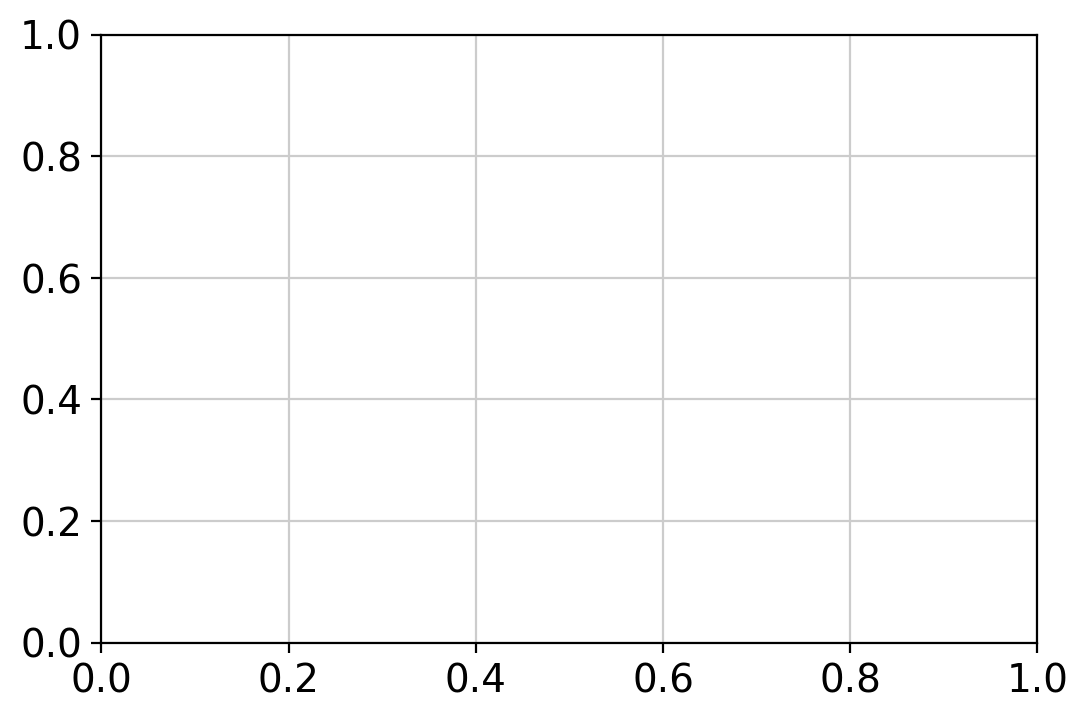

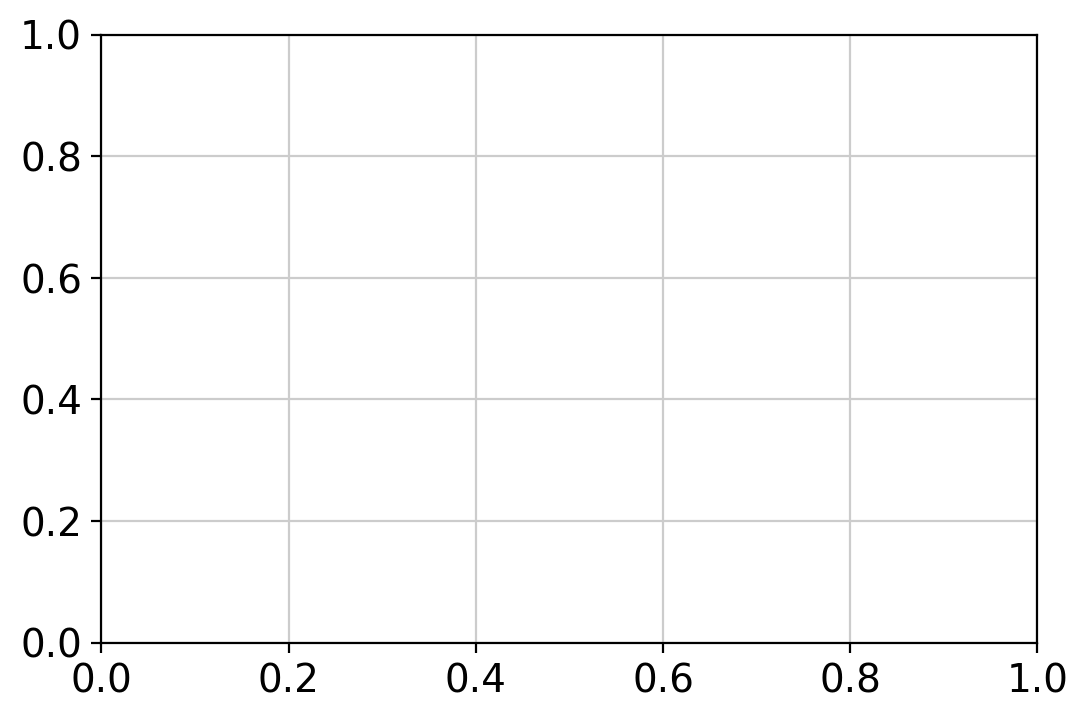

In [236]:
adata7=preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5",
    cells_parquet_url="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet",
    core_info_dir= "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region1", # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)
    boundaries_parquet_url="",
    # --- 출력 및 기본 설정 ---
    output_prefix = "processed_xenium_CRC_BJM1_S2R1_final", # 출력 파일명 접두사
    sample_id = "CRC_BJM1_S2R1_fix3" # 샘플 ID 지정
)

## multiple samples

In [254]:
urls={"S1R1":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region1"],
"S1R2":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region2"],
"S1R3":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region3"],
"S1R4":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region4"],
"S1R5":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region5"],
"S1R6":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide1(0050568)_Region6"],
"S2R1":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region1"],
"S2R2":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region2"],
"S2R3":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region3"],
"S2R4":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region4"],
"S2R5":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region5"],
"S2R6":["/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cell_feature_matrix.h5",
        "/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet",
        "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region6"]}

2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,119 [INFO] Starting Xenium data preprocessing pipeline.
2025-04-18 18:37:11,130 - INFO - Output prefix set to: processed_xenium_CRC_BJM1_S1R1
2025-04-18 18:37:11,130 - INFO - Output prefix set to: processed_xenium_CRC_BJM1_S1R1
2025-04-18 18:37:11,130 - INFO - Output prefix set to: processed_xenium_CRC_BJM1_S1R1
2025-04-18 18:37:11,130 - INFO - Output pr

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cell_feature_matrix.h5
 (0:00:00)


2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet
2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet
2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet
2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet
2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet
2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_1__20250205__113422/cells.parquet
2025-04-18 18:37:12,137 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:37:15,673 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 328 cells that have less than 3 genes expressed


2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 - INFO - Cells to remove based on min_genes (3): 328
2025-04-18 18:37:15,763 [INFO] Cells to remove based on min_genes (3): 328


filtered out 994 cells that have less than 10 counts


2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 - INFO - Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,780 [INFO] Cells to remove based on min_counts (10): 994
2025-04-18 18:37:15,790 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:37:15,790 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:37:15,790 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:37:15,790 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:37:17,378 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:37:17,388 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:37:17,388 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:37:17,388 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:37:17,388 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 - INFO - Applying log1p transformation.
2025-04-18 18:37:17,499 [INFO] Applying log1p transformation.
2025-04-18 18:37:17,566 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:37:17,566 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:37:17,566 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:37:17,566 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:37:17,566 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:37:17,860 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:37:20,025 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:05)


2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,004 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:37:26,019 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:37:26,019 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 - INFO - --- Step 9: Clustering ---
2025-04-18 18:37:32,914 [INFO] --- Step 9: Clustering ---
2025-04-18 18:37:32,922 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:37:32,922 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:37:32,922 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 22 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:38)


2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:38:11,360 - INFO - Found 22

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:36)


2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:38:47,859 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:35)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cell_feature_matrix.h5
 (0:00:00)


2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet
2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet
2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet
2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet
2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet
2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_2__20250205__113422/cells.parquet
2025-04-18 18:39:42,050 - INFO - Reading cells parquet file: /da

filtered out 3 genes that are detected in less than 3 cells


2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 - INFO - Filtered genes: 3 genes removed (< 3 cells).
2025-04-18 18:39:44,962 [INFO] Filtered genes: 3 genes removed (< 3 cells).


filtered out 235 cells that have less than 3 genes expressed


2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 - INFO - Cells to remove based on min_genes (3): 235
2025-04-18 18:39:45,026 [INFO] Cells to remove based on min_genes (3): 235


filtered out 648 cells that have less than 10 counts


2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 - INFO - Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,042 [INFO] Cells to remove based on min_counts (10): 648
2025-04-18 18:39:45,052 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:39:45,052 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:39:45,052 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:39:45,052 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:39:46,335 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:39:46,342 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:39:46,342 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:39:46,342 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:39:46,342 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 - INFO - Applying log1p transformation.
2025-04-18 18:39:46,411 [INFO] Applying log1p transformation.
2025-04-18 18:39:46,464 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:39:46,464 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:39:46,464 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:39:46,464 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:39:46,464 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:39:46,691 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:39:48,317 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:04)


2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,673 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:39:52,689 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:39:52,689 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 - INFO - --- Step 9: Clustering ---
2025-04-18 18:39:57,800 [INFO] --- Step 9: Clustering ---
2025-04-18 18:39:57,808 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:39:57,808 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:39:57,808 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 21 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:32)


2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:40:30,089 - INFO - Found 21

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)


2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R2_umap_clusters_leiden_res0.8.png
2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R2_umap_clusters_leiden_res0.8.png
2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R2_umap_clusters_leiden_res0.8.png
2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R2_umap_clusters_leiden_res0.8.png
2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R2_umap_clusters_leiden_res0.8.png
2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R2_umap_clusters_leiden_res0.8.png
2025-04-18 18:40:54,079 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:49)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet
2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet
2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet
2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet
2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet
2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_3__20250205__113422/cells.parquet
2025-04-18 18:41:57,806 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:42:02,413 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 273 cells that have less than 3 genes expressed


2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 - INFO - Cells to remove based on min_genes (3): 273
2025-04-18 18:42:02,626 [INFO] Cells to remove based on min_genes (3): 273


filtered out 988 cells that have less than 10 counts


2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 - INFO - Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,651 [INFO] Cells to remove based on min_counts (10): 988
2025-04-18 18:42:02,661 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:42:02,661 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:42:02,661 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:42:02,661 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:42:04,928 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:42:04,935 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:42:04,935 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:42:04,935 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:42:04,935 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 - INFO - Applying log1p transformation.
2025-04-18 18:42:05,155 [INFO] Applying log1p transformation.
2025-04-18 18:42:05,290 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:42:05,290 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:42:05,290 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:42:05,290 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:42:05,290 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:42:05,937 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:42:16,391 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:12)


2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,765 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:42:28,782 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:42:28,782 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 - INFO - --- Step 9: Clustering ---
2025-04-18 18:42:37,133 [INFO] --- Step 9: Clustering ---
2025-04-18 18:42:37,138 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:42:37,138 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:42:37,138 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 17 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:01:07)


2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:43:44,774 - INFO - Found 17

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:47)


2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R3_umap_clusters_leiden_res0.8.png
2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R3_umap_clusters_leiden_res0.8.png
2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R3_umap_clusters_leiden_res0.8.png
2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R3_umap_clusters_leiden_res0.8.png
2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R3_umap_clusters_leiden_res0.8.png
2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R3_umap_clusters_leiden_res0.8.png
2025-04-18 18:44:33,029 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:48)


2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,415 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:45:28,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet
2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet
2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet
2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet
2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet
2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_4__20250205__113422/cells.parquet
2025-04-18 18:45:49,105 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:45:53,534 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 249 cells that have less than 3 genes expressed


2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 - INFO - Cells to remove based on min_genes (3): 249
2025-04-18 18:45:53,700 [INFO] Cells to remove based on min_genes (3): 249


filtered out 1123 cells that have less than 10 counts


2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 - INFO - Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,722 [INFO] Cells to remove based on min_counts (10): 1123
2025-04-18 18:45:53,733 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:45:53,733 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:45:53,733 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:45:53,733 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:45:55,832 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:45:55,840 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:45:55,840 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:45:55,840 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:45:55,840 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 - INFO - Applying log1p transformation.
2025-04-18 18:45:56,040 [INFO] Applying log1p transformation.
2025-04-18 18:45:56,163 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:45:56,163 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:45:56,163 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:45:56,163 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:45:56,163 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:45:56,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:46:00,246 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:06)


2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,573 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:46:06,590 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:46:06,590 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 - INFO - --- Step 9: Clustering ---
2025-04-18 18:46:14,922 [INFO] --- Step 9: Clustering ---
2025-04-18 18:46:14,929 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:46:14,929 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:46:14,929 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 16 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:01:20)


2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:47:35,239 - INFO - Found 16

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:45)


2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R4_umap_clusters_leiden_res0.8.png
2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R4_umap_clusters_leiden_res0.8.png
2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R4_umap_clusters_leiden_res0.8.png
2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R4_umap_clusters_leiden_res0.8.png
2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R4_umap_clusters_leiden_res0.8.png
2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R4_umap_clusters_leiden_res0.8.png
2025-04-18 18:48:21,247 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:29)


2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,533 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:49:57,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet
2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet
2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet
2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet
2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet
2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_5__20250205__113422/cells.parquet
2025-04-18 18:50:16,276 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:50:20,692 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 233 cells that have less than 3 genes expressed


2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 - INFO - Cells to remove based on min_genes (3): 233
2025-04-18 18:50:20,840 [INFO] Cells to remove based on min_genes (3): 233


filtered out 902 cells that have less than 10 counts


2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 - INFO - Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,862 [INFO] Cells to remove based on min_counts (10): 902
2025-04-18 18:50:20,872 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:50:20,872 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:50:20,872 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:50:20,872 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:50:22,731 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:50:22,738 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:50:22,738 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:50:22,738 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:50:22,738 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 - INFO - Applying log1p transformation.
2025-04-18 18:50:22,916 [INFO] Applying log1p transformation.
2025-04-18 18:50:23,026 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:50:23,026 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:50:23,026 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:50:23,026 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:50:23,026 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:50:23,499 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:50:26,473 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:05)


2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,417 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:50:32,440 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:50:32,440 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 - INFO - --- Step 9: Clustering ---
2025-04-18 18:50:39,759 [INFO] --- Step 9: Clustering ---
2025-04-18 18:50:39,767 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:50:39,767 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:50:39,767 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 16 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:01:05)


2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:51:45,081 - INFO - Found 16

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:36)


2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R5_umap_clusters_leiden_res0.8.png
2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R5_umap_clusters_leiden_res0.8.png
2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R5_umap_clusters_leiden_res0.8.png
2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R5_umap_clusters_leiden_res0.8.png
2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R5_umap_clusters_leiden_res0.8.png
2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R5_umap_clusters_leiden_res0.8.png
2025-04-18 18:52:21,991 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:15)


2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,531 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:53:42,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cell_feature_matrix.h5
 (0:00:00)


2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet
2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet
2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet
2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet
2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet
2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_6__20250205__113422/cells.parquet
2025-04-18 18:54:00,082 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:54:03,979 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 182 cells that have less than 3 genes expressed


2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 - INFO - Cells to remove based on min_genes (3): 182
2025-04-18 18:54:04,106 [INFO] Cells to remove based on min_genes (3): 182


filtered out 827 cells that have less than 10 counts


2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 - INFO - Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,126 [INFO] Cells to remove based on min_counts (10): 827
2025-04-18 18:54:04,136 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:54:04,136 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:54:04,136 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:54:04,136 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:54:05,863 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:54:05,870 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:54:05,870 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:54:05,870 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:54:05,870 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 - INFO - Applying log1p transformation.
2025-04-18 18:54:06,023 [INFO] Applying log1p transformation.
2025-04-18 18:54:06,115 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:54:06,115 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:54:06,115 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:54:06,115 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:54:06,115 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:54:06,507 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:54:09,038 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:04)


2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:13,998 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:54:14,013 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:54:14,013 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 - INFO - --- Step 9: Clustering ---
2025-04-18 18:54:20,612 [INFO] --- Step 9: Clustering ---
2025-04-18 18:54:20,619 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:54:20,619 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:54:20,619 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 17 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:38)


2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:54:58,987 - INFO - Found 17

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:31)


2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R6_umap_clusters_leiden_res0.8.png
2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R6_umap_clusters_leiden_res0.8.png
2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R6_umap_clusters_leiden_res0.8.png
2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R6_umap_clusters_leiden_res0.8.png
2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R6_umap_clusters_leiden_res0.8.png
2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S1R6_umap_clusters_leiden_res0.8.png
2025-04-18 18:55:30,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:04)


2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,107 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 18:56:40,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_7__20250205__113422/cell_feature_matrix.h5


2025-04-18 18:56:53,305 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_7__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 18:56:53,305 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_7__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 18:56:53,305 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_7__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 18:56:53,305 - ERROR - Fil

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_8__20250205__113422/cell_feature_matrix.h5


2025-04-18 18:56:53,362 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_8__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 18:56:53,362 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_8__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 18:56:53,362 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050586__Region_8__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 18:56:53,362 - ERROR - Fil

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet
2025-04-18 18:56:54,861 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 18:56:58,552 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 208 cells that have less than 3 genes expressed


2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 - INFO - Cells to remove based on min_genes (3): 208
2025-04-18 18:56:58,663 [INFO] Cells to remove based on min_genes (3): 208


filtered out 593 cells that have less than 10 counts


2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 - INFO - Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,682 [INFO] Cells to remove based on min_counts (10): 593
2025-04-18 18:56:58,692 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:56:58,692 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:56:58,692 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 18:56:58,692 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 - INFO - Saved log-normalized data to adata.raw
2025-04-18 18:57:00,454 [INFO] Saved log-normalized data to adata.raw
2025-04-18 18:57:00,461 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:57:00,461 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:57:00,461 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 18:57:00,461 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 - INFO - Applying log1p transformation.
2025-04-18 18:57:00,598 [INFO] Applying log1p transformation.
2025-04-18 18:57:00,677 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:57:00,677 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:57:00,677 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:57:00,677 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 18:57:00,677 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 18:57:01,026 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 18:57:03,616 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:06)


2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,947 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 18:57:09,963 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 18:57:09,963 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 - INFO - --- Step 9: Clustering ---
2025-04-18 18:57:17,784 [INFO] --- Step 9: Clustering ---
2025-04-18 18:57:17,792 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:57:17,792 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 18:57:17,792 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering


IOStream.flush timed out


    finished: found 20 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:01:27)


2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 18:58:44,931 - INFO - Found 20

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:38)


2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R1_umap_clusters_leiden_res0.8.png
2025-04-18 18:59:23,782 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:12)


2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,045 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:00:41,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cell_feature_matrix.h5
 (0:00:00)


2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet
2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet
2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet
2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet
2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet
2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_2__20250205__113422/cells.parquet
2025-04-18 19:00:55,876 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:00:58,819 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 234 cells that have less than 3 genes expressed


2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 - INFO - Cells to remove based on min_genes (3): 234
2025-04-18 19:00:58,877 [INFO] Cells to remove based on min_genes (3): 234


filtered out 677 cells that have less than 10 counts


2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 - INFO - Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,894 [INFO] Cells to remove based on min_counts (10): 677
2025-04-18 19:00:58,903 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:00:58,903 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:00:58,903 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:00:58,903 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:01:00,180 [INFO] Saved log-normalized data to adata.raw
2025-04-18 19:01:00,188 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:01:00,188 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:01:00,188 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:01:00,188 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 - INFO - Applying log1p transformation.
2025-04-18 19:01:00,271 [INFO] Applying log1p transformation.
2025-04-18 19:01:00,325 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:01:00,325 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:01:00,325 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:01:00,325 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:01:00,325 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:01:00,548 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:01:02,159 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:03)


2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,137 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 19:01:06,157 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 19:01:06,157 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 - INFO - --- Step 9: Clustering ---
2025-04-18 19:01:11,792 [INFO] --- Step 9: Clustering ---
2025-04-18 19:01:11,801 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:01:11,801 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:01:11,801 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 21 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:38)


2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:01:49,945 - INFO - Found 21

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R2_umap_clusters_leiden_res0.8.png
2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R2_umap_clusters_leiden_res0.8.png
2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R2_umap_clusters_leiden_res0.8.png
2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R2_umap_clusters_leiden_res0.8.png
2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R2_umap_clusters_leiden_res0.8.png
2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R2_umap_clusters_leiden_res0.8.png
2025-04-18 19:02:12,706 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet
2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet
2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet
2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet
2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet
2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_3__20250205__113422/cells.parquet
2025-04-18 19:03:14,270 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:03:18,992 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 409 cells that have less than 3 genes expressed


2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 - INFO - Cells to remove based on min_genes (3): 409
2025-04-18 19:03:19,220 [INFO] Cells to remove based on min_genes (3): 409


filtered out 1402 cells that have less than 10 counts


2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 - INFO - Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,246 [INFO] Cells to remove based on min_counts (10): 1402
2025-04-18 19:03:19,257 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:03:19,257 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:03:19,257 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:03:19,257 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:03:21,597 [INFO] Saved log-normalized data to adata.raw
2025-04-18 19:03:21,604 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:03:21,604 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:03:21,604 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:03:21,604 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 - INFO - Applying log1p transformation.
2025-04-18 19:03:21,838 [INFO] Applying log1p transformation.
2025-04-18 19:03:21,983 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:03:21,983 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:03:21,983 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:03:21,983 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:03:21,983 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:03:22,611 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:03:26,625 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:06)


2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:32,984 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 19:03:33,006 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 19:03:33,006 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 - INFO - --- Step 9: Clustering ---
2025-04-18 19:03:42,625 [INFO] --- Step 9: Clustering ---
2025-04-18 19:03:42,633 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:03:42,633 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:03:42,633 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 17 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:01:20)


2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:05:03,504 - INFO - Found 17

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:52)


2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R3_umap_clusters_leiden_res0.8.png
2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R3_umap_clusters_leiden_res0.8.png
2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R3_umap_clusters_leiden_res0.8.png
2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R3_umap_clusters_leiden_res0.8.png
2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R3_umap_clusters_leiden_res0.8.png
2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R3_umap_clusters_leiden_res0.8.png
2025-04-18 19:05:56,148 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:37)


2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,119 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:07:40,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet
2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet
2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet
2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet
2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet
2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_4__20250205__113422/cells.parquet
2025-04-18 19:08:03,270 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:08:07,484 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 186 cells that have less than 3 genes expressed


2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 - INFO - Cells to remove based on min_genes (3): 186
2025-04-18 19:08:07,677 [INFO] Cells to remove based on min_genes (3): 186


filtered out 894 cells that have less than 10 counts


2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 - INFO - Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,701 [INFO] Cells to remove based on min_counts (10): 894
2025-04-18 19:08:07,711 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:08:07,711 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:08:07,711 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:08:07,711 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:08:09,820 [INFO] Saved log-normalized data to adata.raw
2025-04-18 19:08:09,828 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:08:09,828 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:08:09,828 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:08:09,828 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 - INFO - Applying log1p transformation.
2025-04-18 19:08:10,028 [INFO] Applying log1p transformation.
2025-04-18 19:08:10,149 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:08:10,149 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:08:10,149 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:08:10,149 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:08:10,149 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:08:10,696 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:08:13,894 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:05)


2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,437 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 19:08:19,458 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 19:08:19,458 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 - INFO - --- Step 9: Clustering ---
2025-04-18 19:08:28,045 [INFO] --- Step 9: Clustering ---
2025-04-18 19:08:28,053 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:08:28,053 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:08:28,053 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 19 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:55)


2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:09:23,893 - INFO - Found 19

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:44)


/tmp/ipykernel_140850/1217880924.py:872: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(7, 6))
2025-04-18 19:10:08,952 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R4_umap_clusters_leiden_res0.8.png
2025-04-18 19:10:08,952 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R4_umap_clusters_leiden_res0.8.png
2025-04-18 19:10:08,952 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R4_umap_clusters_leiden_res0.8.png
2025-04-18 19:10:08,952 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R4_umap_clusters_leiden_re

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:22)


2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,583 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:11:37,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cell_feature_matrix.h5
 (0:00:00)


2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet
2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet
2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet
2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet
2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet
2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_5__20250205__113422/cells.parquet
2025-04-18 19:11:56,014 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:11:59,522 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 315 cells that have less than 3 genes expressed


2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 - INFO - Cells to remove based on min_genes (3): 315
2025-04-18 19:11:59,631 [INFO] Cells to remove based on min_genes (3): 315


filtered out 1225 cells that have less than 10 counts


2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 - INFO - Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,654 [INFO] Cells to remove based on min_counts (10): 1225
2025-04-18 19:11:59,665 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:11:59,665 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:11:59,665 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:11:59,665 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:12:01,281 [INFO] Saved log-normalized data to adata.raw
2025-04-18 19:12:01,289 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:12:01,289 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:12:01,289 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:12:01,289 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 - INFO - Applying log1p transformation.
2025-04-18 19:12:01,416 [INFO] Applying log1p transformation.
2025-04-18 19:12:01,492 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:12:01,492 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:12:01,492 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:12:01,492 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:12:01,492 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:12:01,880 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:12:03,983 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:04)


2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,917 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 19:12:08,936 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 19:12:08,936 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 - INFO - --- Step 9: Clustering ---
2025-04-18 19:12:16,527 [INFO] --- Step 9: Clustering ---
2025-04-18 19:12:16,536 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:12:16,536 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:12:16,536 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 18 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:26)


2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:12:42,830 - INFO - Found 18

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:38)


2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R5_umap_clusters_leiden_res0.8.png
2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R5_umap_clusters_leiden_res0.8.png
2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R5_umap_clusters_leiden_res0.8.png
2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R5_umap_clusters_leiden_res0.8.png
2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R5_umap_clusters_leiden_res0.8.png
2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R5_umap_clusters_leiden_res0.8.png
2025-04-18 19:13:21,574 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:03)


2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,296 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:14:30,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cell_feature_matrix.h5
 (0:00:01)


2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet
2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet
2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet
2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet
2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet
2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_6__20250205__113422/cells.parquet
2025-04-18 19:14:44,031 - INFO - Reading cells parquet file: /da

filtered out 1 genes that are detected in less than 3 cells


2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-18 19:14:48,080 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 142 cells that have less than 3 genes expressed


2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 - INFO - Cells to remove based on min_genes (3): 142
2025-04-18 19:14:48,251 [INFO] Cells to remove based on min_genes (3): 142


filtered out 458 cells that have less than 10 counts


2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 - INFO - Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,273 [INFO] Cells to remove based on min_counts (10): 458
2025-04-18 19:14:48,284 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:14:48,284 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:14:48,284 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-18 19:14:48,284 - INFO - Cells to rem

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 - INFO - Saved log-normalized data to adata.raw
2025-04-18 19:14:50,177 [INFO] Saved log-normalized data to adata.raw
2025-04-18 19:14:50,185 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:14:50,185 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:14:50,185 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-18 19:14:50,185 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 - INFO - Applying log1p transformation.
2025-04-18 19:14:50,362 [INFO] Applying log1p transformation.
2025-04-18 19:14:50,471 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:14:50,471 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:14:50,471 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:14:50,471 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-18 19:14:50,471 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-18 19:14:50,958 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-18 19:14:53,795 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:04)


2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,389 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-18 19:14:58,407 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-18 19:14:58,407 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 - INFO - --- Step 9: Clustering ---
2025-04-18 19:15:06,926 [INFO] --- Step 9: Clustering ---
2025-04-18 19:15:06,936 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:15:06,936 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-18 19:15:06,936 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 16 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:00:36)


2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-18 19:15:43,131 - INFO - Found 16

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:35)


2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R6_umap_clusters_leiden_res0.8.png
2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R6_umap_clusters_leiden_res0.8.png
2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R6_umap_clusters_leiden_res0.8.png
2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R6_umap_clusters_leiden_res0.8.png
2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R6_umap_clusters_leiden_res0.8.png
2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_CRC_BJM1_S2R6_umap_clusters_leiden_res0.8.png
2025-04-18 19:16:19,122 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to:

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:05)


2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,842 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-18 19:17:30,

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_7__20250205__113422/cell_feature_matrix.h5


2025-04-18 19:17:45,528 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_7__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 19:17:45,528 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_7__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 19:17:45,528 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_7__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 19:17:45,528 - ERROR - Fil

reading /data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_8__20250205__113422/cell_feature_matrix.h5


2025-04-18 19:17:45,581 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_8__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 19:17:45,581 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_8__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 19:17:45,581 - ERROR - File not found: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_8__20250205__113422/cell_feature_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Aborting.
2025-04-18 19:17:45,581 - ERROR - Fil

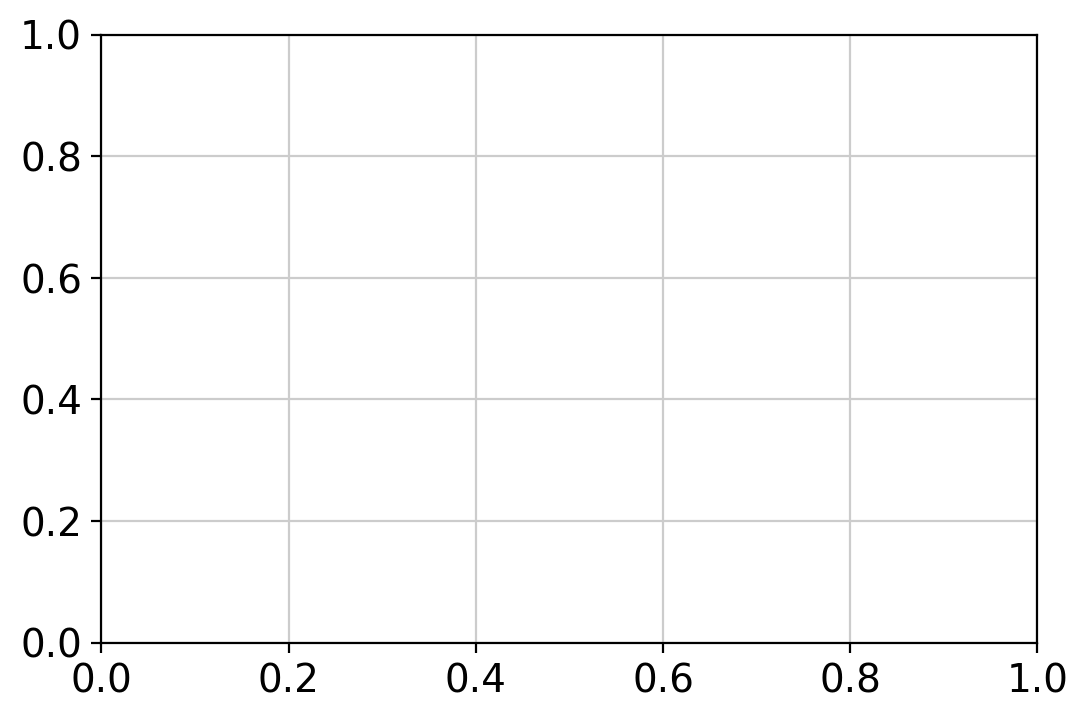

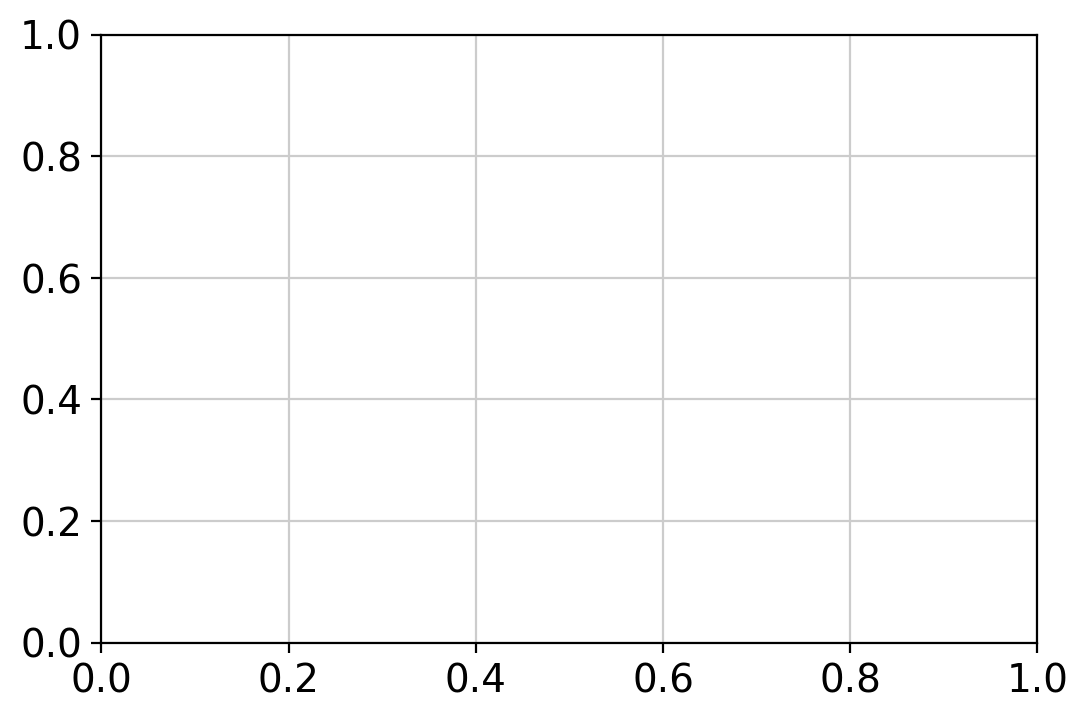

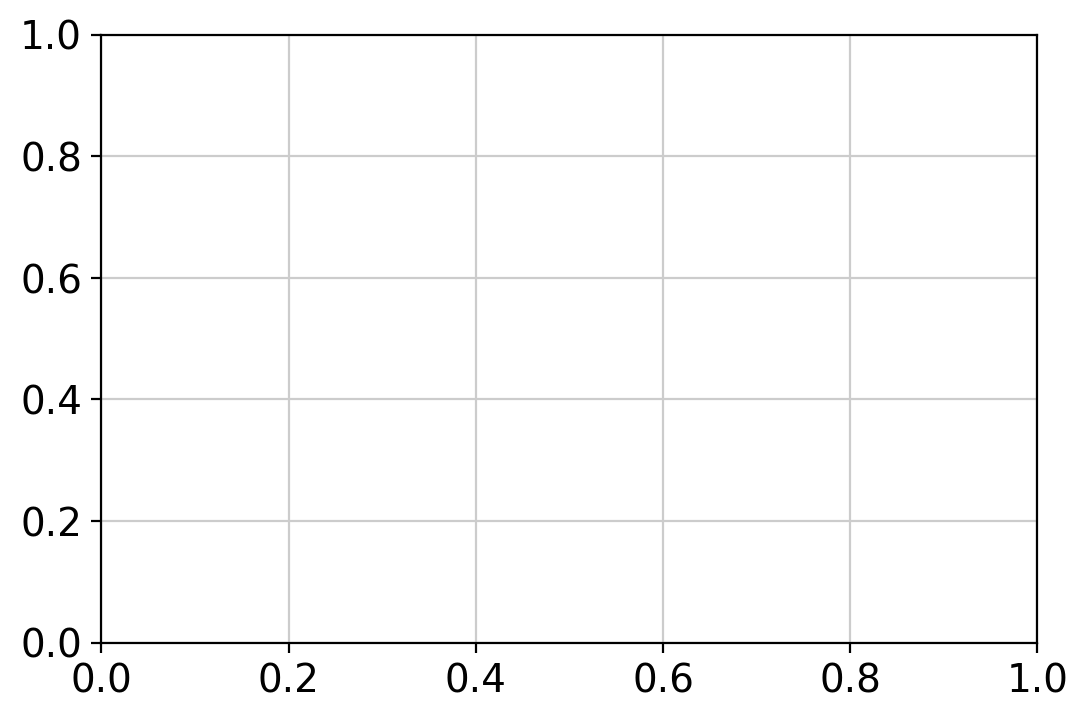

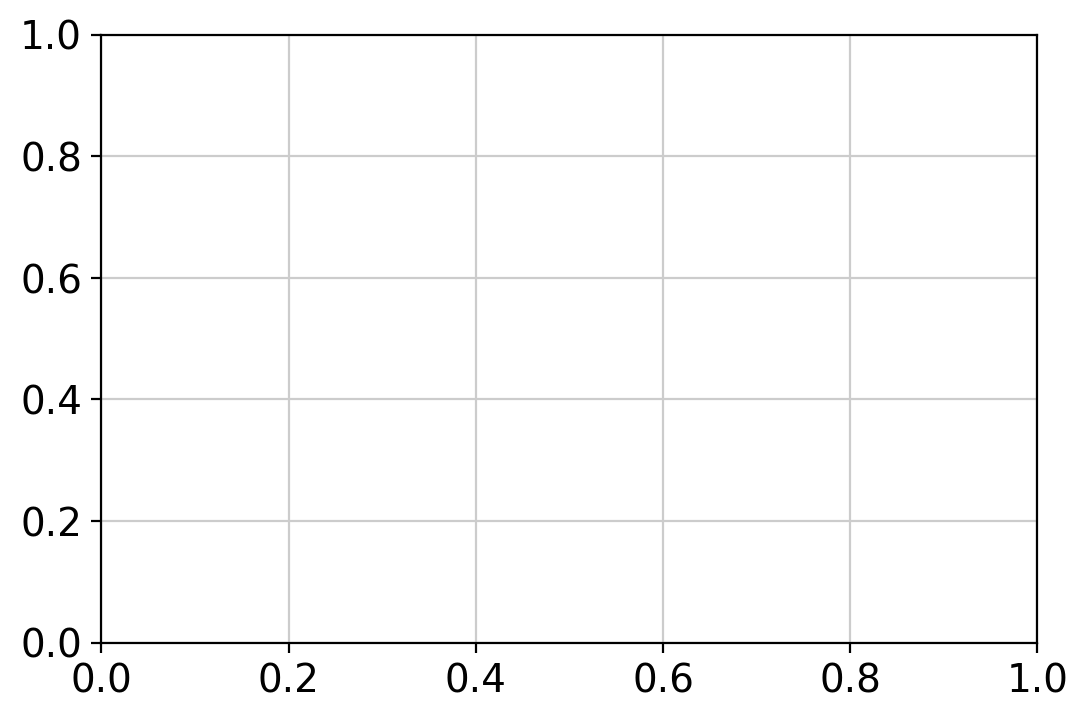

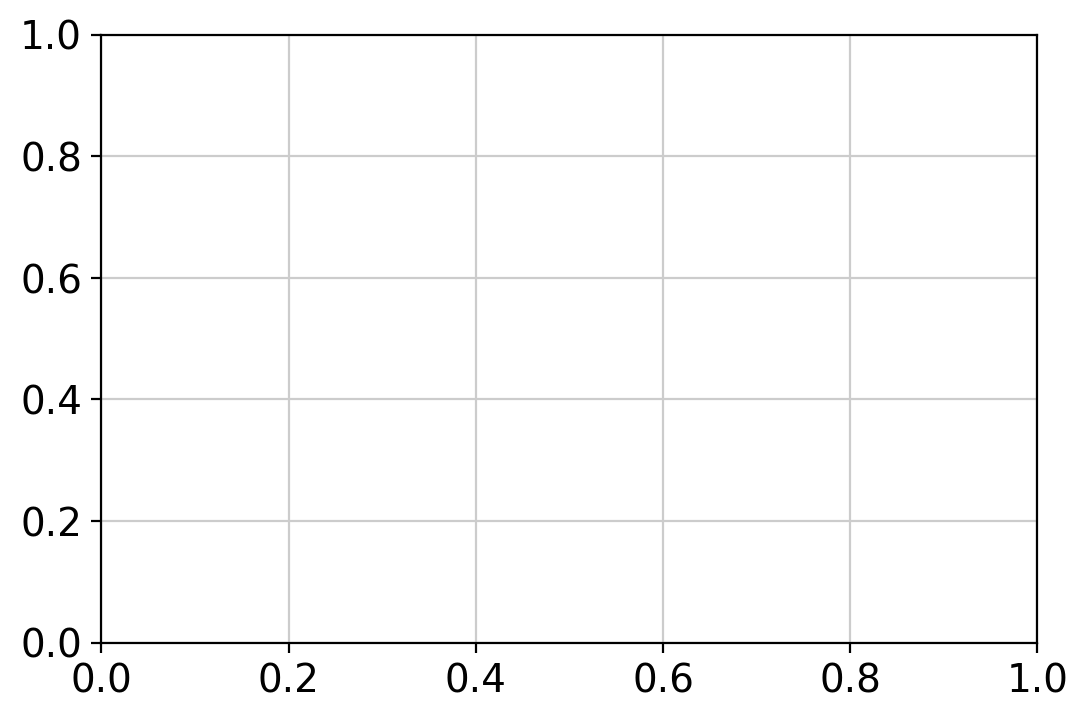

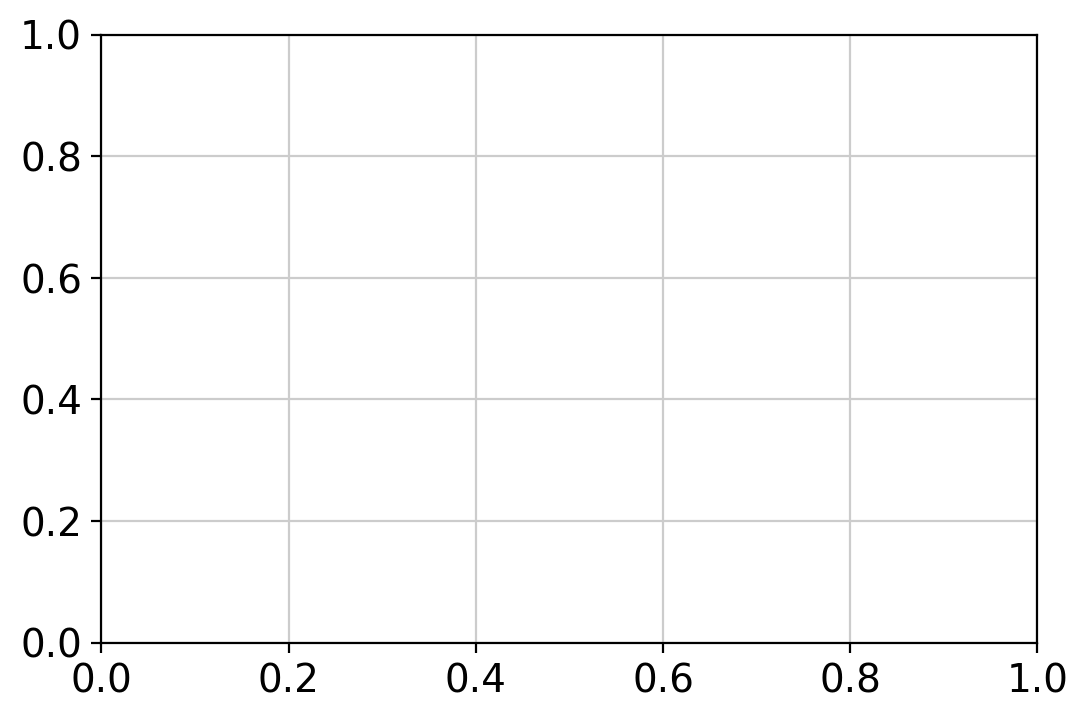

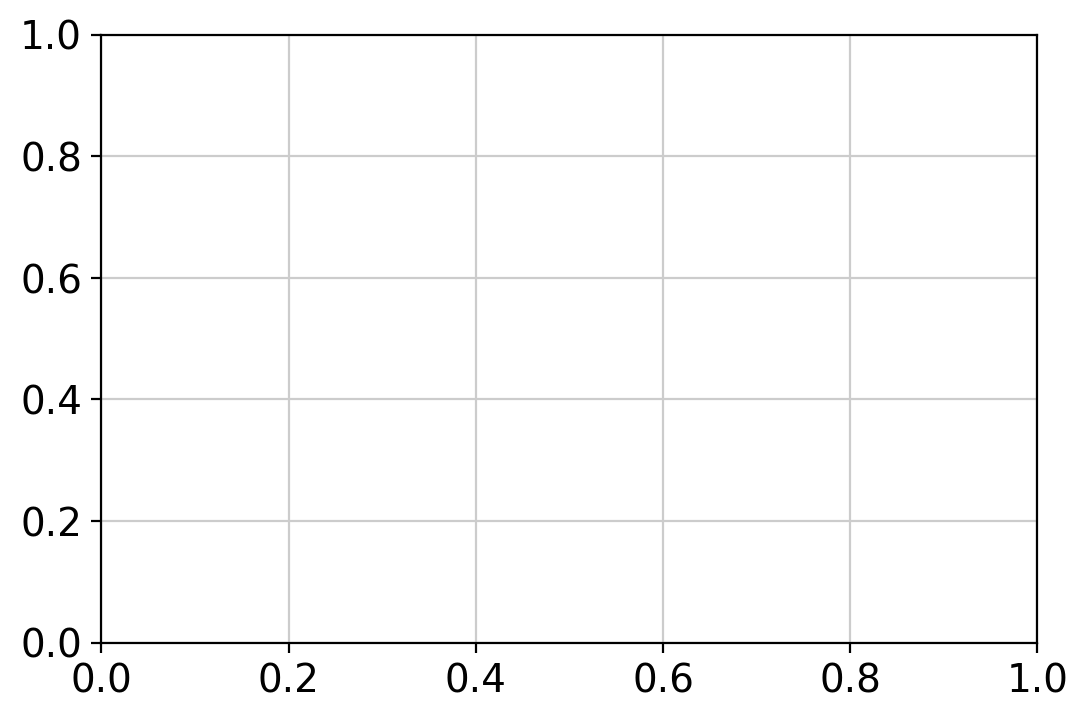

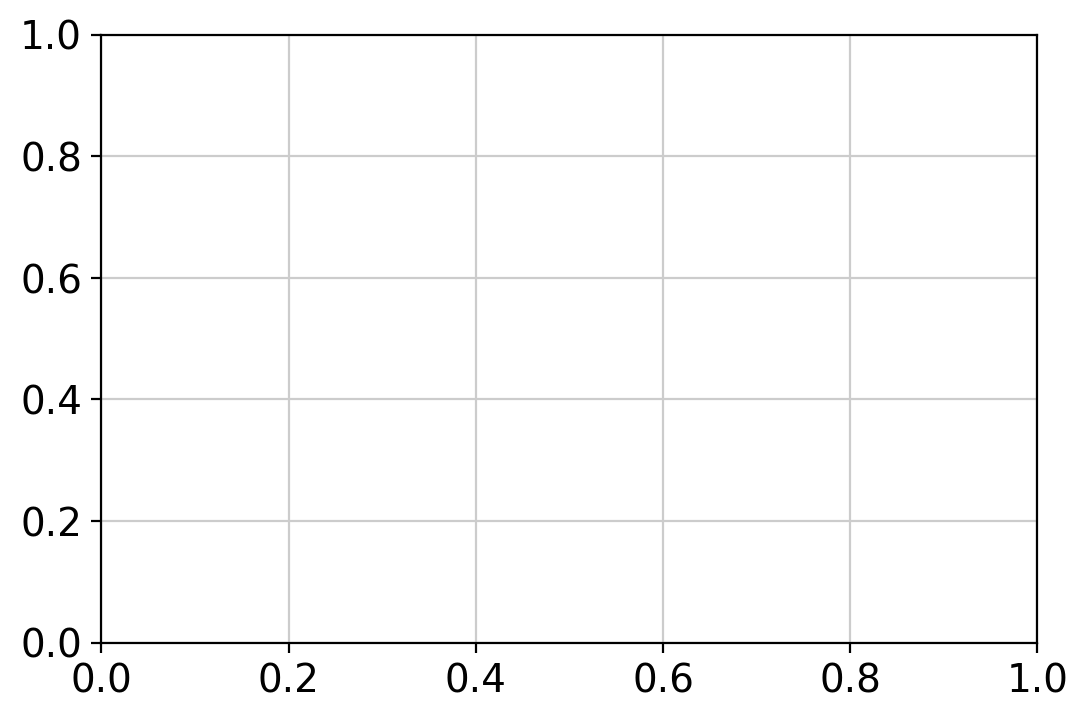

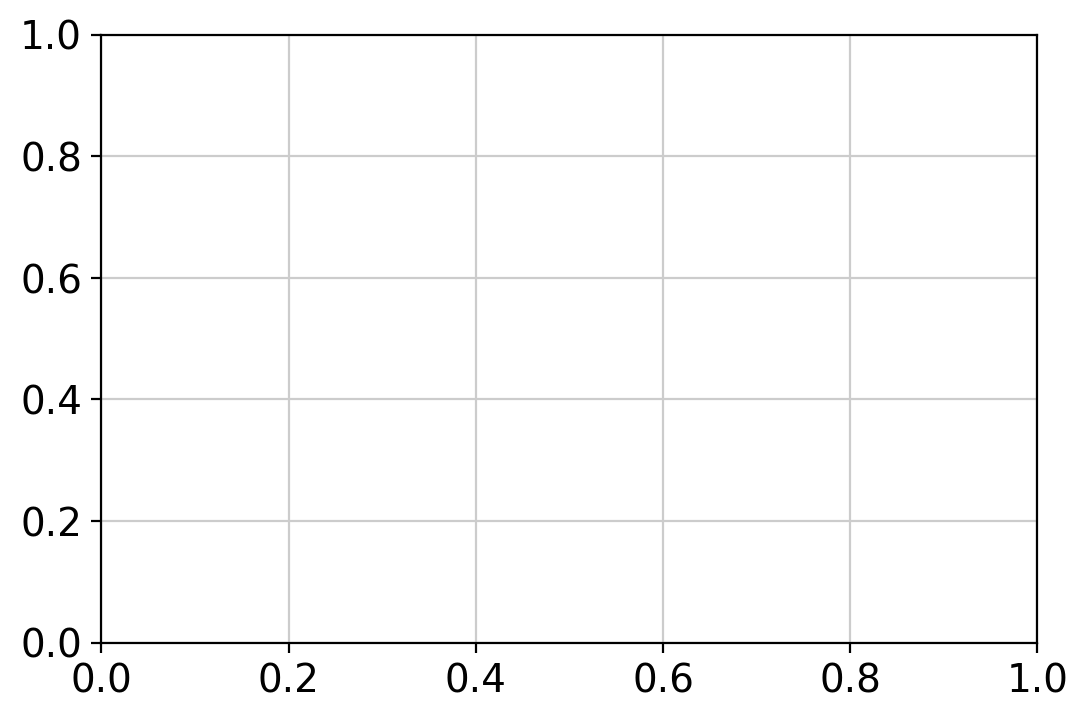

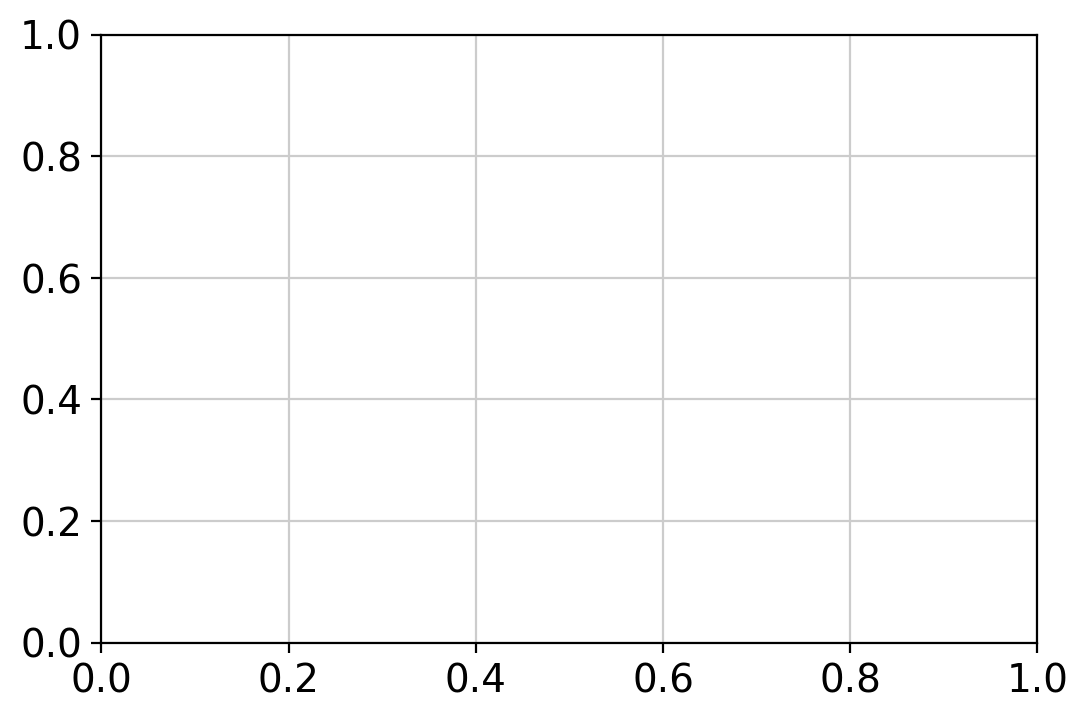

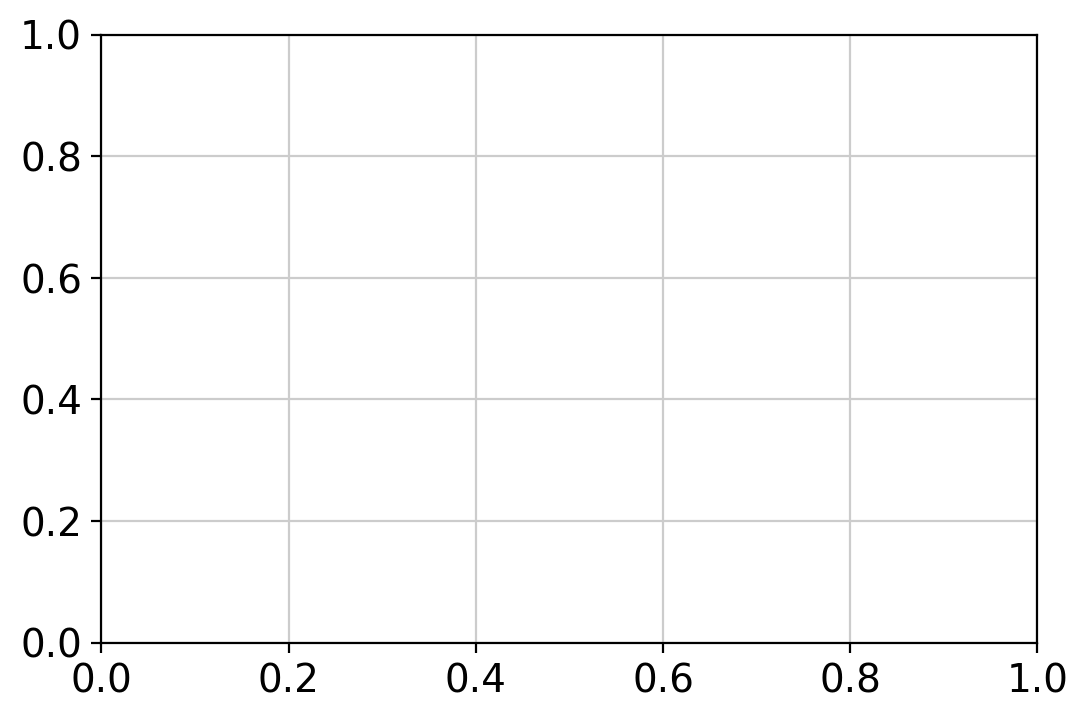

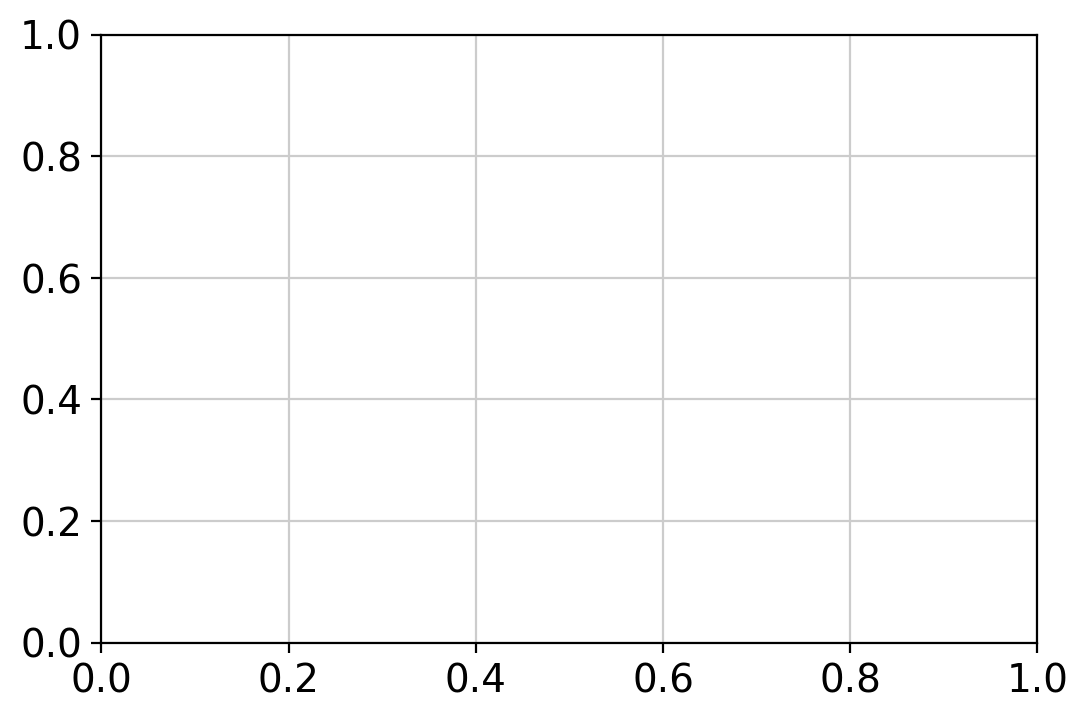

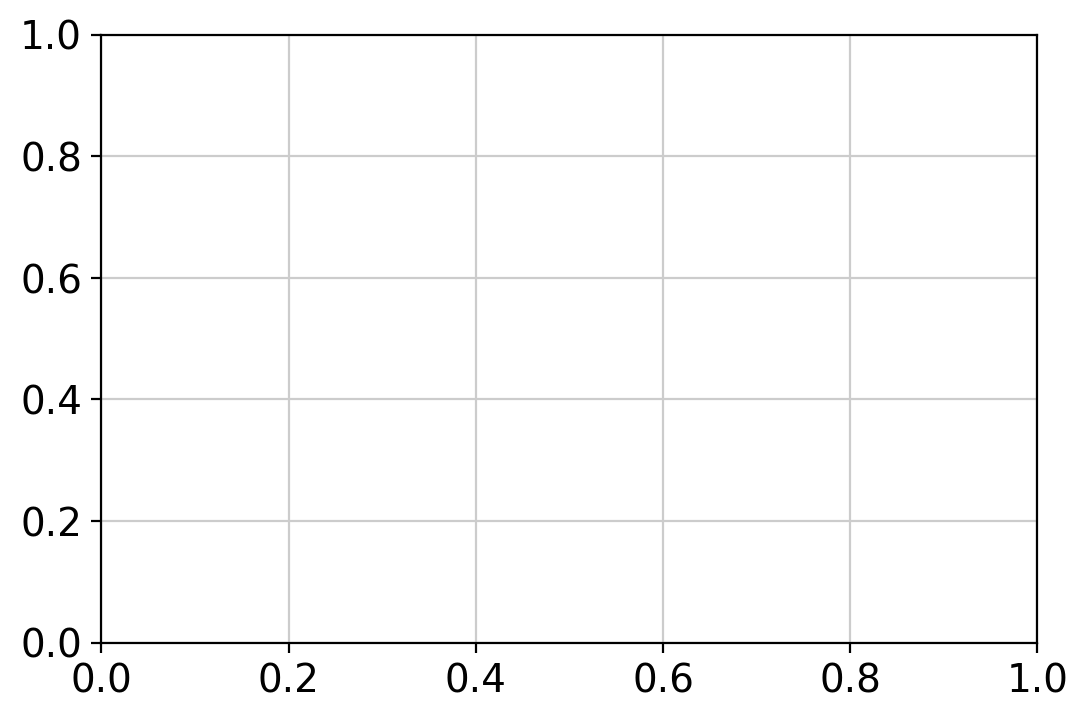

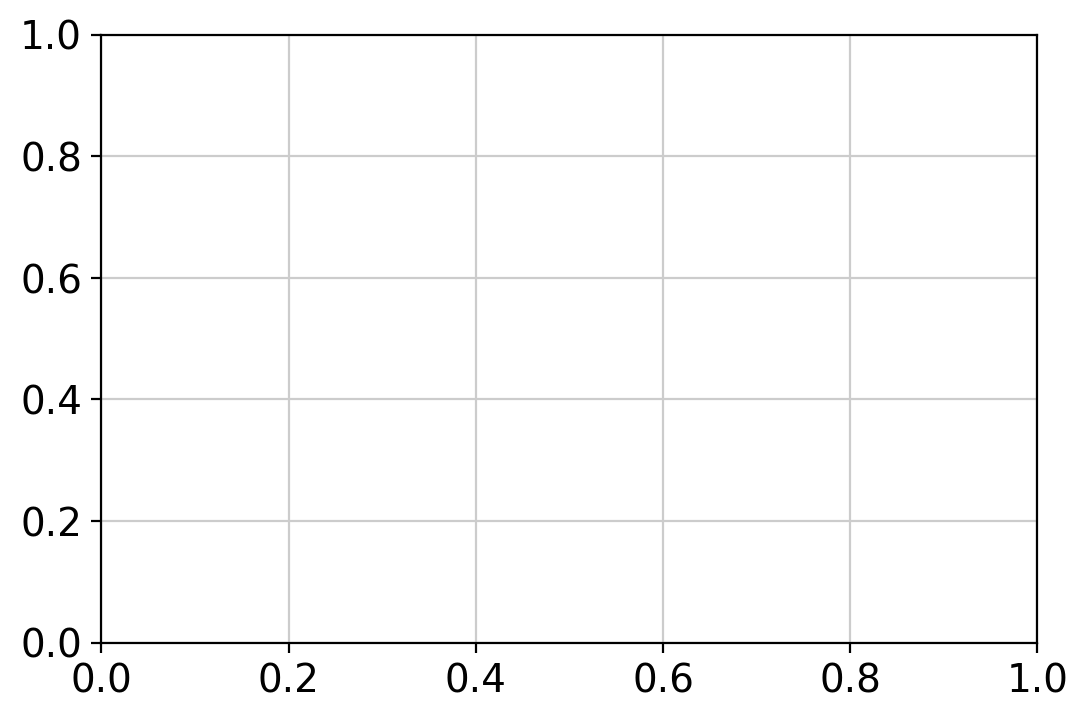

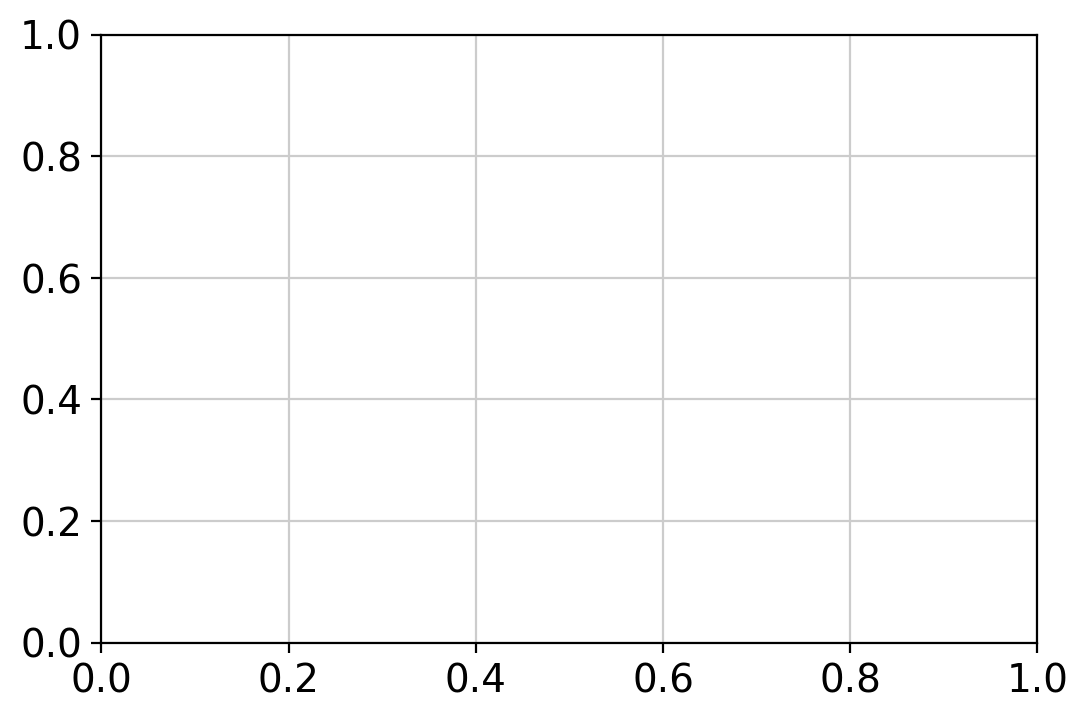

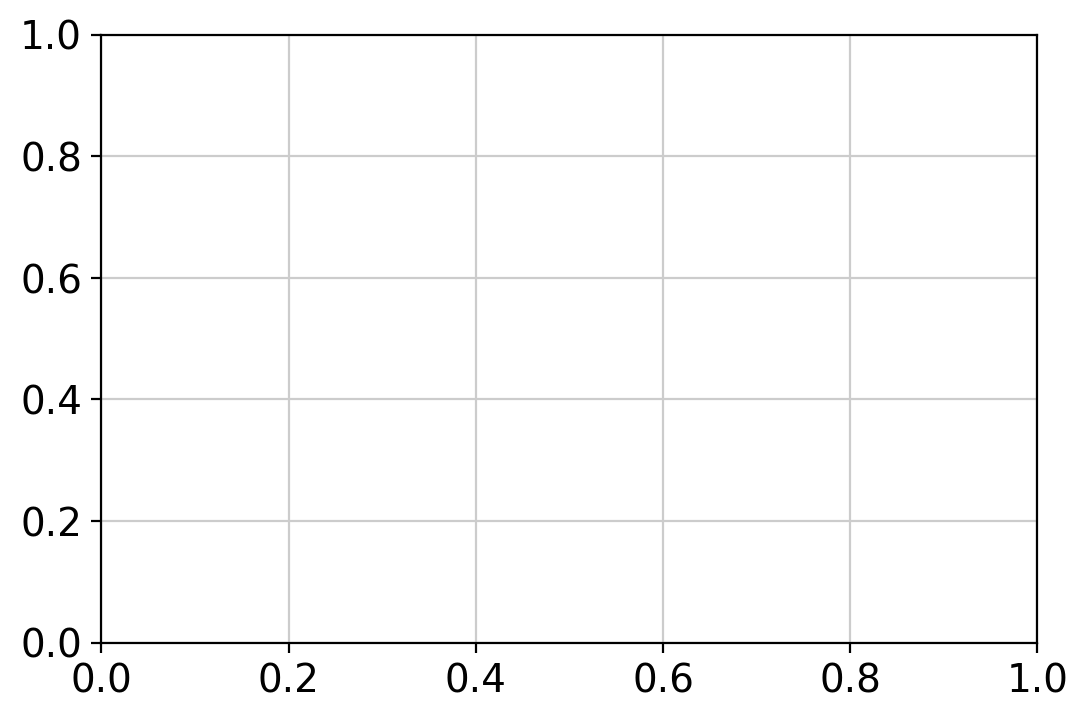

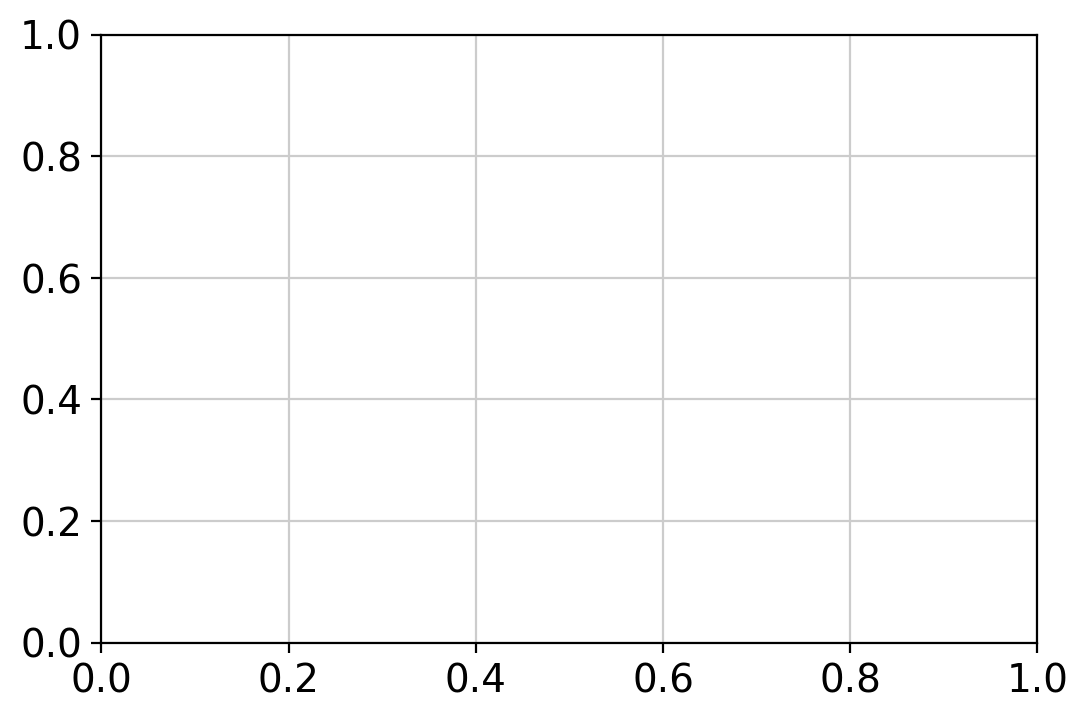

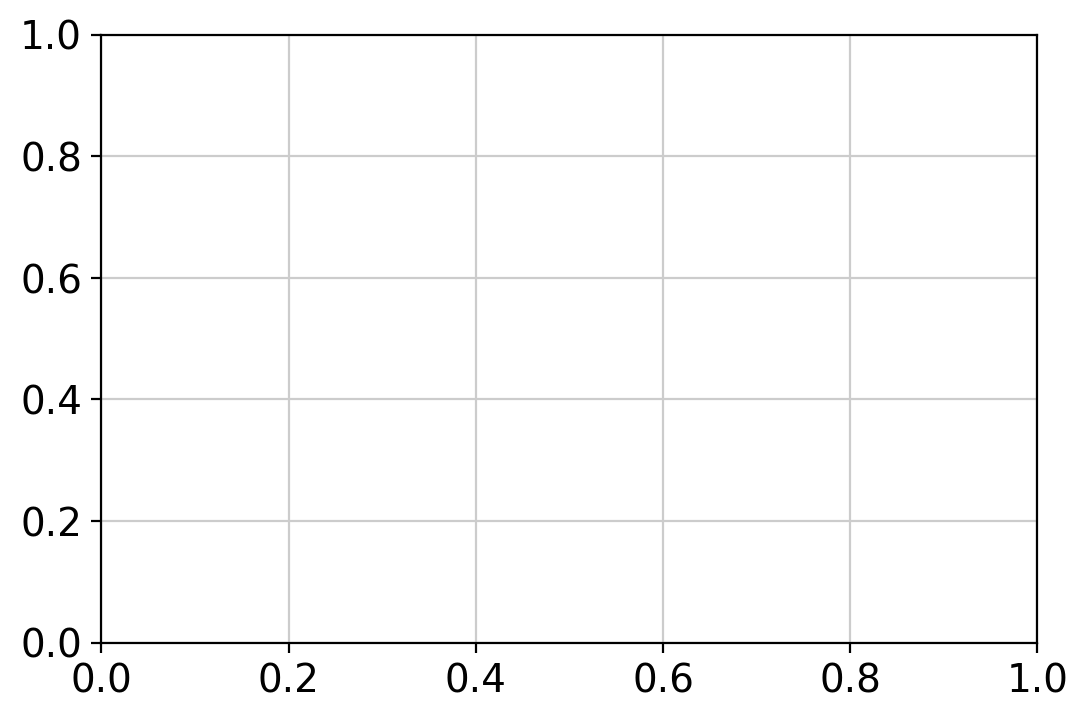

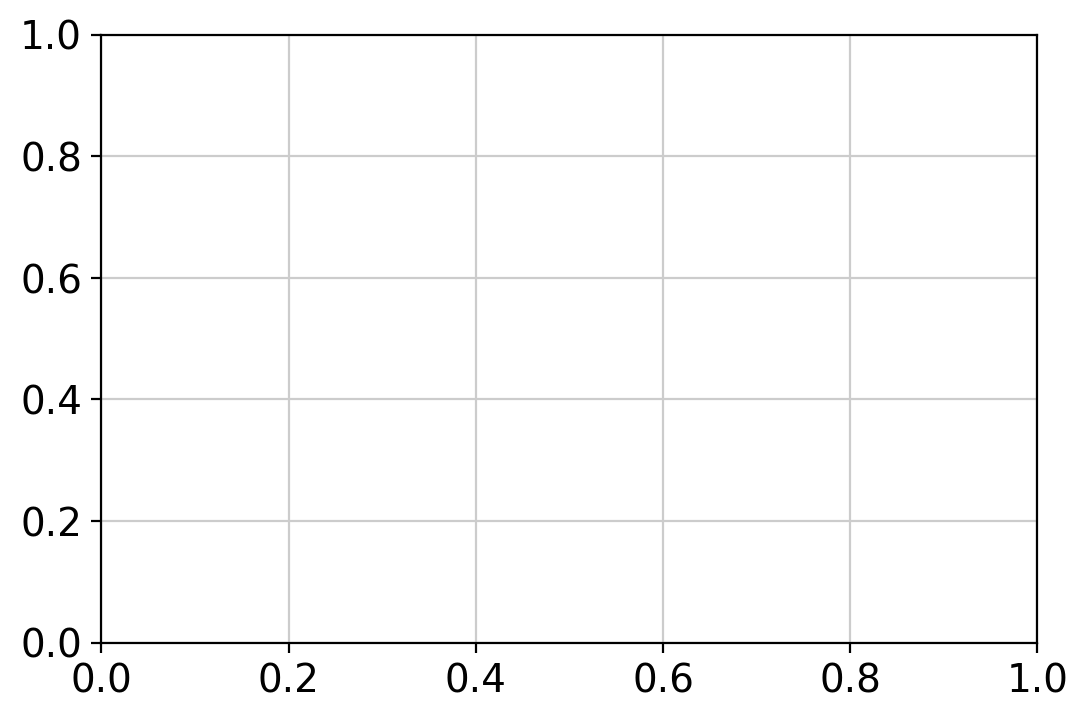

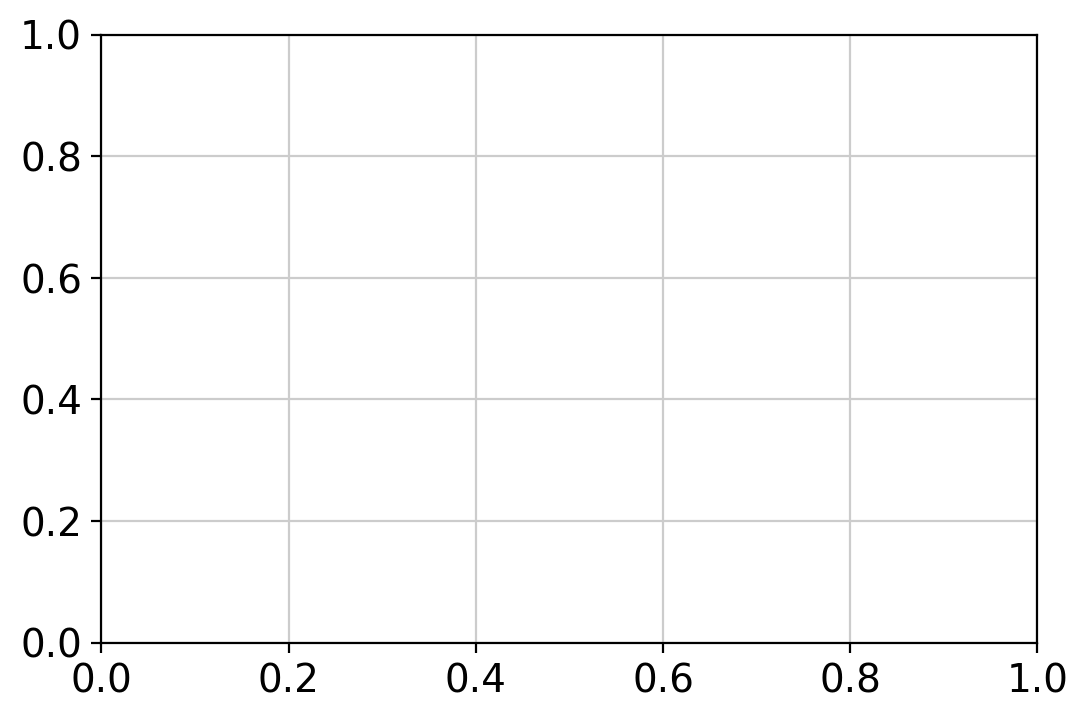

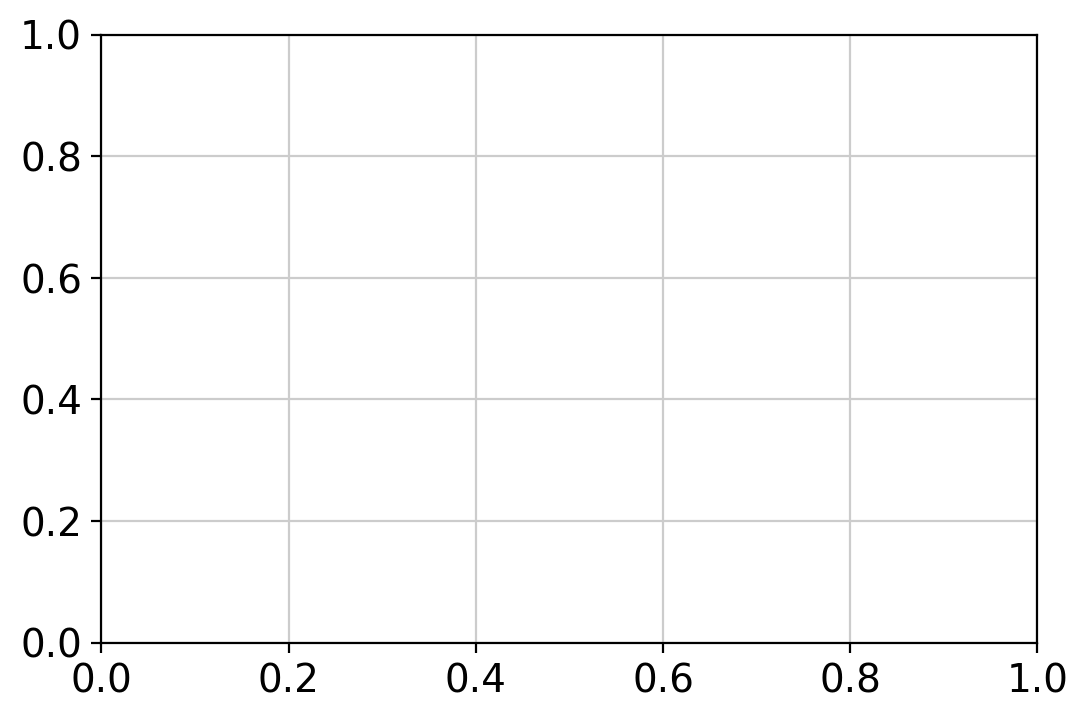

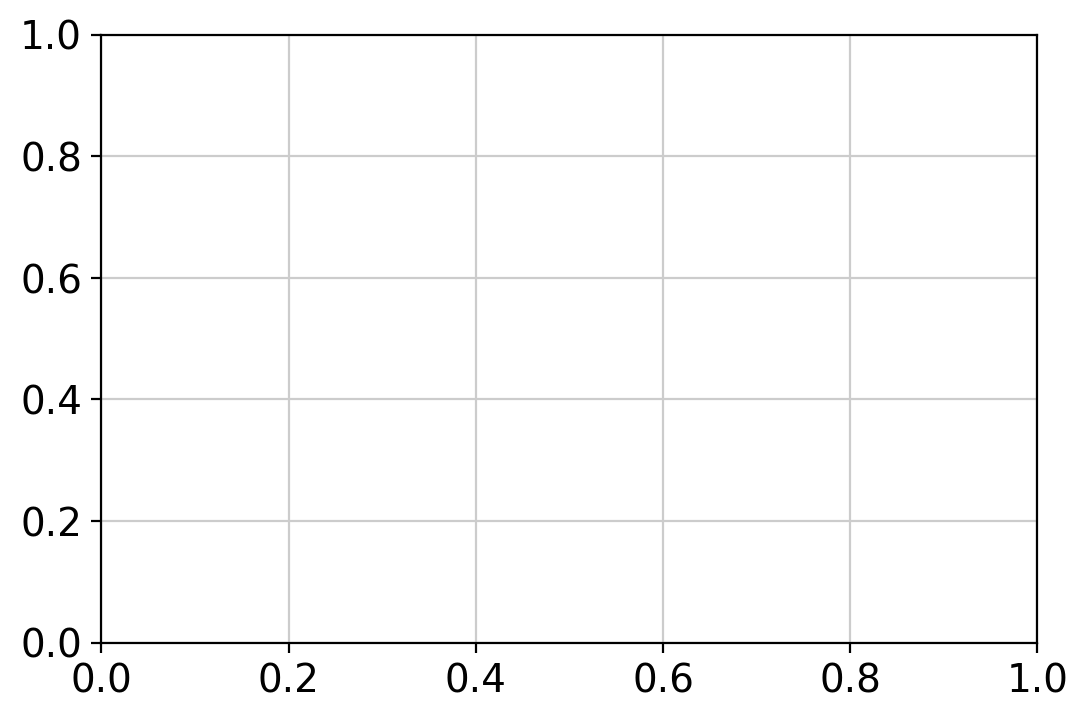

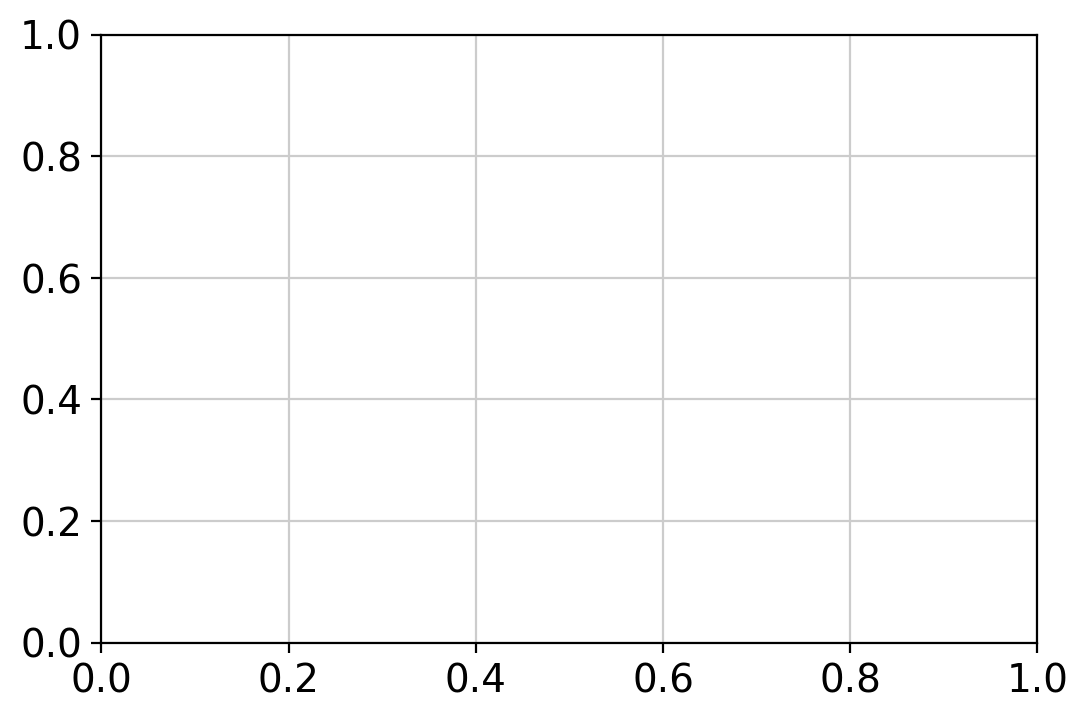

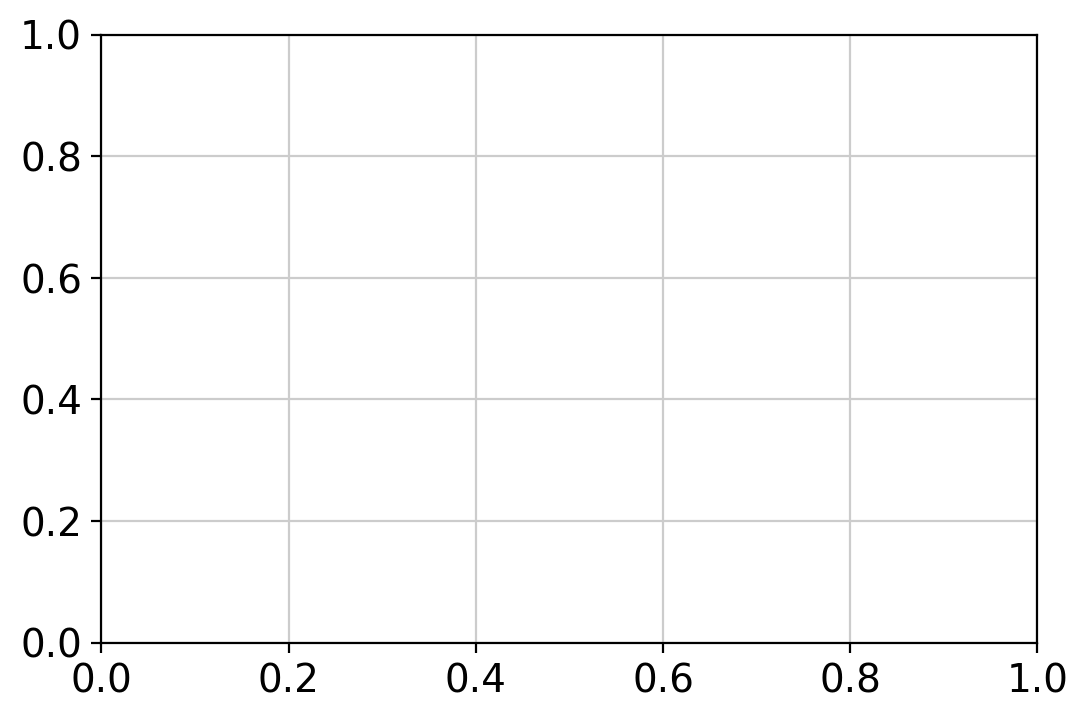

In [244]:
adatas={}
for key in urls:
    adatas[key]=preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url=urls[key][0],
    cells_parquet_url=urls[key][1],
    core_info_dir=urls[key][2], # Core 정보 CSV 파일들이 있는 디렉토리 (선택 사항)
    boundaries_parquet_url="",
    # --- 출력 및 기본 설정 ---
    output_prefix = "processed_xenium_CRC_BJM1_"+key, # 출력 파일명 접두사
    sample_id = "CRC_BJM1_"+key) # 샘플 ID 지정
    adatas[key].obs["batch"]=key

In [356]:
urls={"PDAC":["/data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cell_feature_matrix.h5",
        "/data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet"],
"TNBCS1":["/data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cell_feature_matrix.h5",
        "/data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parquet"],
"TNBCS2":["/data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cell_feature_matrix.h5",
        "/data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parquet"],
"SJH1":["/data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cell_feature_matrix.h5",
        "/data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet"],
"SJH2":["/data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cell_feature_matrix.h5",
        "/data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet"],
"BJM_Set2_1":["/data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cell_feature_matrix.h5",
        "/data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet"],
"BJM_Set2_2":["/data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cell_feature_matrix.h5",
        "/data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet"],
"BJM_Set2_3":["/data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cell_feature_matrix.h5",
        "/data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet"],
"BJM_Set2_4":["/data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cell_feature_matrix.h5",
        "/data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet"],
}

2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 - INFO - Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,355 [INFO] Starting Xenium data preprocessing pipeline.
2025-04-21 00:19:56,426 - INFO - Output prefix set to: processed_xenium_PDAC
2025-04-21 00:19:56,426 - INFO - Output prefix set to: processed_xenium_PDAC
2025-04-21 00:19:56,426 - INFO - Output prefix set to: processed_xenium_PDAC
2025-04-21 00:19:56,426 - INFO - Output prefix set to: processed_xeni

reading /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cell_feature_matrix.h5
 (0:00:04)


2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet
2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet
2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet
2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet
2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet
2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PDAC/output-XETG00274__0041133__Region_1__20250222__071920/cells.parquet
2025-04-21 00:20:01,393 - INFO - Reading cells parquet file: /data/ARPAH/250226_PD

filtered out 2508 cells that have less than 3 genes expressed


2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 - INFO - Cells to remove based on min_genes (3): 2508
2025-04-21 00:20:10,948 [INFO] Cells to remove based on min_genes (3): 2508


filtered out 5257 cells that have less than 10 counts


2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 - INFO - Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,012 [INFO] Cells to remove based on min_counts (10): 5257
2025-04-21 00:20:11,023 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 00:20:11,023 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 00:20:11,023 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 00:20:11,023 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:20:17,297 [INFO] Saved log-normalized data to adata.raw
2025-04-21 00:20:17,305 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 00:20:17,305 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 00:20:17,305 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 00:20:17,305 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 - INFO - Applying log1p transformation.
2025-04-21 00:20:17,632 [INFO] Applying log1p transformation.
2025-04-21 00:20:18,021 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:20:18,021 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:20:18,021 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:20:18,021 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:20:18,021 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:20:19,690 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:20:32,801 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:28)


2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,015 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 00:21:01,038 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 00:21:01,038 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)


2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 - INFO - --- Step 9: Clustering ---
2025-04-21 00:21:59,718 [INFO] --- Step 9: Clustering ---
2025-04-21 00:21:59,726 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 00:21:59,726 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 00:21:59,726 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 22 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:17:04)


2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 00:39:04,209 - INFO - Found 22

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:05:10)


2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png
2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png
2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png
2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png
2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png
2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png
2025-04-21 00:44:16,431 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_PDAC_umap_clusters_leiden_res0.8.png

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:05)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cell_feature_matrix.h5
 (0:00:03)


2025-04-21 00:47:00,699 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parquet
2025-04-21 00:47:00,699 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parquet
2025-04-21 00:47:00,699 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parquet
2025-04-21 00:47:00,699 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parquet
2025-04-21 00:47:00,699 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parquet
2025-04-21 00:47:00,699 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040814__block26_slide1_reg1__20250228__073102/cells.parque

filtered out 2973 cells that have less than 3 genes expressed


2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 - INFO - Cells to remove based on min_genes (3): 2973
2025-04-21 00:47:09,618 [INFO] Cells to remove based on min_genes (3): 2973


filtered out 9731 cells that have less than 10 counts


2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 - INFO - Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,668 [INFO] Cells to remove based on min_counts (10): 9731
2025-04-21 00:47:09,679 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 00:47:09,679 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 00:47:09,679 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 00:47:09,679 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 - INFO - Saved log-normalized data to adata.raw
2025-04-21 00:47:15,713 [INFO] Saved log-normalized data to adata.raw
2025-04-21 00:47:15,720 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 00:47:15,720 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 00:47:15,720 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 00:47:15,720 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 - INFO - Applying log1p transformation.
2025-04-21 00:47:16,048 [INFO] Applying log1p transformation.
2025-04-21 00:47:16,418 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:47:16,418 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:47:16,418 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:47:16,418 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 00:47:16,418 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 00:47:18,020 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 00:47:31,350 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:28)


2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,710 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 00:47:59,743 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 00:47:59,743 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:53)


2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 - INFO - --- Step 9: Clustering ---
2025-04-21 00:48:53,182 [INFO] --- Step 9: Clustering ---
2025-04-21 00:48:53,190 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 00:48:53,190 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 00:48:53,190 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 26 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:13:25)


2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:02:18,548 - INFO - Found 26

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:05:01)


2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_leiden_res0.8.png
2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_leiden_res0.8.png
2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_leiden_res0.8.png
2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_leiden_res0.8.png
2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_leiden_res0.8.png
2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_leiden_res0.8.png
2025-04-21 01:07:21,976 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS1_umap_clusters_lei

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:05)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cell_feature_matrix.h5
 (0:00:01)


2025-04-21 01:10:03,502 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parquet
2025-04-21 01:10:03,502 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parquet
2025-04-21 01:10:03,502 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parquet
2025-04-21 01:10:03,502 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parquet
2025-04-21 01:10:03,502 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parquet
2025-04-21 01:10:03,502 - INFO - Reading cells parquet file: /data/ARPAH/250305_TNBC_26/output-XETG00274__0040807__block26_slide2_reg1__20250228__073103/cells.parque

filtered out 3047 cells that have less than 3 genes expressed


2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 - INFO - Cells to remove based on min_genes (3): 3047
2025-04-21 01:10:09,524 [INFO] Cells to remove based on min_genes (3): 3047


filtered out 10101 cells that have less than 10 counts


2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 - INFO - Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,560 [INFO] Cells to remove based on min_counts (10): 10101
2025-04-21 01:10:09,571 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:10:09,571 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:10:09,571 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:10:09,571 - I

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:10:13,593 [INFO] Saved log-normalized data to adata.raw
2025-04-21 01:10:13,596 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:10:13,596 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:10:13,596 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:10:13,596 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 - INFO - Applying log1p transformation.
2025-04-21 01:10:13,777 [INFO] Applying log1p transformation.
2025-04-21 01:10:13,977 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:10:13,977 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:10:13,977 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:10:13,977 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:10:13,977 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:10:15,012 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:10:22,535 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:19)


2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,422 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 01:10:42,440 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 01:10:42,440 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 - INFO - --- Step 9: Clustering ---
2025-04-21 01:11:13,304 [INFO] --- Step 9: Clustering ---
2025-04-21 01:11:13,311 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:11:13,311 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:11:13,311 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 22 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:07:16)


2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:18:29,421 - INFO - Found 22

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:10)


2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_leiden_res0.8.png
2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_leiden_res0.8.png
2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_leiden_res0.8.png
2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_leiden_res0.8.png
2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_leiden_res0.8.png
2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_leiden_res0.8.png
2025-04-21 01:21:40,659 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_TNBCS2_umap_clusters_lei

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:27)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cell_feature_matrix.h5
 (0:00:02)


2025-04-21 01:23:10,902 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:23:10,902 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:23:10,902 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:23:10,902 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:23:10,902 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:23:10,902 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21

filtered out 1 genes that are detected in less than 3 cells


2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:23:17,479 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 2039 cells that have less than 3 genes expressed


2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:23:17,808 [INFO] Cells to remove based on min_genes (3): 2039


filtered out 6563 cells that have less than 10 counts


2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,853 [INFO] Cells to remove based on min_counts (10): 6563
2025-04-21 01:23:17,863 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:23:17,863 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:23:17,863 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:23:17,863 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:23:22,401 [INFO] Saved log-normalized data to adata.raw
2025-04-21 01:23:22,409 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:23:22,409 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:23:22,409 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:23:22,409 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 - INFO - Applying log1p transformation.
2025-04-21 01:23:22,730 [INFO] Applying log1p transformation.
2025-04-21 01:23:23,028 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:23:23,028 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:23:23,028 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:23:23,028 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:23:23,028 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:23:24,264 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:23:33,336 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:20)


2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,209 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 01:23:54,229 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 01:23:54,229 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 - INFO - --- Step 9: Clustering ---
2025-04-21 01:24:25,641 [INFO] --- Step 9: Clustering ---
2025-04-21 01:24:25,649 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:24:25,649 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:24:25,649 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 19 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:09:01)


2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:33:26,777 - INFO - Found 19

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:16)


2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png
2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png
2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png
2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png
2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png
2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png
2025-04-21 01:36:44,538 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH1_umap_clusters_leiden_res0.8.png

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)


2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,130 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:37:46,

reading /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cell_feature_matrix.h5
 (0:00:02)


2025-04-21 01:38:35,227 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:38:35,227 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:38:35,227 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:38:35,227 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:38:35,227 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21 01:38:35,227 - INFO - Reading cells parquet file: /data/ARPAH/250313_CRC_SJH/Xenium_Output/output-XETG00274__0027672__CRC__20250309__043920/cells.parquet
2025-04-21

filtered out 1 genes that are detected in less than 3 cells


2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 - INFO - Filtered genes: 1 genes removed (< 3 cells).
2025-04-21 01:38:41,741 [INFO] Filtered genes: 1 genes removed (< 3 cells).


filtered out 2039 cells that have less than 3 genes expressed


2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 - INFO - Cells to remove based on min_genes (3): 2039
2025-04-21 01:38:42,060 [INFO] Cells to remove based on min_genes (3): 2039


filtered out 6563 cells that have less than 10 counts


2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 - INFO - Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,105 [INFO] Cells to remove based on min_counts (10): 6563
2025-04-21 01:38:42,116 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:38:42,116 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:38:42,116 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:38:42,116 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:38:46,746 [INFO] Saved log-normalized data to adata.raw
2025-04-21 01:38:46,753 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:38:46,753 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:38:46,753 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:38:46,753 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 - INFO - Applying log1p transformation.
2025-04-21 01:38:47,035 [INFO] Applying log1p transformation.
2025-04-21 01:38:47,339 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:38:47,339 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:38:47,339 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:38:47,339 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:38:47,339 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:38:48,598 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:38:58,107 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:21)


2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,364 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 01:39:19,384 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 01:39:19,384 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)


2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 - INFO - --- Step 9: Clustering ---
2025-04-21 01:39:51,729 [INFO] --- Step 9: Clustering ---
2025-04-21 01:39:51,737 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:39:51,737 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:39:51,737 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 19 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:09:08)


2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:48:59,843 - INFO - Found 19

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:17)


2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png
2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png
2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png
2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png
2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png
2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png
2025-04-21 01:52:18,595 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_SJH2_umap_clusters_leiden_res0.8.png

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:33)


2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,049 - INFO - Marker gene analysis completed. Results stored in adata.uns['clusters_leiden_res0.8_rank_genes_wilcoxon'].
2025-04-21 01:53:13,

reading /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cell_feature_matrix.h5
 (0:00:02)


2025-04-21 01:54:01,202 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet
2025-04-21 01:54:01,202 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet
2025-04-21 01:54:01,202 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet
2025-04-21 01:54:01,202 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet
2025-04-21 01:54:01,202 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet
2025-04-21 01:54:01,202 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_1__20250319__044828/cells.parquet
2025-04-21 01:54

filtered out 1976 cells that have less than 3 genes expressed


2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 - INFO - Cells to remove based on min_genes (3): 1976
2025-04-21 01:54:08,905 [INFO] Cells to remove based on min_genes (3): 1976


filtered out 5199 cells that have less than 10 counts


2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 - INFO - Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,949 [INFO] Cells to remove based on min_counts (10): 5199
2025-04-21 01:54:08,961 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:54:08,961 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:54:08,961 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 01:54:08,961 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 - INFO - Saved log-normalized data to adata.raw
2025-04-21 01:54:13,484 [INFO] Saved log-normalized data to adata.raw
2025-04-21 01:54:13,492 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:54:13,492 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:54:13,492 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 01:54:13,492 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 - INFO - Applying log1p transformation.
2025-04-21 01:54:13,957 [INFO] Applying log1p transformation.
2025-04-21 01:54:14,296 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:54:14,296 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:54:14,296 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:54:14,296 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 01:54:14,296 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 01:54:15,768 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 01:54:25,673 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:15)


2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,886 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 01:54:40,909 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 01:54:40,909 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)


2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 - INFO - --- Step 9: Clustering ---
2025-04-21 01:55:09,839 [INFO] --- Step 9: Clustering ---
2025-04-21 01:55:09,846 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:55:09,846 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 01:55:09,846 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 27 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:04:03)


2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 01:59:13,653 - INFO - Found 27

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:02:48)


2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_1_umap_clusters_leiden_res0.8.png
2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_1_umap_clusters_leiden_res0.8.png
2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_1_umap_clusters_leiden_res0.8.png
2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_1_umap_clusters_leiden_res0.8.png
2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_1_umap_clusters_leiden_res0.8.png
2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_1_umap_clusters_leiden_res0.8.png
2025-04-21 02:02:03,445 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:42)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cell_feature_matrix.h5
 (0:00:02)


2025-04-21 02:03:59,542 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet
2025-04-21 02:03:59,542 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet
2025-04-21 02:03:59,542 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet
2025-04-21 02:03:59,542 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet
2025-04-21 02:03:59,542 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet
2025-04-21 02:03:59,542 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7047/output-XETG00274__0041134__Region_2__20250319__044828/cells.parquet
2025-04-21 02:03

filtered out 1843 cells that have less than 3 genes expressed


2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 - INFO - Cells to remove based on min_genes (3): 1843
2025-04-21 02:04:06,552 [INFO] Cells to remove based on min_genes (3): 1843


filtered out 4414 cells that have less than 10 counts


2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 - INFO - Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,597 [INFO] Cells to remove based on min_counts (10): 4414
2025-04-21 02:04:06,608 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:04:06,608 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:04:06,608 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:04:06,608 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:04:11,035 [INFO] Saved log-normalized data to adata.raw
2025-04-21 02:04:11,042 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:04:11,042 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:04:11,042 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:04:11,042 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 - INFO - Applying log1p transformation.
2025-04-21 02:04:11,496 [INFO] Applying log1p transformation.
2025-04-21 02:04:11,830 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:04:11,830 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:04:11,830 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:04:11,830 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:04:11,830 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:04:13,233 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:04:22,849 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:15)


2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,071 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 02:04:38,092 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 02:04:38,092 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)


2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 - INFO - --- Step 9: Clustering ---
2025-04-21 02:05:07,955 [INFO] --- Step 9: Clustering ---
2025-04-21 02:05:07,963 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 02:05:07,963 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 02:05:07,963 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 24 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:07:57)


2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:13:05,544 - INFO - Found 24

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:02:43)


2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_2_umap_clusters_leiden_res0.8.png
2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_2_umap_clusters_leiden_res0.8.png
2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_2_umap_clusters_leiden_res0.8.png
2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_2_umap_clusters_leiden_res0.8.png
2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_2_umap_clusters_leiden_res0.8.png
2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_2_umap_clusters_leiden_res0.8.png
2025-04-21 02:15:50,036 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:37)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cell_feature_matrix.h5
 (0:00:03)


2025-04-21 02:17:37,493 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet
2025-04-21 02:17:37,493 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet
2025-04-21 02:17:37,493 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet
2025-04-21 02:17:37,493 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet
2025-04-21 02:17:37,493 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet
2025-04-21 02:17:37,493 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_1__20250319__044828/cells.parquet
2025-04-21 02:17

filtered out 1406 cells that have less than 3 genes expressed


2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 - INFO - Cells to remove based on min_genes (3): 1406
2025-04-21 02:17:45,343 [INFO] Cells to remove based on min_genes (3): 1406


filtered out 5773 cells that have less than 10 counts


2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 - INFO - Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,392 [INFO] Cells to remove based on min_counts (10): 5773
2025-04-21 02:17:45,402 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:17:45,402 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:17:45,402 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:17:45,402 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:17:50,507 [INFO] Saved log-normalized data to adata.raw
2025-04-21 02:17:50,514 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:17:50,514 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:17:50,514 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:17:50,514 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 - INFO - Applying log1p transformation.
2025-04-21 02:17:50,971 [INFO] Applying log1p transformation.
2025-04-21 02:17:51,304 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:17:51,304 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:17:51,304 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:17:51,304 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:17:51,304 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:17:52,705 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:18:02,935 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:20)


2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,769 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 02:18:23,788 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 02:18:23,788 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)


2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 - INFO - --- Step 9: Clustering ---
2025-04-21 02:19:03,023 [INFO] --- Step 9: Clustering ---
2025-04-21 02:19:03,030 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 02:19:03,030 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 02:19:03,030 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 24 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:12:13)


2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:31:16,846 - INFO - Found 24

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:39)


2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_3_umap_clusters_leiden_res0.8.png
2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_3_umap_clusters_leiden_res0.8.png
2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_3_umap_clusters_leiden_res0.8.png
2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_3_umap_clusters_leiden_res0.8.png
2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_3_umap_clusters_leiden_res0.8.png
2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_3_umap_clusters_leiden_res0.8.png
2025-04-21 02:34:57,228 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:45)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

reading /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cell_feature_matrix.h5
 (0:00:02)


2025-04-21 02:37:01,209 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet
2025-04-21 02:37:01,209 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet
2025-04-21 02:37:01,209 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet
2025-04-21 02:37:01,209 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet
2025-04-21 02:37:01,209 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet
2025-04-21 02:37:01,209 - INFO - Reading cells parquet file: /data/ARPAH/250323_CRC_BJM2/TA7048/output-XETG00274__0053073__Region_2__20250319__044828/cells.parquet
2025-04-21 02:37

filtered out 879 cells that have less than 3 genes expressed


2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 - INFO - Cells to remove based on min_genes (3): 879
2025-04-21 02:37:08,471 [INFO] Cells to remove based on min_genes (3): 879


filtered out 3752 cells that have less than 10 counts


2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 - INFO - Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,510 [INFO] Cells to remove based on min_counts (10): 3752
2025-04-21 02:37:08,521 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:37:08,521 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:37:08,521 - INFO - Cells to remove based on max_pct_mito (20.0%): 0
2025-04-21 02:37:08,521 - INFO - Cel

normalizing counts per cell
    finished (0:00:00)


2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 - INFO - Saved log-normalized data to adata.raw
2025-04-21 02:37:13,329 [INFO] Saved log-normalized data to adata.raw
2025-04-21 02:37:13,338 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:37:13,338 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:37:13,338 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) ---
2025-04-21 02:37:13,338 - INFO - --- Step 5: Normalization & HVG Selection (lognorm) --

normalizing counts per cell
    finished (0:00:00)


2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 - INFO - Applying log1p transformation.
2025-04-21 02:37:13,769 [INFO] Applying log1p transformation.
2025-04-21 02:37:14,080 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:37:14,080 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:37:14,080 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:37:14,080 - INFO - Finding Highly Variable Genes (HVGs) using Scanpy method.
2025-04-21 02:37:14,080 - INFO - Finding Highly Variable Genes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}
2025-04-21 02:37:15,449 - INFO - Found 2000 HVGs using parameters: {'min_mean': 0.0125, 'max_mean': 3, 'min_disp': 0.5, 'flavor': 'seurat_v3'}

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 - INFO - Applied scaling to HVGs. adata.X now contains scaled log-normalized counts for HVGs.
2025-04-21 02:37:25,149 [INFO] Applied scaling to HVGs. 

computing PCA
    with n_comps=50
    finished (0:00:18)


2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 - INFO - PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,114 [INFO] PCA performed on scaled log-normalized HVG data.
2025-04-21 02:37:44,134 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyword argument 'ax'
2025-04-21 02:37:44,134 - WARNING - Could not generate PCA variance ratio plot: pca_variance_ratio() got an unexpected keyw

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:34)


2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 - INFO - --- Step 9: Clustering ---
2025-04-21 02:38:18,706 [INFO] --- Step 9: Clustering ---
2025-04-21 02:38:18,713 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 02:38:18,713 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}
2025-04-21 02:38:18,713 - INFO - Running leiden clustering with parameters: {'resolution': 0.8, 'key_added': 'clusters_leiden_res0.8', 'random_state': 0}


running Leiden clustering
    finished: found 22 clusters and added
    'clusters_leiden_res0.8', the cluster labels (adata.obs, categorical) (0:09:56)


2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22 clusters using leiden (resolution=0.8). Results stored in adata.obs['clusters_leiden_res0.8'].
2025-04-21 02:48:14,875 - INFO - Found 22

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:31)


2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_4_umap_clusters_leiden_res0.8.png
2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_4_umap_clusters_leiden_res0.8.png
2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_4_umap_clusters_leiden_res0.8.png
2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_4_umap_clusters_leiden_res0.8.png
2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_4_umap_clusters_leiden_res0.8.png
2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_BJM_Set2_4_umap_clusters_leiden_res0.8.png
2025-04-21 02:51:47,614 - INFO - Saved UMAP plot colored by 'clusters_leiden_res0.8' to: processed_xenium_

ranking genes
    finished: added to `.uns['clusters_leiden_res0.8_rank_genes_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:36)


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: P

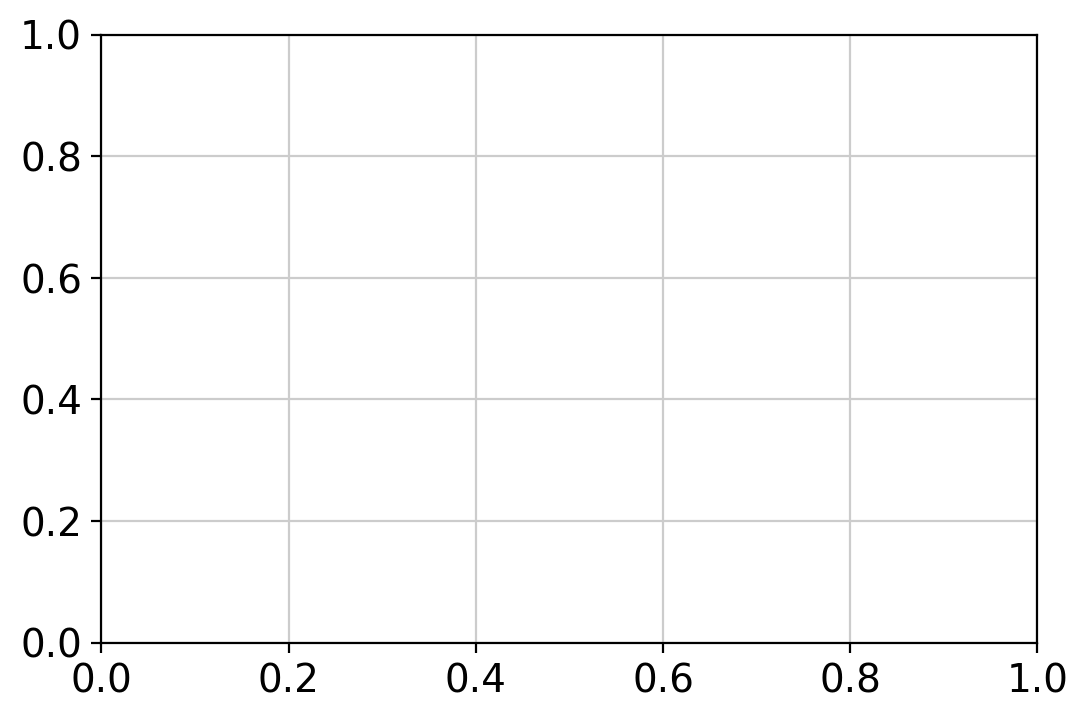

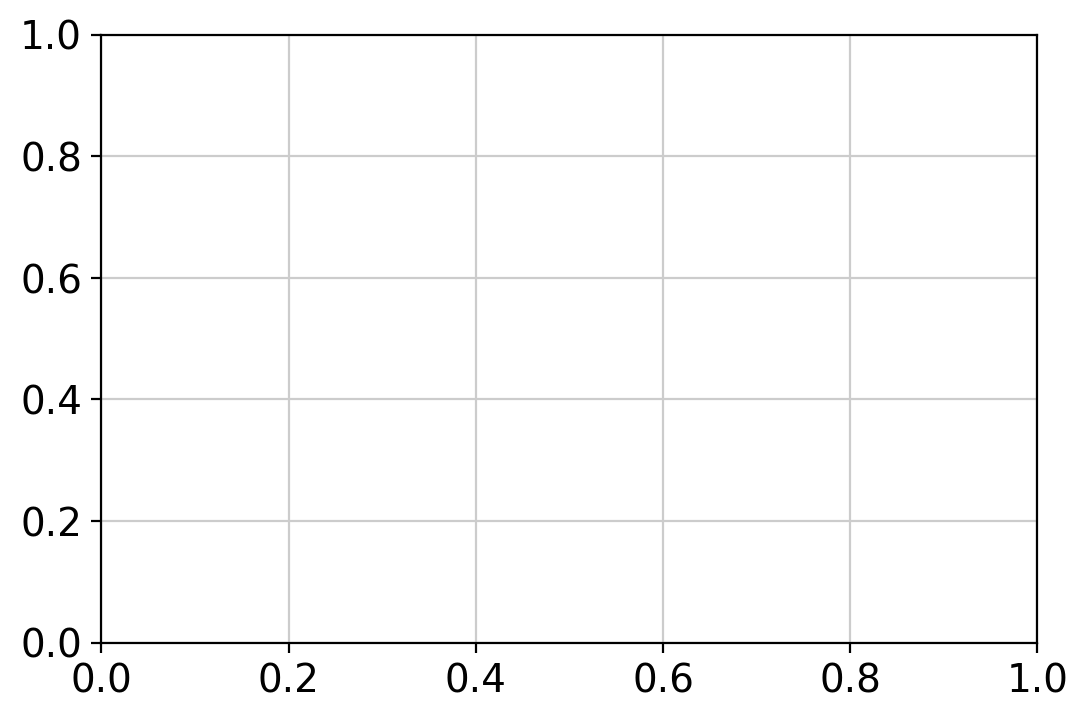

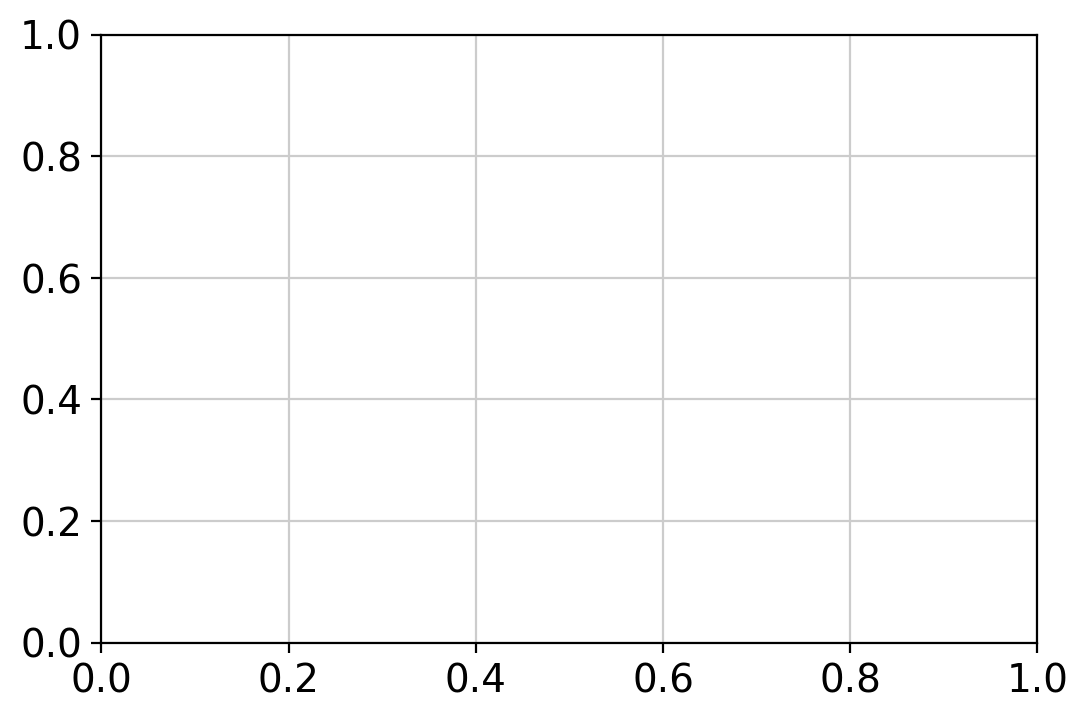

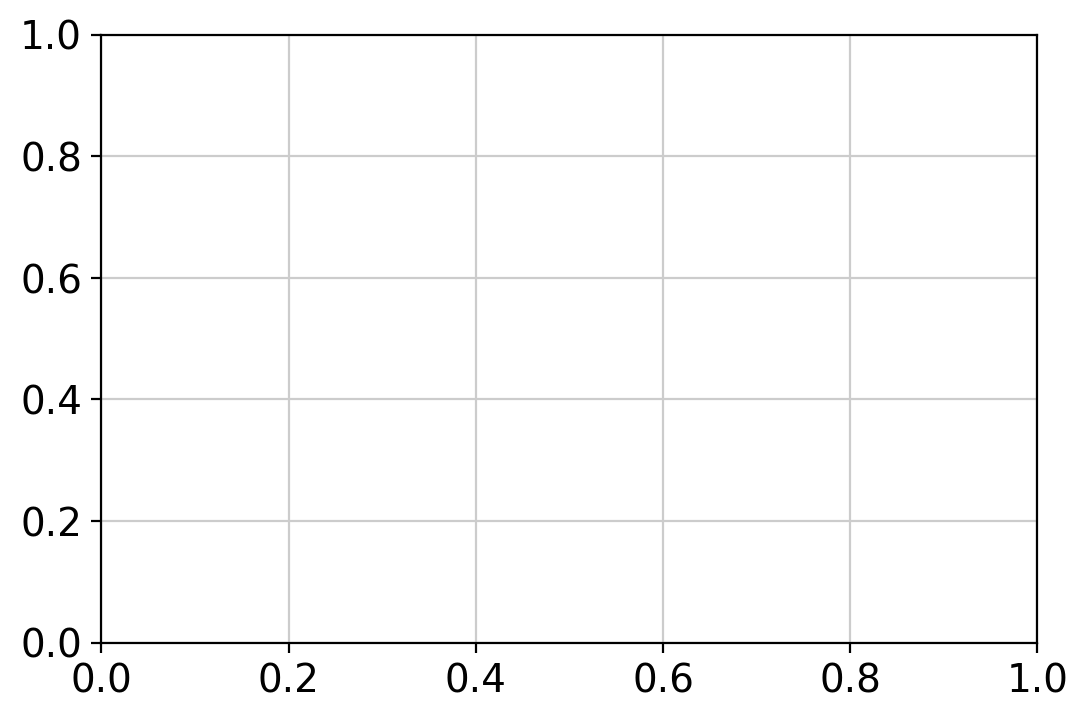

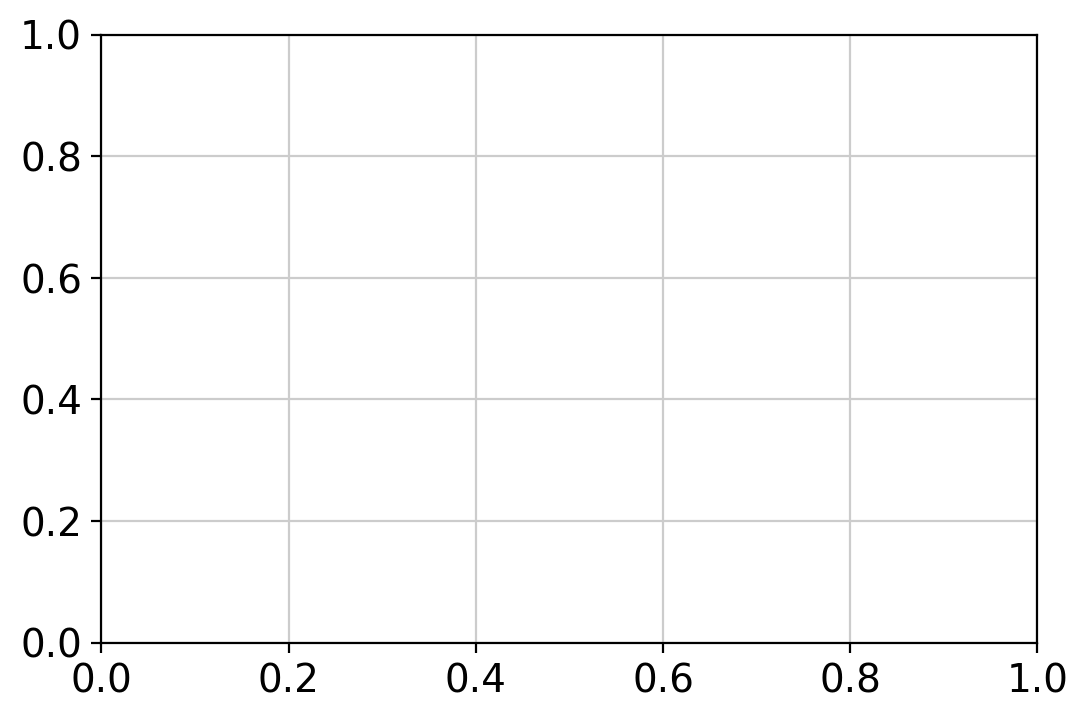

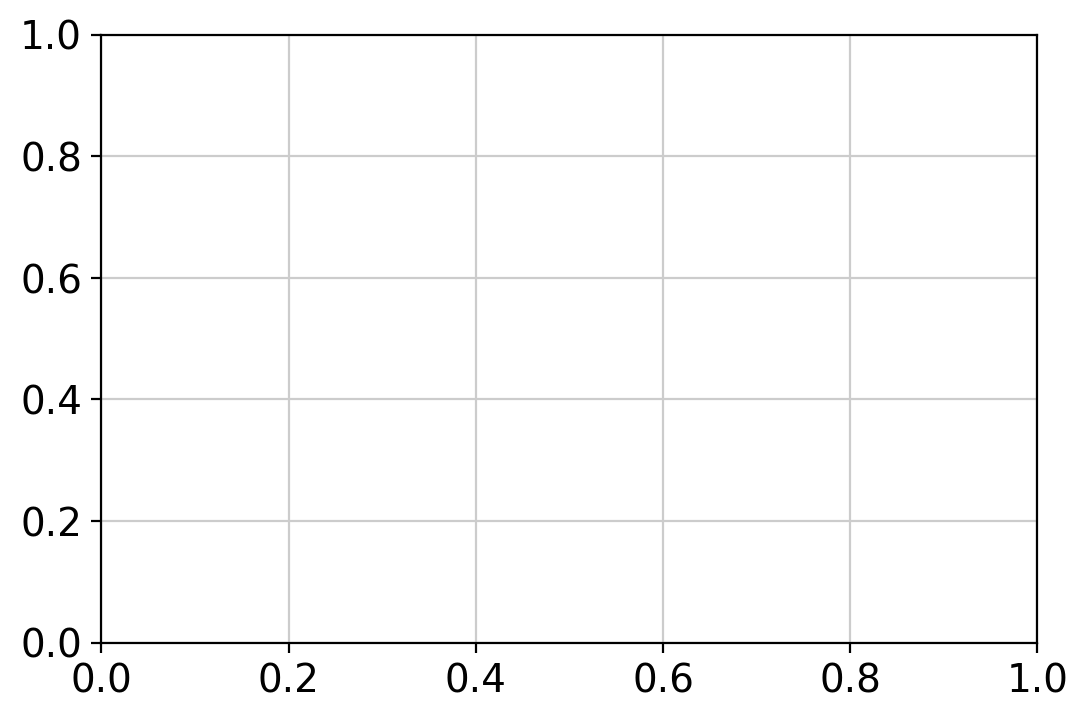

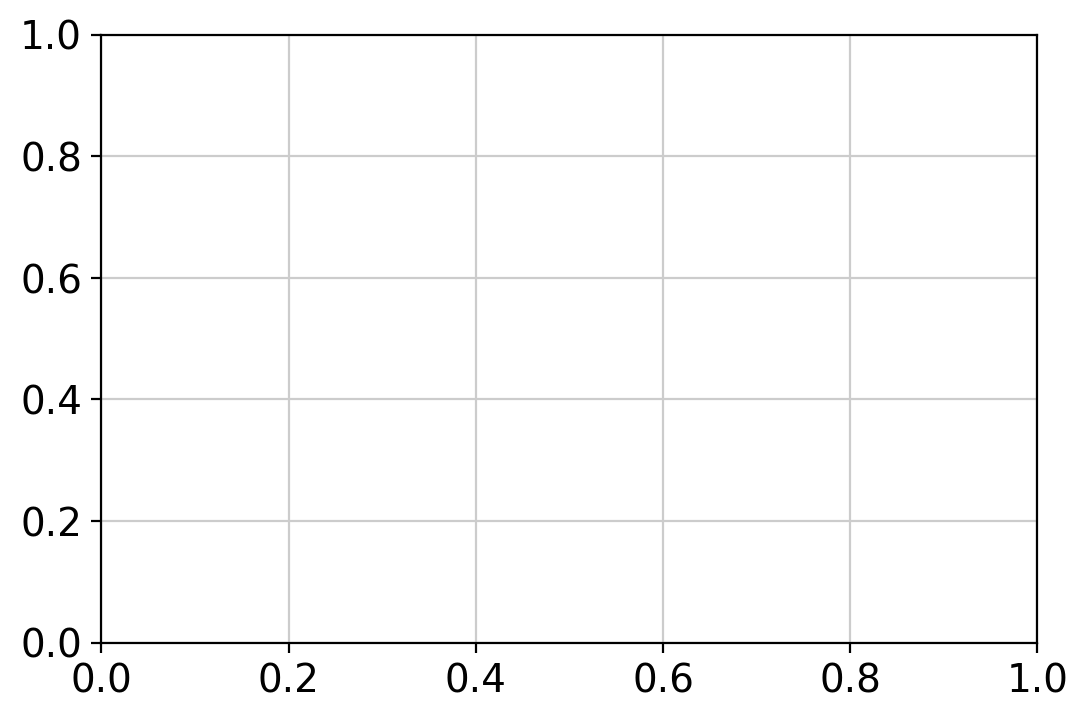

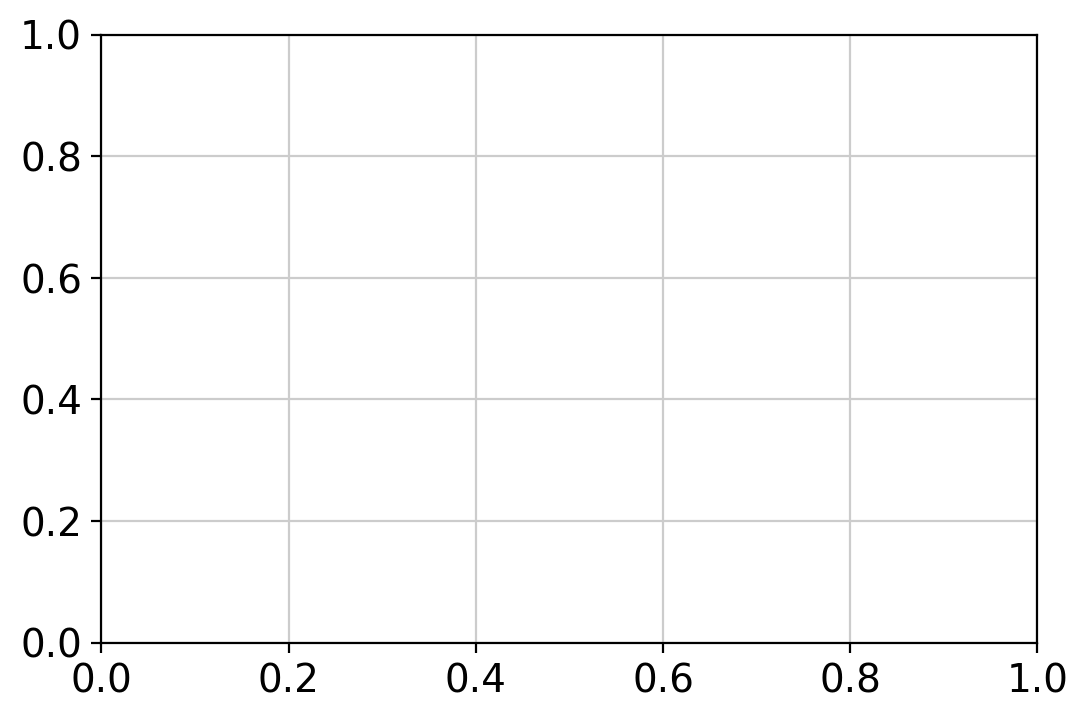

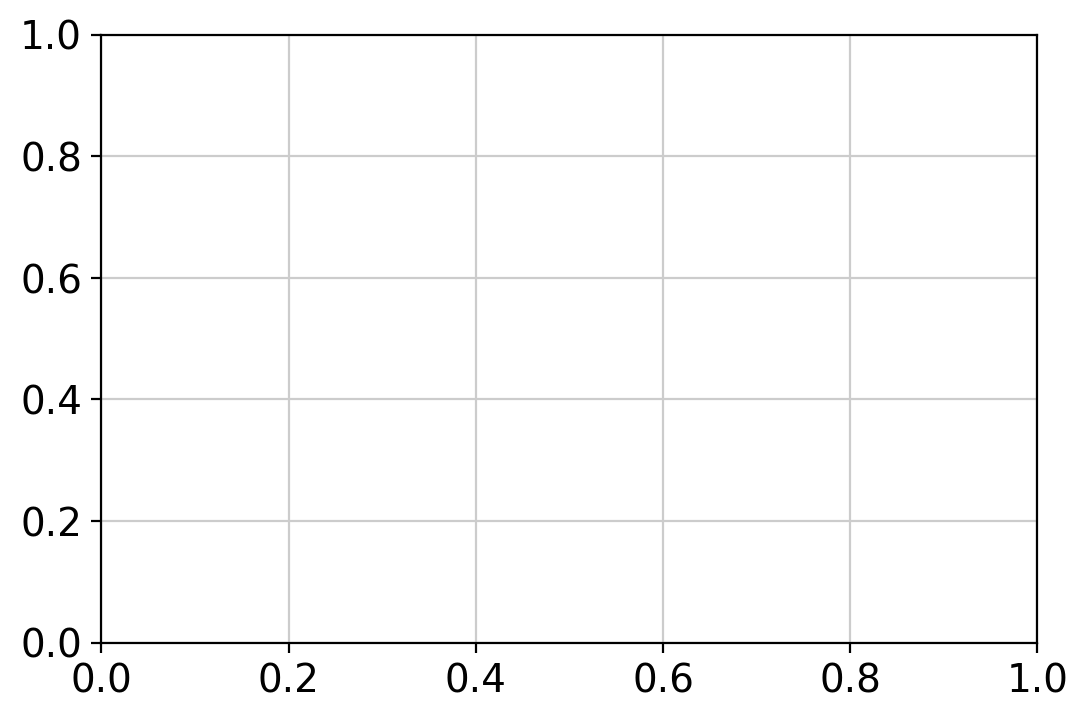

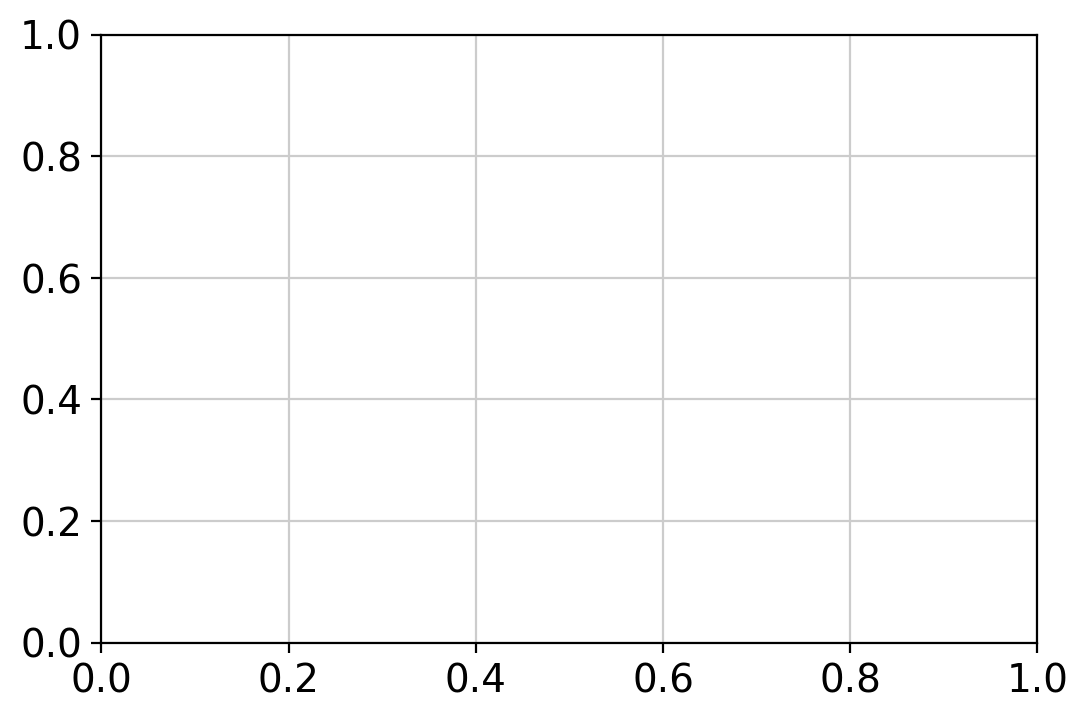

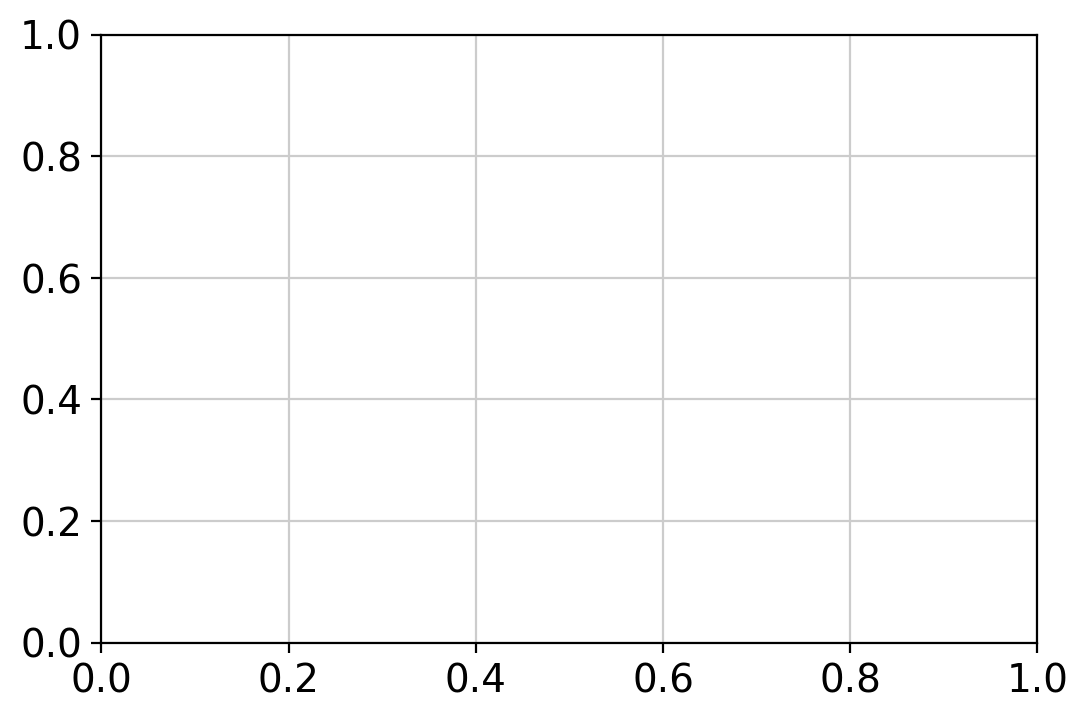

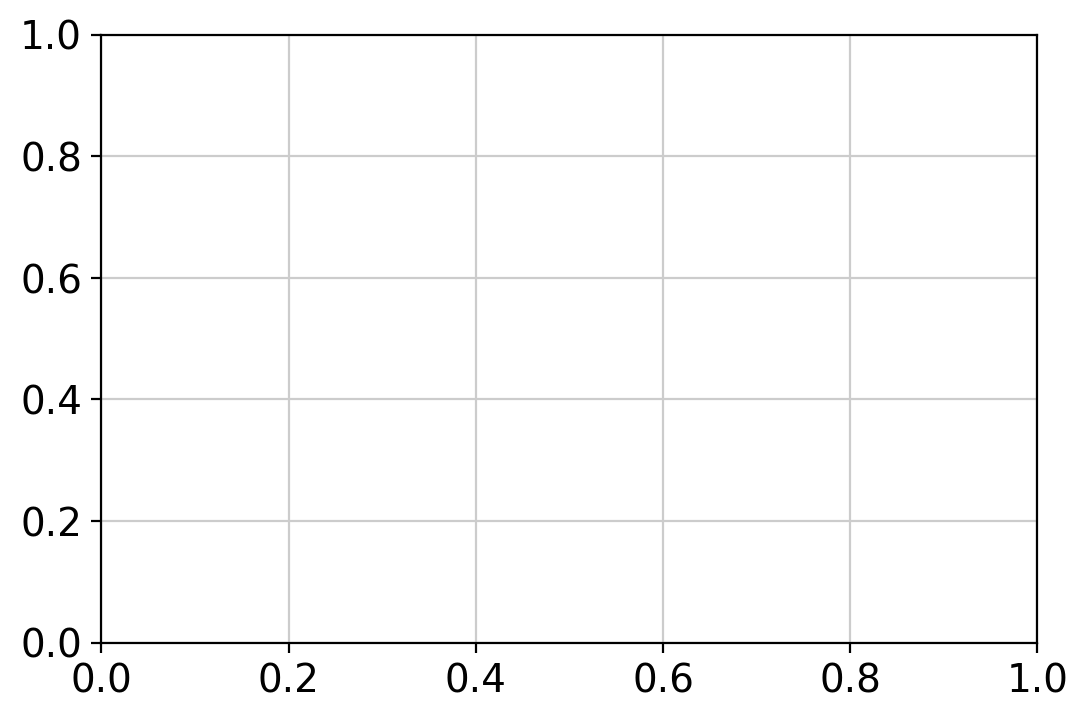

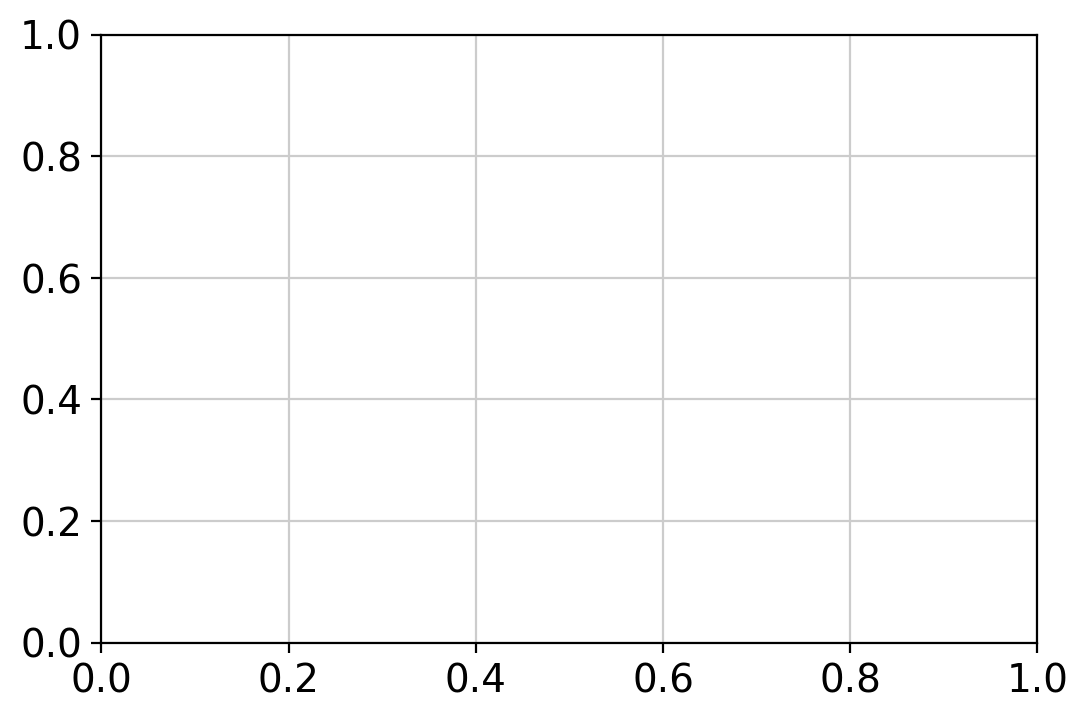

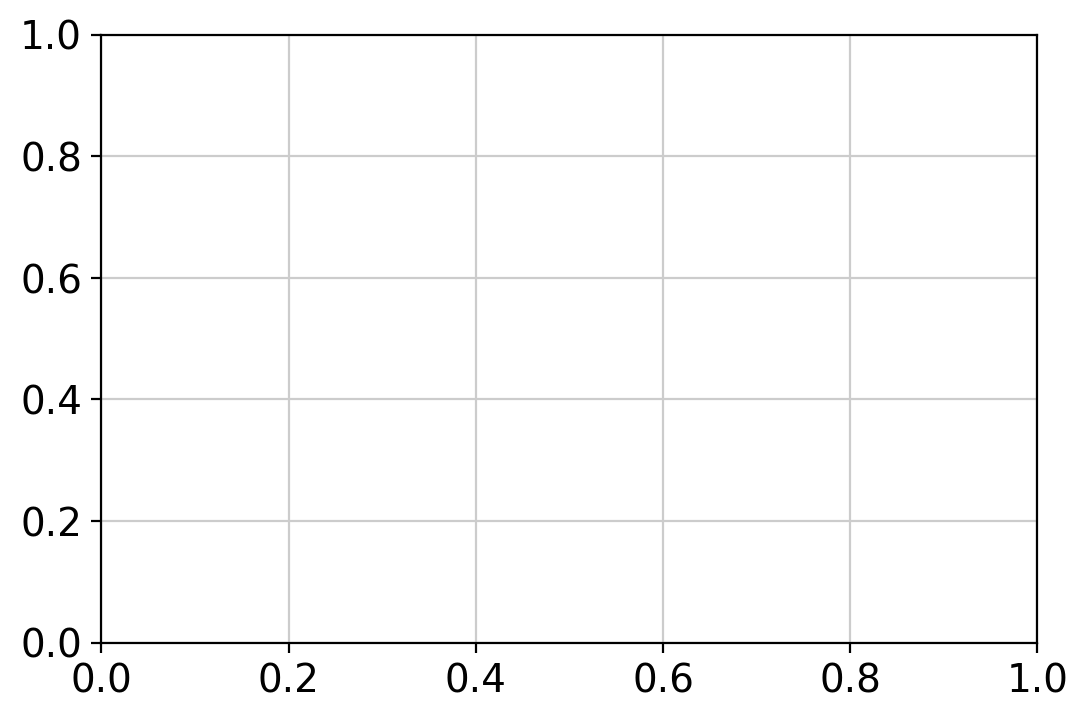

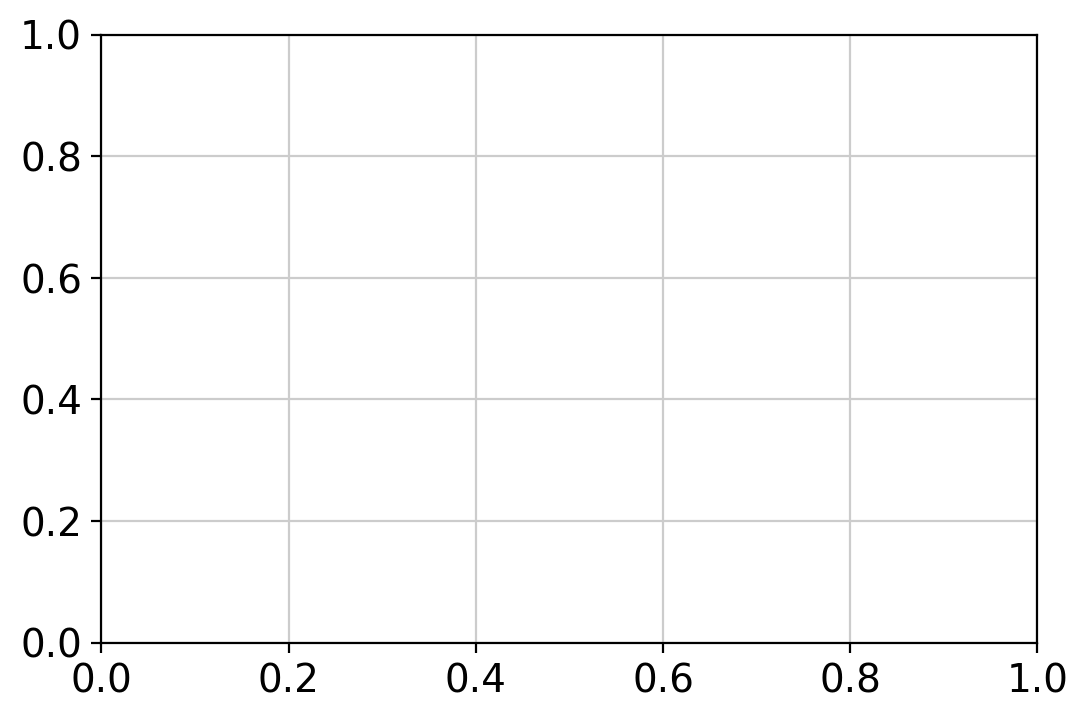

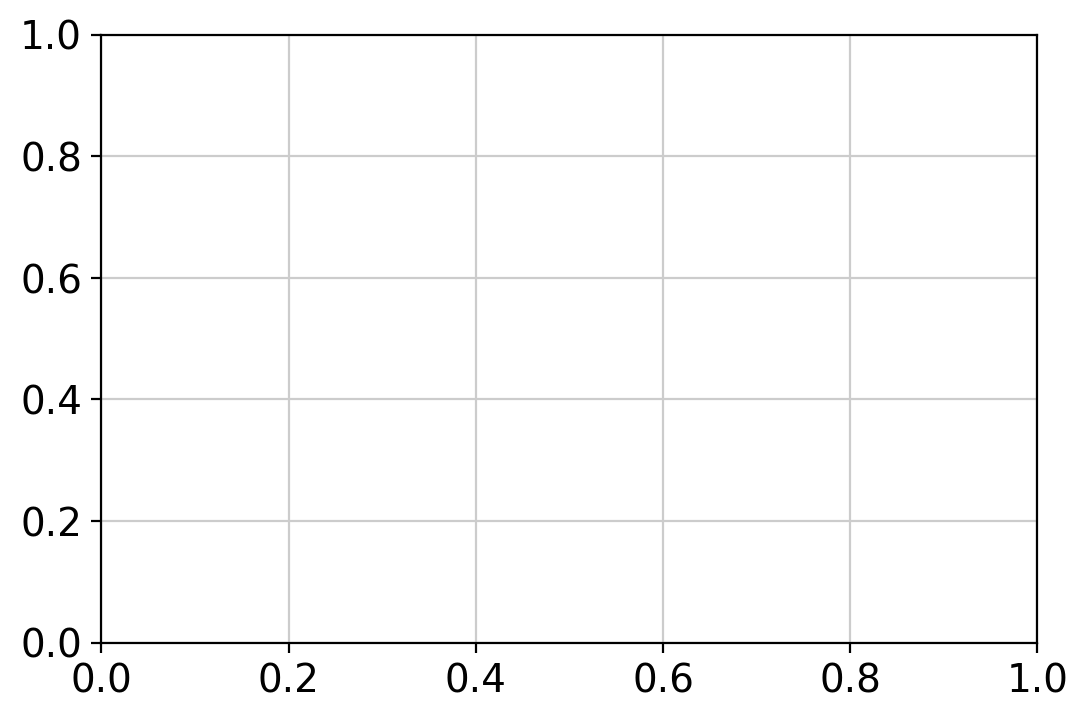

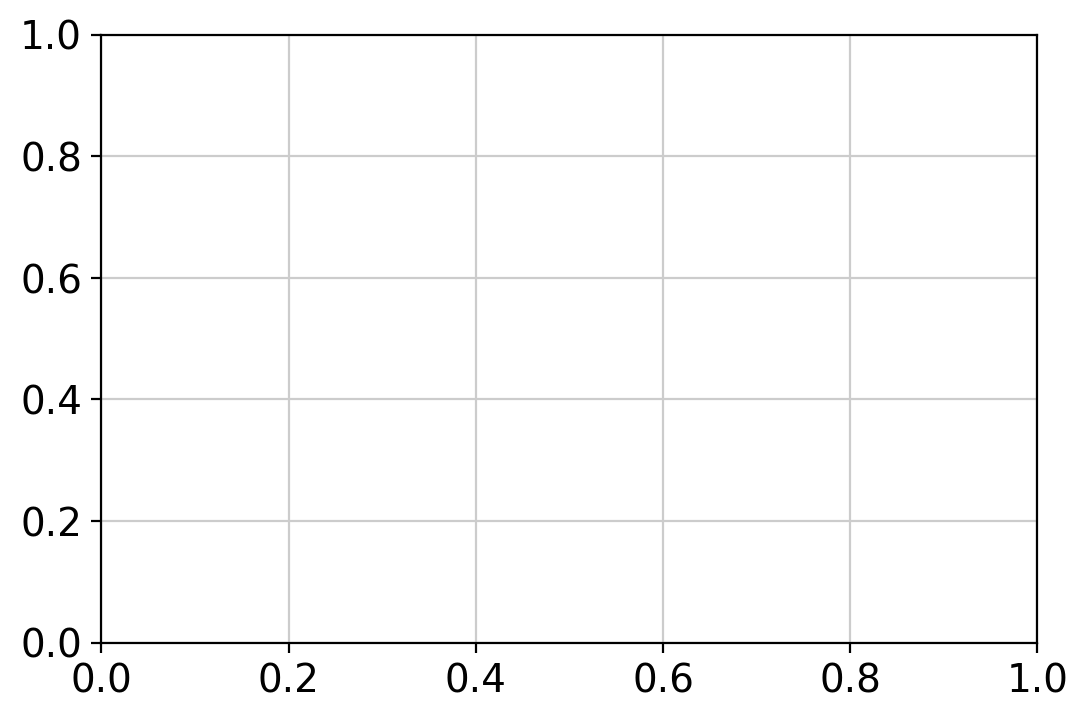

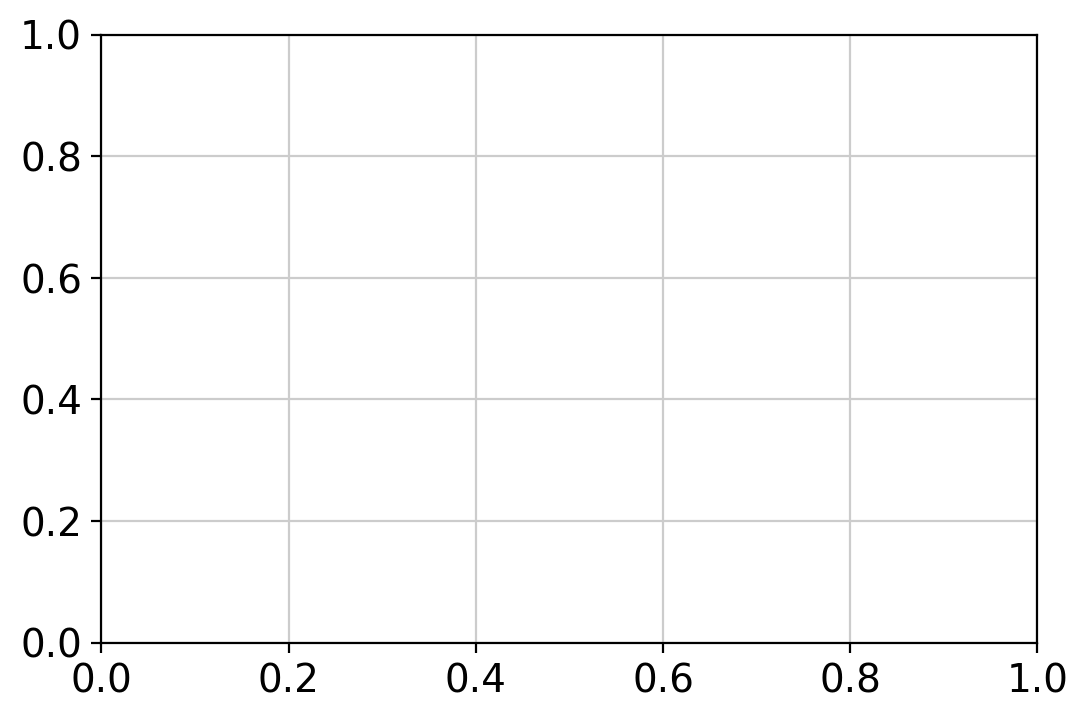

In [358]:
adatas={}
for key in urls:
    adatas[key]=preprocess_xenium(
    # --- 입력 파일 경로 ---
    h5_url=urls[key][0],
    cells_parquet_url=urls[key][1],
    boundaries_parquet_url="",
    # --- 출력 및 기본 설정 ---
    output_prefix = "processed_xenium_"+key, # 출력 파일명 접두사
    sample_id = key) # 샘플 ID 지정
    adatas[key].obs["batch"]=key

# loading

# integration

In [309]:
for key in urls:
    adatas[key].X=adatas[key].layers["counts"]
adata_list = list(adatas.values())
adata_concat = sc.AnnData.concatenate(*adata_list, join='inner', batch_key='batch_original_index') #*은 unpacking을 의미.
print(adata_concat.n_vars)

/tmp/ipykernel_140850/1628474136.py:4: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = sc.AnnData.concatenate(*adata_list, join='inner', batch_key='batch_original_index')


In [311]:

sc.pp.normalize_total(adata_concat, target_sum=1e4)
sc.pp.log1p(adata_concat)
sc.pp.highly_variable_genes(adata_concat, batch_key='batch', n_top_genes=int(np.round(adata_concat.n_vars/2))) # 배치 고려 HVG
sc.pp.scale(adata_concat, max_value=10)

sc.tl.pca(adata_concat, n_comps=50)
adata_concat2=adata_concat.copy()

extracting highly variable genes


... storing 'batch' as categorical
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scipy/sparse/_data.py:144: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:297: RuntimeWarning: overflow encountered in expm1
  X = np.expm1(X)


ValueError: cannot specify integer `bins` when input data contains infinity

2025-04-18 20:28:55,104 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-18 20:28:55,104 [INFO] Computing initial centroids with sklearn.KMeans...
2025-04-18 20:29:39,805 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-18 20:29:39,805 [INFO] sklearn.KMeans initialization complete.
2025-04-18 20:29:43,755 - harmonypy - INFO - Iteration 1 of 10
2025-04-18 20:29:43,755 [INFO] Iteration 1 of 10
2025-04-18 20:36:17,675 - harmonypy - INFO - Iteration 2 of 10
2025-04-18 20:36:17,675 [INFO] Iteration 2 of 10
2025-04-18 20:43:24,613 - harmonypy - INFO - Converged after 2 iterations
2025-04-18 20:43:24,613 [INFO] Converged after 2 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:50)
computing UMAP


/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/umap/spect

    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:16:36)
running Leiden clustering


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


    finished: found 276 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:51:22)
the obs value 'leiden' has more than 103 categories. Uniform 'grey' color will be used for all categories.


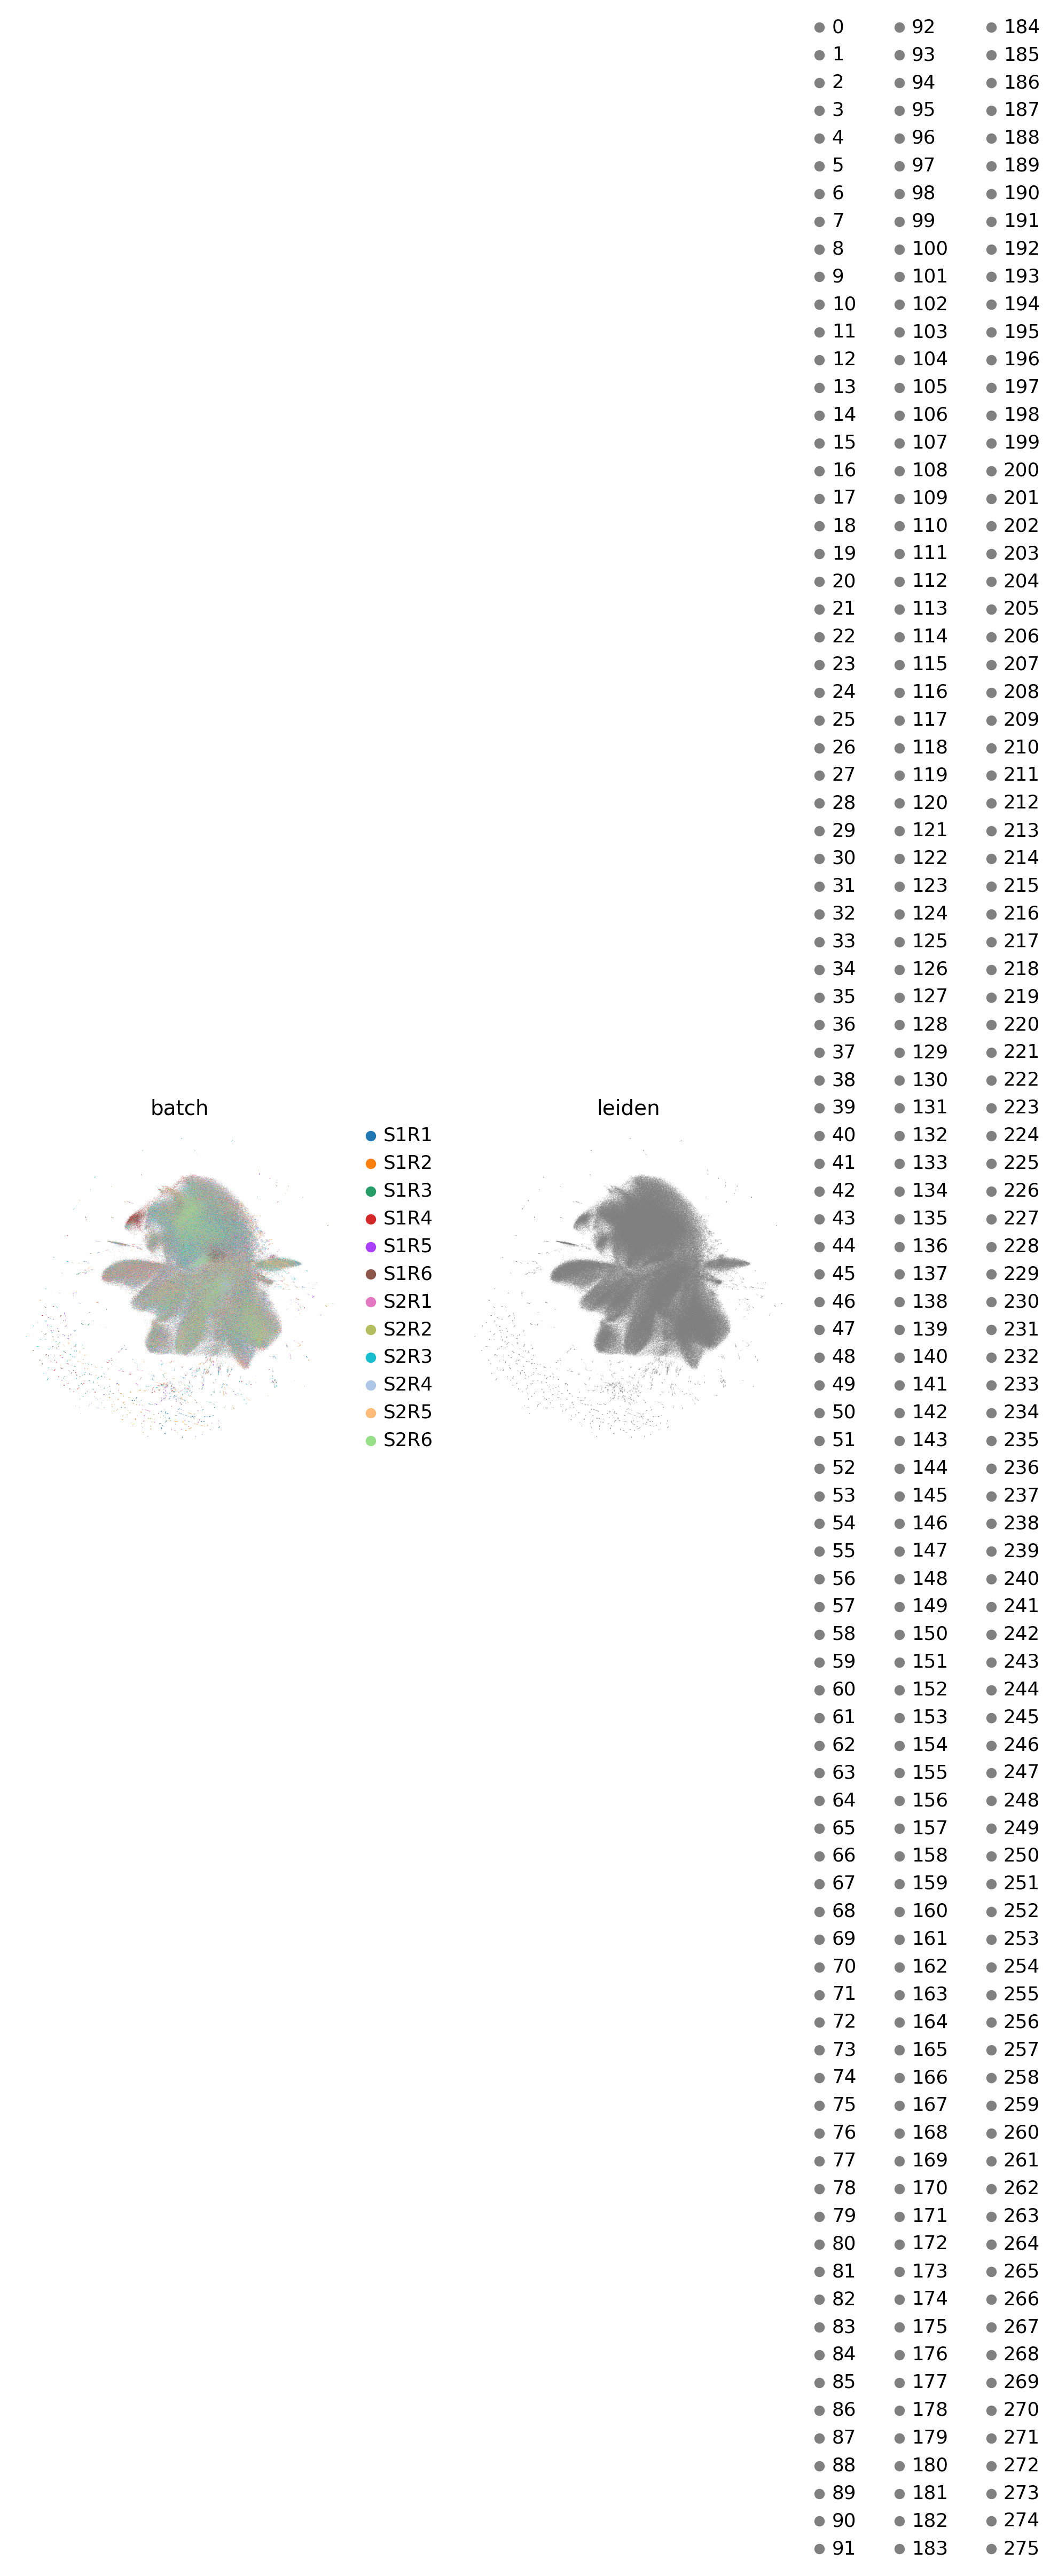

In [344]:
import scanpy.external as sce

# Harmony 실행
sce.pp.harmony_integrate(adata_concat, key='batch') # key: 배치 정보가 있는 .obs 컬럼명
# 결과는 adata_concat.obsm['X_pca_harmony']에 저장됨
# sc.pp.neighbors(adata_concat, n_pcs=30, use_rep='X_pca_harmony') # Harmony 결과 사용
sc.pp.neighbors(adata_concat, n_neighbors=30, n_pcs=50, use_rep='X_pca_harmony') # data가 방대하니 axis와 이웃 수를 늘려도 괜찮을 수 있다... n_pcs가 적은 것이 umap에 영향을 줄 수 있음.
adata_concat.obsm['X_pca_harmony'] = X + np.random.normal(scale=1e-6, size=X.shape)
sc.tl.umap(adata_concat, init_pos="spectral", random_state=0)
# sc.tl.umap(adata_concat)
# /home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
# failed. This is likely due to too small an eigengap. Consider
# adding some noise or jitter to your data.
# Falling back to random initialisation!
#   warn(
# UMAP의 “Spectral initialisation failed” 경고는, UMAP이 처음에 스펙트럴(고유벡터) 방식으로 임베딩 초기값을 계산하려다 “eigengap(고유치 차이)”가 너무 작아 수치적으로 불안정해질 때 발생하며,
# 그럴 경우 자동으로 랜덤 초기화로 되돌아가는 메시지입니다. 실제로는 큰 문제는 아니지만, 반복해서 뜨면 임베딩이 불안정하거나 재현성이 떨어질 수 있습니다.
# IOStream.flush timed out -> jupyter notebook의 문제임.
# 16분 지나서 되긴 됐다 ㅠ

# sc.tl.umap(
#     adata_concat,
#     init_pos="random",       # spectral 대신 random
#     random_state=42,         # 재현성 확보
#     min_dist=0.5,            # (선택) 임베딩 밀집도 조절
#     n_components=2
# )
sc.tl.leiden(adata_concat, resolution=0.8)
# 시각화 등
sc.pl.umap(adata_concat, color=['batch', 'leiden'])
adata_concat.write_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium2/CRC_BJM1_harmonized.h5ad")

/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scvi/model/_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
INFO: GPU available: True (cuda), used: True
2025-04-18 22:54:33,947 [INFO] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-04-18 22:54:33,949 [INFO] TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-04-

Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
2025-04-18 23:10:17,064 [INFO] `Trainer.fit` stopped: `max_epochs=10` reached.


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:12:15)
running Leiden clustering


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


    finished: found 33 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:03:28)


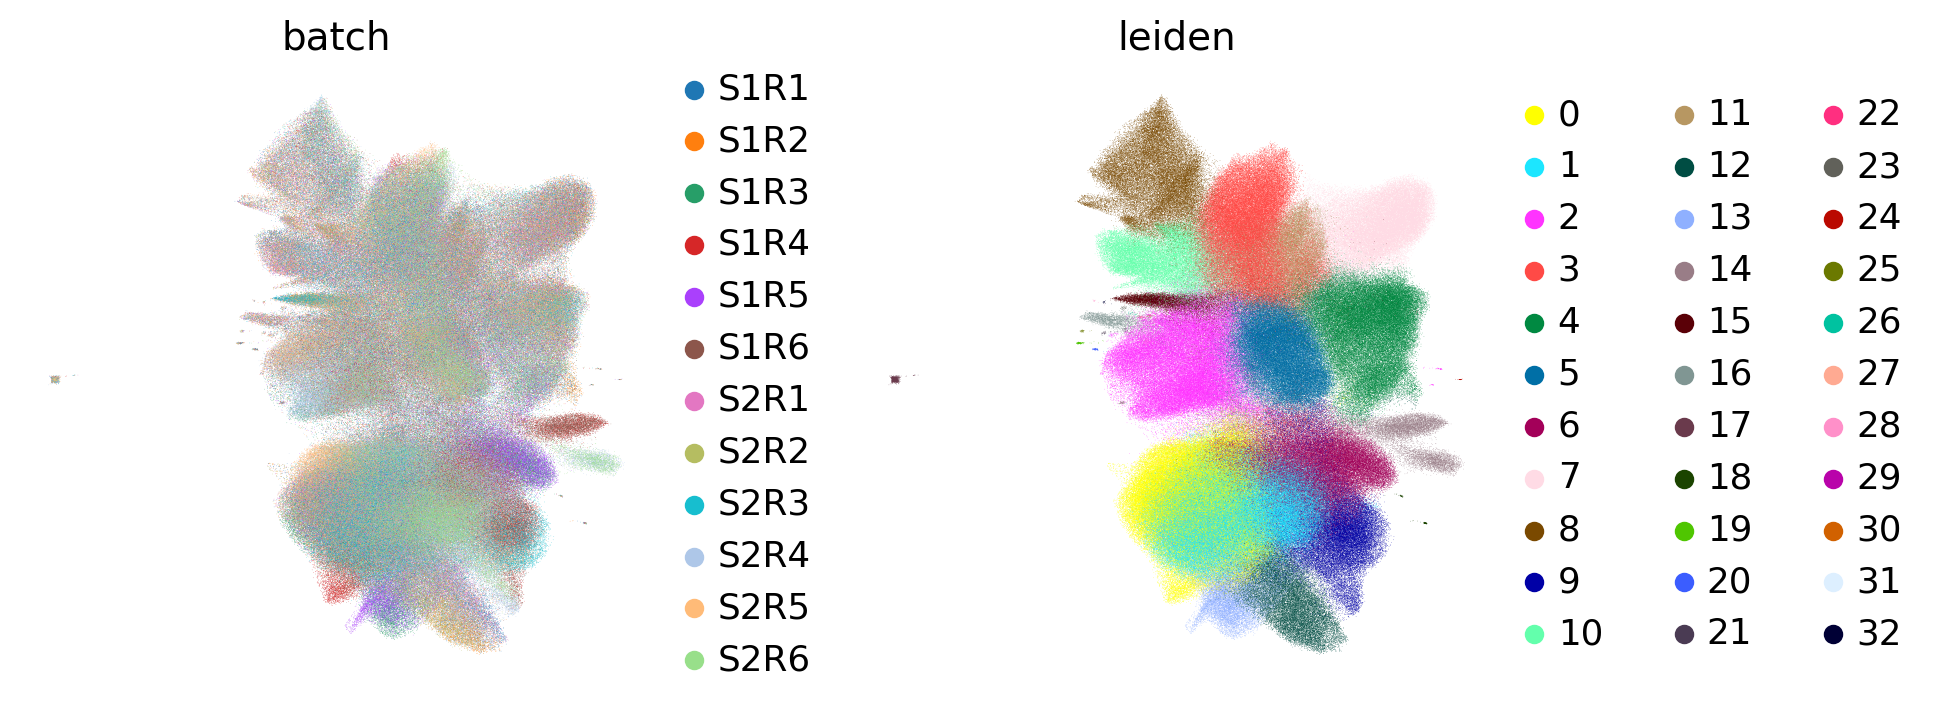

In [346]:
# 합칠 때 raw count 레이어도 포함하도록 가정
# 또는 각 파일 로드 후 .X를 raw count로 설정하고 합치기
# 예: 각 adata 로드 후 adata.X = adata.layers['counts'].copy() 수행 후 합치기

# 합쳐진 AnnData 객체 준비 (raw count가 .X에 있다고 가정)
# scvi-tools 설치 필요: pip install scvi-tools
import scvi

# scVI 모델 설정 (배치 키 지정)
scvi.model.SCVI.setup_anndata(adata_concat2, layer=None, batch_key='batch') # .X 사용 시 layer=None

# scVI 모델 생성 및 훈련
model = scvi.model.SCVI(adata_concat2)
model.train() # GPU 사용 가능 시 자동으로 활용

# 통합된 Latent Embedding 얻기
adata_concat2.obsm['X_scVI'] = model.get_latent_representation()
# 정규화된 표현 값 얻기 (선택 사항)
# adata_concat.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)
sc.pp.neighbors(adata_concat2, n_pcs=10, use_rep='X_scVI') # scVI 결과 사용 (보통 저차원)
sc.tl.umap(adata_concat2)
sc.tl.leiden(adata_concat2, resolution=0.8)
# 시각화 등
sc.pl.umap(adata_concat2, color=['batch', 'leiden'])

adata_concat2.write_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium/CRC_BJM1_scVIed.h5ad")

# O3 sytle

In [189]:
from __future__ import annotations
import os, re, glob, logging, warnings, datetime as dt
from typing import Sequence, Literal, Optional

import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse

###############################################################################
# logging 설정 (root level 이외는 건드리지 않고 파일·console 동시 기록)
###############################################################################
LOGGER = logging.getLogger("xenium-pre")
if not LOGGER.handlers:
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[
            logging.StreamHandler(),
            logging.FileHandler("preprocess_xenium.log", mode="a"),
        ],
    )
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")

###############################################################################
# 핵심 함수
###############################################################################
def preprocess_xenium_o3(
    h5_path: str,
    cells_parquet: str,
    cores_dir: str,
    *,
    sample_id: str | None = None,
    normalization: Literal["log", "sct"] = "log",
    scale_factor: float = 1e4,
    hvg_n_top: int = 3000,
    sct_n_genes: int = 3000,
    neighbors_k: int = 15,
    n_pcs: int = 40,
    cluster_resolution: float = 0.8,
    output_path: Optional[str] = None,
) -> tuple[sc.AnnData, pd.DataFrame]:
    """
    One‑shot Xenium → AnnData preprocessing.

    Parameters
    ----------
    h5_path : str
        Path to *cell_feature_matrix.h5*.
    cells_parquet : str
        Path to *cells.parquet* (contains x/y centroids etc.).
    cores_dir : str
        Directory containing *_cells_stats.csv* files.
    sample_id : str, optional
        Will be stored in `adata.obs["sample_id"]`.
    normalization : {"log", "sct"}
        Pipeline branch to run.
    output_path : str, optional
        If given, write `.h5ad` to this location.

    Returns
    -------
    adata : AnnData
    conflict_df : DataFrame
        Row‑wise conflicts when both adata & core csv had non‑NaN.
    """
    LOGGER.info("=== ⏳ Loading core H5 matrix ===")
    adata = sc.read_10x_h5(h5_path)
    adata.var_names_make_unique()
    if sample_id:
        adata.obs["sample_id"] = sample_id

    # ------------------------------------------------------------------ #
    # cells.parquet 메타데이터 merge
    # ------------------------------------------------------------------ #
    LOGGER.info("Merging cells.parquet")
    cells_df = pd.read_parquet(cells_parquet).set_index("cell_id")
    adata.obs = adata.obs.join(cells_df, how="left", rsuffix="_cells")

    if {"x_centroid", "y_centroid"} <= set(adata.obs.columns):
        adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].to_numpy()

    # ------------------------------------------------------------------ #
    # *_cells_stats.csv 메타데이터 merge with conflict logging
    # ------------------------------------------------------------------ #
    conflict_rows = []
    for csv in glob.glob(os.path.join(cores_dir, "*_cells_stats.csv")):
        core_id = _extract_core_id(csv)
        if core_id is None:
            LOGGER.warning(f"Skip (no core id): {csv}")
            continue
        core = (
            pd.read_csv(csv, comment="#", skip_blank_lines=True)
            .set_index("Cell ID")
            .assign(Core=core_id)
        )

        # vectorized update per column
        for col in core.columns:
            if col not in adata.obs:
                adata.obs[col] = np.nan
            # where() keeps original when condition False
            src = core[col]
            tgt = adata.obs[col]
            mask = tgt.isna() & src.notna()
            adata.obs.loc[mask, col] = src[mask]

            conf = (~tgt.isna()) & src.notna()
            if conf.any():
                conflict_rows.append(
                    pd.DataFrame(
                        {
                            "cell": conf[conf].index,
                            "column": col,
                            "adata_value": tgt[conf].values,
                            "core_value": src[conf].values,
                            "source": csv,
                        }
                    )
                )
    conflict_df = pd.concat(conflict_rows, ignore_index=True) if conflict_rows else pd.DataFrame()
    LOGGER.info(f"Core merge done. conflicts={len(conflict_df)}")

    # drop cells without Core
    before = adata.n_obs
    adata = adata[~adata.obs["Core"].isna()].copy()
    LOGGER.info("Dropped %d cells missing Core", before - adata.n_obs)

    # ------------------------------------------------------------------ #
    # QC metrics
    # ------------------------------------------------------------------ #
    _tag_qc_genes(adata)
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True)

    # ------------------------------------------------------------------ #
    # Normalization branch
    # ------------------------------------------------------------------ #
    if normalization == "log":
        LOGGER.info("Running log1p normalization")
        sc.pp.normalize_total(adata, target_sum=scale_factor)
        sc.pp.log1p(adata)
        adata.layers["log_norm"] = adata.X.copy()
        sc.pp.highly_variable_genes(adata, n_top_genes=hvg_n_top)
    else:
        LOGGER.info("Running SCTransform")
        from sctransform import vst

        vst_out = vst(
            adata.X,
            gene_names=adata.var_names,
            cell_names=adata.obs_names,
            n_genes=sct_n_genes,
        )
        adata.layers["sct_residuals"] = vst_out["residuals"]
        adata.X = vst_out["residuals"]  # downstream uses residuals
        adata.var = adata.var.join(
            vst_out["gene_attr"].set_index("gene_name"), how="left"
        )
        adata.var["highly_variable"] = adata.var["highly_variable"].fillna(False)

    # ------------------------------------------------------------------ #
    # Scaling / PCA / neighbors / clustering / UMAP
    # ------------------------------------------------------------------ #
    sc.pp.scale(adata, zero_center=True)
    sc.tl.pca(adata, n_comps=n_pcs, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=neighbors_k, n_pcs=n_pcs)
    sc.tl.leiden(adata, resolution=cluster_resolution, key_added="leiden")

    sc.tl.umap(adata)
    sc.tl.rank_genes_groups(
        adata, groupby="leiden", method="wilcoxon", key_added="marker_genes"
    )

    # ------------------------------------------------------------------ #
    # I/O
    # ------------------------------------------------------------------ #
    if output_path:
        fname = (
            output_path
            if output_path.endswith(".h5ad")
            else os.path.join(
                output_path,
                f"{sample_id or 'xenium'}_{dt.datetime.now():%Y%m%d_%H%M%S}.h5ad",
            )
        )
        adata.write(fname)
        LOGGER.info("AnnData written to %s", fname)

    return adata, conflict_df


###############################################################################
# ---------------------- Helper functions ----------------------------------- #
###############################################################################
def _extract_core_id(fname: str) -> str | None:
    m = re.match(r"(\d+)_cells_stats\.csv", os.path.basename(fname))
    return m.group(1) if m else None


def _tag_qc_genes(adata: sc.AnnData) -> None:
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.match(r"^HB[^(P)]")


In [190]:
preprocess_xenium_o3(h5_path="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cell_feature_matrix.h5",
    cells_parquet="/data/ARPAH/250210_CRC_BJM/output-XETG00274__0050585__Region_1__20250205__113422/cells.parquet",
    cores_dir= "/data/ARPAH/250210_CRC_BJM/cell_ID/slide2(0050585)_Region1")

SyntaxError: expected ':' (3638577482.py, line 3)

# integration

## first

In [15]:
import scanpy as sc
import anndata as ad
from typing import List, Literal, Optional, Dict, Any
import os

# 필요한 외부 라이브러리 import 시도 (오류 발생 시 사용자에게 설치 안내)
try:
    import harmonypy
except ImportError:
    print("Warning: 'harmonypy' not found. Harmony integration will not be available. Install with 'pip install harmonypy'")
try:
    import scvi
    # scvi-tools 버전 호환성 확인 (예시)
    print(f"Using scvi-tools version: {scvi.__version__}")
except ImportError:
    print("Warning: 'scvi-tools' not found. scVI integration will not be available. Install with 'pip install scvi-tools'")
try:
    import scanorama
except ImportError:
    print("Warning: 'scanorama' not found. Scanorama integration will not be available. Install with 'pip install scanorama'")


def integrate_anndatas(
    adatas: List[ad.AnnData],
    batch_key: str = "batch", # 각 anndata의 출처를 구분할 키
    integration_method: Literal['harmony', 'scvi', 'scanorama'] = 'harmony',
    # HVG 관련 파라미터 (통합 전 공통 HVG 선별 시 사용)
    hvg_n_top_genes: Optional[int] = 2000, # None이면 HVG 선별 안 함 (각 메소드가 알아서 처리)
    hvg_flavor: str = 'seurat_v3', # HVG 선별 시 사용될 flavor
    # 각 메소드별 추가 파라미터 전달용
    integration_kwargs: Optional[Dict[str, Any]] = None,
    # scVI 특정 파라미터
    scvi_model_kwargs: Optional[Dict[str, Any]] = None,
    scvi_train_kwargs: Optional[Dict[str, Any]] = None,
    scvi_adata_setup_kwargs: Optional[Dict[str, Any]] = None,

) -> ad.AnnData:
    """
    여러 개의 전처리된 AnnData 객체 리스트를 받아서 지정된 방법으로 통합합니다.

    Args:
        adatas: 통합할 AnnData 객체들의 리스트. 각 객체는 이미 기본적인 QC,
                정규화 등이 수행되었다고 가정합니다. scVI는 raw count를 필요로 할 수 있습니다.
        batch_key: 통합된 AnnData 객체에서 각 데이터셋의 출처를 나타내는 obs 키 이름.
        integration_method: 사용할 통합 방법 ('harmony', 'scvi', 'scanorama').
        hvg_n_top_genes: 통합 전 공통 HVG를 선별할 개수. None이면 선별하지 않고,
                         각 통합 방법이 내부적으로 처리하도록 합니다 (scVI는 주로 내부 처리).
                         Harmony, Scanorama는 HVG 기반으로 동작하는 것이 일반적입니다.
        hvg_flavor: HVG 선별 시 사용할 flavor.
        integration_kwargs: 각 통합 함수(harmony_integrate, scanorama_integrate)에
                           전달할 추가 키워드 인자 딕셔너리.
        scvi_model_kwargs: scVI 모델 초기화 시 전달할 인자 딕셔너리.
        scvi_train_kwargs: scVI 모델 훈련 시 전달할 인자 딕셔너리.
        scvi_adata_setup_kwargs: scVI 모델의 setup_anndata 메소드에 전달할 인자 딕셔너리.

    Returns:
        통합된 AnnData 객체. 통합된 임베딩은 보통 .obsm 필드에 저장됩니다
        (e.g., 'X_pca_harmony', 'X_scVI', 'X_scanorama').

    Raises:
        ValueError: 입력 adatas 리스트가 비어 있거나, 필수 라이브러리가 설치되지 않은 경우.
        ModuleNotFoundError: 필요한 통합 라이브러리가 설치되지 않은 경우.
        Exception: 통합 과정 중 오류 발생 시.
    """
    print(f"--- Starting AnnData Integration ---")
    if not adatas:
        raise ValueError("Input AnnData list is empty.")
    if integration_kwargs is None:
        integration_kwargs = {}
    if scvi_model_kwargs is None:
        scvi_model_kwargs = {}
    if scvi_train_kwargs is None:
        scvi_train_kwargs = {'max_epochs': 100} # 기본값 예시
    if scvi_adata_setup_kwargs is None:
        scvi_adata_setup_kwargs = {}


    print(f"Received {len(adatas)} AnnData objects for integration using '{integration_method}'.")

    # 1. 데이터 통합 준비 (Concatenate)
    # 각 AnnData에 batch 정보 추가 (obs에 batch_key 컬럼 생성)
    batch_labels = []
    adatas_processed = []
    for i, ad_ in enumerate(adatas):
        ad_copy = ad_.copy() # 원본 유지를 위해 복사
        batch_label = f"batch_{i}"
        ad_copy.obs[batch_key] = batch_label
        batch_labels.append(batch_label)
        # 모든 anndata가 동일한 유전자(var_names)를 갖도록 확인/조정 필요
        # 간단하게는 첫 번째 anndata의 유전자를 기준으로 intersection 수행
        if i > 0:
             common_vars = adatas_processed[0].var_names.intersection(ad_copy.var_names)
             if len(common_vars) < ad_copy.n_vars or len(common_vars) < adatas_processed[0].n_vars:
                 print(f"Warning: AnnData objects have different genes. Taking intersection.")
                 adatas_processed[0] = adatas_processed[0][:, common_vars].copy()
                 ad_copy = ad_copy[:, common_vars].copy()
        adatas_processed.append(ad_copy)

    print(f"Assigning batch labels: {batch_labels}")

    # AnnData 객체들 합치기
    print("Concatenating AnnData objects...")
    try:
        # anndata 버전 0.8 이상에서는 join='outer'가 기본값, 여기서는 명시적으로 inner 사용 검토
        # 혹은 미리 유전자셋을 통일시키는 것이 더 안전함 (위에서 intersection 수행)
        adata_concat = ad.concat(adatas_processed, batch_key=batch_key, join='inner', index_unique=None) # index 중복 시 None으로 처리
        print(f"Concatenated AnnData shape: {adata_concat.shape}")
    except Exception as e:
         print(f"Error during concatenation: {e}")
         # 만약 index 중복 오류 등이 발생하면 index_unique='-' 등으로 시도해볼 수 있음
         raise

    # 2. (선택적) 공통 Highly Variable Genes (HVG) 선별
    # scVI는 보통 raw count를 사용하고 내부적으로 유전자를 다루므로 HVG 선별이 필수는 아님.
    # Harmony, Scanorama는 HVG 기반으로 수행하는 것이 일반적.
    use_hvg_subset = False
    if hvg_n_top_genes is not None and integration_method in ['harmony', 'scanorama']:
        print(f"Finding top {hvg_n_top_genes} common highly variable genes using batch_key='{batch_key}'...")
        try:
            # 배치 효과를 고려하여 HVG 선별
            sc.pp.highly_variable_genes(
                adata_concat,
                n_top_genes=hvg_n_top_genes,
                flavor=hvg_flavor,
                batch_key=batch_key,
                subset=False # subset=True 대신 아래에서 명시적으로 인덱싱
            )
            hvg_mask = adata_concat.var['highly_variable']
            n_hvg = hvg_mask.sum()
            if n_hvg > 0:
                print(f"Found {n_hvg} HVGs.")
                adata_hvg = adata_concat[:, hvg_mask].copy() # HVG 부분집합 생성
                use_hvg_subset = True
            else:
                print("Warning: No HVGs found with the specified criteria. Integration will use all genes.")
                adata_hvg = adata_concat.copy() # 전체 유전자 사용
        except Exception as e:
            print(f"Error finding HVGs: {e}. Integration will proceed with all genes.")
            adata_hvg = adata_concat.copy() # 오류 시 전체 유전자 사용
    else:
        print("Skipping explicit HVG selection for integration (using all genes or method's internal selection).")
        adata_hvg = adata_concat.copy() # HVG 선별 안 할 경우 전체 데이터 사용

    # 3. 선택된 방법으로 통합 수행
    try:
        if integration_method == 'harmony':
            print("Running Harmony integration...")
            if 'harmonypy' not in globals():
                 raise ModuleNotFoundError("Harmony requires 'harmonypy'. Please install it.")
            # Harmony는 PCA 임베딩에 대해 수행됨
            if 'X_pca' not in adata_hvg.obsm:
                print("PCA embedding not found. Running PCA on HVGs (or all genes if no HVGs)...")
                n_pcs_harmony = min(50, adata_hvg.n_vars - 1, adata_hvg.n_obs - 1) # 적절한 PC 개수 설정
                if n_pcs_harmony > 0:
                    sc.tl.pca(adata_hvg, n_comps=n_pcs_harmony)
                else:
                    raise ValueError("Cannot run PCA for Harmony (not enough features or observations).")

            # scanpy의 harmony_integrate 함수 사용
            sc.external.pp.harmony_integrate(
                adata_hvg,
                key=batch_key,
                basis='X_pca', # PCA 결과를 기반으로 Harmony 수행
                adjusted_basis='X_pca_harmony', # 결과를 저장할 obsm 키
                **integration_kwargs # 추가 인자 전달 (e.g., max_iter_harmony, theta)
            )
            print("Harmony integration complete. Integrated embedding saved in adata.obsm['X_pca_harmony']")
            # 통합된 결과를 원본 AnnData 객체에 저장 (adata_concat 사용)
            adata_concat.obsm['X_pca_harmony'] = adata_hvg.obsm['X_pca_harmony']
            # 필요하다면 UMAP 등 후속 분석 수행
            # sc.pp.neighbors(adata_concat, use_rep='X_pca_harmony', n_neighbors=15)
            # sc.tl.umap(adata_concat)


        elif integration_method == 'scvi':
            print("Running scVI integration...")
            if 'scvi' not in globals():
                raise ModuleNotFoundError("scVI integration requires 'scvi-tools'. Please install it.")

            # scVI는 주로 raw count 데이터를 입력으로 사용함.
            # 입력 adatas에 raw count가 .X 또는 .layers['counts'] 등에 있는지 확인 필요.
            # 여기서는 adata_concat.X 가 raw count라고 가정. 만약 다른 layer에 있다면 설정 필요.
            # scVI 모델 설정 및 훈련
            # setup_anndata는 inplace=True가 기본값
            layer_key = scvi_adata_setup_kwargs.pop('layer', None) # layer 인자 추출
            scvi.model.SCVI.setup_anndata(
                adata_concat,
                batch_key=batch_key,
                layer=layer_key, # raw count가 있는 레이어 지정 (None이면 .X 사용)
                 **scvi_adata_setup_kwargs # 다른 setup 인자 (categorical_covariate_keys 등)
            )

            # 모델 생성
            # n_latent 등 주요 파라미터 설정 가능
            model = scvi.model.SCVI(adata_concat, **scvi_model_kwargs)

            # 모델 훈련
            print("Training scVI model...")
            model.train(**scvi_train_kwargs) # max_epochs, use_gpu 등 설정 가능
            print("scVI training complete.")

            # Latent representation 얻기
            adata_concat.obsm['X_scVI'] = model.get_latent_representation()
            print("scVI integration complete. Integrated embedding saved in adata.obsm['X_scVI']")
            # 필요하다면 UMAP 등 후속 분석 수행
            # sc.pp.neighbors(adata_concat, use_rep='X_scVI', n_neighbors=15)
            # sc.tl.umap(adata_concat)


        elif integration_method == 'scanorama':
            print("Running Scanorama integration...")
            if 'scanorama' not in globals():
                raise ModuleNotFoundError("Scanorama requires 'scanorama'. Please install it.")

            # Scanorama는 일반적으로 log-normalized 데이터를 사용하고 HVG 기반으로 작동
            # scanpy의 scanorama_integrate 함수 사용
            # 입력으로 사용할 데이터 (adata_hvg 사용)
            sc.external.pp.scanorama_integrate(
                adata_hvg, # HVG 부분집합 또는 전체 데이터
                key=batch_key,
                basis='X_pca', # Scanorama는 내부적으로 PCA와 유사한 작업 수행 가능, 명시적 PCA 사용 가능
                adjusted_basis='X_scanorama', # 결과 저장 키
                 **integration_kwargs # 추가 인자 전달 (e.g., knn, approx)
            )
            print("Scanorama integration complete. Integrated embedding saved in adata.obsm['X_scanorama']")
            # 통합된 결과를 원본 AnnData 객체에 저장 (adata_concat 사용)
            adata_concat.obsm['X_scanorama'] = adata_hvg.obsm['X_scanorama']
            # 필요하다면 UMAP 등 후속 분석 수행
            # sc.pp.neighbors(adata_concat, use_rep='X_scanorama', n_neighbors=15)
            # sc.tl.umap(adata_concat)

        else:
            print(f"Warning: Integration method '{integration_method}' is not supported by this function.")
            # 통합되지 않은 concatenated AnnData 반환
            return adata_concat

        print(f"--- AnnData Integration Complete ---")
        # 통합된 전체 AnnData 반환
        return adata_concat

    except Exception as e:
        print(f"Error during {integration_method} integration: {e}")
        import traceback
        traceback.print_exc()
        raise

# --- 예시 사용법 ---
# import scanpy as sc
# import anndata as ad
# import numpy as np

# # 가상의 데이터셋 생성 (2개 배치)
# def create_mock_adata(n_obs, n_vars, batch_label):
#     X = np.random.poisson(2, size=(n_obs, n_vars)).astype(float) # Raw count 형태
#     adata = ad.AnnData(X)
#     adata.obs_names = [f"{batch_label}_cell_{i}" for i in range(n_obs)]
#     adata.var_names = [f"gene_{j}" for j in range(n_vars)]
#     # 기본적인 전처리 (예시)
#     sc.pp.normalize_total(adata, target_sum=1e4)
#     sc.pp.log1p(adata)
#     sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat_v3')
#     # scVI를 사용하려면 raw count 저장 필요
#     adata.layers['counts'] = X.copy()
#     return adata

# adata1 = create_mock_adata(200, 2000, "batch1")
# adata2 = create_mock_adata(300, 2000, "batch2") # 동일한 유전자 목록 가정

# # 통합 실행 (Harmony 예시)
# try:
#     integrated_adata_harmony = integrate_anndatas(
#         adatas=[adata1, adata2],
#         batch_key="sample_batch",
#         integration_method='harmony',
#         hvg_n_top_genes=1500 # 공통 HVG 1500개 사용
#     )
#     print("\nHarmony Integrated AnnData info:")
#     print(integrated_adata_harmony)
#     if 'X_pca_harmony' in integrated_adata_harmony.obsm:
#         print(f"Harmony embedding shape: {integrated_adata_harmony.obsm['X_pca_harmony'].shape}")

# except Exception as e:
#      print(f"Harmony integration failed: {e}")


# # 통합 실행 (scVI 예시)
# try:
#     # scVI는 raw count 필요, layers['counts'] 사용하도록 지정
#     integrated_adata_scvi = integrate_anndatas(
#         adatas=[adata1, adata2],
#         batch_key="sample_batch",
#         integration_method='scvi',
#         hvg_n_top_genes=None, # scVI는 내부적으로 처리하므로 None 또는 생략
#         scvi_adata_setup_kwargs={'layer': 'counts'}, # raw count가 있는 레이어 지정
#         scvi_train_kwargs={'max_epochs': 5} # 예시로 작은 epoch 사용
#     )
#     print("\nscVI Integrated AnnData info:")
#     print(integrated_adata_scvi)
#     if 'X_scVI' in integrated_adata_scvi.obsm:
#         print(f"scVI embedding shape: {integrated_adata_scvi.obsm['X_scVI'].shape}")

# except Exception as e:
#      print(f"scVI integration failed: {e}")

Using scvi-tools version: 1.3.0


## batch_key changed

In [21]:
import scanpy as sc
import anndata as ad
from typing import List, Literal, Optional, Dict, Any
import os

# 필요한 외부 라이브러리 import 시도 (오류 발생 시 사용자에게 설치 안내)
try:
    import harmonypy
except ImportError:
    print("Warning: 'harmonypy' not found. Harmony integration will not be available. Install with 'pip install harmonypy'")
try:
    import scvi
    # scvi-tools 버전 호환성 확인 (예시)
    print(f"Using scvi-tools version: {scvi.__version__}")
except ImportError:
    print("Warning: 'scvi-tools' not found. scVI integration will not be available. Install with 'pip install scvi-tools'")
try:
    import scanorama
except ImportError:
    print("Warning: 'scanorama' not found. Scanorama integration will not be available. Install with 'pip install scanorama'")


def integrate_anndatas2(
    adatas: List[ad.AnnData],
    batch_key: str = "batch", # 각 anndata의 출처를 구분할 키
    integration_method: Literal['harmony', 'scvi', 'scanorama'] = 'harmony',
    # HVG 관련 파라미터 (통합 전 공통 HVG 선별 시 사용)
    hvg_n_top_genes: Optional[int] = 2000, # None이면 HVG 선별 안 함 (각 메소드가 알아서 처리)
    hvg_flavor: str = 'seurat_v3', # HVG 선별 시 사용될 flavor
    # 각 메소드별 추가 파라미터 전달용
    integration_kwargs: Optional[Dict[str, Any]] = None,
    # scVI 특정 파라미터
    scvi_model_kwargs: Optional[Dict[str, Any]] = None,
    scvi_train_kwargs: Optional[Dict[str, Any]] = None,
    scvi_adata_setup_kwargs: Optional[Dict[str, Any]] = None,

) -> ad.AnnData:
    """
    여러 개의 전처리된 AnnData 객체 리스트를 받아서 지정된 방법으로 통합합니다.

    Args:
        adatas: 통합할 AnnData 객체들의 리스트. 각 객체는 이미 기본적인 QC,
                정규화 등이 수행되었다고 가정합니다. scVI는 raw count를 필요로 할 수 있습니다.
        batch_key: 통합된 AnnData 객체에서 각 데이터셋의 출처를 나타내는 obs 키 이름.
        integration_method: 사용할 통합 방법 ('harmony', 'scvi', 'scanorama').
        hvg_n_top_genes: 통합 전 공통 HVG를 선별할 개수. None이면 선별하지 않고,
                         각 통합 방법이 내부적으로 처리하도록 합니다 (scVI는 주로 내부 처리).
                         Harmony, Scanorama는 HVG 기반으로 동작하는 것이 일반적입니다.
        hvg_flavor: HVG 선별 시 사용할 flavor.
        integration_kwargs: 각 통합 함수(harmony_integrate, scanorama_integrate)에
                           전달할 추가 키워드 인자 딕셔너리.
        scvi_model_kwargs: scVI 모델 초기화 시 전달할 인자 딕셔너리.
        scvi_train_kwargs: scVI 모델 훈련 시 전달할 인자 딕셔너리.
        scvi_adata_setup_kwargs: scVI 모델의 setup_anndata 메소드에 전달할 인자 딕셔너리.

    Returns:
        통합된 AnnData 객체. 통합된 임베딩은 보통 .obsm 필드에 저장됩니다
        (e.g., 'X_pca_harmony', 'X_scVI', 'X_scanorama').

    Raises:
        ValueError: 입력 adatas 리스트가 비어 있거나, 필수 라이브러리가 설치되지 않은 경우.
        ModuleNotFoundError: 필요한 통합 라이브러리가 설치되지 않은 경우.
        Exception: 통합 과정 중 오류 발생 시.
    """
    print(f"--- Starting AnnData Integration ---")
    if not adatas:
        raise ValueError("Input AnnData list is empty.")
    if integration_kwargs is None:
        integration_kwargs = {}
    if scvi_model_kwargs is None:
        scvi_model_kwargs = {}
    if scvi_train_kwargs is None:
        scvi_train_kwargs = {'max_epochs': 100} # 기본값 예시
    if scvi_adata_setup_kwargs is None:
        scvi_adata_setup_kwargs = {}


    print(f"Received {len(adatas)} AnnData objects for integration using '{integration_method}'.")

    # 1. 데이터 통합 준비 (Concatenate)
    # 각 AnnData에 batch 정보 추가 (obs에 batch_key 컬럼 생성)
    batch_labels = []
    adatas_processed = []
    for i, ad_ in enumerate(adatas):
        ad_copy = ad_.copy() # 원본 유지를 위해 복사
        batch_label = f"batch_{i}"
        ad_copy.obs[batch_key] = batch_label
        batch_labels.append(batch_label)
        # 모든 anndata가 동일한 유전자(var_names)를 갖도록 확인/조정 필요
        # 간단하게는 첫 번째 anndata의 유전자를 기준으로 intersection 수행
        if i > 0:
             common_vars = adatas_processed[0].var_names.intersection(ad_copy.var_names)
             if len(common_vars) < ad_copy.n_vars or len(common_vars) < adatas_processed[0].n_vars:
                 print(f"Warning: AnnData objects have different genes. Taking intersection.")
                 adatas_processed[0] = adatas_processed[0][:, common_vars].copy()
                 ad_copy = ad_copy[:, common_vars].copy()
        adatas_processed.append(ad_copy)

    print(f"Assigning batch labels: {batch_labels}")

    # AnnData 객체들 합치기 (수정된 부분)
    print("Concatenating AnnData objects...")
    try:
        # anndata 버전 0.8 미만 호환성을 위해 batch_key 인자 제거
        # batch 정보는 이미 adatas_processed 안의 각 anndata 객체 .obs에 추가됨
        adata_concat = ad.concat(
            adatas_processed,
            join='inner',     # 유전자가 다를 경우 공통 유전자만 사용
            index_unique=None # 필요시 obs index 이름 중복 처리 (예: '-')
        )
        print(f"Concatenated AnnData shape: {adata_concat.shape}")
        # .obs에 batch_key가 제대로 들어갔는지 확인 (디버깅용)
        if batch_key in adata_concat.obs.columns:
             print(f"Batch key '{batch_key}' found in concatenated AnnData.obs.")
             print(adata_concat.obs[batch_key].value_counts())
        else:
             print(f"Warning: Batch key '{batch_key}' NOT found in concatenated AnnData.obs.")

    except Exception as e:
         print(f"Error during concatenation: {e}")
         # 만약 index 중복 오류 등이 발생하면 index_unique='-' 등으로 시도해볼 수 있음
         raise

    # 2. (선택적) 공통 Highly Variable Genes (HVG) 선별
    # scVI는 보통 raw count를 사용하고 내부적으로 유전자를 다루므로 HVG 선별이 필수는 아님.
    # Harmony, Scanorama는 HVG 기반으로 수행하는 것이 일반적.
    use_hvg_subset = False
    if hvg_n_top_genes is not None and integration_method in ['harmony', 'scanorama']:
        print(f"Finding top {hvg_n_top_genes} common highly variable genes using batch_key='{batch_key}'...")
        try:
            # 배치 효과를 고려하여 HVG 선별
            sc.pp.highly_variable_genes(
                adata_concat,
                n_top_genes=hvg_n_top_genes,
                flavor=hvg_flavor,
                batch_key=batch_key,
                subset=False # subset=True 대신 아래에서 명시적으로 인덱싱
            )
            hvg_mask = adata_concat.var['highly_variable']
            n_hvg = hvg_mask.sum()
            if n_hvg > 0:
                print(f"Found {n_hvg} HVGs.")
                adata_hvg = adata_concat[:, hvg_mask].copy() # HVG 부분집합 생성
                use_hvg_subset = True
            else:
                print("Warning: No HVGs found with the specified criteria. Integration will use all genes.")
                adata_hvg = adata_concat.copy() # 전체 유전자 사용
        except Exception as e:
            print(f"Error finding HVGs: {e}. Integration will proceed with all genes.")
            adata_hvg = adata_concat.copy() # 오류 시 전체 유전자 사용
    else:
        print("Skipping explicit HVG selection for integration (using all genes or method's internal selection).")
        adata_hvg = adata_concat.copy() # HVG 선별 안 할 경우 전체 데이터 사용

    # 3. 선택된 방법으로 통합 수행
    try:
        if integration_method == 'harmony':
            print("Running Harmony integration...")
            if 'harmonypy' not in globals():
                 raise ModuleNotFoundError("Harmony requires 'harmonypy'. Please install it.")
            # Harmony는 PCA 임베딩에 대해 수행됨
            if 'X_pca' not in adata_hvg.obsm:
                print("PCA embedding not found. Running PCA on HVGs (or all genes if no HVGs)...")
                n_pcs_harmony = min(50, adata_hvg.n_vars - 1, adata_hvg.n_obs - 1) # 적절한 PC 개수 설정
                if n_pcs_harmony > 0:
                    sc.tl.pca(adata_hvg, n_comps=n_pcs_harmony)
                else:
                    raise ValueError("Cannot run PCA for Harmony (not enough features or observations).")

            # scanpy의 harmony_integrate 함수 사용
            sc.external.pp.harmony_integrate(
                adata_hvg,
                key=batch_key,
                basis='X_pca', # PCA 결과를 기반으로 Harmony 수행
                adjusted_basis='X_pca_harmony', # 결과를 저장할 obsm 키
                **integration_kwargs # 추가 인자 전달 (e.g., max_iter_harmony, theta)
            )
            print("Harmony integration complete. Integrated embedding saved in adata.obsm['X_pca_harmony']")
            # 통합된 결과를 원본 AnnData 객체에 저장 (adata_concat 사용)
            adata_concat.obsm['X_pca_harmony'] = adata_hvg.obsm['X_pca_harmony']
            # 필요하다면 UMAP 등 후속 분석 수행
            # sc.pp.neighbors(adata_concat, use_rep='X_pca_harmony', n_neighbors=15)
            # sc.tl.umap(adata_concat)


        elif integration_method == 'scvi':
            print("Running scVI integration...")
            if 'scvi' not in globals():
                raise ModuleNotFoundError("scVI integration requires 'scvi-tools'. Please install it.")

            # scVI는 주로 raw count 데이터를 입력으로 사용함.
            # 입력 adatas에 raw count가 .X 또는 .layers['counts'] 등에 있는지 확인 필요.
            # 여기서는 adata_concat.X 가 raw count라고 가정. 만약 다른 layer에 있다면 설정 필요.
            # scVI 모델 설정 및 훈련
            # setup_anndata는 inplace=True가 기본값
            layer_key = scvi_adata_setup_kwargs.pop('layer', None) # layer 인자 추출
            scvi.model.SCVI.setup_anndata(
                adata_concat,
                batch_key=batch_key,
                layer=layer_key, # raw count가 있는 레이어 지정 (None이면 .X 사용)
                 **scvi_adata_setup_kwargs # 다른 setup 인자 (categorical_covariate_keys 등)
            )

            # 모델 생성
            # n_latent 등 주요 파라미터 설정 가능
            model = scvi.model.SCVI(adata_concat, **scvi_model_kwargs)

            # 모델 훈련
            print("Training scVI model...")
            model.train(**scvi_train_kwargs) # max_epochs, use_gpu 등 설정 가능
            print("scVI training complete.")

            # Latent representation 얻기
            adata_concat.obsm['X_scVI'] = model.get_latent_representation()
            print("scVI integration complete. Integrated embedding saved in adata.obsm['X_scVI']")
            # 필요하다면 UMAP 등 후속 분석 수행
            # sc.pp.neighbors(adata_concat, use_rep='X_scVI', n_neighbors=15)
            # sc.tl.umap(adata_concat)


        elif integration_method == 'scanorama':
            print("Running Scanorama integration...")
            if 'scanorama' not in globals():
                raise ModuleNotFoundError("Scanorama requires 'scanorama'. Please install it.")

            # Scanorama는 일반적으로 log-normalized 데이터를 사용하고 HVG 기반으로 작동
            # scanpy의 scanorama_integrate 함수 사용
            # 입력으로 사용할 데이터 (adata_hvg 사용)
            sc.external.pp.scanorama_integrate(
                adata_hvg, # HVG 부분집합 또는 전체 데이터
                key=batch_key,
                basis='X_pca', # Scanorama는 내부적으로 PCA와 유사한 작업 수행 가능, 명시적 PCA 사용 가능
                adjusted_basis='X_scanorama', # 결과 저장 키
                 **integration_kwargs # 추가 인자 전달 (e.g., knn, approx)
            )
            print("Scanorama integration complete. Integrated embedding saved in adata.obsm['X_scanorama']")
            # 통합된 결과를 원본 AnnData 객체에 저장 (adata_concat 사용)
            adata_concat.obsm['X_scanorama'] = adata_hvg.obsm['X_scanorama']
            # 필요하다면 UMAP 등 후속 분석 수행
            # sc.pp.neighbors(adata_concat, use_rep='X_scanorama', n_neighbors=15)
            # sc.tl.umap(adata_concat)

        else:
            print(f"Warning: Integration method '{integration_method}' is not supported by this function.")
            # 통합되지 않은 concatenated AnnData 반환
            return adata_concat

        print(f"--- AnnData Integration Complete ---")
        # 통합된 전체 AnnData 반환
        return adata_concat

    except Exception as e:
        print(f"Error during {integration_method} integration: {e}")
        import traceback
        traceback.print_exc()
        raise

# --- 예시 사용법 ---
# import scanpy as sc
# import anndata as ad
# import numpy as np

# # 가상의 데이터셋 생성 (2개 배치)
# def create_mock_adata(n_obs, n_vars, batch_label):
#     X = np.random.poisson(2, size=(n_obs, n_vars)).astype(float) # Raw count 형태
#     adata = ad.AnnData(X)
#     adata.obs_names = [f"{batch_label}_cell_{i}" for i in range(n_obs)]
#     adata.var_names = [f"gene_{j}" for j in range(n_vars)]
#     # 기본적인 전처리 (예시)
#     sc.pp.normalize_total(adata, target_sum=1e4)
#     sc.pp.log1p(adata)
#     sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat_v3')
#     # scVI를 사용하려면 raw count 저장 필요
#     adata.layers['counts'] = X.copy()
#     return adata

# adata1 = create_mock_adata(200, 2000, "batch1")
# adata2 = create_mock_adata(300, 2000, "batch2") # 동일한 유전자 목록 가정

# # 통합 실행 (Harmony 예시)
# try:
#     integrated_adata_harmony = integrate_anndatas(
#         adatas=[adata1, adata2],
#         batch_key="sample_batch",
#         integration_method='harmony',
#         hvg_n_top_genes=1500 # 공통 HVG 1500개 사용
#     )
#     print("\nHarmony Integrated AnnData info:")
#     print(integrated_adata_harmony)
#     if 'X_pca_harmony' in integrated_adata_harmony.obsm:
#         print(f"Harmony embedding shape: {integrated_adata_harmony.obsm['X_pca_harmony'].shape}")

# except Exception as e:
#      print(f"Harmony integration failed: {e}")


# # 통합 실행 (scVI 예시)
# try:
#     # scVI는 raw count 필요, layers['counts'] 사용하도록 지정
#     integrated_adata_scvi = integrate_anndatas(
#         adatas=[adata1, adata2],
#         batch_key="sample_batch",
#         integration_method='scvi',
#         hvg_n_top_genes=None, # scVI는 내부적으로 처리하므로 None 또는 생략
#         scvi_adata_setup_kwargs={'layer': 'counts'}, # raw count가 있는 레이어 지정
#         scvi_train_kwargs={'max_epochs': 5} # 예시로 작은 epoch 사용
#     )
#     print("\nscVI Integrated AnnData info:")
#     print(integrated_adata_scvi)
#     if 'X_scVI' in integrated_adata_scvi.obsm:
#         print(f"scVI embedding shape: {integrated_adata_scvi.obsm['X_scVI'].shape}")

# except Exception as e:
#      print(f"scVI integration failed: {e}")

Using scvi-tools version: 1.3.0


# test

## sc data

In [16]:
sc_processed = preprocess_ann_data_flexible(
    adata=sc_data,
    output_dir='./results',
    output_prefix='crc_100_processed',
    min_genes=50,
    min_counts=100,
    min_cells=3,
    normalization_method='log_normalize',
    target_sum=1e2,
    n_pcs=30,
    n_neighbors=10,
    clustering_method='louvain', # louvain 사용
    cluster_resolution=0.5,
    hvg_flavor="seurat")

--- Starting AnnData Preprocessing ---
Input AnnData: AnnData object with n_obs × n_vars = 42649 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 

## st data

In [ ]:
st_data=

st_processed = preprocess_ann_data_flexible(
    adata=st_data,
    output_dir='./results',
    output_prefix='crc_100_processed',
    min_genes=50,
    min_counts=100,
    min_cells=3,
    normalization_method='log_normalize',
    target_sum=1e2,
    n_pcs=30,
    n_neighbors=10,
    clustering_method='louvain', # louvain 사용
    cluster_resolution=0.5,
    hvg_flavor="seurat")

In [19]:
try:
    # scVI는 raw count 필요, layers['counts'] 사용하도록 지정
    integrated_adata_scvi = integrate_anndatas(
        adatas=[sc_data, st_data],
        batch_key="sample_batch",
        integration_method='scvi',
        hvg_n_top_genes=None, # scVI는 내부적으로 처리하므로 None 또는 생략
        scvi_adata_setup_kwargs={'layer': 'counts'}, # raw count가 있는 레이어 지정
        scvi_train_kwargs={'max_epochs': 5} # 예시로 작은 epoch 사용
    )
    print("\nscVI Integrated AnnData info:")
    print(integrated_adata_scvi)
    if 'X_scVI' in integrated_adata_scvi.obsm:
        print(f"scVI embedding shape: {integrated_adata_scvi.obsm['X_scVI'].shape}")
except Exception as e:
     print(f"scVI integration failed: {e}")

--- Starting AnnData Integration ---
Received 2 AnnData objects for integration using 'scvi'.
Assigning batch labels: ['batch_0', 'batch_1']
Concatenating AnnData objects...
Error during concatenation: concat() got an unexpected keyword argument 'batch_key'
scVI integration failed: concat() got an unexpected keyword argument 'batch_key'


In [22]:
try:
    # scVI는 raw count 필요, layers['counts'] 사용하도록 지정
    integrated_adata_scvi = integrate_anndatas2(
        adatas=[sc_data, st_data],
        batch_key="sample_batch",
        integration_method='scvi',
        hvg_n_top_genes=None, # scVI는 내부적으로 처리하므로 None 또는 생략
        scvi_adata_setup_kwargs={'layer': 'counts'}, # raw count가 있는 레이어 지정
        scvi_train_kwargs={'max_epochs': 5} # 예시로 작은 epoch 사용
    )
    print("\nscVI Integrated AnnData info:")
    print(integrated_adata_scvi)
    if 'X_scVI' in integrated_adata_scvi.obsm:
        print(f"scVI embedding shape: {integrated_adata_scvi.obsm['X_scVI'].shape}")
except Exception as e:
     print(f"scVI integration failed: {e}")

--- Starting AnnData Integration ---
Received 2 AnnData objects for integration using 'scvi'.
Assigning batch labels: ['batch_0', 'batch_1']
Concatenating AnnData objects...
Concatenated AnnData shape: (105590, 4960)
Batch key 'sample_batch' found in concatenated AnnData.obs.
sample_batch
batch_1    62941
batch_0    42649
Name: count, dtype: int64
Skipping explicit HVG selection for integration (using all genes or method's internal selection).
Running scVI integration...
Error during scvi integration: counts is not a valid key in adata.layers.
scVI integration failed: counts is not a valid key in adata.layers.


Traceback (most recent call last):
  File "/tmp/ipykernel_4117505/2410125398.py", line 197, in integrate_anndatas2
    scvi.model.SCVI.setup_anndata(
  File "/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scvi/model/_scvi.py", line 223, in setup_anndata
    adata_manager.register_fields(adata, **kwargs)
  File "/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scvi/data/_manager.py", line 185, in register_fields
    self._add_field(
  File "/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scvi/data/_manager.py", line 228, in _add_field
    field_registry[_constants._STATE_REGISTRY_KEY] = field.register_field(adata)
  File "/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py", line 113, in register_field
    super().register_field(adata)
  File "/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/scvi/data/fields/_base_field.py", line 63, in register_field
    self.validate_f

In [25]:
print(st_data)
print(sc_data)

AnnData object with n_obs × n_vars = 62941 × 4999
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'n_genes', 'n_counts', 'leiden_res0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res0.8', 'leiden_res0.8_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 42649 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomi